In [1]:
# Xử lý dữ liệu
import pandas as pd
import numpy as np
import os
import re
import missingno as msno
import statsmodels.api as sm
from statsmodels.tsa.interp import denton
import warnings
# Lưu model
import joblib
import json

# Machine Learning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
from scipy.stats import randint
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
# Deep Learning - LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam, RMSprop
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Warning
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
# Đặt định dạng hiển thị số với 2 chữ số thập phân
pd.options.display.float_format = '{:,.2f}'.format
# Bỏ giới hạn hiển thị dòng và cột
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

File này sẽ sử dụng kết quả dự đoán của mô hình dự đoán giá cổ phiếu từ Báo cáo tài chính và Thị trường, đồng thời sẽ tích hợp các Features thu được từ việc phân tích tin tức với LLM.

In [2]:
# Đọc dữ liệu
def basic_stats(df, name):
    print(name)
    display(df.head())
    display(df.tail())
    print(df.info())
    print("Số giá trị bị rỗng:")
    print(df.isnull().sum())
    print("Thống kê các giá trị:")
    display(df.describe())
    print(df.nunique())
    print("Các giá trị độc nhất của từng trường dữ liệu:")
    for col in list(df.columns):
        print(f"{col}:")
        print(f"{list(df[col].unique())[:20]}..., số giá trị độc nhất: {len(list(df[col].unique()))}")
    print("Các bản ghi bị trùng:")
    display(df[df.duplicated()])

In [3]:
# Có thể chỉnh sửa đường dẫn nếu cần
folder_path = 'DATA EXPLORER CONTEST/Data/'
data = {}
for filename in sorted(os.listdir(folder_path)):
  if os.path.isfile(os.path.join(folder_path, filename)):
    print(f"Accessing file: {filename}")
    data[filename] = pd.read_csv(os.path.join(folder_path, filename))
    basic_stats(data[filename], filename)

Accessing file: CMG_financial_data_processed.csv
CMG_financial_data_processed.csv


Indicator StockID    Q1_2010    Q1_2011   Q1_2012   Q1_2013  \
0         BVPS cơ bản     CMG  10,836.00  10,943.00  8,620.00  8,425.00   
1     Doanh thu thuần     CMG  1,610,336    821,419   530,816   559,843   
2           EPS 4 quý     CMG     286.00   1,239.00   -919.00    288.00   
3    LN thuần từ HĐKD     CMG     41,056     10,988      -989    -7,265   
4  LNST của CĐ cty mẹ     CMG     28,845      6,438    -3,670    -6,373   

    Q1_2014    Q1_2015    Q1_2016    Q1_2017    Q1_2018    Q1_2019    Q1_2020  \
0  8,880.00  14,863.00  16,649.00  14,079.00  19,264.00  19,183.00  22,936.00   
1   635,239    756,779    987,307  1,040,356  1,202,209  1,106,869  1,058,028   
2    607.00   1,641.00   1,741.00   1,938.00   2,651.00   1,865.00   1,938.00   
3     9,325     18,194     32,775     36,027     51,118     27,324     48,267   
4    11,796     15,524     20,619     26,514     38,204      8,591     28,354   

     Q1_2021    Q1_2022    Q1_2023    Q1_2024    Q2_2010    Q2_2011   Q2_2012  \
0  23,863.00  25,832.00  21,056.00  18,106.00  10,765.00  10,974.00  8,910.00   
1  1,300,869  1,709,273  1,771,468  1,793,444    922,414    718,998   751,085   
2   2,000.00   2,938.00   2,608.00   2,016.00     392.00   1,175.00   -642.00   
3     72,017    105,898    108,649    114,375     20,174       -192    11,400   
4     44,089     79,902     83,918     83,226      6,705      2,632    20,031   

    Q2_2013   Q2_2014    Q2_2015    Q2_2016    Q2_2017    Q2_2018    Q2_2019  \
0  8,527.00  9,338.00  15,339.00  16,271.00  14,124.00  19,411.00  31,019.00   
1   687,825   803,020    885,136  1,168,215  1,354,581  1,256,553  1,193,295   
2     87.00  1,000.00   1,661.00   1,768.00   2,447.00   2,315.00   1,854.00   
3     8,636    31,302     42,355     47,591     93,073     69,802     77,793   
4     6,482    32,436     33,792     35,587     69,334     47,599     48,975   

     Q2_2020    Q2_2021    Q2_2022    Q2_2023    Q2_2024    Q3_2009  \
0  23,578.00  24,812.00  27,175.00  21,514.00  18,091.00  10,907.00   
1  1,245,704  1,373,350  1,835,257  1,789,573  2,184,512    867,182   
2   1,776.00   2,284.00   3,025.00   2,246.00   1,861.00     114.00   
3     83,728    114,370    116,603     89,263     88,704     16,260   
4     46,744     75,138     90,658     67,951     61,051      7,274   

     Q3_2010    Q3_2011   Q3_2012   Q3_2013   Q3_2014    Q3_2015    Q3_2016  \
0  11,353.00  10,276.00  9,040.00  8,960.00  9,899.00  16,124.00  17,352.00   
1    977,300    685,556   806,244   825,069   842,396  1,075,364  1,163,880   
2     793.00     723.00   -615.00    412.00  1,193.00   1,713.00   1,765.00   
3     44,248      6,949     5,174    34,063    43,877     58,244     60,425   
4     32,726      4,046     5,186    26,879    39,697     43,142     42,934   

     Q3_2017    Q3_2018    Q3_2019    Q3_2020    Q3_2021    Q3_2022  \
0  19,163.00  20,351.00  22,632.00  23,452.00  25,904.00  28,217.00   
1  1,417,214  1,452,397  1,486,753  1,545,943  1,838,288  2,302,108   
2   2,567.00   2,251.00   2,015.00   1,749.00   2,549.00   3,085.00   
3     64,556     68,151     95,226     98,987    132,106    132,333   
4     50,864     47,235     67,003     71,845     98,336    111,603   

     Q3_2023    Q3_2024    Q4_2010   Q4_2011   Q4_2012   Q4_2013    Q4_2014  \
0  21,740.00  18,833.00  11,353.00  8,979.00  8,774.00  8,812.00  10,178.00   
1  2,116,747  2,303,163    977,300   690,110   767,773   836,462    936,024   
2   2,210.00   1,737.00   1,309.00   -774.00    329.00    332.00   1,584.00   
3    168,928    178,469     44,248   -63,413     7,211    -7,897     24,131   
4    130,078    126,571     32,726   -62,690       548    -4,893     21,026   

     Q4_2015    Q4_2016    Q4_2017    Q4_2018    Q4_2019    Q4_2020  \
0  16,460.00  17,810.00  18,822.00  19,231.00  22,735.00  23,989.00   
1    970,102  1,070,106  1,045,576  1,323,755  1,214,089  1,369,723   
2   1,664.00   1,849.00   2,484.00   2,329.00   1,851.00   1,843.00   
3     32,630     3

Indicator StockID    Q1_2010    Q1_2011    Q1_2012    Q1_2013  \
12              ROEA     CMG       3.98       0.93      -0.63      -1.11   
13               ROS     CMG       1.72       0.71      -0.64      -1.20   
14  Tài sản ngắn hạn     CMG  1,933,183  1,287,452  1,019,304    975,849   
15      Tổng tài sản     CMG  2,486,648  1,733,319  1,515,531  1,674,172   
16    Vốn chủ sở hữu     CMG    686,693    695,247    580,462    567,341   

      Q1_2014    Q1_2015    Q1_2016    Q1_2017    Q1_2018    Q1_2019  \
12       1.99       1.80       1.86       2.52       3.00       0.63   
13       1.92       2.57       2.86       3.32       4.04       1.95   
14    900,326  1,200,034  1,483,497  1,542,768  1,967,147  2,439,354   
15  1,674,876  2,024,813  2,375,324  2,612,221  3,292,410  4,035,649   
16    597,980  1,000,905  1,121,166    932,613  1,297,264  1,382,212   

      Q1_2020    Q1_2021    Q1_2022    Q1_2023    Q1_2024    Q2_2010  \
12       1.25       1.87       2.90       2.67       2.45       0.98   
13       4.04       4.80       5.38       5.46       5.42       0.67   
14  3,153,232  3,126,655  3,497,029  3,234,755  3,587,665  1,718,506   
15  4,958,111  5,253,316  6,444,621  6,973,847  7,303,536  2,308,843   
16  2,293,633  2,386,282  2,815,657  3,171,000  3,440,604    683,982   

      Q2_2011    Q2_2012    Q2_2013    Q2_2014    Q2_2015    Q2_2016  \
12       0.38       3.39       1.14       5.29       3.32       3.21   
13       0.31       2.14       0.94       4.22       4.69       3.57   
14  1,102,042  1,079,265    853,412    783,035  1,156,274  1,479,070   
15  1,560,581  1,716,360  1,568,126  1,563,872  2,005,533  2,424,911   
16    697,271    599,999    574,214    628,838  1,032,987  1,095,715   

      Q2_2017    Q2_2018    Q2_2019    Q2_2020    Q2_2021    Q2_2022  \
12       7.42       3.66       2.71       2.01       3.09       3.14   
13       6.24       4.79       5.69       5.26       7.01       5.65   
14  1,623,697  2,021,912  3,065,533  3,069,638  3,215,365  3,541,812   
15  2,716,193  3,371,430  4,675,083  5,049,690  5,446,220  6,677,892   
16    935,623  1,307,179  2,235,046  2,357,818  2,481,194  2,962,088   

      Q2_2023    Q2_2024    Q3_2009    Q3_2010    Q3_2011    Q3_2012  \
12       2.12       1.77       2.10       4.66       0.58       0.86   
13       4.52       3.56       0.71       3.35       0.49       0.71   
14  3,366,116  3,962,958  1,316,482  1,583,209  1,247,906  1,137,597   
15  6,947,863  7,696,552  1,763,272  2,158,498  1,711,745  1,828,572   
16  3,239,877  3,445,220    693,012    721,339    692,011    608,780   

      Q3_2013    Q3_2014    Q3_2015    Q3_2016    Q3_2017    Q3_2018  \
12       4.56       6.13       4.07       3.82       4.61       3.53   
13       3.68       5.07       4.97       4.60       4.34       4.29   
14    930,625    954,330  1,233,825  1,490,075  1,905,337  2,178,587   
15  1,662,349  1,755,044  2,118,466  2,482,220  3,120,977  3,593,510   
16    603,405    666,603  1,085,814  1,149,457  1,269,410  1,370,494   

      Q3_2019    Q3_2020    Q3_2021    Q3_2022    Q3_2023    Q3_2024  \
12       2.98       3.06       3.88       3.70       3.99       3.60   
13       5.59       5.70       6.48       5.42       7.24       6.56   
14  3,042,821  3,055,209  3,739,980  3,803,282  3,677,883  3,964,438   
15  4,724,331  5,101,363  5,996,182  6,922,756  7,279,034  7,719,735   
16  2,263,222  2,345,166  2,590,378  3,075,648  3,273,530  3,585,717   

      Q4_2010    Q4_2011    Q4_2012    Q4_2013    Q4_2014    Q4_2015  \
12       4.54      -9.67       0.09      -0.82       2.98       1.62   
13       3.35      -9.20       0.53      -0.20       2.50       2.68   
14  1,583,209  1,021,931  1,030,908    904,047    989,624  1,317,954   
15  2,158,498  1,490,644  1,721,341  1,677,188  1,812,792  2,204,683   
16    721,339    604,635    590,873    593,426    744,361  1,108,479   

      Q4_2016    Q4_2017    Q4_2018    Q4_2019    Q4_2020    Q4_2021  \
12       2.00     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 80 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Indicator  17 non-null     object
 1   StockID    17 non-null     object
 2   Q1_2010    17 non-null     object
 3   Q1_2011    17 non-null     object
 4   Q1_2012    17 non-null     object
 5   Q1_2013    17 non-null     object
 6   Q1_2014    17 non-null     object
 7   Q1_2015    16 non-null     object
 8   Q1_2016    16 non-null     object
 9   Q1_2017    17 non-null     object
 10  Q1_2018    16 non-null     object
 11  Q1_2019    16 non-null     object
 12  Q1_2020    16 non-null     object
 13  Q1_2021    16 non-null     object
 14  Q1_2022    16 non-null     object
 15  Q1_2023    16 non-null     object
 16  Q1_2024    16 non-null     object
 17  Q2_2010    17 non-null     object
 18  Q2_2011    17 non-null     object
 19  Q2_2012    17 non-null     object
 20  Q2_2013    17 non-null     object


Indicator StockID    Q1_2010    Q1_2011   Q1_2012   Q1_2013  \
count            17      17         17         17        17        17   
unique           17       1         17         17        17        17   
top     BVPS cơ bản     CMG  10,836.00  10,943.00  8,620.00  8,425.00   
freq              1      17          1          1         1         1   

         Q1_2014    Q1_2015    Q1_2016    Q1_2017    Q1_2018    Q1_2019  \
count         17         16         16         17         16         16   
unique        17         16         16         17         16         16   
top     8,880.00  14,863.00  16,649.00  14,079.00  19,264.00  19,183.00   
freq           1          1          1          1          1          1   

          Q1_2020    Q1_2021    Q1_2022    Q1_2023    Q1_2024    Q2_2010  \
count          16         16         16         16         16         17   
unique         16         16         16         16         16         17   
top     22,936.00  23,863.00  25,832.00  21,056.00  18,106.00  10,765.00   
freq            1          1          1          1          1          1   

          Q2_2011   Q2_2012 Q2_2013   Q2_2014    Q2_2015    Q2_2016  \
count          17        17      17        17         16         16   
unique         17        17      16        17         16         16   
top     10,974.00  8,910.00   6,482  9,338.00  15,339.00  16,271.00   
freq            1         1       2         1          1          1   

          Q2_2017    Q2_2018    Q2_2019    Q2_2020    Q2_2021    Q2_2022  \
count          17         16         16         16         16         16   
unique         17         16         16         16         16         16   
top     14,124.00  19,411.00  31,019.00  23,578.00  24,812.00  27,175.00   
freq            1          1          1          1          1          1   

          Q2_2023    Q2_2024    Q3_2009 Q3_2010    Q3_2011   Q3_2012  \
count          16         16         17      17         17        17   
unique         16         16         17      16         17        17   
top     21,514.00  18,091.00  10,907.00  32,726  10,276.00  9,040.00   
freq            1          1          1       2          1         1   

         Q3_2013   Q3_2014    Q3_2015    Q3_2016    Q3_2017    Q3_2018  \
count         17        17         16         16         16         16   
unique        17        17         16         16         16         16   
top     8,960.00  9,899.00  16,124.00  17,352.00  19,163.00  20,351.00   
freq           1         1          1          1          1          1   

          Q3_2019    Q3_2020    Q3_2021    Q3_2022    Q3_2023    Q3_2024  \
count          16         16         16         16         16         16   
unique         16         16         16         16         16         16   
top     22,632.00  23,452.00  25,904.00  28,217.00  21,740.00  18,833.00   
freq            1          1          1          1          1          1   

       Q4_2010   Q4_2011   Q4_2012   Q4_2013    Q4_2014    Q4_2015    Q4_2016  \
count       17        17        17        17         17         16         16   
unique      16        17        17        17         17         16         16   
top     32,726  8,979.00  8,774.00  8,812.00  10,178.00  16,460.00  17,810.00   
freq         2         1         1         1          1          1          1   

          Q4_2017    Q4_2018    Q4_2019    Q4_2020    Q4_2021    Q4_2022  \
count          16         16         16         16         16         16   
unique         16         16         16         16         16         16   
top     18,822.00  19,231.00  22,735.00  23,989.00  26,615.00  20,818.00   
freq            1          1          1          1          1          1   

          Q4_2023 Y2006      Y2007      Y2008      Y2009      Y2010     Y2011  \
count          16    11         16         17         17         17        17   
unique         16     8         16         17         17         17        17   
top    

Indicator    17
StockID       1
Q1_2010      17
Q1_2011      17
Q1_2012      17
Q1_2013      17
Q1_2014      17
Q1_2015      16
Q1_2016      16
Q1_2017      17
Q1_2018      16
Q1_2019      16
Q1_2020      16
Q1_2021      16
Q1_2022      16
Q1_2023      16
Q1_2024      16
Q2_2010      17
Q2_2011      17
Q2_2012      17
Q2_2013      16
Q2_2014      17
Q2_2015      16
Q2_2016      16
Q2_2017      17
Q2_2018      16
Q2_2019      16
Q2_2020      16
Q2_2021      16
Q2_2022      16
Q2_2023      16
Q2_2024      16
Q3_2009      17
Q3_2010      16
Q3_2011      17
Q3_2012      17
Q3_2013      17
Q3_2014      17
Q3_2015      16
Q3_2016      16
Q3_2017      16
Q3_2018      16
Q3_2019      16
Q3_2020      16
Q3_2021      16
Q3_2022      16
Q3_2023      16
Q3_2024      16
Q4_2010      16
Q4_2011      17
Q4_2012      17
Q4_2013      17
Q4_2014      17
Q4_2015      16
Q4_2016      16
Q4_2017      16
Q4_2018      16
Q4_2019      16
Q4_2020      16
Q4_2021      16
Q4_2022      16
Q4_2023      16
Y2006   

Empty DataFrame
Columns: [Indicator, StockID, Q1_2010, Q1_2011, Q1_2012, Q1_2013, Q1_2014, Q1_2015, Q1_2016, Q1_2017, Q1_2018, Q1_2019, Q1_2020, Q1_2021, Q1_2022, Q1_2023, Q1_2024, Q2_2010, Q2_2011, Q2_2012, Q2_2013, Q2_2014, Q2_2015, Q2_2016, Q2_2017, Q2_2018, Q2_2019, Q2_2020, Q2_2021, Q2_2022, Q2_2023, Q2_2024, Q3_2009, Q3_2010, Q3_2011, Q3_2012, Q3_2013, Q3_2014, Q3_2015, Q3_2016, Q3_2017, Q3_2018, Q3_2019, Q3_2020, Q3_2021, Q3_2022, Q3_2023, Q3_2024, Q4_2010, Q4_2011, Q4_2012, Q4_2013, Q4_2014, Q4_2015, Q4_2016, Q4_2017, Q4_2018, Q4_2019, Q4_2020, Q4_2021, Q4_2022, Q4_2023, Y2006, Y2007, Y2008, Y2009, Y2010, Y2011, Y2012, Y2013, Y2014, Y2015, Y2016, Y2017, Y2018, Y2019, Y2020, Y2021, Y2022, Y2023]
Index: []

Accessing file: CMG_foreign_detail_transactions_processed.csv
CMG_foreign_detail_transactions_processed.csv


StockID        Date Foreign Investor Room Remaining Room Shares  \
0     CMG  12/03/2025            95,198,748            26,838,264   
1     CMG  11/03/2025            95,198,748            26,941,402   
2     CMG  10/03/2025            95,198,748            26,900,801   
3     CMG  07/03/2025            95,198,748            26,907,081   
4     CMG  06/03/2025            95,198,748            26,868,386   

   Remaining Room % Matched Buy Volume Matched Buy Value Matched Sell Volume  \
0             12.70            108,000             4,611             108,000   
1             12.75            105,800             4,561              48,976   
2             12.73             12,200               539             145,498   
3             12.73              9,200               409               4,862   
4             12.71             42,500             1,889             146,401   

  Matched Sell Value Negotiated Buy Volume Negotiated Buy Value  \
0              4,534                     0                    0   
1              2,098                     0                    0   
2              6,412                     0                    0   
3                215                     0                    0   
4              6,463                     0                    0   

  Negotiated Sell Volume Negotiated Sell Value Total Buy Volume  \
0                      0                     0          108,000   
1                      0                     0          105,800   
2                      0                     0           12,200   
3                      0                     0            9,200   
4                      0                     0           42,500   

  Total Buy Value Total Sell Volume Total Sell Value  
0           4,611           108,000            4,534  
1           4,561            48,976            2,098  
2             539           145,498            6,412  
3             409             4,862              215  
4           1,889           146,401            6,463

StockID        Date Foreign Investor Room Remaining Room Shares  \
245     CMG  18/03/2024            95,013,498             8,053,737   
246     CMG  15/03/2024            95,013,498             8,081,037   
247     CMG  14/03/2024            95,013,498             8,079,259   
248     CMG  13/03/2024            95,013,498             8,085,921   
249     CMG  12/03/2024            95,013,498             8,325,124   

     Remaining Room % Matched Buy Volume Matched Buy Value  \
245              4.24             32,400             1,309   
246              4.25             10,600               432   
247              4.25             20,900               864   
248              4.26            103,900             4,346   
249              4.38            151,200             6,051   

    Matched Sell Volume Matched Sell Value Negotiated Buy Volume  \
245              52,829              2,111                     0   
246              48,900              1,985                     0   
247              25,812              1,063                     0   
248               5,100                213                     0   
249              12,200                491                     0   

    Negotiated Buy Value Negotiated Sell Volume Negotiated Sell Value  \
245                    0                      0                     0   
246                    0                      0                     0   
247                    0                      0                     0   
248                    0                      0                     0   
249                    0                      0                     0   

    Total Buy Volume Total Buy Value Total Sell Volume Total Sell Value  
245           32,400           1,309            52,829            2,111  
246           10,600             432            48,900            1,985  
247           20,900             864            25,812            1,063  
248          103,900           4,346             5,100              213  
249          151,200           6,051            12,200              491

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   StockID                 250 non-null    object 
 1   Date                    250 non-null    object 
 2   Foreign Investor Room   250 non-null    object 
 3   Remaining Room Shares   250 non-null    object 
 4   Remaining Room %        250 non-null    float64
 5   Matched Buy Volume      250 non-null    object 
 6   Matched Buy Value       250 non-null    object 
 7   Matched Sell Volume     250 non-null    object 
 8   Matched Sell Value      250 non-null    object 
 9   Negotiated Buy Volume   250 non-null    object 
 10  Negotiated Buy Value    250 non-null    object 
 11  Negotiated Sell Volume  250 non-null    object 
 12  Negotiated Sell Value   250 non-null    object 
 13  Total Buy Volume        250 non-null    object 
 14  Total Buy Value         250 non-null    ob

Remaining Room %
count            250.00
mean               8.05
std                3.70
min                2.78
25%                5.74
50%                6.84
75%               12.60
max               14.69

StockID                     1
Date                      250
Foreign Investor Room       3
Remaining Room Shares     250
Remaining Room %          175
Matched Buy Volume        237
Matched Buy Value         243
Matched Sell Volume       244
Matched Sell Value        246
Negotiated Buy Volume      12
Negotiated Buy Value       14
Negotiated Sell Volume     15
Negotiated Sell Value      17
Total Buy Volume          239
Total Buy Value           244
Total Sell Volume         243
Total Sell Value          246
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
StockID:
['CMG']..., số giá trị độc nhất: 1
Date:
['12/03/2025', '11/03/2025', '10/03/2025', '07/03/2025', '06/03/2025', '05/03/2025', '04/03/2025', '03/03/2025', '28/02/2025', '27/02/2025', '26/02/2025', '25/02/2025', '24/02/2025', '21/02/2025', '20/02/2025', '19/02/2025', '18/02/2025', '17/02/2025', '14/02/2025', '13/02/2025']..., số giá trị độc nhất: 250
Foreign Investor Room:
['95,198,748', '95,219,648', '95,013,498']..., s

Empty DataFrame
Columns: [StockID, Date, Foreign Investor Room, Remaining Room Shares, Remaining Room %, Matched Buy Volume, Matched Buy Value, Matched Sell Volume, Matched Sell Value, Negotiated Buy Volume, Negotiated Buy Value, Negotiated Sell Volume, Negotiated Sell Value, Total Buy Volume, Total Buy Value, Total Sell Volume, Total Sell Value]
Index: []

Accessing file: CMG_full_period_trans_statistics_processed.csv
CMG_full_period_trans_statistics_processed.csv


Metric StockID        2022        2023         2024        2025  \
0     Tổng GT khớp     CMG   1,207,592     986,365   16,938,199   2,110,272   
1     Tổng KL khớp     CMG  22,370,700  22,005,100  299,137,000  46,346,400   
2  Tổng KL đặt bán     CMG  41,931,100  47,230,800  530,922,500  90,323,800   
3  Tổng KL đặt mua     CMG  45,041,700  56,990,800  582,580,000  77,468,100   
4    Tổng số phiên     CMG         249         249          250          45   

    M10_2023    M10_2024   M11_2023     M11_2024    M12_2023     M12_2024  \
0     92,929     763,605    135,339    3,037,050     189,744    2,909,998   
1  1,991,000  14,626,100  2,859,000   55,128,000   4,713,400   51,873,900   
2  4,497,400  33,170,400  5,660,000  100,333,300   7,895,000  102,566,800   
3  5,640,500  29,998,500  6,598,700  103,717,300  11,686,700   89,324,900   
4         22          23         22           21          21           22   

      M1_2024     M1_2025     M2_2024     M2_2025    M3_2023     M3_2024  \
0     152,213     888,563      90,039     856,580     31,715     281,090   
1   3,784,100  18,863,100   2,243,400  19,127,900    788,000   7,046,700   
2   7,843,400  32,796,000   4,564,700  39,612,600  2,619,300  15,639,600   
3  19,588,900  28,753,600  10,632,500  34,481,600  1,831,800  32,110,300   
4          22          17          16          20         23          21   

      M3_2025    M4_2023     M4_2024    M5_2023     M5_2024    M6_2023  \
0     365,129     34,904     760,356     33,888   2,540,542     46,655   
1   8,355,400    847,600  16,985,900    833,200  43,094,700  1,051,800   
2  17,915,200  2,782,400  28,837,000  2,049,800  70,046,500  2,447,300   
3  14,232,900  1,656,600  50,936,600  1,721,000  89,347,800  2,733,600   
4           8         20          19         20          22         22   

      M6_2024    M7_2023     M7_2024    M8_2023     M8_2024    M9_2023  \
0   3,102,379     87,668   1,782,234    146,572   1,021,462    115,904   
1  45,579,400  1,850,600  29,425,800  2,981,900  19,708,300  2,361,600   
2  72,896,200  3,739,900  40,864,700  5,007,800  32,084,700  4,658,800   
3  69,276,000  4,013,900  38,556,900  8,037,400  29,844,100  9,222,100   
4          20         21          23         23          22         19   

      M9_2024    Q1_2023     Q1_2024     Q1_2025    Q2_2023      Q2_2024  \
0     497,231    102,762     523,342   2,110,272    115,447    6,403,277   
1   9,640,700  2,515,000  13,074,200  46,346,400  2,732,600  105,660,000   
2  22,075,200  8,492,400  28,047,700  90,323,800  7,279,500  171,779,700   
3  19,246,200  5,680,300  62,331,700  77,468,100  6,111,200  209,560,400   
4          19         59          59          45         62           61   

      Q3_2023     Q3_2024     Q4_2023      Q4_2024  
0     350,144   3,300,927     418,012    6,710,653  
1   7,194,100  58,774,800   9,563,400  121,628,000  
2  13,406,500  95,024,600  18,052,400  236,070,500  
3  21,273,400  87,647,200  23,925,900  223,040,700  
4          63          64          65           66

Metric StockID        2022        2023         2024        2025  \
0     Tổng GT khớp     CMG   1,207,592     986,365   16,938,199   2,110,272   
1     Tổng KL khớp     CMG  22,370,700  22,005,100  299,137,000  46,346,400   
2  Tổng KL đặt bán     CMG  41,931,100  47,230,800  530,922,500  90,323,800   
3  Tổng KL đặt mua     CMG  45,041,700  56,990,800  582,580,000  77,468,100   
4    Tổng số phiên     CMG         249         249          250          45   

    M10_2023    M10_2024   M11_2023     M11_2024    M12_2023     M12_2024  \
0     92,929     763,605    135,339    3,037,050     189,744    2,909,998   
1  1,991,000  14,626,100  2,859,000   55,128,000   4,713,400   51,873,900   
2  4,497,400  33,170,400  5,660,000  100,333,300   7,895,000  102,566,800   
3  5,640,500  29,998,500  6,598,700  103,717,300  11,686,700   89,324,900   
4         22          23         22           21          21           22   

      M1_2024     M1_2025     M2_2024     M2_2025    M3_2023     M3_2024  \
0     152,213     888,563      90,039     856,580     31,715     281,090   
1   3,784,100  18,863,100   2,243,400  19,127,900    788,000   7,046,700   
2   7,843,400  32,796,000   4,564,700  39,612,600  2,619,300  15,639,600   
3  19,588,900  28,753,600  10,632,500  34,481,600  1,831,800  32,110,300   
4          22          17          16          20         23          21   

      M3_2025    M4_2023     M4_2024    M5_2023     M5_2024    M6_2023  \
0     365,129     34,904     760,356     33,888   2,540,542     46,655   
1   8,355,400    847,600  16,985,900    833,200  43,094,700  1,051,800   
2  17,915,200  2,782,400  28,837,000  2,049,800  70,046,500  2,447,300   
3  14,232,900  1,656,600  50,936,600  1,721,000  89,347,800  2,733,600   
4           8         20          19         20          22         22   

      M6_2024    M7_2023     M7_2024    M8_2023     M8_2024    M9_2023  \
0   3,102,379     87,668   1,782,234    146,572   1,021,462    115,904   
1  45,579,400  1,850,600  29,425,800  2,981,900  19,708,300  2,361,600   
2  72,896,200  3,739,900  40,864,700  5,007,800  32,084,700  4,658,800   
3  69,276,000  4,013,900  38,556,900  8,037,400  29,844,100  9,222,100   
4          20         21          23         23          22         19   

      M9_2024    Q1_2023     Q1_2024     Q1_2025    Q2_2023      Q2_2024  \
0     497,231    102,762     523,342   2,110,272    115,447    6,403,277   
1   9,640,700  2,515,000  13,074,200  46,346,400  2,732,600  105,660,000   
2  22,075,200  8,492,400  28,047,700  90,323,800  7,279,500  171,779,700   
3  19,246,200  5,680,300  62,331,700  77,468,100  6,111,200  209,560,400   
4          19         59          59          45         62           61   

      Q3_2023     Q3_2024     Q4_2023      Q4_2024  
0     350,144   3,300,927     418,012    6,710,653  
1   7,194,100  58,774,800   9,563,400  121,628,000  
2  13,406,500  95,024,600  18,052,400  236,070,500  
3  21,273,400  87,647,200  23,925,900  223,040,700  
4          63          64          65           66

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 40 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Metric    5 non-null      object
 1   StockID   5 non-null      object
 2   2022      5 non-null      object
 3   2023      5 non-null      object
 4   2024      5 non-null      object
 5   2025      5 non-null      object
 6   M10_2023  5 non-null      object
 7   M10_2024  5 non-null      object
 8   M11_2023  5 non-null      object
 9   M11_2024  5 non-null      object
 10  M12_2023  5 non-null      object
 11  M12_2024  5 non-null      object
 12  M1_2024   5 non-null      object
 13  M1_2025   5 non-null      object
 14  M2_2024   5 non-null      object
 15  M2_2025   5 non-null      object
 16  M3_2023   5 non-null      object
 17  M3_2024   5 non-null      object
 18  M3_2025   5 non-null      object
 19  M4_2023   5 non-null      object
 20  M4_2024   5 non-null      object
 21  M5_2023   5 non-null

Metric StockID       2022     2023        2024       2025  \
count              5       5          5        5           5          5   
unique             5       1          5        5           5          5   
top     Tổng GT khớp     CMG  1,207,592  986,365  16,938,199  2,110,272   
freq               1       5          1        1           1          1   

       M10_2023 M10_2024 M11_2023   M11_2024 M12_2023   M12_2024  M1_2024  \
count         5        5        5          5        5          5        5   
unique        5        5        5          5        5          5        5   
top      92,929  763,605  135,339  3,037,050  189,744  2,909,998  152,213   
freq          1        1        1          1        1          1        1   

        M1_2025 M2_2024  M2_2025 M3_2023  M3_2024  M3_2025 M4_2023  M4_2024  \
count         5       5        5       5        5        5       5        5   
unique        5       5        5       5        5        5       5        5   
top     888,563  90,039  856,580  31,715  281,090  365,129  34,904  760,356   
freq          1       1        1       1        1        1       1        1   

       M5_2023    M5_2024 M6_2023    M6_2024 M7_2023    M7_2024  M8_2023  \
count        5          5       5          5       5          5        5   
unique       5          5       5          5       5          5        5   
top     33,888  2,540,542  46,655  3,102,379  87,668  1,782,234  146,572   
freq         1          1       1          1       1          1        1   

          M8_2024  M9_2023  M9_2024  Q1_2023  Q1_2024    Q1_2025  Q2_2023  \
count           5        5        5        5        5          5        5   
unique          5        5        5        5        5          5        5   
top     1,021,462  115,904  497,231  102,762  523,342  2,110,272  115,447   
freq            1        1        1        1        1          1        1   

          Q2_2024  Q3_2023    Q3_2024  Q4_2023    Q4_2024  
count           5        5          5        5          5  
unique          5        5          5        5          5  
top     6,403,277  350,144  3,300,927  418,012  6,710,653  
freq            1        1          1        1          1

Metric      5
StockID     1
2022        5
2023        5
2024        5
2025        5
M10_2023    5
M10_2024    5
M11_2023    5
M11_2024    5
M12_2023    5
M12_2024    5
M1_2024     5
M1_2025     5
M2_2024     5
M2_2025     5
M3_2023     5
M3_2024     5
M3_2025     5
M4_2023     5
M4_2024     5
M5_2023     5
M5_2024     5
M6_2023     5
M6_2024     5
M7_2023     5
M7_2024     5
M8_2023     5
M8_2024     5
M9_2023     5
M9_2024     5
Q1_2023     5
Q1_2024     5
Q1_2025     5
Q2_2023     5
Q2_2024     5
Q3_2023     5
Q3_2024     5
Q4_2023     5
Q4_2024     5
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Metric:
['Tổng GT khớp', 'Tổng KL khớp', 'Tổng KL đặt bán', 'Tổng KL đặt mua', 'Tổng số phiên']..., số giá trị độc nhất: 5
StockID:
['CMG']..., số giá trị độc nhất: 1
2022:
['1,207,592', '22,370,700', '41,931,100', '45,041,700', '249']..., số giá trị độc nhất: 5
2023:
['986,365', '22,005,100', '47,230,800', '56,990,800', '249']..., số giá trị độc nhất: 5
2024:
['16,938,199', '29

Empty DataFrame
Columns: [Metric, StockID, 2022, 2023, 2024, 2025, M10_2023, M10_2024, M11_2023, M11_2024, M12_2023, M12_2024, M1_2024, M1_2025, M2_2024, M2_2025, M3_2023, M3_2024, M3_2025, M4_2023, M4_2024, M5_2023, M5_2024, M6_2023, M6_2024, M7_2023, M7_2024, M8_2023, M8_2024, M9_2023, M9_2024, Q1_2023, Q1_2024, Q1_2025, Q2_2023, Q2_2024, Q3_2023, Q3_2024, Q4_2023, Q4_2024]
Index: []

Accessing file: CMG_news_features.csv
CMG_news_features.csv


Unnamed: 0  news_count  news_avg_title_len  news_avg_summary_len  \
0  2023-03-14        1.00              120.00              1,529.00   
1  2023-03-15        1.00              120.00              1,529.00   
2  2023-03-16        1.00              120.00              1,529.00   
3  2023-03-17        1.00              120.00              1,529.00   
4  2023-03-18        1.00              120.00              1,529.00   

   news_llm_sentiment  div_event_count  div_total_vnd  div_total_bonus_ratio  \
0                0.00             3.00         600.00                  21.62   
1                0.00             3.00         600.00                  21.62   
2                0.00             3.00         600.00                  21.62   
3                0.00             3.00         600.00                  21.62   
4                0.00             3.00         600.00                  21.62   

   it_event_count  it_total_executed_vol  meeting_event_count  
0            1.00              78,000.00                 1.00  
1            1.00            -133,200.00                 1.00  
2            1.00             -26,200.00                 1.00  
3            1.00             -26,200.00                 1.00  
4            1.00             -26,200.00                 1.00

Unnamed: 0  news_count  news_avg_title_len  news_avg_summary_len  \
710  2025-02-21        1.00              110.00              1,593.00   
711  2025-02-22        1.00              110.00              1,593.00   
712  2025-02-23        1.00              110.00              1,593.00   
713  2025-02-24        1.00              110.00              1,593.00   
714  2025-02-25        1.00              110.00              1,593.00   

     news_llm_sentiment  div_event_count  div_total_vnd  \
710                0.00             1.00           0.00   
711                0.00             1.00           0.00   
712                0.00             1.00           0.00   
713                0.00             1.00           0.00   
714                0.00             1.00           0.00   

     div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
710                   9.09            1.00              38,800.00   
711                   9.09            1.00              38,800.00   
712                   9.09            1.00              38,800.00   
713                   9.09            1.00              38,800.00   
714                   9.09            1.00              38,800.00   

     meeting_event_count  
710                 1.00  
711                 1.00  
712                 1.00  
713                 1.00  
714                 1.00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             715 non-null    object 
 1   news_count             715 non-null    float64
 2   news_avg_title_len     715 non-null    float64
 3   news_avg_summary_len   715 non-null    float64
 4   news_llm_sentiment     715 non-null    float64
 5   div_event_count        715 non-null    float64
 6   div_total_vnd          715 non-null    float64
 7   div_total_bonus_ratio  715 non-null    float64
 8   it_event_count         715 non-null    float64
 9   it_total_executed_vol  715 non-null    float64
 10  meeting_event_count    715 non-null    float64
dtypes: float64(10), object(1)
memory usage: 61.6+ KB
None
Số giá trị bị rỗng:
Unnamed: 0               0
news_count               0
news_avg_title_len       0
news_avg_summary_len     0
news_llm_sentiment       0
div_e

news_count  news_avg_title_len  news_avg_summary_len  \
count      715.00              715.00                715.00   
mean         1.00              116.31              1,552.63   
std          0.00                4.83                 30.91   
min          1.00              110.00              1,529.00   
25%          1.00              110.00              1,529.00   
50%          1.00              120.00              1,529.00   
75%          1.00              120.00              1,593.00   
max          1.00              120.00              1,593.00   

       news_llm_sentiment  div_event_count  div_total_vnd  \
count              715.00           715.00         715.00   
mean                 0.00             1.75         224.06   
std                  0.00             0.97         290.43   
min                  0.00             1.00           0.00   
25%                  0.00             1.00           0.00   
50%                  0.00             1.00           0.00   
75%                  0.00             3.00         600.00   
max                  0.00             3.00         600.00   

       div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
count                 715.00          715.00                 715.00   
mean                   13.77            1.16             -91,583.47   
std                     6.06            0.46             545,212.93   
min                     9.09            1.00          -1,502,100.00   
25%                     9.09            1.00            -360,100.00   
50%                     9.09            1.00             -60,400.00   
75%                    21.62            1.00              10,000.00   
max                    21.62            6.00           3,470,870.00   

       meeting_event_count  
count               715.00  
mean                  1.00  
std                   0.00  
min                   1.00  
25%                   1.00  
50%                   1.00  
75%                   1.00  
max                   1.00

Unnamed: 0               715
news_count                 1
news_avg_title_len         2
news_avg_summary_len       2
news_llm_sentiment         1
div_event_count            2
div_total_vnd              2
div_total_bonus_ratio      2
it_event_count             3
it_total_executed_vol     24
meeting_event_count        1
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Unnamed: 0:
['2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19', '2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24', '2023-03-25', '2023-03-26', '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30', '2023-03-31', '2023-04-01', '2023-04-02']..., số giá trị độc nhất: 715
news_count:
[1.0]..., số giá trị độc nhất: 1
news_avg_title_len:
[120.0, 110.0]..., số giá trị độc nhất: 2
news_avg_summary_len:
[1529.0, 1593.0]..., số giá trị độc nhất: 2
news_llm_sentiment:
[0.0]..., số giá trị độc nhất: 1
div_event_count:
[3.0, 1.0]..., số giá trị độc nhất: 2
div_total_vnd:
[600

Empty DataFrame
Columns: [Unnamed: 0, news_count, news_avg_title_len, news_avg_summary_len, news_llm_sentiment, div_event_count, div_total_vnd, div_total_bonus_ratio, it_event_count, it_total_executed_vol, meeting_event_count]
Index: []

Accessing file: CMG_pricefluctuation_avgtransamount_processed.csv
CMG_pricefluctuation_avgtransamount_processed.csv


StockID           Metric     Value            Section Title
0     CMG   +/- Qua 1 tuần    -3.98%  Biến động giá giao dịch
1     CMG  +/- Qua 1 tháng    -6.84%  Biến động giá giao dịch
2     CMG    +/- Qua 1 quý   -15.79%  Biến động giá giao dịch
3     CMG    +/- Qua 1 năm   +15.53%  Biến động giá giao dịch
4     CMG     +/- Niêm yết  +300.13%  Biến động giá giao dịch

StockID                            Metric      Value  \
14     CMG               KLGD/Ngày (1 tháng)    936,880   
15     CMG                 KLGD/Ngày (1 quý)  1,244,493   
16     CMG                 KLGD/Ngày (1 năm)  1,352,776   
17     CMG  Nhiều nhất 52 tuần (11/11/2024)*  7,476,900   
18     CMG     Ít nhất 52 tuần (25/03/2024)*    111,800   

                          Section Title  
14  Khối lượng giao dịch bình quân/ngày  
15  Khối lượng giao dịch bình quân/ngày  
16  Khối lượng giao dịch bình quân/ngày  
17  Khối lượng giao dịch bình quân/ngày  
18  Khối lượng giao dịch bình quân/ngày

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   StockID        19 non-null     object
 1   Metric         19 non-null     object
 2   Value          19 non-null     object
 3   Section Title  19 non-null     object
dtypes: object(4)
memory usage: 740.0+ bytes
None
Số giá trị bị rỗng:
StockID          0
Metric           0
Value            0
Section Title    0
dtype: int64
Thống kê các giá trị:


StockID              Metric      Value            Section Title
count       19                  19         19                       19
unique       1                  13         13                        2
top        CMG  KLGD/Ngày (1 tuần)  1,194,180  Biến động giá giao dịch
freq        19                   2          2                       13

StockID           1
Metric           13
Value            13
Section Title     2
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
StockID:
['CMG']..., số giá trị độc nhất: 1
Metric:
['+/- Qua 1 tuần', '+/- Qua 1 tháng', '+/- Qua 1 quý', '+/- Qua 1 năm', '+/- Niêm yết', 'Cao nhất 52 tuần (21/06/2024)*', 'Thấp nhất 52 tuần (25/03/2024)*', 'KLGD/Ngày (1 tuần)', 'KLGD/Ngày (1 tháng)', 'KLGD/Ngày (1 quý)', 'KLGD/Ngày (1 năm)', 'Nhiều nhất 52 tuần (11/11/2024)*', 'Ít nhất 52 tuần (25/03/2024)*']..., số giá trị độc nhất: 13
Value:
['-3.98%', '-6.84%', '-15.79%', '+15.53%', '+300.13%', '63,592', '35,399', '1,194,180', '936,880', '1,244,493', '1,352,776', '7,476,900', '111,800']..., số giá trị độc nhất: 13
Section Title:
['Biến động giá giao dịch', 'Khối lượng giao dịch bình quân/ngày']..., số giá trị độc nhất: 2
Các bản ghi bị trùng:


Empty DataFrame
Columns: [StockID, Metric, Value, Section Title]
Index: []

Accessing file: Dữ liệu Lịch sử CMG.csv
Dữ liệu Lịch sử CMG.csv


Ngày  Lần cuối        Mở       Cao      Thấp       KL % Thay đổi
0  12/03/2025  42,250.0  43,100.0  43,350.0  42,250.0    1.81M     -1.97%
1  11/03/2025  43,100.0  43,050.0  43,300.0  42,950.0    1.60M     -1.93%
2  10/03/2025  43,950.0  44,500.0  44,500.0  43,900.0  910.00K     -0.90%
3  07/03/2025  44,350.0  44,800.0  44,850.0  44,300.0  596.20K     -0.56%
4  06/03/2025  44,600.0  44,150.0  44,800.0  44,000.0    1.05M      1.36%

Ngày  Lần cuối        Mở       Cao      Thấp       KL % Thay đổi
539  09/01/2023  28,398.0  29,037.0  29,037.0  27,546.0  109.96K     -2.32%
540  06/01/2023  29,073.0  29,463.0  29,463.0  28,185.0   55.89K     -0.61%
541  05/01/2023  29,250.0  29,073.0  29,250.0  28,540.0   87.97K      0.24%
542  04/01/2023  29,179.0  29,783.0  29,783.0  27,404.0   57.01K     -0.96%
543  03/01/2023  29,463.0  27,688.0  29,463.0  27,688.0  104.92K      3.75%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Ngày        544 non-null    object
 1   Lần cuối    544 non-null    object
 2   Mở          544 non-null    object
 3   Cao         544 non-null    object
 4   Thấp        544 non-null    object
 5   KL          544 non-null    object
 6   % Thay đổi  544 non-null    object
dtypes: object(7)
memory usage: 29.9+ KB
None
Số giá trị bị rỗng:
Ngày          0
Lần cuối      0
Mở            0
Cao           0
Thấp          0
KL            0
% Thay đổi    0
dtype: int64
Thống kê các giá trị:


Ngày  Lần cuối        Mở       Cao      Thấp     KL % Thay đổi
count          544       544       544       544       544    544        544
unique         544       324       320       298       303    498        325
top     12/03/2025  29,463.0  34,433.0  29,747.0  32,658.0  1.16M      0.00%
freq             1         7         8         9        10      4         35

Ngày          544
Lần cuối      324
Mở            320
Cao           298
Thấp          303
KL            498
% Thay đổi    325
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Ngày:
['12/03/2025', '11/03/2025', '10/03/2025', '07/03/2025', '06/03/2025', '05/03/2025', '04/03/2025', '03/03/2025', '28/02/2025', '27/02/2025', '26/02/2025', '25/02/2025', '24/02/2025', '21/02/2025', '20/02/2025', '19/02/2025', '18/02/2025', '17/02/2025', '14/02/2025', '13/02/2025']..., số giá trị độc nhất: 544
Lần cuối:
['42,250.0', '43,100.0', '43,950.0', '44,350.0', '44,600.0', '44,000.0', '44,150.0', '44,400.0', '44,450.0', '44,200.0', '44,700.0', '44,900.0', '45,250.0', '44,550.0', '45,000.0', '45,350.0', '44,650.0', '44,050.0', '44,950.0', '45,200.0']..., số giá trị độc nhất: 324
Mở:
['43,100.0', '43,050.0', '44,500.0', '44,800.0', '44,150.0', '44,400.0', '44,450.0', '44,900.0', '44,250.0', '44,300.0', '44,700.0', '45,000.0', '45,350.0', '44,650.0', '44,600.0', '45,600.0', '45,500.0', '44,950.0'

Empty DataFrame
Columns: [Ngày, Lần cuối, Mở, Cao, Thấp, KL, % Thay đổi]
Index: []

Accessing file: Dữ liệu Lịch sử FPT.csv
Dữ liệu Lịch sử FPT.csv


Ngày   Lần cuối         Mở        Cao       Thấp     KL % Thay đổi
0  12/03/2025  135,900.0  137,700.0  138,700.0  135,900.0  6.19M     -1.16%
1  11/03/2025  137,500.0  138,000.0  138,500.0  137,000.0  5.78M     -1.29%
2  10/03/2025  139,300.0  141,500.0  141,500.0  139,200.0  5.32M     -1.49%
3  07/03/2025  141,400.0  141,700.0  142,700.0  141,100.0  2.95M     -0.14%
4  06/03/2025  141,600.0  139,500.0  143,500.0  139,500.0  6.42M      1.80%

Ngày  Lần cuối        Mở       Cao      Thấp       KL % Thay đổi
539  09/01/2023  58,654.0  58,801.0  59,093.0  58,362.0  686.25K      0.00%
540  06/01/2023  58,654.0  58,728.0  59,239.0  58,581.0  951.41K     -0.37%
541  05/01/2023  58,874.0  58,581.0  59,531.0  58,581.0    1.34M      0.75%
542  04/01/2023  58,435.0  59,020.0  59,166.0  57,924.0    1.05M      0.00%
543  03/01/2023  58,435.0  56,171.0  58,435.0  56,098.0    2.03M      4.03%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Ngày        544 non-null    object
 1   Lần cuối    544 non-null    object
 2   Mở          544 non-null    object
 3   Cao         544 non-null    object
 4   Thấp        544 non-null    object
 5   KL          544 non-null    object
 6   % Thay đổi  544 non-null    object
dtypes: object(7)
memory usage: 29.9+ KB
None
Số giá trị bị rỗng:
Ngày          0
Lần cuối      0
Mở            0
Cao           0
Thấp          0
KL            0
% Thay đổi    0
dtype: int64
Thống kê các giá trị:


Ngày  Lần cuối        Mở       Cao      Thấp     KL % Thay đổi
count          544       544       544       544       544    544        544
unique         544       368       361       368       365    386        293
top     12/03/2025  58,654.0  58,435.0  58,801.0  81,807.0  1.31M      0.00%
freq             1         7         6         6         6      4         29

Ngày          544
Lần cuối      368
Mở            361
Cao           368
Thấp          365
KL            386
% Thay đổi    293
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Ngày:
['12/03/2025', '11/03/2025', '10/03/2025', '07/03/2025', '06/03/2025', '05/03/2025', '04/03/2025', '03/03/2025', '28/02/2025', '27/02/2025', '26/02/2025', '25/02/2025', '24/02/2025', '21/02/2025', '20/02/2025', '19/02/2025', '18/02/2025', '17/02/2025', '14/02/2025', '13/02/2025']..., số giá trị độc nhất: 544
Lần cuối:
['135,900.0', '137,500.0', '139,300.0', '141,400.0', '141,600.0', '139,100.0', '140,000.0', '140,500.0', '140,300.0', '141,300.0', '141,800.0', '139,000.0', '142,000.0', '143,000.0', '144,000.0', '143,900.0', '143,600.0', '144,900.0', '143,100.0', '145,000.0']..., số giá trị độc nhất: 368
Mở:
['137,700.0', '138,000.0', '141,500.0', '141,700.0', '139,500.0', '140,000.0', '140,500.0', '140,100.0', '142,000.0', '139,100.0', '140,400.0', '142,800.0', '144,200.0', '143,900.0', '143,800.0',

Empty DataFrame
Columns: [Ngày, Lần cuối, Mở, Cao, Thấp, KL, % Thay đổi]
Index: []

Accessing file: FPT_financial_data_processed.csv
FPT_financial_data_processed.csv


Indicator StockID    Q1_2007    Q1_2008    Q1_2009    Q1_2010  \
0         BVPS cơ bản     FPT  27,565.00  23,124.00  18,353.00  22,879.00   
1     Doanh thu thuần     FPT  5,663,585  8,403,531  7,438,682  8,017,530   
2           EPS 4 quý     FPT   6,305.00   8,883.00   7,793.00   7,930.00   
3    LN thuần từ HĐKD     FPT    162,197    287,888    380,665    420,106   
4  LNST của CĐ cty mẹ     FPT    155,047    186,105    219,520    290,085   

      Q1_2011    Q1_2012    Q1_2013     Q1_2014     Q1_2015    Q1_2016  \
0   22,080.00  27,100.00  23,831.00   27,512.00   24,357.00  26,766.00   
1  10,199,095  8,937,352  8,611,039  10,867,322  14,713,020  8,466,518   
2    7,039.00   8,464.00   6,054.00    5,910.00    5,145.00   4,840.00   
3     474,631    559,792    551,903     566,863     628,941    554,781   
4     296,626    340,630    358,323     374,602     424,661    345,690   

     Q1_2017    Q1_2018    Q1_2019    Q1_2020    Q1_2021    Q1_2022  \
0  26,076.00  26,178.00  25,312.00  25,989.00  25,166.00  25,295.00   
1  9,418,120  4,750,769  5,666,480  6,630,565  7,586,328  9,730,254   
2   3,734.00   5,890.00   4,561.00   4,870.00   4,798.00   5,271.00   
3    629,911    771,386    937,234  1,127,536  1,380,037  1,772,701   
4    412,900    509,014    626,304    747,105    906,143  1,238,880   

      Q1_2023     Q1_2024    Q2_2007    Q2_2008    Q2_2009     Q2_2010  \
0   24,665.00   24,980.00  21,043.00  23,819.00  19,014.00   19,097.00   
1  11,681,379  14,092,928  6,070,562  8,830,457  8,799,390  10,723,958   
2    5,258.00    5,541.00   9,451.00   8,149.00   7,293.00    8,982.00   
3   2,096,933   2,515,527    268,288    327,591    377,964     588,259   
4   1,493,563   1,798,031    210,922    201,584    231,859     388,100   

     Q2_2011    Q2_2012    Q2_2013     Q2_2014     Q2_2015    Q2_2016  \
0  23,713.00  22,226.00  25,389.00   22,051.00   24,958.00  23,742.00   
1  9,329,772  9,666,613  9,336,562  10,685,411  11,744,376  8,958,526   
2   6,733.00   8,224.00   5,853.00    5,800.00    5,001.00   3,815.00   
3    648,888    593,236    675,880     628,384     711,604    673,288   
4    415,457    412,341    444,786     427,586     456,633    114,187   

     Q2_2017    Q2_2018    Q2_2019    Q2_2020    Q2_2021     Q2_2022  \
0  26,314.00  22,627.00  23,298.00  22,833.00  22,100.00   21,339.00   
1  9,946,703  5,474,263  6,825,919  6,980,002  8,641,707  10,096,060   
2   4,475.00   5,788.00   4,727.00   4,839.00   4,820.00    5,385.00   
3    779,117    879,552  1,164,536  1,268,043  1,523,660   1,836,170   
4    511,686    594,282    791,704    878,711  1,000,031   1,250,820   

      Q2_2023     Q2_2024    Q3_2007    Q3_2008    Q3_2009     Q3_2010  \
0   25,891.00   22,446.00  21,420.00  24,212.00  21,003.00   19,618.00   
1  12,484,364  15,245,226  6,238,109  7,464,328  8,377,067  12,602,884   
2    5,289.00    5,618.00   9,444.00   8,464.00   8,098.00    7,995.00   
3   2,189,766   2,635,781    116,782    197,335    484,837     422,730   
4   1,509,220   1,873,815     87,812    120,469    322,160     281,037   

      Q3_2011    Q3_2012     Q3_2013     Q3_2014    Q3_2015    Q3_2016  \
0   25,210.00  22,457.00   25,077.00   22,170.00  25,078.00  23,857.00   
1  10,140,718  9,869,741  12,000,599  13,477,215  9,527,464  9,755,288   
2    7,913.00   6,795.00    5,774.00    5,647.00   4,827.00   3,852.00   
3     624,351    524,003     546,819     590,933    621,827    749,014   
4     513,326    338,402     330,590     389,098    389,064    467,811   

      Q3_2017    Q3_2018    Q3_2019    Q3_2020    Q3_2021     Q3_2022  \
0   24,546.00  23,082.00  23,955.00  23,190.00  22,393.00   21,926.00   
1  10,831,198  6,036,059  7,104,374  7,553,129  8,725,172  11,148,559   
2    4,537.00   5,818.00   4,971.00   4,612.00   4,873.00    5,456.00   
3     882,252  1,057,301  1,347,403  1,369,402  1,583,036   1,993,658   
4     582,641    724,918    960,108    928,888  1,124,839   1,453,716   

      Q3_2023     Q3_2024    Q4

Indicator StockID    Q1_2007    Q1_2008    Q1_2009     Q1_2010  \
12              ROEA     FPT       9.63       9.12       8.74        9.22   
13               ROS     FPT       3.17       2.93       4.26        4.79   
14  Tài sản ngắn hạn     FPT  2,947,791  5,220,523  4,530,553   7,660,727   
15      Tổng tài sản     FPT  3,308,996  6,451,497  5,966,095  10,423,086   
16    Vốn chủ sở hữu     FPT  1,678,956  2,138,347  2,590,779   3,293,524   

       Q1_2011     Q1_2012     Q1_2013     Q1_2014     Q1_2015     Q1_2016  \
12        7.18        5.99        5.64        5.07        5.21        3.32   
13        4.08        5.15        5.51        4.55        3.72        5.27   
14   9,283,952  10,656,599   9,906,638  12,668,500  16,319,851  17,461,659   
15  12,710,742  14,272,591  14,059,015  17,446,248  22,206,060  24,695,453   
16   4,274,842   5,858,498   6,528,838   7,574,003   8,380,860  10,643,071   

       Q1_2017     Q1_2018     Q1_2019     Q1_2020     Q1_2021     Q1_2022  \
12        3.52        3.75        4.13        4.34        4.73        5.58   
13        5.74       13.74       14.01       14.13       15.17       15.81   
14  20,264,901  15,891,378  16,918,516  19,577,485  27,905,525  36,617,351   
15  28,003,927  25,010,920  28,748,321  34,416,669  44,474,278  55,601,299   
16  11,980,477  13,899,836  15,532,763  17,630,689  19,730,300  22,959,402   

       Q1_2023     Q1_2024    Q2_2007    Q2_2008    Q2_2009     Q2_2010  \
12        5.70        5.83      11.72       9.20       8.79       11.10   
13       15.49       15.33       4.23       3.09       3.58        4.71   
14  29,524,493  37,679,149  3,422,271  5,108,073  4,905,576   8,459,817   
15  50,741,161  62,024,705  3,868,744  6,481,234  6,407,989  11,481,762   
16  27,061,179  31,727,101  1,919,409  2,245,553  2,686,794   3,697,738   

       Q2_2011     Q2_2012     Q2_2013     Q2_2014     Q2_2015     Q2_2016  \
12        9.37        6.90        6.58        5.64        4.99        1.06   
13        5.93        5.48        6.26        5.22        5.03        7.03   
14   9,018,714  10,787,561  11,274,078  12,729,372  16,240,765  17,801,377   
15  12,446,982  14,404,612  15,523,397  17,766,402  22,581,606  25,344,505   
16   4,590,719   6,089,283   6,989,818   7,587,818   9,924,212  10,910,393   

       Q2_2017     Q2_2018     Q2_2019     Q2_2020     Q2_2021     Q2_2022  \
12        4.24        4.28        5.05        4.95        5.03        5.39   
13        6.74       13.87       14.45       15.53       14.58       15.47   
14  20,220,920  16,757,931  17,849,605  20,974,738  30,007,117  37,159,706   
15  28,045,804  26,286,146  30,375,757  35,912,809  46,980,501  56,295,551   
16  12,150,226  13,885,569  15,805,436  17,903,726  20,057,528  23,411,673   

       Q2_2023     Q2_2024    Q3_2007    Q3_2008    Q3_2009     Q3_2010  \
12        5.42        5.81       4.50       5.32      11.28        7.50   
13       14.86       14.98       2.06       2.36       4.85        2.96   
14  38,758,397  40,823,156  3,154,149  4,812,220  5,811,411   9,004,707   
15  60,556,686  65,321,968  3,784,711  6,200,412  7,465,571  12,268,263   
16  28,595,184  32,784,240  1,980,926  2,282,579  3,023,642   3,798,459   

       Q3_2011     Q3_2012     Q3_2013     Q3_2014     Q3_2015     Q3_2016  \
12       10.22        5.53        4.76        5.11        3.91        4.28   
13        5.32        4.58        3.88        3.74        5.45        6.84   
14  10,607,052  11,037,975  11,269,784  14,847,358  16,827,486  18,913,792   
15  14,130,608  14,692,014  15,709,061  19,945,743  23,677,162  26,397,928   
16   5,450,140   6,152,706   6,904,109   7,628,831   9,972,171  10,963,289   

       Q3_2017     Q3_2018     Q3_2019     Q3_2020     Q3_2021     Q3_2022  \
12        4.63        5.17        5.99        5.15        5.57        6.13   
13        6.87       14.75       16.32       15.21       15.75       15.75   
14  21,767,021  17,461,655  18,431,910  22,473,334  30,655,506  35,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 96 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Indicator  17 non-null     object
 1   StockID    17 non-null     object
 2   Q1_2007    17 non-null     object
 3   Q1_2008    17 non-null     object
 4   Q1_2009    17 non-null     object
 5   Q1_2010    17 non-null     object
 6   Q1_2011    17 non-null     object
 7   Q1_2012    17 non-null     object
 8   Q1_2013    17 non-null     object
 9   Q1_2014    17 non-null     object
 10  Q1_2015    17 non-null     object
 11  Q1_2016    16 non-null     object
 12  Q1_2017    16 non-null     object
 13  Q1_2018    16 non-null     object
 14  Q1_2019    16 non-null     object
 15  Q1_2020    16 non-null     object
 16  Q1_2021    16 non-null     object
 17  Q1_2022    16 non-null     object
 18  Q1_2023    16 non-null     object
 19  Q1_2024    16 non-null     object
 20  Q2_2007    17 non-null     object


Indicator StockID    Q1_2007    Q1_2008    Q1_2009    Q1_2010  \
count            17      17         17         17         17         17   
unique           17       1         17         17         17         17   
top     BVPS cơ bản     FPT  27,565.00  23,124.00  18,353.00  22,879.00   
freq              1      17          1          1          1          1   

          Q1_2011    Q1_2012    Q1_2013    Q1_2014    Q1_2015    Q1_2016  \
count          17         17         17         17         17         16   
unique         17         17         17         17         17         16   
top     22,080.00  27,100.00  23,831.00  27,512.00  24,357.00  26,766.00   
freq            1          1          1          1          1          1   

          Q1_2017    Q1_2018    Q1_2019    Q1_2020    Q1_2021    Q1_2022  \
count          16         16         16         16         16         16   
unique         16         16         16         16         16         16   
top     26,076.00  26,178.00  25,312.00  25,989.00  25,166.00  25,295.00   
freq            1          1          1          1          1          1   

          Q1_2023    Q1_2024    Q2_2007    Q2_2008    Q2_2009    Q2_2010  \
count          16         16         17         17         17         17   
unique         16         16         16         17         17         17   
top     24,665.00  24,980.00  1,744,538  23,819.00  19,014.00  19,097.00   
freq            1          1          2          1          1          1   

          Q2_2011    Q2_2012    Q2_2013    Q2_2014    Q2_2015    Q2_2016  \
count          17         17         17         17         16         16   
unique         17         17         17         17         16         16   
top     23,713.00  22,226.00  25,389.00  22,051.00  24,958.00  23,742.00   
freq            1          1          1          1          1          1   

          Q2_2017    Q2_2018    Q2_2019    Q2_2020    Q2_2021    Q2_2022  \
count          16         16         16         16         16         16   
unique         16         16         16         16         16         16   
top     26,314.00  22,627.00  23,298.00  22,833.00  22,100.00  21,339.00   
freq            1          1          1          1          1          1   

          Q2_2023    Q2_2024    Q3_2007    Q3_2008    Q3_2009    Q3_2010  \
count          16         16         17         17         17         17   
unique         16         16         17         17         17         17   
top     25,891.00  22,446.00  21,420.00  24,212.00  21,003.00  19,618.00   
freq            1          1          1          1          1          1   

          Q3_2011    Q3_2012    Q3_2013    Q3_2014    Q3_2015    Q3_2016  \
count          17         17         17         17         16         16   
unique         17         17         17         17         16         16   
top     25,210.00  22,457.00  25,077.00  22,170.00  25,078.00  23,857.00   
freq            1          1          1          1          1          1   

          Q3_2017    Q3_2018    Q3_2019    Q3_2020    Q3_2021    Q3_2022  \
count          16         16         16         16         16         16   
unique         16         16         16         16         16         16   
top     24,546.00  23,082.00  23,955.00  23,190.00  22,393.00  21,926.00   
freq            1          1          1          1          1          1   

          Q3_2023    Q3_2024    Q4_2006    Q4_2007    Q4_2008    Q4_2009  \
count          16         16         17         17         17         17   
unique         16         16         17         17         17         17   
top     22,365.00  24,213.00  25,775.00  21,501.00  16,871.00  20,777.00   
freq            1          1          1          1          1          1   

          Q4_2010    Q4_2011    Q4_2012    Q4_2013    Q4_2014    Q4_2015  \
count          17         17         17         17         17         16   
unique         17         17         17         17   

Indicator    17
StockID       1
Q1_2007      17
Q1_2008      17
Q1_2009      17
Q1_2010      17
Q1_2011      17
Q1_2012      17
Q1_2013      17
Q1_2014      17
Q1_2015      17
Q1_2016      16
Q1_2017      16
Q1_2018      16
Q1_2019      16
Q1_2020      16
Q1_2021      16
Q1_2022      16
Q1_2023      16
Q1_2024      16
Q2_2007      16
Q2_2008      17
Q2_2009      17
Q2_2010      17
Q2_2011      17
Q2_2012      17
Q2_2013      17
Q2_2014      17
Q2_2015      16
Q2_2016      16
Q2_2017      16
Q2_2018      16
Q2_2019      16
Q2_2020      16
Q2_2021      16
Q2_2022      16
Q2_2023      16
Q2_2024      16
Q3_2007      17
Q3_2008      17
Q3_2009      17
Q3_2010      17
Q3_2011      17
Q3_2012      17
Q3_2013      17
Q3_2014      17
Q3_2015      16
Q3_2016      16
Q3_2017      16
Q3_2018      16
Q3_2019      16
Q3_2020      16
Q3_2021      16
Q3_2022      16
Q3_2023      16
Q3_2024      16
Q4_2006      17
Q4_2007      17
Q4_2008      17
Q4_2009      17
Q4_2010      17
Q4_2011      17
Q4_2012 

Empty DataFrame
Columns: [Indicator, StockID, Q1_2007, Q1_2008, Q1_2009, Q1_2010, Q1_2011, Q1_2012, Q1_2013, Q1_2014, Q1_2015, Q1_2016, Q1_2017, Q1_2018, Q1_2019, Q1_2020, Q1_2021, Q1_2022, Q1_2023, Q1_2024, Q2_2007, Q2_2008, Q2_2009, Q2_2010, Q2_2011, Q2_2012, Q2_2013, Q2_2014, Q2_2015, Q2_2016, Q2_2017, Q2_2018, Q2_2019, Q2_2020, Q2_2021, Q2_2022, Q2_2023, Q2_2024, Q3_2007, Q3_2008, Q3_2009, Q3_2010, Q3_2011, Q3_2012, Q3_2013, Q3_2014, Q3_2015, Q3_2016, Q3_2017, Q3_2018, Q3_2019, Q3_2020, Q3_2021, Q3_2022, Q3_2023, Q3_2024, Q4_2006, Q4_2007, Q4_2008, Q4_2009, Q4_2010, Q4_2011, Q4_2012, Q4_2013, Q4_2014, Q4_2015, Q4_2016, Q4_2017, Q4_2018, Q4_2019, Q4_2020, Q4_2021, Q4_2022, Q4_2023, Q4_2024, Y2004, Y2005, Y2006, Y2007, Y2008, Y2009, Y2010, Y2011, Y2012, Y2013, Y2014, Y2015, Y2016, Y2017, Y2018, Y2019, Y2020, Y2021, Y2022, Y2023, Y2024]
Index: []

Accessing file: FPT_foreign_detail_transactions_processed.csv
FPT_foreign_detail_transactions_processed.csv


StockID        Date Foreign Investor Room Remaining Room Shares  \
0     FPT  12/03/2025           720,823,899            69,107,399   
1     FPT  11/03/2025           720,823,899            67,582,207   
2     FPT  10/03/2025           720,823,899            66,589,517   
3     FPT  07/03/2025           720,823,899            67,355,093   
4     FPT  06/03/2025           720,823,899            66,916,990   

   Remaining Room % Matched Buy Volume Matched Buy Value Matched Sell Volume  \
0              4.70            545,200            74,590           2,706,300   
1              4.59          1,411,550           194,553           1,978,820   
2              4.53          1,525,876           213,768           2,671,316   
3              4.58            788,743           111,749           1,525,192   
4              4.55          2,079,519           293,500           2,420,240   

  Matched Sell Value Negotiated Buy Volume Negotiated Buy Value  \
0            369,670               100,000               13,660   
1            272,010               380,000               52,351   
2            372,406               193,900               27,147   
3            215,676               441,500               62,437   
4            342,230                94,300               13,339   

  Negotiated Sell Volume Negotiated Sell Value Total Buy Volume  \
0                100,000                13,660          645,200   
1                380,000                52,351        1,791,550   
2                193,900                27,147        1,719,776   
3                441,500                62,437        1,230,243   
4                 94,300                13,339        2,173,819   

  Total Buy Value Total Sell Volume Total Sell Value  
0          88,251         2,806,300          383,330  
1         246,904         2,358,820          324,361  
2         240,915         2,865,216          399,553  
3         174,185         1,966,692          278,113  
4         306,839         2,514,540          355,569

StockID        Date Foreign Investor Room Remaining Room Shares  \
245     FPT  18/03/2024           622,284,748                     0   
246     FPT  15/03/2024           622,284,748                     0   
247     FPT  14/03/2024           622,284,748                     0   
248     FPT  13/03/2024           622,284,748                     0   
249     FPT  12/03/2024           622,284,748                     0   

     Remaining Room % Matched Buy Volume Matched Buy Value  \
245              0.00                100                12   
246              0.00                 53                 0   
247              0.00              5,400               640   
248              0.00              3,900               440   
249              0.00                  0                 0   

    Matched Sell Volume Matched Sell Value Negotiated Buy Volume  \
245                   0                  0             1,811,900   
246               7,000                637               851,700   
247               6,408                750             2,552,400   
248                 100                 12               970,500   
249                   0                  0               220,000   

    Negotiated Buy Value Negotiated Sell Volume Negotiated Sell Value  \
245              224,857              1,811,900               224,857   
246              106,548                851,700               106,548   
247              319,305              2,552,400               319,305   
248              116,169                970,500               116,169   
249               25,894                220,000                25,894   

    Total Buy Volume Total Buy Value Total Sell Volume Total Sell Value  
245        1,812,000         224,868         1,811,900          224,857  
246          851,753         106,548           858,700          107,184  
247        2,557,800         319,945         2,558,808          320,055  
248          974,400         116,609           970,600          116,180  
249          220,000          25,894           220,000           25,894

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   StockID                 250 non-null    object 
 1   Date                    250 non-null    object 
 2   Foreign Investor Room   250 non-null    object 
 3   Remaining Room Shares   250 non-null    object 
 4   Remaining Room %        250 non-null    float64
 5   Matched Buy Volume      250 non-null    object 
 6   Matched Buy Value       250 non-null    object 
 7   Matched Sell Volume     250 non-null    object 
 8   Matched Sell Value      250 non-null    object 
 9   Negotiated Buy Volume   250 non-null    object 
 10  Negotiated Buy Value    250 non-null    object 
 11  Negotiated Sell Volume  250 non-null    object 
 12  Negotiated Sell Value   250 non-null    object 
 13  Total Buy Volume        250 non-null    object 
 14  Total Buy Value         250 non-null    ob

Remaining Room %
count            250.00
mean               2.42
std                1.54
min                0.00
25%                0.49
50%                2.79
75%                3.66
max                4.70

StockID                     1
Date                      250
Foreign Investor Room       3
Remaining Room Shares     203
Remaining Room %          129
Matched Buy Volume        222
Matched Buy Value         222
Matched Sell Volume       234
Matched Sell Value        233
Negotiated Buy Volume     122
Negotiated Buy Value      146
Negotiated Sell Volume    125
Negotiated Sell Value     152
Total Buy Volume          249
Total Buy Value           248
Total Sell Volume         249
Total Sell Value          249
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
StockID:
['FPT']..., số giá trị độc nhất: 1
Date:
['12/03/2025', '11/03/2025', '10/03/2025', '07/03/2025', '06/03/2025', '05/03/2025', '04/03/2025', '03/03/2025', '28/02/2025', '27/02/2025', '26/02/2025', '25/02/2025', '24/02/2025', '21/02/2025', '20/02/2025', '19/02/2025', '18/02/2025', '17/02/2025', '14/02/2025', '13/02/2025']..., số giá trị độc nhất: 250
Foreign Investor Room:
['720,823,899', '715,619,552', '622,284,748']...

Empty DataFrame
Columns: [StockID, Date, Foreign Investor Room, Remaining Room Shares, Remaining Room %, Matched Buy Volume, Matched Buy Value, Matched Sell Volume, Matched Sell Value, Negotiated Buy Volume, Negotiated Buy Value, Negotiated Sell Volume, Negotiated Sell Value, Total Buy Volume, Total Buy Value, Total Sell Volume, Total Sell Value]
Index: []

Accessing file: FPT_full_period_trans_statistics_processed.csv
FPT_full_period_trans_statistics_processed.csv


Metric StockID         2022         2023           2024  \
0     Tổng GT khớp     FPT   40,127,592   32,903,598    129,164,565   
1     Tổng KL khớp     FPT  433,450,400  370,659,600  1,000,508,500   
2  Tổng KL đặt bán     FPT  777,756,500  709,579,200  1,577,738,200   
3  Tổng KL đặt mua     FPT  718,646,200  709,645,600  1,570,432,300   
4    Tổng số phiên     FPT          249          249            250   

          2025     M10_2023     M10_2024    M11_2023     M11_2024    M12_2023  \
0   26,888,006    5,411,519    9,384,944   4,255,216   13,050,959   4,154,163   
1  186,016,800   58,518,600   68,748,900  46,990,600   96,216,400  43,649,700   
2  294,590,800  107,180,800  120,487,000  98,432,100  170,419,800  90,358,800   
3  314,773,800  107,632,100  117,352,300  93,097,900  160,185,700  79,352,200   
4           45           22           23          22           21          21   

      M12_2024     M1_2024     M1_2025     M2_2024      M2_2025     M3_2023  \
0   12,658,417   3,147,106   8,534,914   5,008,978   13,399,266   1,195,077   
1   85,416,000  32,827,500  57,077,300  48,078,100   93,419,200  15,125,900   
2  142,458,200  67,408,700  86,906,100  71,546,400  148,910,100  29,082,600   
3  142,597,200  62,587,800  88,070,200  67,035,400  161,785,900  35,898,200   
4           22          22          17          16           20          23   

       M3_2024     M3_2025     M4_2023      M4_2024     M5_2023      M5_2024  \
0    7,784,914   4,953,826     883,407    6,978,395   1,351,987   11,581,548   
1   68,853,100  35,520,300  11,100,100   60,367,000  16,543,100   87,243,800   
2  121,896,600  58,774,600  22,548,500  102,734,100  33,994,100  150,777,000   
3  126,321,700  64,917,700  25,723,000  121,793,000  39,736,600  154,735,700   
4           21           8          20           19          20           22   

      M6_2023      M6_2024     M7_2023      M7_2024     M8_2023      M8_2024  \
0   1,645,410   20,390,648   2,164,749   17,425,878   3,961,773   12,332,109   
1  19,334,200  152,347,900  27,230,100  132,559,000  45,397,500   96,911,000   
2  41,383,200  211,010,300  49,137,000  161,618,900  78,526,200  135,081,700   
3  37,411,700  215,201,000  44,333,500  173,092,300  88,139,200  119,291,500   
4          22           20          21           23          23           22   

      M9_2023      M9_2024     Q1_2023      Q1_2024      Q1_2025      Q2_2023  \
0   5,289,450    9,420,669   3,785,924   15,940,998   26,888,006    3,880,804   
1  54,966,700   70,939,800  46,929,000  149,758,700  186,016,800   46,977,400   
2  99,121,200  122,299,500  88,897,300  260,851,700  294,590,800   97,925,800   
3  97,965,500  110,238,700  96,253,900  255,944,900  314,773,800  102,871,300   
4          19           19          59           59           45           62   

       Q2_2024      Q3_2023      Q3_2024      Q4_2023      Q4_2024  
0   38,950,591   11,415,972   39,178,656   13,820,898   35,094,320  
1  299,958,700  127,594,300  300,409,800  149,158,900  250,381,300  
2  464,521,400  226,784,400  419,000,100  295,971,700  433,365,000  
3  491,729,700  230,438,200  402,622,500  280,082,200  420,135,200  
4           61           63           64           65           66

Metric StockID         2022         2023           2024  \
0     Tổng GT khớp     FPT   40,127,592   32,903,598    129,164,565   
1     Tổng KL khớp     FPT  433,450,400  370,659,600  1,000,508,500   
2  Tổng KL đặt bán     FPT  777,756,500  709,579,200  1,577,738,200   
3  Tổng KL đặt mua     FPT  718,646,200  709,645,600  1,570,432,300   
4    Tổng số phiên     FPT          249          249            250   

          2025     M10_2023     M10_2024    M11_2023     M11_2024    M12_2023  \
0   26,888,006    5,411,519    9,384,944   4,255,216   13,050,959   4,154,163   
1  186,016,800   58,518,600   68,748,900  46,990,600   96,216,400  43,649,700   
2  294,590,800  107,180,800  120,487,000  98,432,100  170,419,800  90,358,800   
3  314,773,800  107,632,100  117,352,300  93,097,900  160,185,700  79,352,200   
4           45           22           23          22           21          21   

      M12_2024     M1_2024     M1_2025     M2_2024      M2_2025     M3_2023  \
0   12,658,417   3,147,106   8,534,914   5,008,978   13,399,266   1,195,077   
1   85,416,000  32,827,500  57,077,300  48,078,100   93,419,200  15,125,900   
2  142,458,200  67,408,700  86,906,100  71,546,400  148,910,100  29,082,600   
3  142,597,200  62,587,800  88,070,200  67,035,400  161,785,900  35,898,200   
4           22          22          17          16           20          23   

       M3_2024     M3_2025     M4_2023      M4_2024     M5_2023      M5_2024  \
0    7,784,914   4,953,826     883,407    6,978,395   1,351,987   11,581,548   
1   68,853,100  35,520,300  11,100,100   60,367,000  16,543,100   87,243,800   
2  121,896,600  58,774,600  22,548,500  102,734,100  33,994,100  150,777,000   
3  126,321,700  64,917,700  25,723,000  121,793,000  39,736,600  154,735,700   
4           21           8          20           19          20           22   

      M6_2023      M6_2024     M7_2023      M7_2024     M8_2023      M8_2024  \
0   1,645,410   20,390,648   2,164,749   17,425,878   3,961,773   12,332,109   
1  19,334,200  152,347,900  27,230,100  132,559,000  45,397,500   96,911,000   
2  41,383,200  211,010,300  49,137,000  161,618,900  78,526,200  135,081,700   
3  37,411,700  215,201,000  44,333,500  173,092,300  88,139,200  119,291,500   
4          22           20          21           23          23           22   

      M9_2023      M9_2024     Q1_2023      Q1_2024      Q1_2025      Q2_2023  \
0   5,289,450    9,420,669   3,785,924   15,940,998   26,888,006    3,880,804   
1  54,966,700   70,939,800  46,929,000  149,758,700  186,016,800   46,977,400   
2  99,121,200  122,299,500  88,897,300  260,851,700  294,590,800   97,925,800   
3  97,965,500  110,238,700  96,253,900  255,944,900  314,773,800  102,871,300   
4          19           19          59           59           45           62   

       Q2_2024      Q3_2023      Q3_2024      Q4_2023      Q4_2024  
0   38,950,591   11,415,972   39,178,656   13,820,898   35,094,320  
1  299,958,700  127,594,300  300,409,800  149,158,900  250,381,300  
2  464,521,400  226,784,400  419,000,100  295,971,700  433,365,000  
3  491,729,700  230,438,200  402,622,500  280,082,200  420,135,200  
4           61           63           64           65           66

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 40 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Metric    5 non-null      object
 1   StockID   5 non-null      object
 2   2022      5 non-null      object
 3   2023      5 non-null      object
 4   2024      5 non-null      object
 5   2025      5 non-null      object
 6   M10_2023  5 non-null      object
 7   M10_2024  5 non-null      object
 8   M11_2023  5 non-null      object
 9   M11_2024  5 non-null      object
 10  M12_2023  5 non-null      object
 11  M12_2024  5 non-null      object
 12  M1_2024   5 non-null      object
 13  M1_2025   5 non-null      object
 14  M2_2024   5 non-null      object
 15  M2_2025   5 non-null      object
 16  M3_2023   5 non-null      object
 17  M3_2024   5 non-null      object
 18  M3_2025   5 non-null      object
 19  M4_2023   5 non-null      object
 20  M4_2024   5 non-null      object
 21  M5_2023   5 non-null

Metric StockID        2022        2023         2024        2025  \
count              5       5           5           5            5           5   
unique             5       1           5           5            5           5   
top     Tổng GT khớp     FPT  40,127,592  32,903,598  129,164,565  26,888,006   
freq               1       5           1           1            1           1   

         M10_2023   M10_2024   M11_2023    M11_2024   M12_2023    M12_2024  \
count           5          5          5           5          5           5   
unique          5          5          5           5          5           5   
top     5,411,519  9,384,944  4,255,216  13,050,959  4,154,163  12,658,417   
freq            1          1          1           1          1           1   

          M1_2024    M1_2025    M2_2024     M2_2025    M3_2023    M3_2024  \
count           5          5          5           5          5          5   
unique          5          5          5           5          5          5   
top     3,147,106  8,534,914  5,008,978  13,399,266  1,195,077  7,784,914   
freq            1          1          1           1          1          1   

          M3_2025  M4_2023    M4_2024    M5_2023     M5_2024    M6_2023  \
count           5        5          5          5           5          5   
unique          5        5          5          5           5          5   
top     4,953,826  883,407  6,978,395  1,351,987  11,581,548  1,645,410   
freq            1        1          1          1           1          1   

           M6_2024    M7_2023     M7_2024    M8_2023     M8_2024    M9_2023  \
count            5          5           5          5           5          5   
unique           5          5           5          5           5          5   
top     20,390,648  2,164,749  17,425,878  3,961,773  12,332,109  5,289,450   
freq             1          1           1          1           1          1   

          M9_2024    Q1_2023     Q1_2024     Q1_2025    Q2_2023     Q2_2024  \
count           5          5           5           5          5           5   
unique          5          5           5           5          5           5   
top     9,420,669  3,785,924  15,940,998  26,888,006  3,880,804  38,950,591   
freq            1          1           1           1          1           1   

           Q3_2023     Q3_2024     Q4_2023     Q4_2024  
count            5           5           5           5  
unique           5           5           5           5  
top     11,415,972  39,178,656  13,820,898  35,094,320  
freq             1           1           1           1

Metric      5
StockID     1
2022        5
2023        5
2024        5
2025        5
M10_2023    5
M10_2024    5
M11_2023    5
M11_2024    5
M12_2023    5
M12_2024    5
M1_2024     5
M1_2025     5
M2_2024     5
M2_2025     5
M3_2023     5
M3_2024     5
M3_2025     5
M4_2023     5
M4_2024     5
M5_2023     5
M5_2024     5
M6_2023     5
M6_2024     5
M7_2023     5
M7_2024     5
M8_2023     5
M8_2024     5
M9_2023     5
M9_2024     5
Q1_2023     5
Q1_2024     5
Q1_2025     5
Q2_2023     5
Q2_2024     5
Q3_2023     5
Q3_2024     5
Q4_2023     5
Q4_2024     5
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Metric:
['Tổng GT khớp', 'Tổng KL khớp', 'Tổng KL đặt bán', 'Tổng KL đặt mua', 'Tổng số phiên']..., số giá trị độc nhất: 5
StockID:
['FPT']..., số giá trị độc nhất: 1
2022:
['40,127,592', '433,450,400', '777,756,500', '718,646,200', '249']..., số giá trị độc nhất: 5
2023:
['32,903,598', '370,659,600', '709,579,200', '709,645,600', '249']..., số giá trị độc nhất: 5
2024:
['129,16

Empty DataFrame
Columns: [Metric, StockID, 2022, 2023, 2024, 2025, M10_2023, M10_2024, M11_2023, M11_2024, M12_2023, M12_2024, M1_2024, M1_2025, M2_2024, M2_2025, M3_2023, M3_2024, M3_2025, M4_2023, M4_2024, M5_2023, M5_2024, M6_2023, M6_2024, M7_2023, M7_2024, M8_2023, M8_2024, M9_2023, M9_2024, Q1_2023, Q1_2024, Q1_2025, Q2_2023, Q2_2024, Q3_2023, Q3_2024, Q4_2023, Q4_2024]
Index: []

Accessing file: FPT_news_features.csv
FPT_news_features.csv


Unnamed: 0  news_count  news_avg_title_len  news_avg_summary_len  \
0  2023-05-04        1.00              160.00              2,103.00   
1  2023-05-05        1.00              160.00              2,103.00   
2  2023-05-06        1.00              160.00              2,103.00   
3  2023-05-07        1.00              160.00              2,103.00   
4  2023-05-08        1.00              160.00              2,103.00   

   news_llm_sentiment  div_event_count  div_total_vnd  div_total_bonus_ratio  \
0                0.00             2.00       1,000.00                   6.67   
1                0.00             2.00       1,000.00                   6.67   
2                0.00             2.00       1,000.00                   6.67   
3                0.00             2.00       1,000.00                   6.67   
4                0.00             2.00       1,000.00                   6.67   

   it_event_count  it_total_executed_vol  meeting_event_count  
0            9.00           1,954,643.00                 1.00  
1            1.00          -4,000,000.00                 1.00  
2            1.00          -4,000,000.00                 1.00  
3            1.00          -4,000,000.00                 1.00  
4            1.00          -4,000,000.00                 1.00

Unnamed: 0  news_count  news_avg_title_len  news_avg_summary_len  \
708  2025-04-11        3.00               82.00              1,690.67   
709  2025-04-12        3.00               82.00              1,690.67   
710  2025-04-13        3.00               82.00              1,690.67   
711  2025-04-14        3.00               82.00              1,690.67   
712  2025-04-15        3.00               82.00              1,690.67   

     news_llm_sentiment  div_event_count  div_total_vnd  \
708                0.00             1.00       1,000.00   
709                0.00             1.00       1,000.00   
710                0.00             1.00       1,000.00   
711                0.00             1.00       1,000.00   
712                0.00             1.00       1,000.00   

     div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
708                   0.00            1.00          -2,000,000.00   
709                   0.00            1.00          -2,000,000.00   
710                   0.00            1.00          -2,000,000.00   
711                   0.00            1.00          -2,000,000.00   
712                   0.00            1.00          -2,000,000.00   

     meeting_event_count  
708                 1.00  
709                 1.00  
710                 1.00  
711                 1.00  
712                 1.00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             713 non-null    object 
 1   news_count             713 non-null    float64
 2   news_avg_title_len     713 non-null    float64
 3   news_avg_summary_len   713 non-null    float64
 4   news_llm_sentiment     713 non-null    float64
 5   div_event_count        713 non-null    float64
 6   div_total_vnd          713 non-null    float64
 7   div_total_bonus_ratio  713 non-null    float64
 8   it_event_count         713 non-null    float64
 9   it_total_executed_vol  713 non-null    float64
 10  meeting_event_count    713 non-null    float64
dtypes: float64(10), object(1)
memory usage: 61.4+ KB
None
Số giá trị bị rỗng:
Unnamed: 0               0
news_count               0
news_avg_title_len       0
news_avg_summary_len     0
news_llm_sentiment       0
div_e

news_count  news_avg_title_len  news_avg_summary_len  \
count      713.00              713.00                713.00   
mean         1.27              119.26              1,923.22   
std          0.60               38.61                251.61   
min          1.00               28.00              1,114.00   
25%          1.00               83.00              1,726.00   
50%          1.00              118.00              2,004.00   
75%          1.00              160.00              2,103.00   
max          3.00              183.00              2,562.00   

       news_llm_sentiment  div_event_count  div_total_vnd  \
count              713.00           713.00         713.00   
mean                 0.11             1.50       1,000.00   
std                  0.36             0.50           0.00   
min                 -1.00             1.00       1,000.00   
25%                  0.00             1.00       1,000.00   
50%                  0.00             1.00       1,000.00   
75%                  0.00             2.00       1,000.00   
max                  1.00             2.00       1,000.00   

       div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
count                 713.00          713.00                 713.00   
mean                    3.33            1.11            -968,731.78   
std                     3.34            0.61           1,399,125.38   
min                     0.00            1.00          -4,000,000.00   
25%                     0.00            1.00          -2,000,000.00   
50%                     0.00            1.00             -60,000.00   
75%                     6.67            1.00             -60,000.00   
max                     6.67            9.00           1,954,643.00   

       meeting_event_count  
count               713.00  
mean                  1.00  
std                   0.00  
min                   1.00  
25%                   1.00  
50%                   1.00  
75%                   1.00  
max                   1.00

Unnamed: 0               713
news_count                 3
news_avg_title_len        84
news_avg_summary_len     120
news_llm_sentiment         3
div_event_count            2
div_total_vnd              1
div_total_bonus_ratio      2
it_event_count             3
it_total_executed_vol     10
meeting_event_count        1
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Unnamed: 0:
['2023-05-04', '2023-05-05', '2023-05-06', '2023-05-07', '2023-05-08', '2023-05-09', '2023-05-10', '2023-05-11', '2023-05-12', '2023-05-13', '2023-05-14', '2023-05-15', '2023-05-16', '2023-05-17', '2023-05-18', '2023-05-19', '2023-05-20', '2023-05-21', '2023-05-22', '2023-05-23']..., số giá trị độc nhất: 713
news_count:
[1.0, 2.0, 3.0]..., số giá trị độc nhất: 3
news_avg_title_len:
[160.0, 114.5, 118.0, 88.0, 29.0, 80.0, 63.0, 101.0, 102.0, 111.0, 125.0, 122.0, 75.0, 99.66666666666669, 74.0, 80.5, 92.0, 127.0, 131.0, 167.0]..., số giá trị độc nhất: 84
news_avg_summary_len:
[2103.0, 1866.0, 2023.0, 2101.

Empty DataFrame
Columns: [Unnamed: 0, news_count, news_avg_title_len, news_avg_summary_len, news_llm_sentiment, div_event_count, div_total_vnd, div_total_bonus_ratio, it_event_count, it_total_executed_vol, meeting_event_count]
Index: []

Accessing file: FPT_pricefluctuation_avgtransamount_processed.csv
FPT_pricefluctuation_avgtransamount_processed.csv


StockID           Metric       Value            Section Title
0     FPT   +/- Qua 1 tuần      -2.30%  Biến động giá giao dịch
1     FPT  +/- Qua 1 tháng      -6.28%  Biến động giá giao dịch
2     FPT    +/- Qua 1 quý      -9.52%  Biến động giá giao dịch
3     FPT    +/- Qua 1 năm     +41.63%  Biến động giá giao dịch
4     FPT     +/- Niêm yết  +1,054.63%  Biến động giá giao dịch

StockID                            Metric       Value  \
14     FPT               KLGD/Ngày (1 tháng)   4,161,455   
15     FPT                 KLGD/Ngày (1 quý)   3,924,347   
16     FPT                 KLGD/Ngày (1 năm)   4,329,257   
17     FPT  Nhiều nhất 52 tuần (25/06/2024)*  13,706,800   
18     FPT     Ít nhất 52 tuần (31/10/2024)*   1,241,700   

                          Section Title  
14  Khối lượng giao dịch bình quân/ngày  
15  Khối lượng giao dịch bình quân/ngày  
16  Khối lượng giao dịch bình quân/ngày  
17  Khối lượng giao dịch bình quân/ngày  
18  Khối lượng giao dịch bình quân/ngày

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   StockID        19 non-null     object
 1   Metric         19 non-null     object
 2   Value          19 non-null     object
 3   Section Title  19 non-null     object
dtypes: object(4)
memory usage: 740.0+ bytes
None
Số giá trị bị rỗng:
StockID          0
Metric           0
Value            0
Section Title    0
dtype: int64
Thống kê các giá trị:


StockID              Metric      Value            Section Title
count       19                  19         19                       19
unique       1                  13         13                        2
top        FPT  KLGD/Ngày (1 tuần)  5,332,800  Biến động giá giao dịch
freq        19                   2          2                       13

StockID           1
Metric           13
Value            13
Section Title     2
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
StockID:
['FPT']..., số giá trị độc nhất: 1
Metric:
['+/- Qua 1 tuần', '+/- Qua 1 tháng', '+/- Qua 1 quý', '+/- Qua 1 năm', '+/- Niêm yết', 'Cao nhất 52 tuần (23/01/2025)*', 'Thấp nhất 52 tuần (19/04/2024)*', 'KLGD/Ngày (1 tuần)', 'KLGD/Ngày (1 tháng)', 'KLGD/Ngày (1 quý)', 'KLGD/Ngày (1 năm)', 'Nhiều nhất 52 tuần (25/06/2024)*', 'Ít nhất 52 tuần (31/10/2024)*']..., số giá trị độc nhất: 13
Value:
['-2.30%', '-6.28%', '-9.52%', '+41.63%', '+1,054.63%', '154,300', '93,467', '5,332,800', '4,161,455', '3,924,347', '4,329,257', '13,706,800', '1,241,700']..., số giá trị độc nhất: 13
Section Title:
['Biến động giá giao dịch', 'Khối lượng giao dịch bình quân/ngày']..., số giá trị độc nhất: 2
Các bản ghi bị trùng:


Empty DataFrame
Columns: [StockID, Metric, Value, Section Title]
Index: []

Accessing file: TARGET CMG_detail_transactions_processed.csv
TARGET CMG_detail_transactions_processed.csv


StockID        Date Total Volume Total Value Market Cap Closing Price  \
0     CMG  12/03/2025    1,808,600      77,169  8,927,459        42,250   
1     CMG  11/03/2025    1,602,500      69,081  9,107,065        43,100   
2     CMG  10/03/2025      910,000      40,111  9,286,670        43,950   
3     CMG  07/03/2025      596,200      26,542  9,371,191        44,350   
4     CMG  06/03/2025    1,053,600      46,780  9,425,746        44,600   

  Price Change  Price Change % Matched Volume Matched Value  
0         -850           -1.97      1,808,600        77,169  
1         -850           -1.93      1,602,500        69,081  
2         -400           -0.90        910,000        40,111  
3         -250           -0.56        596,200        26,542  
4          600            1.36      1,053,600        46,780

StockID        Date Total Volume Total Value Market Cap Closing Price  \
245     CMG  18/03/2024      277,300      11,207  7,781,605        40,950   
246     CMG  15/03/2024      319,900      13,079  7,886,120        41,500   
247     CMG  14/03/2024      313,300      12,863  7,914,624        41,650   
248     CMG  13/03/2024      486,500      20,274  7,971,632        41,950   
249     CMG  12/03/2024      588,800      23,350  7,715,096        40,600   

    Price Change  Price Change % Matched Volume Matched Value  
245         -550           -1.33        205,300         8,255  
246         -150           -0.36        219,900         8,914  
247         -300           -0.72        247,300        10,157  
248        1,350            3.33        386,500        16,214  
249        1,400            3.57        528,800        20,998

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   StockID         250 non-null    object 
 1   Date            250 non-null    object 
 2   Total Volume    250 non-null    object 
 3   Total Value     250 non-null    object 
 4   Market Cap      250 non-null    object 
 5   Closing Price   250 non-null    object 
 6   Price Change    250 non-null    object 
 7   Price Change %  250 non-null    float64
 8   Matched Volume  250 non-null    object 
 9   Matched Value   250 non-null    object 
dtypes: float64(1), object(9)
memory usage: 19.7+ KB
None
Số giá trị bị rỗng:
StockID           0
Date              0
Total Volume      0
Total Value       0
Market Cap        0
Closing Price     0
Price Change      0
Price Change %    0
Matched Volume    0
Matched Value     0
dtype: int64
Thống kê các giá trị:


Price Change %
count          250.00
mean             0.11
std              2.65
min             -7.00
25%             -1.37
50%              0.00
75%              1.51
max              6.98

StockID             1
Date              250
Total Volume      250
Total Value       250
Market Cap        205
Closing Price     173
Price Change       88
Price Change %    200
Matched Volume    249
Matched Value     250
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
StockID:
['CMG']..., số giá trị độc nhất: 1
Date:
['12/03/2025', '11/03/2025', '10/03/2025', '07/03/2025', '06/03/2025', '05/03/2025', '04/03/2025', '03/03/2025', '28/02/2025', '27/02/2025', '26/02/2025', '25/02/2025', '24/02/2025', '21/02/2025', '20/02/2025', '19/02/2025', '18/02/2025', '17/02/2025', '14/02/2025', '13/02/2025']..., số giá trị độc nhất: 250
Total Volume:
['1,808,600', '1,602,500', '910,000', '596,200', '1,053,600', '644,900', '1,093,200', '646,400', '793,900', '526,300', '952,600', '939,900', '1,858,984', '880,000', '676,700', '1,060,600', '590,500', '917,400', '811,200', '564,500']..., số giá trị độc nhất: 250
Total Value:
['77,169', '69,081', '40,111', '26,542', '46,780', '28,510', '48,160', '

Empty DataFrame
Columns: [StockID, Date, Total Volume, Total Value, Market Cap, Closing Price, Price Change, Price Change %, Matched Volume, Matched Value]
Index: []

Accessing file: TARGET FPT_detail_transactions_processed.csv
TARGET FPT_detail_transactions_processed.csv


StockID        Date Total Volume Total Value   Market Cap Closing Price  \
0     FPT  12/03/2025    6,365,000     870,067  199,918,302       135,900   
1     FPT  11/03/2025    6,164,400     849,430  202,272,013       137,500   
2     FPT  10/03/2025    5,681,900     796,168  204,919,937       139,300   
3     FPT  07/03/2025    3,436,000     486,821  208,009,182       141,400   
4     FPT  06/03/2025    6,511,400     921,080  208,303,396       141,600   

  Price Change  Price Change % Matched Volume Matched Value  
0       -1,600           -1.16      6,185,000       844,877  
1       -1,800           -1.29      5,784,400       797,080  
2       -2,100           -1.49      5,323,000       745,248  
3         -200           -0.14      2,954,500       418,579  
4        2,500            1.80      6,417,100       907,741

StockID        Date Total Volume Total Value   Market Cap Closing Price  \
235     FPT  01/04/2024    3,243,600     387,065  148,332,365       116,800   
236     FPT  29/03/2024    2,594,300     310,422  147,951,374       116,500   
237     FPT  28/03/2024    2,854,400     333,719  148,713,355       117,100   
238     FPT  27/03/2024    1,467,800     168,909  146,300,414       115,200   
239     FPT  26/03/2024    3,110,290     365,684  146,046,421       115,000   

    Price Change  Price Change % Matched Volume Matched Value  
235          300            0.26      1,974,600       229,434  
236         -600           -0.51      1,343,500       156,545  
237        1,900            1.65      2,803,200       327,411  
238          200            0.17      1,320,200       151,372  
239        1,000            0.88      1,693,300       193,338

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   StockID         240 non-null    object 
 1   Date            240 non-null    object 
 2   Total Volume    240 non-null    object 
 3   Total Value     240 non-null    object 
 4   Market Cap      240 non-null    object 
 5   Closing Price   240 non-null    object 
 6   Price Change    240 non-null    object 
 7   Price Change %  240 non-null    float64
 8   Matched Volume  240 non-null    object 
 9   Matched Value   240 non-null    object 
dtypes: float64(1), object(9)
memory usage: 18.9+ KB
None
Số giá trị bị rỗng:
StockID           0
Date              0
Total Volume      0
Total Value       0
Market Cap        0
Closing Price     0
Price Change      0
Price Change %    0
Matched Volume    0
Matched Value     0
dtype: int64
Thống kê các giá trị:


Price Change %
count          240.00
mean             0.15
std              1.54
min             -5.15
25%             -0.80
50%              0.14
75%              0.95
max              6.95

StockID             1
Date              240
Total Volume      240
Total Value       240
Market Cap        191
Closing Price     156
Price Change       76
Price Change %    179
Matched Volume    240
Matched Value     240
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
StockID:
['FPT']..., số giá trị độc nhất: 1
Date:
['12/03/2025', '11/03/2025', '10/03/2025', '07/03/2025', '06/03/2025', '05/03/2025', '04/03/2025', '03/03/2025', '28/02/2025', '27/02/2025', '26/02/2025', '25/02/2025', '24/02/2025', '21/02/2025', '20/02/2025', '19/02/2025', '18/02/2025', '17/02/2025', '14/02/2025', '13/02/2025']..., số giá trị độc nhất: 240
Total Volume:
['6,365,000', '6,164,400', '5,681,900', '3,436,000', '6,511,400', '2,851,100', '4,024,595', '2,933,900', '6,943,200', '3,921,700', '3,739,800', '7,334,400', '7,517,901', '5,332,600', '3,385,400', '3,469,801', '1,664,400', '2,816,300', '3,251,709', '3,248,100']..., số giá trị độc nhất: 240
Total Value:
['870,067', '849,430', '796,168', '486,821',

Empty DataFrame
Columns: [StockID, Date, Total Volume, Total Value, Market Cap, Closing Price, Price Change, Price Change %, Matched Volume, Matched Value]
Index: []

Accessing file: VN Index.csv
VN Index.csv


Ngày  Lần cuối        Mở       Cao      Thấp       KL % Thay đổi
0  12/03/2025  1,334.41  1,332.54  1,342.91  1,331.75  942.05M      0.14%
1  11/03/2025  1,332.54  1,330.28  1,332.54  1,315.92  933.34M      0.17%
2  10/03/2025  1,330.28  1,326.05  1,335.87  1,326.05    1.02B      0.32%
3  07/03/2025  1,326.05  1,318.22  1,327.07  1,318.22  957.52M      0.59%
4  06/03/2025  1,318.22  1,304.71  1,318.22  1,304.71    1.06B      1.04%

Ngày  Lần cuối        Mở       Cao      Thấp       KL % Thay đổi
245  18/03/2024  1,243.56  1,263.78  1,269.90  1,221.67    1.71M     -1.60%
246  15/03/2024  1,263.78  1,264.26  1,271.63  1,252.36    1.07M     -0.04%
247  14/03/2024  1,264.26  1,270.51  1,276.41  1,258.67    1.06M     -0.49%
248  13/03/2024  1,270.51  1,245.00  1,270.51  1,245.00  982.23K      2.05%
249  12/03/2024  1,245.00  1,235.49  1,248.33  1,233.14  836.22K      0.77%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Ngày        250 non-null    object
 1   Lần cuối    250 non-null    object
 2   Mở          250 non-null    object
 3   Cao         250 non-null    object
 4   Thấp        250 non-null    object
 5   KL          250 non-null    object
 6   % Thay đổi  250 non-null    object
dtypes: object(7)
memory usage: 13.8+ KB
None
Số giá trị bị rỗng:
Ngày          0
Lần cuối      0
Mở            0
Cao           0
Thấp          0
KL            0
% Thay đổi    0
dtype: int64
Thống kê các giá trị:


Ngày  Lần cuối        Mở       Cao      Thấp     KL % Thay đổi
count          250       250       250       250       250    250        250
unique         250       245       245       245       247    243        160
top     12/03/2025  1,261.72  1,261.72  1,276.99  1,304.71  1.07M     -0.12%
freq             1         2         2         2         2      3          6

Ngày          250
Lần cuối      245
Mở            245
Cao           245
Thấp          247
KL            243
% Thay đổi    160
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Ngày:
['12/03/2025', '11/03/2025', '10/03/2025', '07/03/2025', '06/03/2025', '05/03/2025', '04/03/2025', '03/03/2025', '28/02/2025', '27/02/2025', '26/02/2025', '25/02/2025', '24/02/2025', '21/02/2025', '20/02/2025', '19/02/2025', '18/02/2025', '17/02/2025', '14/02/2025', '13/02/2025']..., số giá trị độc nhất: 250
Lần cuối:
['1,334.41', '1,332.54', '1,330.28', '1,326.05', '1,318.22', '1,304.71', '1,311.91', '1,309.37', '1,305.36', '1,307.80', '1,302.96', '1,303.16', '1,304.56', '1,296.75', '1,292.98', '1,288.56', '1,278.14', '1,272.72', '1,276.08', '1,270.35']..., số giá trị độc nhất: 245
Mở:
['1,332.54', '1,330.28', '1,326.05', '1,318.22', '1,304.71', '1,311.91', '1,309.37', '1,305.36', '1,307.80', '1,307.31', '1,303.16', '1,306.86', '1,296.75', '1,292.98', '1,288.56', '1,278.14', '1,272.72', '1,276.08'

Empty DataFrame
Columns: [Ngày, Lần cuối, Mở, Cao, Thấp, KL, % Thay đổi]
Index: []

Accessing file: all_stock_orders_statistics_processed.csv
all_stock_orders_statistics_processed.csv


No        Date StockID  Close Price Matched Volume Matched Value  \
0   1  12/03/2025     AAA         8.77      1,717,100        15,142   
1   2  12/03/2025     AAM         7.20          9,100            64   
2   3  12/03/2025     AAT         3.21         46,000           147   
3   4  12/03/2025     ABR        13.60              0             0   
4   5  12/03/2025     ABS         4.41        179,500           793   

   Best Buy Price Best Buy Volume  Best Sell Price Best Sell Volume  \
0            8.90          58,600             8.79            2,600   
1            7.10             100             7.10              600   
2            3.24           1,200             3.21            2,700   
3           13.30             500            14.30              700   
4            4.45           9,000             4.41            7,200   

  Buy Orders Sell Orders Net Orders Buy Volume Sell Volume  Net Volume  \
0      1,261       1,194         67  3,198,300   5,108,200  -1,909,900   
1         36          50        -14     14,300      23,900      -9,600   
2         95          65         30     83,400     116,300     -32,900   
3          9           6          3      5,200       1,000       4,200   
4        279         155        124    518,700     657,500    -138,800   

  Exchange  
0     HOSE  
1     HOSE  
2     HOSE  
3     HOSE  
4     HOSE

No        Date StockID  Close Price Matched Volume Matched Value  \
1665  882  12/03/2025     XMD         5.00              0             0   
1666  883  12/03/2025     XMP        15.50            200             3   
1667  884  12/03/2025     XPH         7.40         28,700           216   
1668  885  12/03/2025     YBC        17.00          7,776           140   
1669  886  12/03/2025     YTC        34.50            104             4   

      Best Buy Price Best Buy Volume  Best Sell Price Best Sell Volume  \
1665            5.00           1,000             5.40              100   
1666           15.00             400            15.50              300   
1667            7.30           1,000             7.40            1,000   
1668           17.00             100            19.20            3,400   
1669           34.50             100            35.00              200   

     Buy Orders Sell Orders Net Orders Buy Volume Sell Volume Net Volume  \
1665          4           6         -2      1,500         600        900   
1666          7           4          3      2,800       1,700      1,100   
1667         29          36         -7     37,200      90,100    -52,900   
1668         74          58         16     11,300      11,100        200   
1669          5           7         -2      1,400       1,000        400   

     Exchange  
1665    UPCoM  
1666    UPCoM  
1667    UPCoM  
1668    UPCoM  
1669    UPCoM

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   No                1670 non-null   int64  
 1   Date              1670 non-null   object 
 2   StockID           1670 non-null   object 
 3   Close Price       1670 non-null   float64
 4   Matched Volume    1670 non-null   object 
 5   Matched Value     1670 non-null   object 
 6   Best Buy Price    1670 non-null   float64
 7   Best Buy Volume   1670 non-null   object 
 8   Best Sell Price   1670 non-null   float64
 9   Best Sell Volume  1670 non-null   object 
 10  Buy Orders        1670 non-null   object 
 11  Sell Orders       1670 non-null   object 
 12  Net Orders        1670 non-null   object 
 13  Buy Volume        1670 non-null   object 
 14  Sell Volume       1670 non-null   object 
 15  Net Volume        1670 non-null   object 
 16  Exchange          1670 non-null   object 


No  Close Price  Best Buy Price  Best Sell Price
count 1,670.00     1,670.00        1,670.00         1,670.00
mean    316.09        22.37           15.17            15.17
std     243.59        31.32           26.76            26.58
min       1.00         0.20            0.00             0.00
25%     120.00         7.20            0.00             0.00
50%     259.00        13.60            6.78             6.70
75%     468.75        26.29           19.60            19.81
max     886.00       400.00          358.30           373.00

No                   886
Date                   1
StockID             1610
Close Price          660
Matched Volume       777
Matched Value        665
Best Buy Price       569
Best Buy Volume      268
Best Sell Price      559
Best Sell Volume     248
Buy Orders           432
Sell Orders          415
Net Orders           338
Buy Volume           789
Sell Volume          820
Net Volume           781
Exchange               5
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
No:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]..., số giá trị độc nhất: 886
Date:
['12/03/2025']..., số giá trị độc nhất: 1
StockID:
['AAA', 'AAM', 'AAT', 'ABR', 'ABS', 'ABT', 'ACB', 'ACC', 'ACG', 'ACL', 'ADG', 'ADP', 'ADS', 'AGG', 'AGM', 'AGR', 'ANV', 'APG', 'APH', 'ASG']..., số giá trị độc nhất: 1610
Close Price:
[8.77, 7.2, 3.21, 13.6, 4.41, 49.3, 26.3, 14.5, 39.65, 11.0, 10.5, 28.8, 9.27, 17.9, 2.94, 18.65, 17.25, 10.1, 7.18, 17.75]..., số giá trị độc nhất: 660
Matched Volume:
[

Empty DataFrame
Columns: [No, Date, StockID, Close Price, Matched Volume, Matched Value, Best Buy Price, Best Buy Volume, Best Sell Price, Best Sell Volume, Buy Orders, Sell Orders, Net Orders, Buy Volume, Sell Volume, Net Volume, Exchange]
Index: []

Accessing file: all_stock_prices_statistics_processed.csv
all_stock_prices_statistics_processed.csv


No        Date StockID  Reference Price  Open Price  Close Price  \
0   1  12/03/2025     AAA             8.88        8.89         8.77   
1   2  12/03/2025     AAM             7.00        7.10         7.20   
2   3  12/03/2025     AAT             3.23        3.20         3.21   
3   4  12/03/2025     ABR            13.60       13.60        13.60   
4   5  12/03/2025     ABS             4.43        4.43         4.41   

   Highest Price  Lowest Price Average Price Change + Change % Trading Volume  \
0           8.91          8.75          8.82     -110    -1.24      1,717,100   
1           7.20          7.10          7.03      200     2.86          9,100   
2           3.24          3.20          3.20      -20    -0.62         46,000   
3          13.60         13.60             -        -        -              0   
4           4.45          4.40          4.42      -20    -0.45        179,500   

  Trading Value Negotiated Volume Negotiated Value Total Trading Volume  \
0        15,142           246,000            2,214            1,963,100   
1            64                 0                0                9,100   
2           147                 0                0               46,000   
3             0                 0                0                    0   
4           793                 0                0              179,500   

  Total Trading Value Market Cap Exchange  
0              17,356  3,352,547     HOSE  
1                  64     75,249     HOSE  
2                 147    227,329     HOSE  
3                   0    272,000     HOSE  
4                 793    352,800     HOSE

No        Date StockID  Reference Price  Open Price  Close Price  \
1406  882  12/03/2025     XMD             5.00        5.00         5.00   
1407  883  12/03/2025     XMP            15.40       15.30        15.50   
1408  884  12/03/2025     XPH             7.90        7.90         7.40   
1409  885  12/03/2025     YBC            16.70       17.00        17.00   
1410  886  12/03/2025     YTC            35.50       34.50        34.50   

      Highest Price  Lowest Price Average Price Change + Change %  \
1406           5.00          5.00          5.00        -        -   
1407          15.50         15.30         15.40      100     0.65   
1408           7.90          7.40          7.53     -500    -6.33   
1409          19.20         17.00         18.06      300     1.80   
1410          34.50         34.50         34.50   -1,000    -2.82   

     Trading Volume Trading Value Negotiated Volume Negotiated Value  \
1406              0             0                 0                0   
1407            200             3                 0                0   
1408         28,700           216                 0                0   
1409          7,776           140                 0                0   
1410            104             4                 0                0   

     Total Trading Volume Total Trading Value Market Cap Exchange  
1406                    0                   0     20,000    UPCoM  
1407                  200                   3    232,500    UPCoM  
1408               28,700                 216     95,996    UPCoM  
1409                7,776                 140    200,161    UPCoM  
1410                  104                   4    329,406    UPCoM

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411 entries, 0 to 1410
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   No                    1411 non-null   int64  
 1   Date                  1411 non-null   object 
 2   StockID               1411 non-null   object 
 3   Reference Price       1411 non-null   float64
 4   Open Price            1411 non-null   float64
 5   Close Price           1411 non-null   float64
 6   Highest Price         1411 non-null   float64
 7   Lowest Price          1411 non-null   float64
 8   Average Price         1411 non-null   object 
 9   Change +              1411 non-null   object 
 10  Change %              1411 non-null   object 
 11  Trading Volume        1411 non-null   object 
 12  Trading Value         1411 non-null   object 
 13  Negotiated Volume     1411 non-null   object 
 14  Negotiated Value      1411 non-null   object 
 15  Total Trading Volume 

No  Reference Price  Open Price  Close Price  Highest Price  \
count 1,411.00         1,411.00    1,411.00     1,411.00       1,411.00   
mean    344.83            22.71       22.79        22.75          22.97   
std     252.79            32.05       32.60        32.58          32.80   
min       1.00             0.20        0.20         0.20           0.20   
25%     132.00             6.90        6.97         6.90           7.00   
50%     304.00            13.90       13.90        13.90          14.00   
75%     533.50            26.88       26.85        26.90          27.00   
max     886.00           378.00      400.00       400.00         400.00   

       Lowest Price  
count      1,411.00  
mean          22.57  
std           32.43  
min            0.20  
25%            6.90  
50%           13.80  
75%           26.52  
max          400.00

No                       886
Date                       1
StockID                 1340
Reference Price          633
Open Price               610
Close Price              617
Highest Price            610
Lowest Price             623
Average Price            847
Change +                 109
Change %                 450
Trading Volume           654
Trading Value            578
Negotiated Volume         66
Negotiated Value          66
Total Trading Volume     660
Total Trading Value      583
Market Cap              1311
Exchange                   5
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
No:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]..., số giá trị độc nhất: 886
Date:
['12/03/2025']..., số giá trị độc nhất: 1
StockID:
['AAA', 'AAM', 'AAT', 'ABR', 'ABS', 'ABT', 'ACB', 'ACC', 'ACG', 'ACL', 'ADG', 'ADP', 'ADS', 'AGG', 'AGM', 'AGR', 'ANV', 'APG', 'APH', 'ASG']..., số giá trị độc nhất: 1340
Reference Price:
[8.88, 7.0, 3.23, 13.6, 4.43, 49.25, 26.

No        Date StockID  Reference Price  Open Price  Close Price  \
424  301  12/03/2025     VNT            34.50       34.50        34.50   
425  302  12/03/2025     VSA            24.90       25.90        24.00   
426  303  12/03/2025     VSM            21.00       21.00        21.00   
427  304  12/03/2025     VTC             9.50        9.50         9.70   
428  305  12/03/2025     VTH             8.10        7.70         8.20   
429  306  12/03/2025     VTJ             4.30        4.50         4.60   
430  307  12/03/2025     VTV            13.00       12.60        12.60   
431  308  12/03/2025     VTZ            17.40       17.40        17.50   
432  309  12/03/2025     WCS           378.00      400.00       400.00   
433  310  12/03/2025     WSS             5.10        5.10         5.20   
434  311  12/03/2025     X20            16.10       16.10        16.00   
465    1  12/03/2025     ACB            26.45       26.50        26.30   
466    2  12/03/2025     BCM            80.20       80.20        80.60   
467    3  12/03/2025     BID            41.40       41.35        40.90   
468    4  12/03/2025     BVH            54.90       55.20        55.00   
469    5  12/03/2025     CTG            42.60       42.80        42.65   
470    6  12/03/2025     FPT           137.50      137.70       135.90   
471    7  12/03/2025     GAS            67.40       67.80        67.90   
472    8  12/03/2025     GVR            33.40       33.30        32.80   
473    9  12/03/2025     HDB            23.80       23.90        23.65   
474   10  12/03/2025     HPG            28.15       28.20        27.80   
475   11  12/03/2025     LPB            34.65       34.65        35.30   
476   12  12/03/2025     MBB            24.80       24.90        24.60   
477   13  12/03/2025     MSN            68.90       68.90        68.70   
478   14  12/03/2025     MWG            63.00       63.00        62.70   
479   15  12/03/2025     PLX            43.30       43.25        42.90   
480   16  12/03/2025     SAB            51.20       51.00        51.10   
481   17  12/03/2025     SHB             9.99        9.99         9.98   
482   18  12/03/2025     SSB            19.80       19.80        19.85   
483   19  12/03/2025     SSI            26.70       26.85        26.70   
484   20  12/03/2025     STB            39.90       40.00        39.75   
485   21  12/03/2025     TCB            28.00       28.10        27.85   
486   22  12/03/2025     TPB            16.25       16.25        16.15   
487   23  12/03/2025     VCB            64.70       66.00        66.70   
488   24  12/03/2025     VHM            45.50       45.40        46.95   
489   25  12/03/2025     VIB            20.80       21.00        20.50   
490   26  12/03/2025     VIC            47.30       47.35        48.10   
491   27  12/03/2025     VJC            97.70       97.70        97.40   
492   28  12/03/2025     VNM            62.40       62.50        62.20   
493   29  12/03/2025     VPB            19.70       19.80        19.60   
494   30  12/03/2025     VRE            18.20       18.20        18.30   

     Highest Price  Lowest Price Average Price Change + Change %  \
424          34.50         34.50         34.50        -        -   
425          25.90         24.00         24.22     -900    -3.61   
426          21.50         20.70         20.98        -        -   
427           9.90          9.50          9.63      200     2.11   
428           8.20          7.70          7.95      100     1.23   
429           4.60          4.50          4.55      300     6.98   
430          12.80         12.20         12.31     -400    -3.08   
431          17.60         17.30         17.42      100     0.57   
432         400.00        400.00        400.00   22,000     5.82   
433           5.20          5.00          5.04      100     1.96   
434          16.10         15.80         15.98     -100    -0.62   
465          26.70         26.20         26.46     -150    -0.57   
466          

Accessing file: cafef_foreign_details_12-03-2024_to_12-03-2025.csv
cafef_foreign_details_12-03-2024_to_12-03-2025.csv


Symbol              TradeDate     BuyValue    SellValue  BuyVolume  \
0    EIB  /Date(1710176400000)/  70993520000    250470000    3915700   
1    VRE  /Date(1710176400000)/  90619740000  32896680000    3635300   
2    STB  /Date(1710176400000)/  92779725000  41159545000    3058000   
3    HAH  /Date(1710176400000)/  66075085000   1556355000    1519100   
4    HCM  /Date(1710176400000)/  38598215000  11288530000    1383800   

   SellVolume       Room  TotalRoom  Percent  NetVolume     NetValue  \
0       13800  468965024          0     3.13    3901900  70743050000   
1     1322200  450208352          0    29.67    2313100  57723060000   
2     1357800  111048472          0    24.11    1700200  51620180000   
3       36400   27294636          0     4.13    1482700  64518730000   
4      406000   33455340          0    42.65     977800  27309685000   

   BasicPrice  ClosePrice  AveragePrice        Date Exchange  
0        0.00        0.00          0.00  12/03/2024     HOSE  
1        0.00        0.00          0.00  12/03/2024     HOSE  
2        0.00        0.00          0.00  12/03/2024     HOSE  
3        0.00        0.00          0.00  12/03/2024     HOSE  
4        0.00        0.00          0.00  12/03/2024     HOSE

Symbol              TradeDate     BuyValue     SellValue  BuyVolume  \
489262    SSI  /Date(1741712400000)/  31556130000   85249360000    1181600   
489263    VPB  /Date(1741712400000)/   9538440000   50186230000     487000   
489264    FPT  /Date(1741712400000)/  74590280000  369669650000     545200   
489265    TPB  /Date(1741712400000)/   7489440000   44616795000     462800   
489266    VIX  /Date(1741712400000)/  12807655000   50143030000    1043400   

        SellVolume        Room  TotalRoom  Percent  NetVolume      NetValue  \
489262     3192200  1210044418          0    38.38   -2010600  -53693230000   
489263     2557600   406965109          0    24.87   -2070600  -40647790000   
489264     2706300    71217375          0    44.16   -2161100 -295079370000   
489265     2760900    48417323          0    28.17   -2298100  -37127355000   
489266     4105600  1376573985          0     5.62   -3062200  -37335375000   

        BasicPrice  ClosePrice  AveragePrice        Date Exchange  
489262        0.00        0.00          0.00  12/03/2025    HASTC  
489263        0.00        0.00          0.00  12/03/2025    HASTC  
489264        0.00        0.00          0.00  12/03/2025    HASTC  
489265        0.00        0.00          0.00  12/03/2025    HASTC  
489266        0.00        0.00          0.00  12/03/2025    HASTC

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489267 entries, 0 to 489266
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Symbol        489267 non-null  object 
 1   TradeDate     489267 non-null  object 
 2   BuyValue      489267 non-null  int64  
 3   SellValue     489267 non-null  int64  
 4   BuyVolume     489267 non-null  int64  
 5   SellVolume    489267 non-null  int64  
 6   Room          489267 non-null  int64  
 7   TotalRoom     489267 non-null  int64  
 8   Percent       489267 non-null  float64
 9   NetVolume     489267 non-null  int64  
 10  NetValue      489267 non-null  int64  
 11  BasicPrice    489267 non-null  float64
 12  ClosePrice    489267 non-null  float64
 13  AveragePrice  489267 non-null  float64
 14  Date          489267 non-null  object 
 15  Exchange      489267 non-null  object 
dtypes: float64(4), int64(8), object(4)
memory usage: 59.7+ MB
None
Số giá trị bị rỗng:
Symbol   

BuyValue            SellValue     BuyVolume     SellVolume  \
count         489,267.00           489,267.00    489,267.00     489,267.00   
mean    1,400,678,926.71     1,747,257,721.70     42,563.57      53,584.83   
std    10,468,169,215.24    13,197,680,634.17    304,114.92     420,605.32   
min                 0.00                 0.00          0.00           0.00   
25%                 0.00                 0.00          0.00           0.00   
50%                 0.00                 0.00          0.00           0.00   
75%                 0.00         1,498,500.00          0.00         100.00   
max   704,573,040,000.00 1,627,241,121,600.00 40,326,700.00 109,942,542.00   

                   Room     TotalRoom    Percent       NetVolume  \
count        489,267.00    489,267.00 489,267.00      489,267.00   
mean      49,001,416.51        126.72       4.41      -11,021.26   
std      154,601,367.26     42,046.86      23.39      374,966.76   
min   -1,501,712,808.00          0.00       0.00 -109,942,542.00   
25%           47,000.00          0.00       0.00            0.00   
50%        5,734,759.00          0.00       0.00            0.00   
75%       27,969,028.00          0.00       0.79            0.00   
max    1,767,241,646.00 20,000,000.00   1,822.18   14,654,600.00   

                   NetValue  BasicPrice  ClosePrice  AveragePrice  
count            489,267.00  489,267.00  489,267.00    489,267.00  
mean        -346,578,795.00        0.41        0.41          0.21  
std       11,005,792,643.43        4.84        4.84          3.32  
min   -1,627,241,121,600.00        0.00        0.00          0.00  
25%                    0.00        0.00        0.00          0.00  
50%                    0.00        0.00        0.00          0.00  
75%                    0.00        0.00        0.00          0.00  
max      589,443,800,000.00      385.10      384.00        210.00

Symbol           1644
TradeDate         446
BuyValue        52128
SellValue       56444
BuyVolume        9704
SellVolume      11114
Room            87644
TotalRoom           4
Percent         12075
NetVolume       15305
NetValue        69226
BasicPrice       1309
ClosePrice       1343
AveragePrice     3870
Date              249
Exchange            4
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Symbol:
['EIB', 'VRE', 'STB', 'HAH', 'HCM', 'OCB', 'VIC', 'GVR', 'NLG', 'SZC', 'AAA', 'CTG', 'KDH', 'VHM', 'FTS', 'IDI', 'FCN', 'HDB', 'VSC', 'VHC']..., số giá trị độc nhất: 1644
TradeDate:
['/Date(1710176400000)/', '/Date(1710262800000)/', '/Date(1710349200000)/', '/Date(1710435600000)/', '/Date(1710694800000)/', '/Date(1710781200000)/', '/Date(1710867600000)/', '/Date(1710954000000)/', '/Date(1711040400000)/', '/Date(1711299600000)/', '/Date(1711386000000)/', '/Date(1711472400000)/', '/Date(1711558800000)/', '/Date(1711645200000)/', '/Date(1711904400000)/', '/Date(1711990800000)/'

Empty DataFrame
Columns: [Symbol, TradeDate, BuyValue, SellValue, BuyVolume, SellVolume, Room, TotalRoom, Percent, NetVolume, NetValue, BasicPrice, ClosePrice, AveragePrice, Date, Exchange]
Index: []

Accessing file: detail_industry_cashflow_processed.csv
detail_industry_cashflow_processed.csv


Industry    Type of Value M10_2010 M10_2011 M10_2012  \
0          Chăm sóc sức khỏe  Dòng tiền ngành    0.76%    0.61%    0.48%   
1                Công nghiệp  Dòng tiền ngành   25.57%   16.98%   10.28%   
2            Nguyên vật liệu  Dòng tiền ngành   14.68%   10.21%   15.93%   
3                 Năng lượng  Dòng tiền ngành    2.33%    1.51%    2.53%   
4  Tiêu dùng không thiết yếu  Dòng tiền ngành    8.71%    8.17%    8.47%   

  M10_2013 M10_2014 M10_2015 M10_2016 M10_2017 M10_2018 M10_2019 M10_2020  \
0    2.00%    2.88%    1.23%    1.41%    2.65%    0.73%    0.48%    0.35%   
1   13.74%   12.97%   13.62%   16.16%   18.64%   10.99%   24.41%    6.74%   
2   11.51%   10.36%   12.32%   21.15%   13.80%   12.80%    8.75%   15.28%   
3    2.85%    7.24%    4.41%    3.33%    1.84%    5.95%    2.29%    2.09%   
4   12.27%   10.75%   12.99%   12.47%   11.09%    9.64%    8.50%    7.40%   

  M10_2021 M10_2022 M10_2023 M10_2024 M10_TRUNG BÌNH M10_TRUNG VỊ M11_2010  \
0    0.93%    0.25%    0.32%    0.38%         +1.03%       +0.73%    0.55%   
1   10.31%    7.82%   11.58%    6.81%        +13.77%      +12.97%   23.79%   
2   18.89%   16.05%   12.17%   10.54%        +13.63%      +12.80%   13.56%   
3    3.85%    5.02%    4.60%    2.24%         +3.47%       +2.85%    3.78%   
4    7.79%    8.80%    7.91%    7.94%         +9.53%       +8.71%   10.06%   

  M11_2011 M11_2012 M11_2013 M11_2014 M11_2015 M11_2016 M11_2017 M11_2018  \
0    0.93%    0.23%    1.56%    3.40%    2.40%    1.38%    1.67%    0.72%   
1   14.40%   11.89%   17.43%   11.54%   12.64%   22.70%   16.56%   13.59%   
2    9.63%   14.59%   10.75%   10.04%   13.17%   18.64%   12.09%   11.64%   
3    1.65%    2.47%    2.52%    5.98%    2.10%    2.17%    3.49%    4.74%   
4    6.99%    7.06%   11.31%   16.93%   14.86%    9.61%    8.36%    9.37%   

  M11_2019 M11_2020 M11_2021 M11_2022 M11_2023 M11_2024 M11_TRUNG BÌNH  \
0    0.75%    0.32%    0.89%    0.26%    0.22%    0.42%         +1.05%   
1   24.81%    7.53%   10.37%    5.93%   10.02%    9.00%        +14.15%   
2    8.65%   20.37%   14.59%   14.96%   11.73%   11.59%        +13.07%   
3    2.03%    2.64%    2.55%    3.55%    3.04%    1.64%         +2.96%   
4    7.98%    8.44%    8.90%    7.47%    7.48%    8.64%         +9.56%   

  M11_TRUNG VỊ M12_2010 M12_2011 M12_2012 M12_2013 M12_2014 M12_2015 M12_2016  \
0       +0.75%    0.53%    0.49%    0.27%    1.79%    2.05%    0.84%    1.05%   
1      +12.64%   21.11%   13.55%   13.46%   16.82%   11.82%   10.04%   21.13%   
2      +12.09%   10.47%    9.02%   12.87%    9.67%   10.99%   11.79%   17.08%   
3       +2.55%    2.22%    1.83%    2.76%    3.77%    8.69%    2.58%    2.26%   
4       +8.64%    8.79%    8.14%    6.89%   10.96%   14.09%   20.05%   10.61%   

  M12_2017 M12_2018 M12_2019 M12_2020 M12_2021 M12_2022 M12_2023 M12_2024  \
0    1.90%    0.68%    1.43%    0.89%    0.98%    0.20%    0.25%    0.75%   
1   17.50%   15.94%   27.28%    9.08%   13.42%    7.04%    9.70%    9.52%   
2   12.48%   11.09%    9.71%   14.65%   11.82%   12.81%   11.98%   13.05%   
3    4.68%    4.34%    1.79%    2.84%    1.78%    3.03%    2.43%    1.95%   
4    9.46%    9.00%    9.48%    7.36%    8.31%    6.40%    8.03%    8.28%   

  M12_TRUNG BÌNH M12_TRUNG VỊ M1_2010 M1_2011 M1_2012 M1_2013 M1_2014 M1_2015  \
0         +0.94%       +0.84%   0.90%   0.55%   0.65%   0.19%   1.65%   1.53%   
1        +14.49%      +13.46%  24.45%  18.66%  11.63%  13.33%  12.45%  11.97%   
2        +11.97%      +11.82%  11.93%  12.93%   9.39%  12.37%  10.09%  10.98%   
3         +3.13%       +2.58%   1.28%   2.65%   2.13%   2.52%   5.43%   5.52%   
4         +9.72%       +8.79%   8.33%  10.25%   9.33%   8.39%  11.71%  14.23%   

  M1_2016 M1_2017 M1_2018 M1_2019 M1_2020 M1_2021 M1_2022 M1_2023 M1_2024  \
0   1.35%   1.08%   1.26%   0.63%   1.10%   1.10%   0.72%   0.22%   0.22%   
1  11.87%  22.16%  13.64%  17.24%  11.19%   8.82%  12.47%   9.50%  10.00%   
2  11.94%  16.87%  10.79%  11.41%  11.56%  12.39%  10.1

Industry    Type of Value M10_2010 M10_2011 M10_2012  \
2            Nguyên vật liệu  Dòng tiền ngành   14.68%   10.21%   15.93%   
3                 Năng lượng  Dòng tiền ngành    2.33%    1.51%    2.53%   
4  Tiêu dùng không thiết yếu  Dòng tiền ngành    8.71%    8.17%    8.47%   
5        Tiêu dùng thiết yếu  Dòng tiền ngành   10.22%    8.71%   10.86%   
6                  Tài chính  Dòng tiền ngành   17.36%   29.25%   29.37%   

  M10_2013 M10_2014 M10_2015 M10_2016 M10_2017 M10_2018 M10_2019 M10_2020  \
2   11.51%   10.36%   12.32%   21.15%   13.80%   12.80%    8.75%   15.28%   
3    2.85%    7.24%    4.41%    3.33%    1.84%    5.95%    2.29%    2.09%   
4   12.27%   10.75%   12.99%   12.47%   11.09%    9.64%    8.50%    7.40%   
5    9.16%   11.60%   14.58%   15.33%    9.45%   11.67%    9.53%   12.36%   
6   15.01%   16.07%   16.29%    8.76%   18.23%   28.23%   20.76%   32.23%   

  M10_2021 M10_2022 M10_2023 M10_2024 M10_TRUNG BÌNH M10_TRUNG VỊ M11_2010  \
2   18.89%   16.05%   12.17%   10.54%        +13.63%      +12.80%   13.56%   
3    3.85%    5.02%    4.60%    2.24%         +3.47%       +2.85%    3.78%   
4    7.79%    8.80%    7.91%    7.94%         +9.53%       +8.71%   10.06%   
5    5.98%    8.89%    6.38%    8.25%        +10.20%       +9.53%    8.05%   
6   24.73%   29.29%   33.02%   41.25%        +23.99%      +24.73%   19.27%   

  M11_2011 M11_2012 M11_2013 M11_2014 M11_2015 M11_2016 M11_2017 M11_2018  \
2    9.63%   14.59%   10.75%   10.04%   13.17%   18.64%   12.09%   11.64%   
3    1.65%    2.47%    2.52%    5.98%    2.10%    2.17%    3.49%    4.74%   
4    6.99%    7.06%   11.31%   16.93%   14.86%    9.61%    8.36%    9.37%   
5    9.50%   11.48%    8.80%   11.84%   18.07%   19.37%   11.86%   15.46%   
6   34.82%   33.64%   14.14%   11.75%   10.69%    6.48%   18.18%   24.45%   

  M11_2019 M11_2020 M11_2021 M11_2022 M11_2023 M11_2024 M11_TRUNG BÌNH  \
2    8.65%   20.37%   14.59%   14.96%   11.73%   11.59%        +13.07%   
3    2.03%    2.64%    2.55%    3.55%    3.04%    1.64%         +2.96%   
4    7.98%    8.44%    8.90%    7.47%    7.48%    8.64%         +9.56%   
5    8.63%    9.21%    6.94%    7.50%    6.22%    7.93%        +10.73%   
6   17.96%   27.54%   29.99%   34.17%   33.10%   30.23%        +23.09%   

  M11_TRUNG VỊ M12_2010 M12_2011 M12_2012 M12_2013 M12_2014 M12_2015 M12_2016  \
2      +12.09%   10.47%    9.02%   12.87%    9.67%   10.99%   11.79%   17.08%   
3       +2.55%    2.22%    1.83%    2.76%    3.77%    8.69%    2.58%    2.26%   
4       +8.64%    8.79%    8.14%    6.89%   10.96%   14.09%   20.05%   10.61%   
5       +9.21%    5.65%    9.53%    8.51%    9.10%   10.72%   18.62%   19.76%   
6      +24.45%   27.08%   35.22%   33.69%   13.15%   15.60%   13.91%    7.53%   

  M12_2017 M12_2018 M12_2019 M12_2020 M12_2021 M12_2022 M12_2023 M12_2024  \
2   12.48%   11.09%    9.71%   14.65%   11.82%   12.81%   11.98%   13.05%   
3    4.68%    4.34%    1.79%    2.84%    1.78%    3.03%    2.43%    1.95%   
4    9.46%    9.00%    9.48%    7.36%    8.31%    6.40%    8.03%    8.28%   
5   11.29%   10.97%    9.77%    9.34%    8.13%    7.44%    8.83%    7.54%   
6   19.51%   28.15%   13.89%   29.69%   24.54%   35.87%   32.63%   31.78%   

  M12_TRUNG BÌNH M12_TRUNG VỊ M1_2010 M1_2011 M1_2012 M1_2013 M1_2014 M1_2015  \
2        +11.97%      +11.82%  11.93%  12.93%   9.39%  12.37%  10.09%  10.98%   
3         +3.13%       +2.58%   1.28%   2.65%   2.13%   2.52%   5.43%   5.52%   
4         +9.72%       +8.79%   8.33%  10.25%   9.33%   8.39%  11.71%  14.23%   
5        +10.35%       +9.34%  10.02%   8.44%  10.93%   7.48%   7.38%  11.06%   
6        +24.15%      +27.08%  21.63%  24.79%  38.10%  31.29%  20.78%  21.12%   

  M1_2016 M1_2017 M1_2018 M1_2019 M1_2020 M1_2021 M1_2022 M1_2023 M1_2024  \
2  11.94%  16.87%  10.79%  11.41%  11.56%  12.39%  10.10%  14.26%  11.68%   
3   3.51%   1.92%   4.64%   3.71%   3.91%   3.28%   2.95%   4.00%   2.15%   
4  15.35%   7.69%   8.08%   9.49%  10.86%   6.67%   9.4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Columns: 1171 entries, Industry to W9_TRUNG VỊ
dtypes: object(1171)
memory usage: 64.2+ KB
None
Số giá trị bị rỗng:
Industry          0
Type of Value     0
M10_2010          0
M10_2011          0
M10_2012          0
M10_2013          0
M10_2014          0
M10_2015          0
M10_2016          0
M10_2017          0
M10_2018          0
M10_2019          0
M10_2020          0
M10_2021          0
M10_2022          0
M10_2023          0
M10_2024          0
M10_TRUNG BÌNH    0
M10_TRUNG VỊ      0
M11_2010          0
M11_2011          0
M11_2012          0
M11_2013          0
M11_2014          0
M11_2015          0
M11_2016          0
M11_2017          0
M11_2018          0
M11_2019          0
M11_2020          0
M11_2021          0
M11_2022          0
M11_2023          0
M11_2024          0
M11_TRUNG BÌNH    0
M11_TRUNG VỊ      0
M12_2010          0
M12_2011          0
M12_2012          0
M12_2013          0
M12_2014        

Industry    Type of Value M10_2010 M10_2011 M10_2012  \
count                   7                7        7        7        7   
unique                  7                1        7        7        7   
top     Chăm sóc sức khỏe  Dòng tiền ngành    0.76%    0.61%    0.48%   
freq                    1                7        1        1        1   

       M10_2013 M10_2014 M10_2015 M10_2016 M10_2017 M10_2018 M10_2019  \
count         7        7        7        7        7        7        7   
unique        7        7        7        7        7        7        7   
top       2.00%    2.88%    1.23%    1.41%    2.65%    0.73%    0.48%   
freq          1        1        1        1        1        1        1   

       M10_2020 M10_2021 M10_2022 M10_2023 M10_2024 M10_TRUNG BÌNH  \
count         7        7        7        7        7              7   
unique        7        7        7        7        7              7   
top       0.35%    0.93%    0.25%    0.32%    0.38%         +1.03%   
freq          1        1        1        1        1              1   

       M10_TRUNG VỊ M11_2010 M11_2011 M11_2012 M11_2013 M11_2014 M11_2015  \
count             7        7        7        7        7        7        7   
unique            7        7        7        7        7        7        7   
top          +0.73%    0.55%    0.93%    0.23%    1.56%    3.40%    2.40%   
freq              1        1        1        1        1        1        1   

       M11_2016 M11_2017 M11_2018 M11_2019 M11_2020 M11_2021 M11_2022  \
count         7        7        7        7        7        7        7   
unique        7        7        7        7        7        7        7   
top       1.38%    1.67%    0.72%    0.75%    0.32%    0.89%    0.26%   
freq          1        1        1        1        1        1        1   

       M11_2023 M11_2024 M11_TRUNG BÌNH M11_TRUNG VỊ M12_2010 M12_2011  \
count         7        7              7            7        7        7   
unique        7        7              7            7        7        7   
top       0.22%    0.42%         +1.05%       +0.75%    0.53%    0.49%   
freq          1        1              1            1        1        1   

       M12_2012 M12_2013 M12_2014 M12_2015 M12_2016 M12_2017 M12_2018  \
count         7        7        7        7        7        7        7   
unique        7        7        7        7        7        7        7   
top       0.27%    1.79%    2.05%    0.84%    1.05%    1.90%    0.68%   
freq          1        1        1        1        1        1        1   

       M12_2019 M12_2020 M12_2021 M12_2022 M12_2023 M12_2024 M12_TRUNG BÌNH  \
count         7        7        7        7        7        7              7   
unique        7        7        7        7        7        7              7   
top       1.43%    0.89%    0.98%    0.20%    0.25%    0.75%         +0.94%   
freq          1        1        1        1        1        1              1   

       M12_TRUNG VỊ M1_2010 M1_2011 M1_2012 M1_2013 M1_2014 M1_2015 M1_2016  \
count             7       7       7       7       7       7       7       7   
unique            7       7       7       7       7       7       7       7   
top          +0.84%   0.90%   0.55%   0.65%   0.19%   1.65%   1.53%   1.35%   
freq              1       1       1       1       1       1       1       1   

       M1_2017 M1_2018 M1_2019 M1_2020 M1_2021 M1_2022 M1_2023 M1_2024  \
count        7       7       7       7       7       7       7       7   
unique       7       7       7       7       7       7       7       7   
top      1.08%   1.26%   0.63%   1.10%   1.10%   0.72%   0.22%   0.22%   
freq         1       1       1       1       1       1       1       1   

       M1_2025 M1_TRUNG BÌNH M1_TRUNG VỊ M2_2010 M2_2011 M2_2012 M2_2013  \
count        7             7           7       7       7       7       7   
unique       7             7           7       7       7       7       7   
top      0.65%        +0.86%      +0.81%   1.02%   0.5

Industry          7
Type of Value     1
M10_2010          7
M10_2011          7
M10_2012          7
M10_2013          7
M10_2014          7
M10_2015          7
M10_2016          7
M10_2017          7
M10_2018          7
M10_2019          7
M10_2020          7
M10_2021          7
M10_2022          7
M10_2023          7
M10_2024          7
M10_TRUNG BÌNH    7
M10_TRUNG VỊ      7
M11_2010          7
M11_2011          7
M11_2012          7
M11_2013          7
M11_2014          7
M11_2015          7
M11_2016          7
M11_2017          7
M11_2018          7
M11_2019          7
M11_2020          7
M11_2021          7
M11_2022          7
M11_2023          7
M11_2024          7
M11_TRUNG BÌNH    7
M11_TRUNG VỊ      7
M12_2010          7
M12_2011          7
M12_2012          7
M12_2013          7
M12_2014          7
M12_2015          7
M12_2016          7
M12_2017          7
M12_2018          7
M12_2019          7
M12_2020          7
M12_2021          7
M12_2022          7
M12_2023          7


Empty DataFrame
Columns: [Industry, Type of Value, M10_2010, M10_2011, M10_2012, M10_2013, M10_2014, M10_2015, M10_2016, M10_2017, M10_2018, M10_2019, M10_2020, M10_2021, M10_2022, M10_2023, M10_2024, M10_TRUNG BÌNH, M10_TRUNG VỊ, M11_2010, M11_2011, M11_2012, M11_2013, M11_2014, M11_2015, M11_2016, M11_2017, M11_2018, M11_2019, M11_2020, M11_2021, M11_2022, M11_2023, M11_2024, M11_TRUNG BÌNH, M11_TRUNG VỊ, M12_2010, M12_2011, M12_2012, M12_2013, M12_2014, M12_2015, M12_2016, M12_2017, M12_2018, M12_2019, M12_2020, M12_2021, M12_2022, M12_2023, M12_2024, M12_TRUNG BÌNH, M12_TRUNG VỊ, M1_2010, M1_2011, M1_2012, M1_2013, M1_2014, M1_2015, M1_2016, M1_2017, M1_2018, M1_2019, M1_2020, M1_2021, M1_2022, M1_2023, M1_2024, M1_2025, M1_TRUNG BÌNH, M1_TRUNG VỊ, M2_2010, M2_2011, M2_2012, M2_2013, M2_2014, M2_2015, M2_2016, M2_2017, M2_2018, M2_2019, M2_2020, M2_2021, M2_2022, M2_2023, M2_2024, M2_2025, M2_TRUNG BÌNH, M2_TRUNG VỊ, M3_2010, M3_2011, M3_2012, M3_2013, M3_2014, M3_2015, M3_2016, M3_2017, M3_2018, M3_2019, M3_2020, ...]
Index: []

Accessing file: detail_industry_performance_processed.csv
detail_industry_performance_processed.csv


Industry    Type of Value M10_2010 M10_2011 M10_2012  \
0          Chăm sóc sức khỏe  Hiệu suất ngành   -4.42%   +1.47%   -2.49%   
1                Công nghiệp  Hiệu suất ngành  -12.95%   -4.85%   +0.80%   
2            Nguyên vật liệu  Hiệu suất ngành   -1.69%   -0.78%   +2.06%   
3                 Năng lượng  Hiệu suất ngành   -0.90%   +0.40%   +2.22%   
4  Tiêu dùng không thiết yếu  Hiệu suất ngành   -8.34%   -7.20%   +0.19%   

  M10_2013 M10_2014 M10_2015 M10_2016 M10_2017 M10_2018 M10_2019 M10_2020  \
0   +1.49%   +1.32%   +2.35%   -6.92%   -2.24%   -6.57%   -0.88%   +0.08%   
1   +7.00%   -1.02%   +9.81%  +12.56%  +12.48%   -6.68%   +0.01%   -3.47%   
2   +1.68%   +0.46%   +3.99%   -3.57%   -3.40%   -5.93%   -0.22%   +6.25%   
3   -0.35%   -2.20%   +6.08%   -8.63%   -2.07%  -14.52%   -1.49%   -1.76%   
4   -0.08%   +2.79%  +11.86%   -1.67%   -1.82%  -10.26%   -1.63%   -1.71%   

  M10_2021 M10_2022 M10_2023 M10_2024 M10_TRUNG BÌNH M10_TRUNG VỊ M11_2010  \
0   +4.18%   -4.85%   -5.69%   -2.06%         -1.68%       -2.06%   -7.15%   
1  +12.54%   -2.77%   -8.61%   +7.47%         +1.49%       +0.01%   -0.83%   
2  +11.98%  -18.58%  -12.18%   -2.67%         -1.51%       -0.78%   -1.37%   
3  +24.90%  -17.71%  -17.26%   -9.22%         -2.83%       -1.76%   +6.50%   
4   +9.68%  -13.18%  -13.27%   -3.06%         -2.51%       -1.71%   -1.74%   

  M11_2011 M11_2012 M11_2013 M11_2014 M11_2015 M11_2016 M11_2017 M11_2018  \
0   -7.89%   -1.49%   +1.90%   +2.26%   -3.56%   +0.18%   +9.45%   -1.31%   
1  -18.83%   -2.75%  +10.09%   +3.61%   -1.44%  +22.74%   +9.12%   +3.92%   
2  -13.75%   -0.95%   +4.58%   -0.32%   -2.91%   -0.35%   +7.71%   -5.67%   
3  -10.94%   -1.72%   +8.14%  -17.37%  -11.74%   -4.76%  +18.49%   -2.98%   
4   -8.44%   +0.16%   +6.56%   +0.31%   -0.59%   +1.02%   +3.44%   -0.76%   

  M11_2019 M11_2020 M11_2021 M11_2022 M11_2023 M11_2024 M11_TRUNG BÌNH  \
0   +3.10%   +3.04%   +6.98%   +5.29%   +2.55%   +2.57%         +1.06%   
1   -5.08%  +13.32%   +3.99%   +8.77%   +8.39%   +7.11%         +4.14%   
2   +0.19%  +16.13%   -2.36%   -0.99%  +14.63%   -0.77%         +0.92%   
3   -1.31%  +15.32%  -14.55%   -7.68%  +14.99%   -4.61%         -0.95%   
4   -4.20%   +7.35%   +8.93%   -3.06%   +7.18%   -2.22%         +0.93%   

  M11_TRUNG VỊ M12_2010 M12_2011 M12_2012 M12_2013 M12_2014 M12_2015 M12_2016  \
0       +2.26%   +2.15%   -4.26%   +9.56%   +3.69%   -0.76%   +0.47%   -1.84%   
1       +3.99%   -0.22%   -7.56%  +14.85%   +4.60%   -6.96%   +4.23%   +3.30%   
2       -0.77%   +3.10%   -7.01%   +7.81%   +0.29%   +0.59%   +2.82%   -0.22%   
3       -2.98%   +4.40%   -8.07%  +10.48%   +3.70%  -15.08%  -13.75%   -6.20%   
4       +0.16%   +6.21%   +1.46%   +8.39%   +3.97%   -0.10%   -1.62%   -2.07%   

  M12_2017 M12_2018 M12_2019 M12_2020 M12_2021 M12_2022 M12_2023 M12_2024  \
0   +3.13%   +0.36%   +3.51%  +10.67%   +4.71%   +3.13%   +0.59%   +3.01%   
1  +16.65%   +5.69%   +0.22%  +12.34%   +0.51%   +4.51%   +3.82%   +4.84%   
2   +6.15%   -1.57%   -4.66%  +20.25%   -3.19%   +0.60%   +4.59%   +2.71%   
3  +24.92%   -7.70%   -6.51%  +47.45%   +8.95%   -8.36%   +0.29%  +16.33%   
4   +7.85%   -1.63%   +1.41%  +10.35%   +0.64%   -1.95%   +2.74%   +1.45%   

  M12_TRUNG BÌNH M12_TRUNG VỊ  M1_2010 M1_2011 M1_2012  M1_2013  M1_2014  \
0         +2.54%       +3.01%   -2.31%  -4.92%  +7.94%   +1.94%  +11.57%   
1         +4.06%       +4.23%   -7.42%  -6.89%  +2.07%  +14.22%   +8.19%   
2         +2.15%       +0.60%   -4.36%  -0.94%  +5.53%  +12.44%   +8.39%   
3         +3.39%       +0.29%  -11.50%  +3.28%  +7.43%  +17.92%  +24.15%   
4         +2.47%       +1.45%   -7.25%  -1.18%  +3.09%   +5.74%   +5.30%   

  M1_2015  M1_2016 M1_2017  M1_2018 M1_2019 M1_2020 M1_2021  M1_2022  M1_2023  \
0  -0.25%   -2.63%  +8.96%   +0.23%  -0.02%  +5.44%  -1.41%   -6.83%   +2.70%   
1  +2.27%   -1.87%  +6.78%   +4.16%  +4.42%  -7.51%  -4.03%   -8.77%   +6.17%   
2  -1.36%   -6.07%  -0.58%  +18.87%  -5.40%  -0.96%  -6.43%  -11.40%  +14

Industry    Type of Value M10_2010 M10_2011 M10_2012  \
2            Nguyên vật liệu  Hiệu suất ngành   -1.69%   -0.78%   +2.06%   
3                 Năng lượng  Hiệu suất ngành   -0.90%   +0.40%   +2.22%   
4  Tiêu dùng không thiết yếu  Hiệu suất ngành   -8.34%   -7.20%   +0.19%   
5        Tiêu dùng thiết yếu  Hiệu suất ngành   +3.52%   +2.22%   +2.16%   
6                  Tài chính  Hiệu suất ngành   -2.61%   -1.57%   -3.52%   

  M10_2013 M10_2014 M10_2015 M10_2016 M10_2017 M10_2018 M10_2019 M10_2020  \
2   +1.68%   +0.46%   +3.99%   -3.57%   -3.40%   -5.93%   -0.22%   +6.25%   
3   -0.35%   -2.20%   +6.08%   -8.63%   -2.07%  -14.52%   -1.49%   -1.76%   
4   -0.08%   +2.79%  +11.86%   -1.67%   -1.82%  -10.26%   -1.63%   -1.71%   
5   -0.93%   +0.43%   +9.42%   +2.36%   +2.78%   -8.22%   -0.07%   +4.42%   
6   +3.66%   +0.82%   +7.88%   -3.67%   +3.12%  -10.87%   +2.97%   +0.77%   

  M10_2021 M10_2022 M10_2023 M10_2024 M10_TRUNG BÌNH M10_TRUNG VỊ M11_2010  \
2  +11.98%  -18.58%  -12.18%   -2.67%         -1.51%       -0.78%   -1.37%   
3  +24.90%  -17.71%  -17.26%   -9.22%         -2.83%       -1.76%   +6.50%   
4   +9.68%  -13.18%  -13.27%   -3.06%         -2.51%       -1.71%   -1.74%   
5   +5.34%   -6.41%  -11.84%   +1.41%         +0.44%       +2.16%   +2.03%   
6   +4.12%   -6.36%   -7.52%   -1.22%         -0.93%       -1.22%   -2.55%   

  M11_2011 M11_2012 M11_2013 M11_2014 M11_2015 M11_2016 M11_2017 M11_2018  \
2  -13.75%   -0.95%   +4.58%   -0.32%   -2.91%   -0.35%   +7.71%   -5.67%   
3  -10.94%   -1.72%   +8.14%  -17.37%  -11.74%   -4.76%  +18.49%   -2.98%   
4   -8.44%   +0.16%   +6.56%   +0.31%   -0.59%   +1.02%   +3.44%   -0.76%   
5   -3.66%   -1.29%   +0.74%   -2.74%   +1.30%   -0.05%  +16.11%   +6.91%   
6  -12.13%   -0.76%   +0.63%   -3.17%  -10.61%   -4.11%  +15.47%   -0.74%   

  M11_2019 M11_2020 M11_2021 M11_2022 M11_2023 M11_2024 M11_TRUNG BÌNH  \
2   +0.19%  +16.13%   -2.36%   -0.99%  +14.63%   -0.77%         +0.92%   
3   -1.31%  +15.32%  -14.55%   -7.68%  +14.99%   -4.61%         -0.95%   
4   -4.20%   +7.35%   +8.93%   -3.06%   +7.18%   -2.22%         +0.93%   
5   -6.97%   +5.40%   -0.64%   +3.86%   +5.42%   +3.18%         +1.97%   
6   -2.32%  +11.46%   +7.42%   +5.63%   +4.61%   -2.03%         +0.45%   

  M11_TRUNG VỊ M12_2010 M12_2011 M12_2012 M12_2013 M12_2014 M12_2015 M12_2016  \
2       -0.77%   +3.10%   -7.01%   +7.81%   +0.29%   +0.59%   +2.82%   -0.22%   
3       -2.98%   +4.40%   -8.07%  +10.48%   +3.70%  -15.08%  -13.75%   -6.20%   
4       +0.16%   +6.21%   +1.46%   +8.39%   +3.97%   -0.10%   -1.62%   -2.07%   
5       +1.30%   +6.13%  -15.12%   +8.04%   -2.24%   -2.16%   +3.62%  +15.12%   
6       -0.76%  +12.20%   -7.75%  +16.12%   -3.83%   +1.84%   +2.21%   -0.57%   

  M12_2017 M12_2018 M12_2019 M12_2020 M12_2021 M12_2022 M12_2023 M12_2024  \
2   +6.15%   -1.57%   -4.66%  +20.25%   -3.19%   +0.60%   +4.59%   +2.71%   
3  +24.92%   -7.70%   -6.51%  +47.45%   +8.95%   -8.36%   +0.29%  +16.33%   
4   +7.85%   -1.63%   +1.41%  +10.35%   +0.64%   -1.95%   +2.74%   +1.45%   
5   -1.44%   +1.64%   -4.59%   +5.59%   +3.43%   -3.10%   +4.55%   +9.58%   
6   +4.71%   -2.88%   +4.39%  +14.74%   +2.00%   +0.30%   +2.99%   +2.44%   

  M12_TRUNG BÌNH M12_TRUNG VỊ  M1_2010 M1_2011  M1_2012  M1_2013  M1_2014  \
2         +2.15%       +0.60%   -4.36%  -0.94%   +5.53%  +12.44%   +8.39%   
3         +3.39%       +0.29%  -11.50%  +3.28%   +7.43%  +17.92%  +24.15%   
4         +2.47%       +1.45%   -7.25%  -1.18%   +3.09%   +5.74%   +5.30%   
5         +1.94%       +3.43%   +1.83%  +7.67%   +8.67%  +14.59%   +7.93%   
6         +3.26%       +2.21%   -4.92%  +8.47%  +16.73%  +18.94%   +8.85%   

   M1_2015  M1_2016  M1_2017  M1_2018 M1_2019 M1_2020 M1_2021  M1_2022  \
2   -1.36%   -6.07%   -0.58%  +18.87%  -5.40%  -0.96%  -6.43%  -11.40%   
3   -6.39%  -10.39%   +3.85%  +15.79%  +0.55%  -3.34%  +2.57%   +0.47%   
4   +3.46%   -3.40%   -1.74%  +13.90%  -0.82%  -3.22%  +2.01%   -3.87%   
5   +3.83%  -1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Columns: 1171 entries, Industry to W9_TRUNG VỊ
dtypes: object(1171)
memory usage: 64.2+ KB
None
Số giá trị bị rỗng:
Industry          0
Type of Value     0
M10_2010          0
M10_2011          0
M10_2012          0
M10_2013          0
M10_2014          0
M10_2015          0
M10_2016          0
M10_2017          0
M10_2018          0
M10_2019          0
M10_2020          0
M10_2021          0
M10_2022          0
M10_2023          0
M10_2024          0
M10_TRUNG BÌNH    0
M10_TRUNG VỊ      0
M11_2010          0
M11_2011          0
M11_2012          0
M11_2013          0
M11_2014          0
M11_2015          0
M11_2016          0
M11_2017          0
M11_2018          0
M11_2019          0
M11_2020          0
M11_2021          0
M11_2022          0
M11_2023          0
M11_2024          0
M11_TRUNG BÌNH    0
M11_TRUNG VỊ      0
M12_2010          0
M12_2011          0
M12_2012          0
M12_2013          0
M12_2014        

Industry    Type of Value M10_2010 M10_2011 M10_2012  \
count                   7                7        7        7        7   
unique                  7                1        7        7        7   
top     Chăm sóc sức khỏe  Hiệu suất ngành   -4.42%   +1.47%   -2.49%   
freq                    1                7        1        1        1   

       M10_2013 M10_2014 M10_2015 M10_2016 M10_2017 M10_2018 M10_2019  \
count         7        7        7        7        7        7        7   
unique        7        7        7        7        7        7        7   
top      +1.49%   +1.32%   +2.35%   -6.92%   -2.24%   -6.57%   -0.88%   
freq          1        1        1        1        1        1        1   

       M10_2020 M10_2021 M10_2022 M10_2023 M10_2024 M10_TRUNG BÌNH  \
count         7        7        7        7        7              7   
unique        7        7        7        7        7              7   
top      +0.08%   +4.18%   -4.85%   -5.69%   -2.06%         -1.68%   
freq          1        1        1        1        1              1   

       M10_TRUNG VỊ M11_2010 M11_2011 M11_2012 M11_2013 M11_2014 M11_2015  \
count             7        7        7        7        7        7        7   
unique            7        7        7        7        7        7        7   
top          -2.06%   -7.15%   -7.89%   -1.49%   +1.90%   +2.26%   -3.56%   
freq              1        1        1        1        1        1        1   

       M11_2016 M11_2017 M11_2018 M11_2019 M11_2020 M11_2021 M11_2022  \
count         7        7        7        7        7        7        7   
unique        7        7        7        7        7        7        7   
top      +0.18%   +9.45%   -1.31%   +3.10%   +3.04%   +6.98%   +5.29%   
freq          1        1        1        1        1        1        1   

       M11_2023 M11_2024 M11_TRUNG BÌNH M11_TRUNG VỊ M12_2010 M12_2011  \
count         7        7              7            7        7        7   
unique        7        7              7            7        7        7   
top      +2.55%   +2.57%         +1.06%       +2.26%   +2.15%   -4.26%   
freq          1        1              1            1        1        1   

       M12_2012 M12_2013 M12_2014 M12_2015 M12_2016 M12_2017 M12_2018  \
count         7        7        7        7        7        7        7   
unique        7        7        7        7        7        7        7   
top      +9.56%   +3.69%   -0.76%   +0.47%   -1.84%   +3.13%   +0.36%   
freq          1        1        1        1        1        1        1   

       M12_2019 M12_2020 M12_2021 M12_2022 M12_2023 M12_2024 M12_TRUNG BÌNH  \
count         7        7        7        7        7        7              7   
unique        7        7        7        7        7        7              7   
top      +3.51%  +10.67%   +4.71%   +3.13%   +0.59%   +3.01%         +2.54%   
freq          1        1        1        1        1        1              1   

       M12_TRUNG VỊ M1_2010 M1_2011 M1_2012 M1_2013  M1_2014 M1_2015 M1_2016  \
count             7       7       7       7       7        7       7       7   
unique            7       7       7       7       7        7       7       7   
top          +3.01%  -2.31%  -4.92%  +7.94%  +1.94%  +11.57%  -0.25%  -2.63%   
freq              1       1       1       1       1        1       1       1   

       M1_2017 M1_2018 M1_2019 M1_2020 M1_2021 M1_2022 M1_2023 M1_2024  \
count        7       7       7       7       7       7       7       7   
unique       7       7       7       7       7       7       7       7   
top     +8.96%  +0.23%  -0.02%  +5.44%  -1.41%  -6.83%  +2.70%  +0.24%   
freq         1       1       1       1       1       1       1       1   

       M1_2025 M1_TRUNG BÌNH M1_TRUNG VỊ M2_2010 M2_2011 M2_2012 M2_2013  \
count        7             7           7       7       7       7       7   
unique       7             7           7       7       7       7       7   
top     -1.50%        +1.20%      +0.11%  +1.25% 

Industry          7
Type of Value     1
M10_2010          7
M10_2011          7
M10_2012          7
M10_2013          7
M10_2014          7
M10_2015          7
M10_2016          7
M10_2017          7
M10_2018          7
M10_2019          7
M10_2020          7
M10_2021          7
M10_2022          7
M10_2023          7
M10_2024          7
M10_TRUNG BÌNH    7
M10_TRUNG VỊ      7
M11_2010          7
M11_2011          7
M11_2012          7
M11_2013          7
M11_2014          7
M11_2015          7
M11_2016          7
M11_2017          7
M11_2018          7
M11_2019          7
M11_2020          7
M11_2021          7
M11_2022          7
M11_2023          7
M11_2024          7
M11_TRUNG BÌNH    7
M11_TRUNG VỊ      7
M12_2010          7
M12_2011          7
M12_2012          7
M12_2013          7
M12_2014          7
M12_2015          7
M12_2016          7
M12_2017          7
M12_2018          7
M12_2019          7
M12_2020          7
M12_2021          7
M12_2022          7
M12_2023          7


Empty DataFrame
Columns: [Industry, Type of Value, M10_2010, M10_2011, M10_2012, M10_2013, M10_2014, M10_2015, M10_2016, M10_2017, M10_2018, M10_2019, M10_2020, M10_2021, M10_2022, M10_2023, M10_2024, M10_TRUNG BÌNH, M10_TRUNG VỊ, M11_2010, M11_2011, M11_2012, M11_2013, M11_2014, M11_2015, M11_2016, M11_2017, M11_2018, M11_2019, M11_2020, M11_2021, M11_2022, M11_2023, M11_2024, M11_TRUNG BÌNH, M11_TRUNG VỊ, M12_2010, M12_2011, M12_2012, M12_2013, M12_2014, M12_2015, M12_2016, M12_2017, M12_2018, M12_2019, M12_2020, M12_2021, M12_2022, M12_2023, M12_2024, M12_TRUNG BÌNH, M12_TRUNG VỊ, M1_2010, M1_2011, M1_2012, M1_2013, M1_2014, M1_2015, M1_2016, M1_2017, M1_2018, M1_2019, M1_2020, M1_2021, M1_2022, M1_2023, M1_2024, M1_2025, M1_TRUNG BÌNH, M1_TRUNG VỊ, M2_2010, M2_2011, M2_2012, M2_2013, M2_2014, M2_2015, M2_2016, M2_2017, M2_2018, M2_2019, M2_2020, M2_2021, M2_2022, M2_2023, M2_2024, M2_2025, M2_TRUNG BÌNH, M2_TRUNG VỊ, M3_2010, M3_2011, M3_2012, M3_2013, M3_2014, M3_2015, M3_2016, M3_2017, M3_2018, M3_2019, M3_2020, ...]
Index: []

Accessing file: financialreport_balancesheet_FPT_CMG_processed.csv
financialreport_balancesheet_FPT_CMG_processed.csv


Indicator StockID             6M_2023  \
0  - Cổ phiếu phổ thông có quyền biểu quyết\n411a     CMG   1,505,960,320,000   
1  - Cổ phiếu phổ thông có quyền biểu quyết\n411a     FPT  11,043,316,220,000   
2                   - Giá trị hao mòn lũy kế\n223     CMG  -1,577,566,941,383   
3                   - Giá trị hao mòn lũy kế\n223     FPT  -9,109,849,933,394   
4                   - Giá trị hao mòn lũy kế\n226     FPT      -3,878,313,753   

               6M_2024             9M_2023              9M_2024  \
0    1,904,392,960,000   1,900,269,960,000    1,903,974,960,000   
1   14,604,480,660,000  12,699,688,750,000   14,604,480,660,000   
2   -1,886,773,746,201  -1,655,226,032,606   -1,972,024,039,112   
3  -10,798,956,932,818  -9,539,916,194,703  -11,261,187,491,234   
4       -4,386,536,239      -3,587,478,607       -3,607,403,617   

              Q1_2023              Q1_2024             Q2_2023  \
0   1,505,960,320,000    1,904,392,960,000   1,505,960,320,000   
1  10,970,265,720,000   12,699,688,750,000  11,043,316,220,000   
2  -1,513,783,100,366   -1,810,449,040,895  -1,577,558,303,535   
3  -8,728,063,268,763  -10,351,316,034,547  -9,139,679,844,094   
4     -24,915,388,622       -4,197,599,404     -29,013,930,078   

               Q2_2024             Q3_2023              Q3_2024  \
0    1,904,392,960,000   1,900,269,960,000    1,903,974,960,000   
1   14,604,480,660,000  12,699,688,750,000   14,604,480,660,000   
2   -1,895,977,157,084  -1,655,226,032,606   -1,972,024,039,112   
3  -10,798,956,932,818  -9,539,916,194,703  -11,261,187,491,234   
4       -4,386,536,239      -3,587,478,607       -3,607,403,617   

              Q4_2023              Q4_2024              Y_2023  \
0   1,900,269,960,000                  NaN   1,900,269,960,000   
1  12,699,688,750,000   14,710,691,830,000  12,699,688,750,000   
2  -1,734,759,159,367                  NaN  -1,732,114,441,724   
3  -9,906,952,653,021  -11,683,165,704,793  -9,906,845,402,941   
4      -4,013,832,181       -3,673,326,424      -4,013,832,181   

                Y_2024  
0                  NaN  
1   14,710,691,830,000  
2                  NaN  
3  -11,683,165,704,793  
4       -3,673,326,424

Indicator StockID  \
267                   V. Đầu tư tài chính dài hạn\n250     FPT   
268                      VI. Tài sản dài hạn khác\n260     CMG   
269                      VI. Tài sản dài hạn khác\n260     FPT   
270  Ảnh hưởng của thay đổi tỷ giá hối đoái quy đổi...     CMG   
271  Ảnh hưởng của thay đổi tỷ giá hối đoái quy đổi...     FPT   

               6M_2023            6M_2024            9M_2023  \
267  3,045,169,826,409  3,095,902,850,581  3,223,296,628,954   
268    369,422,524,359    416,411,284,601    386,830,452,415   
269  4,501,685,335,332  5,386,582,674,862  4,529,333,425,055   
270      6,917,750,878      3,830,389,450     -1,349,633,181   
271    -34,262,027,675    -38,739,785,946     -9,393,913,465   

               9M_2024            Q1_2023            Q1_2024  \
267  3,214,141,461,080  3,257,209,895,051  3,415,559,155,234   
268    422,677,746,724    372,896,263,050    460,529,530,005   
269  5,501,511,121,171  4,512,159,868,725  5,366,724,357,153   
270                NaN     -1,736,442,213                NaN   
271    -75,687,079,284      3,163,289,455    -37,407,398,624   

               Q2_2023            Q2_2024            Q3_2023  \
267  3,045,169,826,409  3,095,902,850,581  3,223,296,628,954   
268    364,961,956,402    416,436,745,932    386,830,452,415   
269  4,501,685,335,332  5,241,548,882,861  4,529,333,425,055   
270                NaN                NaN                NaN   
271                NaN                NaN                NaN   

               Q3_2024            Q4_2023            Q4_2024  \
267  3,214,141,461,080  3,367,402,312,269  3,319,014,817,651   
268    422,677,746,724    385,154,433,015                NaN   
269  5,501,511,121,171  5,042,420,397,778  5,485,644,852,548   
270                NaN                NaN                NaN   
271                NaN                NaN                NaN   

                Y_2023             Y_2024  
267  3,335,009,108,332  3,319,014,817,651  
268    387,572,521,163                NaN  
269  5,036,171,784,305  5,485,644,852,548  
270      5,837,565,104                NaN  
271     38,641,914,900     -7,911,910,087

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Indicator  272 non-null    object
 1   StockID    272 non-null    object
 2   6M_2023    262 non-null    object
 3   6M_2024    258 non-null    object
 4   9M_2023    262 non-null    object
 5   9M_2024    259 non-null    object
 6   Q1_2023    256 non-null    object
 7   Q1_2024    255 non-null    object
 8   Q2_2023    201 non-null    object
 9   Q2_2024    197 non-null    object
 10  Q3_2023    196 non-null    object
 11  Q3_2024    198 non-null    object
 12  Q4_2023    194 non-null    object
 13  Q4_2024    106 non-null    object
 14  Y_2023     260 non-null    object
 15  Y_2024     139 non-null    object
dtypes: object(16)
memory usage: 34.1+ KB
None
Số giá trị bị rỗng:
Indicator      0
StockID        0
6M_2023       10
6M_2024       14
9M_2023       10
9M_2024       13
Q1_2023       16
Q1_2024

Indicator StockID  \
count                                              272     272   
unique                                             148       2   
top     - Cổ phiếu phổ thông có quyền biểu quyết\n411a     FPT   
freq                                                 2     139   

                  6M_2023            6M_2024            9M_2023  \
count                 262                258                262   
unique                240                235                243   
top     1,505,960,320,000  1,904,392,960,000  1,900,269,960,000   
freq                    2                  2                  2   

                  9M_2024            Q1_2023            Q1_2024  \
count                 259                256                255   
unique                240                236                234   
top     1,903,974,960,000  1,505,960,320,000  1,904,392,960,000   
freq                    2                  2                  2   

                  Q2_2023            Q2_2024            Q3_2023  \
count                 201                197                196   
unique                188                183                184   
top     1,505,960,320,000  1,904,392,960,000  1,900,269,960,000   
freq                    2                  2                  2   

                  Q3_2024            Q4_2023             Q4_2024  \
count                 198                194                 106   
unique                185                181                 100   
top     1,903,974,960,000  1,900,269,960,000  14,710,691,830,000   
freq                    2                  2                   2   

                   Y_2023              Y_2024  
count                 260                 139  
unique                241                 130  
top     1,900,269,960,000  14,710,691,830,000  
freq                    2                   2

Indicator    148
StockID        2
6M_2023      240
6M_2024      235
9M_2023      243
9M_2024      240
Q1_2023      236
Q1_2024      234
Q2_2023      188
Q2_2024      183
Q3_2023      184
Q3_2024      185
Q4_2023      181
Q4_2024      100
Y_2023       241
Y_2024       130
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Indicator:
['- Cổ phiếu phổ thông có quyền biểu quyết\n411a', '- Giá trị hao mòn lũy kế\n223', '- Giá trị hao mòn lũy kế\n226', '- Giá trị hao mòn lũy kế\n229', '- LNST chưa phân phối kỳ này\n421b', '- LNST chưa phân phối lũy kế đến cuối kỳ trước\n421a', '- Nguyên giá\n222', '- Nguyên giá\n225', '- Nguyên giá\n228', '1. Chi phí sản xuất, kinh doanh dở dang dài hạn\n241', '1. Chi phí trả trước dài hạn\n261', '1. Chi phí trả trước ngắn hạn\n151', '1. Doanh thu bán hàng và cung cấp dịch vụ\n01', '1. Hàng tồn kho\n141', '1. Lợi nhuận trước thuế\n01', '1. Nguồn kinh phí\n431', '1. Phải thu ngắn hạn của khách hàng\n131', '1. Phải trả người bán dài hạn\n331', '1. Phải

Empty DataFrame
Columns: [Indicator, StockID, 6M_2023, 6M_2024, 9M_2023, 9M_2024, Q1_2023, Q1_2024, Q2_2023, Q2_2024, Q3_2023, Q3_2024, Q4_2023, Q4_2024, Y_2023, Y_2024]
Index: []

Accessing file: financialreport_balancesheet_Nhóm ngành_Công nghệ thông tin (of FPT_CMG)_processed.csv
financialreport_balancesheet_Nhóm ngành_Công nghệ thông tin (of FPT_CMG)_processed.csv


No.                              Indicator             Industry  \
0    1                    A. TÀI SẢN NGẮN HẠN  Công nghệ thông tin   
1    2  I. Tiền và các khoản tương đương tiền  Công nghệ thông tin   
2    3                                1. Tiền  Công nghệ thông tin   
3    4          2. Các khoản tương đương tiền  Công nghệ thông tin   
4    5          II. Đầu tư tài chính ngắn hạn  Công nghệ thông tin   

                                    Stocks                2023  \
0  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,  43,898,750,649,879   
1  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,   9,383,807,038,793   
2  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,   6,869,844,202,589   
3  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,   2,513,962,836,204   
4  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,  17,469,376,940,580   

                 2024             6M_2023             6M_2024  \
0  50,012,611,294,247  46,163,463,501,028  49,212,018,271,364   
1   9,844,015,495,131   7,063,182,813,313   7,851,384,883,181   
2   7,127,498,540,298   4,778,764,094,918   6,473,480,898,695   
3   2,716,516,954,833   2,284,418,718,395   1,377,903,984,486   
4  21,939,014,847,893  21,603,945,223,031  21,268,626,867,228   

              9M_2023             9M_2024             Q1_2023  \
0  47,447,926,241,197  51,559,913,663,516  37,054,341,402,710   
1   8,232,635,324,546   8,988,153,183,225   3,924,114,581,174   
2   5,776,560,869,076   6,150,989,048,730   3,632,359,533,044   
3   2,456,074,455,470   2,837,164,134,495     291,755,048,130   
4  20,881,202,696,106  20,882,777,920,819  14,902,830,880,117   

              Q1_2024             Q2_2023             Q2_2024  \
0  44,460,289,151,475  46,313,090,001,355  48,727,600,349,745   
1   7,250,011,909,819   7,064,065,059,093   7,819,418,886,356   
2   6,166,533,179,985   4,778,620,748,908   6,473,452,066,134   
3   1,083,478,729,834   2,285,444,310,185   1,345,966,820,222   
4  19,605,820,020,573  21,603,065,371,241  21,300,652,951,492   

              Q3_2023             Q3_2024             Q4_2023  \
0  47,447,926,241,197  51,559,913,663,516  44,600,507,708,345   
1   8,232,635,324,546   8,988,153,183,225   9,404,038,383,171   
2   5,776,560,869,076   6,150,989,048,730   6,870,026,966,601   
3   2,456,074,455,470   2,837,164,134,495   2,534,011,416,570   
4  20,881,202,696,106  20,882,777,920,819  17,451,467,380,214   

              Q4_2024  
0  49,985,725,505,833  
1   9,849,088,479,581  
2   7,134,634,362,586  
3   2,714,454,116,995  
4  21,933,941,863,443

No.                                          Indicator  \
173  174  6. Cổ tức, lợi nhuận đã trả cho chủ sở...   
174  175  Lưu chuyển tiền thuần từ hoạt động tài ...   
175  176   Lưu chuyển tiền thuần trong kỳ (50=20+30+40)   
176  177               Tiền và tương đương tiền đầu kỳ   
177  178  Tiền và tương đương tiền cuối kỳ (70 = 50...   

                Industry                                   Stocks  \
173  Công nghệ thông tin  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,   
174  Công nghệ thông tin  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,   
175  Công nghệ thông tin  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,   
176  Công nghệ thông tin  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,   
177  Công nghệ thông tin  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,   

                2023             2024         6M_2023          6M_2024  \
173              NaN              NaN             NaN              NaN   
174  -12,342,834,039  -36,996,825,013  -9,729,482,741  -20,703,825,175   
175   -1,100,934,837   -3,068,199,597    -689,331,479   -4,122,470,792   
176    9,591,035,456    8,490,100,619   9,591,035,456    8,490,100,619   
177    8,490,100,619    5,421,901,022   8,901,703,977    4,367,629,827   

            9M_2023          9M_2024          Q1_2023          Q1_2024  \
173             NaN              NaN              NaN              NaN   
174  -8,831,040,923  -26,560,278,272  -48,011,062,915  -39,334,884,835   
175    -557,480,943      453,115,434     -880,954,377      241,250,445   
176   9,031,903,140    3,320,343,192    9,591,035,456    8,490,100,619   
177   8,474,422,197    3,773,458,626    8,710,081,079    8,731,351,064   

           Q2_2023 Q2_2024 Q3_2023 Q3_2024 Q4_2023 Q4_2024  
173   -224,448,189     NaN     NaN     NaN     NaN     NaN  
174    775,646,964     NaN     NaN     NaN     NaN     NaN  
175    191,622,898     NaN     NaN     NaN     NaN     NaN  
176  8,710,081,079     NaN     NaN     NaN     NaN     NaN  
177  8,901,703,977     NaN     NaN     NaN     NaN     NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   No.        178 non-null    int64 
 1   Indicator  178 non-null    object
 2   Industry   178 non-null    object
 3   Stocks     178 non-null    object
 4   2023       167 non-null    object
 5   2024       163 non-null    object
 6   6M_2023    165 non-null    object
 7   6M_2024    169 non-null    object
 8   9M_2023    169 non-null    object
 9   9M_2024    168 non-null    object
 10  Q1_2023    161 non-null    object
 11  Q1_2024    166 non-null    object
 12  Q2_2023    132 non-null    object
 13  Q2_2024    114 non-null    object
 14  Q3_2023    117 non-null    object
 15  Q3_2024    114 non-null    object
 16  Q4_2023    115 non-null    object
 17  Q4_2024    112 non-null    object
dtypes: int64(1), object(17)
memory usage: 25.2+ KB
None
Số giá trị bị rỗng:
No.           0
Indicator     0
Indust

No.
count 178.00
mean   89.50
std    51.53
min     1.00
25%    45.25
50%    89.50
75%   133.75
max   178.00

No.          178
Indicator    172
Industry       1
Stocks         1
2023         164
2024         159
6M_2023      161
6M_2024      165
9M_2023      165
9M_2024      165
Q1_2023      156
Q1_2024      162
Q2_2023      128
Q2_2024      111
Q3_2023      114
Q3_2024      111
Q4_2023      112
Q4_2024      108
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
No.:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]..., số giá trị độc nhất: 178
Indicator:
['A. TÀI SẢN NGẮN HẠN', 'I. Tiền và các khoản tương đương tiền', '1. Tiền', '2. Các khoản tương đương tiền', 'II. Đầu tư tài chính ngắn hạn', '1. Chứng khoán kinh doanh', '2. Dự phòng giảm giá chứng khoán kinh doanh', '3. Đầu tư nắm giữ đến ngày đáo hạn', 'III. Các khoản phải thu ngắn hạn', '1. Phải thu ngắn hạn của khách hàng', '2. Trả trước cho người bán ngắn hạn', '4. Phải thu theo tiến độ kế hoạch hợp đồng xây dựng', '5. Phải thu về cho vay ngắn hạn', '6. Phải thu ngắn hạn khác', '7. Dự phòng phải thu ngắn hạ

Empty DataFrame
Columns: [No., Indicator, Industry, Stocks, 2023, 2024, 6M_2023, 6M_2024, 9M_2023, 9M_2024, Q1_2023, Q1_2024, Q2_2023, Q2_2024, Q3_2023, Q3_2024, Q4_2023, Q4_2024]
Index: []

Accessing file: financialreport_balancesheet_Nhóm ngành_Công nghệ thông tin_Phần mềm và dịch vụ (of FPT_CMG)_processed.csv
financialreport_balancesheet_Nhóm ngành_Công nghệ thông tin_Phần mềm và dịch vụ (of FPT_CMG)_processed.csv


No.                              Indicator             Industry  \
0    1                    A. TÀI SẢN NGẮN HẠN  Phần mềm và dịch vụ   
1    2  I. Tiền và các khoản tương đương tiền  Phần mềm và dịch vụ   
2    3                                1. Tiền  Phần mềm và dịch vụ   
3    4          2. Các khoản tương đương tiền  Phần mềm và dịch vụ   
4    5          II. Đầu tư tài chính ngắn hạn  Phần mềm và dịch vụ   

                     Stocks                2023                2024  \
0  FPT, ITD, CMG, ELC, PIA,  41,594,825,545,471  46,746,724,331,863   
1  FPT, ITD, CMG, ELC, PIA,   9,123,288,156,968   9,637,339,168,495   
2  FPT, ITD, CMG, ELC, PIA,   6,616,540,053,222   6,922,885,051,500   
3  FPT, ITD, CMG, ELC, PIA,   2,506,748,103,746   2,714,454,116,995   
4  FPT, ITD, CMG, ELC, PIA,  17,413,991,700,214  21,933,868,963,443   

              6M_2023             6M_2024             9M_2023  \
0  43,530,441,675,684  46,219,852,471,291  44,760,934,586,194   
1   6,800,443,901,600   7,635,220,804,461   7,966,665,729,721   
2   4,527,189,983,331   6,259,371,171,574   5,522,822,364,053   
3   2,273,253,918,269   1,375,849,632,887   2,443,843,365,668   
4  21,552,589,691,241  21,213,309,691,492  20,830,727,016,106   

              9M_2024             Q1_2023             Q1_2024  \
0  48,148,915,643,889  34,089,374,177,155  42,637,418,537,556   
1   8,822,847,580,022   3,624,927,604,048   7,012,892,106,347   
2   5,992,809,925,286   3,346,319,498,556   5,934,595,714,304   
3   2,830,037,654,736     278,608,105,492   1,078,296,392,043   
4  20,832,441,260,819  14,852,355,200,117  19,550,295,760,207   

              Q2_2023             Q2_2024             Q3_2023  \
0  43,587,148,401,867  46,262,023,548,433  44,760,934,586,194   
1   6,800,300,556,546   7,598,184,776,889   7,966,665,729,721   
2   4,527,046,638,277   6,259,335,144,002   5,522,822,364,053   
3   2,273,253,918,269   1,338,849,632,887   2,443,843,365,668   
4  21,552,589,691,241  21,250,316,291,492  20,830,727,016,106   

              Q3_2024             Q4_2023             Q4_2024  
0  48,148,915,643,889  41,682,810,412,074  46,746,724,331,863  
1   8,822,847,580,022   9,138,564,613,640   9,637,339,168,495  
2   5,992,809,925,286   6,616,816,509,894   6,922,885,051,500  
3   2,830,037,654,736   2,521,748,103,746   2,714,454,116,995  
4  20,832,441,260,819  17,400,991,700,214  21,933,868,963,443

No.                                          Indicator  \
151  152       Lưu chuyển tiền thuần từ hoạt động tài chính   
152  153                     Lưu chuyển tiền thuần trong kỳ   
153  154                    Tiền và tương đương tiền đầu kỳ   
154  155  Ảnh hưởng của thay đổi tỷ giá hối đoái quy đổi...   
155  156  Tiền và tương đương tiền cuối kỳ (70 = 50 +60 ...   

                Industry                    Stocks                2023  \
151  Phần mềm và dịch vụ  FPT, ITD, CMG, ELC, PIA,  -1,023,837,311,708   
152  Phần mềm và dịch vụ  FPT, ITD, CMG, ELC, PIA,   2,104,906,120,650   
153  Phần mềm và dịch vụ  FPT, ITD, CMG, ELC, PIA,   6,973,737,454,851   
154  Phần mềm và dịch vụ  FPT, ITD, CMG, ELC, PIA,      44,644,581,467   
155  Phần mềm và dịch vụ  FPT, ITD, CMG, ELC, PIA,   9,123,288,156,968   

                   2024            6M_2023             6M_2024  \
151  -2,202,955,109,154  7,012,816,360,410   1,080,734,997,484   
152   1,155,113,835,740   -145,936,862,774  -1,453,052,372,808   
153   8,490,064,335,488  6,973,737,454,851   9,123,288,156,968   
154      -7,839,002,733    -27,356,690,477     -35,014,979,699   
155   9,637,339,168,495  6,800,443,901,600   7,635,220,804,461   

               9M_2023            9M_2024             Q1_2023  \
151  4,402,809,773,100   -994,300,103,254      54,054,159,038   
152  1,003,682,039,992   -224,747,408,616  -3,350,244,575,545   
153  6,973,737,454,851  9,123,288,156,968   6,973,737,454,851   
154    -10,753,765,122    -75,693,168,330       1,434,724,742   
155  7,966,665,729,721  8,822,847,580,022   3,624,927,604,048   

                Q1_2024 Q2_2023 Q2_2024 Q3_2023 Q3_2024 Q4_2023 Q4_2024  
151   1,986,735,997,012     NaN     NaN     NaN     NaN     NaN     NaN  
152  -2,073,021,307,711     NaN     NaN     NaN     NaN     NaN     NaN  
153   9,123,288,156,968     NaN     NaN     NaN     NaN     NaN     NaN  
154     -37,374,742,910     NaN     NaN     NaN     NaN     NaN     NaN  
155   7,012,892,106,347     NaN     NaN     NaN     NaN     NaN     NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   No.        156 non-null    int64 
 1   Indicator  156 non-null    object
 2   Industry   156 non-null    object
 3   Stocks     156 non-null    object
 4   2023       149 non-null    object
 5   2024       145 non-null    object
 6   6M_2023    149 non-null    object
 7   6M_2024    150 non-null    object
 8   9M_2023    153 non-null    object
 9   9M_2024    150 non-null    object
 10  Q1_2023    147 non-null    object
 11  Q1_2024    149 non-null    object
 12  Q2_2023    115 non-null    object
 13  Q2_2024    114 non-null    object
 14  Q3_2023    117 non-null    object
 15  Q3_2024    114 non-null    object
 16  Q4_2023    114 non-null    object
 17  Q4_2024    112 non-null    object
dtypes: int64(1), object(17)
memory usage: 22.1+ KB
None
Số giá trị bị rỗng:
No.           0
Indicator     0
Indust

No.
count 156.00
mean   78.50
std    45.18
min     1.00
25%    39.75
50%    78.50
75%   117.25
max   156.00

No.          156
Indicator    150
Industry       1
Stocks         1
2023         144
2024         138
6M_2023      144
6M_2024      143
9M_2023      148
9M_2024      145
Q1_2023      143
Q1_2024      144
Q2_2023      112
Q2_2024      111
Q3_2023      114
Q3_2024      111
Q4_2023      111
Q4_2024      108
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
No.:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]..., số giá trị độc nhất: 156
Indicator:
['A. TÀI SẢN NGẮN HẠN', 'I. Tiền và các khoản tương đương tiền', '1. Tiền', '2. Các khoản tương đương tiền', 'II. Đầu tư tài chính ngắn hạn', '1. Chứng khoán kinh doanh', '2. Dự phòng giảm giá chứng khoán kinh doanh', '3. Đầu tư nắm giữ đến ngày đáo hạn', 'III. Các khoản phải thu ngắn hạn', '1. Phải thu ngắn hạn của khách hàng', '2. Trả trước cho người bán ngắn hạn', '4. Phải thu theo tiến độ kế hoạch hợp đồng xây dựng', '5. Phải thu về cho vay ngắn hạn', '6. Phải thu ngắn hạn khác', '7. Dự phòng phải thu ngắn hạ

Empty DataFrame
Columns: [No., Indicator, Industry, Stocks, 2023, 2024, 6M_2023, 6M_2024, 9M_2023, 9M_2024, Q1_2023, Q1_2024, Q2_2023, Q2_2024, Q3_2023, Q3_2024, Q4_2023, Q4_2024]
Index: []

Accessing file: financialreport_balancesheet_Nhóm ngành_Công nghệ thông tin_Phần mềm và dịch vụ_Phần mềm (of FPT_CMG)_processed.csv
financialreport_balancesheet_Nhóm ngành_Công nghệ thông tin_Phần mềm và dịch vụ_Phần mềm (of FPT_CMG)_processed.csv


No.                              Indicator  Industry               Stocks  \
0    1                    A. TÀI SẢN NGẮN HẠN  Phần mềm  FPT, CMG, ELC, PIA,   
1    2  I. Tiền và các khoản tương đương tiền  Phần mềm  FPT, CMG, ELC, PIA,   
2    3                                1. Tiền  Phần mềm  FPT, CMG, ELC, PIA,   
3    4          2. Các khoản tương đương tiền  Phần mềm  FPT, CMG, ELC, PIA,   
4    5          II. Đầu tư tài chính ngắn hạn  Phần mềm  FPT, CMG, ELC, PIA,   

                 2023                2024             6M_2023  \
0  41,176,856,266,786  46,746,724,331,863  43,101,926,390,492   
1   9,000,644,223,945   9,637,339,168,495   6,730,217,171,219   
2   6,534,071,120,199   6,922,885,051,500   4,495,528,252,950   
3   2,466,573,103,746   2,714,454,116,995   2,234,688,918,269   
4  17,328,426,700,214  21,933,868,963,443  21,470,824,691,241   

              6M_2024             9M_2023             9M_2024  \
0  45,781,144,089,909  44,294,661,891,281  47,608,781,960,425   
1   7,570,970,694,455   7,896,778,263,547   8,745,271,933,375   
2   6,232,306,042,464   5,481,299,897,879   5,947,912,694,858   
3   1,338,664,651,991   2,415,478,365,668   2,797,359,238,517   
4  21,180,164,691,492  20,733,962,016,106  20,800,691,260,819   

              Q1_2023             Q1_2024             Q2_2023  \
0  33,626,105,991,702  42,308,308,576,314  43,151,957,831,183   
1   3,586,504,967,948   6,956,772,470,143   6,730,073,826,165   
2   3,327,521,498,605   5,909,153,328,785   4,495,384,907,896   
3     258,983,469,343   1,047,619,141,358   2,234,688,918,269   
4  14,786,290,200,117  19,491,600,760,207  21,470,824,691,241   

              Q2_2024             Q3_2023             Q3_2024  \
0  45,822,321,724,154  44,294,661,891,281  47,608,781,960,425   
1   7,540,934,666,883   7,896,778,263,547   8,745,271,933,375   
2   6,232,270,014,892   5,481,299,897,879   5,947,912,694,858   
3   1,308,664,651,991   2,415,478,365,668   2,797,359,238,517   
4  21,210,171,291,492  20,733,962,016,106  20,800,691,260,819   

              Q4_2023             Q4_2024  
0  41,263,007,381,893  46,746,724,331,863  
1   9,015,920,680,617   9,637,339,168,495  
2   6,534,347,576,871   6,922,885,051,500  
3   2,481,573,103,746   2,714,454,116,995  
4  17,315,426,700,214  21,933,868,963,443

No.                                          Indicator  Industry  \
150  151       Lưu chuyển tiền thuần từ hoạt động tài chính  Phần mềm   
151  152                     Lưu chuyển tiền thuần trong kỳ  Phần mềm   
152  153                    Tiền và tương đương tiền đầu kỳ  Phần mềm   
153  154  Ảnh hưởng của thay đổi tỷ giá hối đoái quy đổi...  Phần mềm   
154  155  Tiền và tương đương tiền cuối kỳ (70 = 50 +60 ...  Phần mềm   

                  Stocks                2023                2024  \
150  FPT, CMG, ELC, PIA,  -1,014,181,109,643  -2,202,955,109,154   
151  FPT, CMG, ELC, PIA,   2,051,324,362,536   1,155,113,835,740   
152  FPT, CMG, ELC, PIA,   6,904,827,779,294   8,490,064,335,488   
153  FPT, CMG, ELC, PIA,      44,492,082,115      -7,839,002,733   
154  FPT, CMG, ELC, PIA,   9,000,644,223,945   9,637,339,168,495   

               6M_2023             6M_2024            9M_2023  \
150  7,025,925,126,852   1,130,253,123,329  4,387,405,789,451   
151   -147,246,404,125  -1,394,809,392,536  1,002,703,226,730   
152  6,904,827,779,294   9,000,644,223,945  6,904,827,779,294   
153    -27,364,203,950     -34,864,136,954    -10,752,742,477   
154  6,730,217,171,219   7,570,970,694,455  7,896,778,263,547   

                9M_2024             Q1_2023             Q1_2024 Q2_2023  \
150  -1,013,399,151,947      62,250,772,585   2,016,621,772,196     NaN   
151    -179,672,987,564  -3,319,749,535,538  -2,006,480,772,553     NaN   
152   9,000,644,223,945   6,904,827,779,294   9,000,644,223,945     NaN   
153     -75,699,303,006       1,426,724,192     -37,390,981,249     NaN   
154   8,745,271,933,375   3,586,504,967,948   6,956,772,470,143     NaN   

    Q2_2024 Q3_2023 Q3_2024 Q4_2023 Q4_2024  
150     NaN     NaN     NaN     NaN     NaN  
151     NaN     NaN     NaN     NaN     NaN  
152     NaN     NaN     NaN     NaN     NaN  
153     NaN     NaN     NaN     NaN     NaN  
154     NaN     NaN     NaN     NaN     NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   No.        155 non-null    int64 
 1   Indicator  155 non-null    object
 2   Industry   155 non-null    object
 3   Stocks     155 non-null    object
 4   2023       147 non-null    object
 5   2024       145 non-null    object
 6   6M_2023    147 non-null    object
 7   6M_2024    148 non-null    object
 8   9M_2023    151 non-null    object
 9   9M_2024    149 non-null    object
 10  Q1_2023    143 non-null    object
 11  Q1_2024    148 non-null    object
 12  Q2_2023    115 non-null    object
 13  Q2_2024    114 non-null    object
 14  Q3_2023    116 non-null    object
 15  Q3_2024    114 non-null    object
 16  Q4_2023    113 non-null    object
 17  Q4_2024    112 non-null    object
dtypes: int64(1), object(17)
memory usage: 21.9+ KB
None
Số giá trị bị rỗng:
No.           0
Indicator     0
Indust

No.
count 155.00
mean   78.00
std    44.89
min     1.00
25%    39.50
50%    78.00
75%   116.50
max   155.00

No.          155
Indicator    149
Industry       1
Stocks         1
2023         141
2024         138
6M_2023      141
6M_2024      140
9M_2023      145
9M_2024      143
Q1_2023      138
Q1_2024      142
Q2_2023      112
Q2_2024      111
Q3_2023      113
Q3_2024      111
Q4_2023      110
Q4_2024      108
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
No.:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]..., số giá trị độc nhất: 155
Indicator:
['A. TÀI SẢN NGẮN HẠN', 'I. Tiền và các khoản tương đương tiền', '1. Tiền', '2. Các khoản tương đương tiền', 'II. Đầu tư tài chính ngắn hạn', '1. Chứng khoán kinh doanh', '2. Dự phòng giảm giá chứng khoán kinh doanh', '3. Đầu tư nắm giữ đến ngày đáo hạn', 'III. Các khoản phải thu ngắn hạn', '1. Phải thu ngắn hạn của khách hàng', '2. Trả trước cho người bán ngắn hạn', '4. Phải thu theo tiến độ kế hoạch hợp đồng xây dựng', '5. Phải thu về cho vay ngắn hạn', '6. Phải thu ngắn hạn khác', '7. Dự phòng phải thu ngắn hạ

Empty DataFrame
Columns: [No., Indicator, Industry, Stocks, 2023, 2024, 6M_2023, 6M_2024, 9M_2023, 9M_2024, Q1_2023, Q1_2024, Q2_2023, Q2_2024, Q3_2023, Q3_2024, Q4_2023, Q4_2024]
Index: []

Accessing file: financialreport_metrics_FPT_CMG_processed.csv
financialreport_metrics_FPT_CMG_processed.csv


Indicator StockID Q1_2023 Q1_2024 Q2_2023  \
0                            Beta\nLần     CMG    1.02    0.93    1.04   
1                            Beta\nLần     FPT    0.78    0.76    0.74   
2  Chi phí bán hàng/Doanh thu thuần\n%     CMG    5.61    6.70    6.34   
3  Chi phí bán hàng/Doanh thu thuần\n%     FPT    9.43    9.71    9.92   
4   Chi phí lãi vay/Doanh thu thuần\n%     CMG    1.16    1.02    1.27   

  Q2_2024 Q3_2023 Q3_2024 Q4_2023 Q4_2024  
0    1.18    0.94    1.19    1.01     NaN  
1    0.80    0.75    0.81    0.77    0.96  
2    6.01    5.75    5.82    8.53     NaN  
3   10.42   10.42    9.83    8.96    9.57  
4    0.93    1.17    1.05    0.97     NaN

Indicator StockID Q1_2023 Q1_2024  \
132                 Vòng quay vốn chủ sở hữu\nVòng     FPT    0.45    0.46   
133                      XDCBDD/Tài sản cố định\n%     CMG   33.49   37.38   
134                      XDCBDD/Tài sản cố định\n%     FPT   10.35   10.35   
135  Đầu tư tài chính ngắn hạn/Tài sản ngắn hạn\n%     CMG   25.75   32.45   
136  Đầu tư tài chính ngắn hạn/Tài sản ngắn hạn\n%     FPT   46.95   48.38   

    Q2_2023 Q2_2024 Q3_2023 Q3_2024 Q4_2023 Q4_2024  
132    0.45    0.47    0.48    0.47    0.50    0.49  
133   35.57   39.47   37.19   43.64   33.44     NaN  
134   14.33   10.27   10.02   10.21    9.64   17.25  
135   27.84   30.88   28.37   32.38   33.84     NaN  
136   52.77   48.79   49.63   45.63   43.87   47.91

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Indicator  137 non-null    object
 1   StockID    137 non-null    object
 2   Q1_2023    137 non-null    object
 3   Q1_2024    137 non-null    object
 4   Q2_2023    121 non-null    object
 5   Q2_2024    121 non-null    object
 6   Q3_2023    121 non-null    object
 7   Q3_2024    121 non-null    object
 8   Q4_2023    121 non-null    object
 9   Q4_2024    61 non-null     object
dtypes: object(10)
memory usage: 10.8+ KB
None
Số giá trị bị rỗng:
Indicator     0
StockID       0
Q1_2023       0
Q1_2024       0
Q2_2023      16
Q2_2024      16
Q3_2023      16
Q3_2024      16
Q4_2023      16
Q4_2024      76
dtype: int64
Thống kê các giá trị:


Indicator StockID Q1_2023 Q1_2024 Q2_2023 Q2_2024 Q3_2023 Q3_2024  \
count         137     137     137     137     121     121     121     121   
unique         69       2     136     134     120     117     118     118   
top     Beta\nLần     FPT    0.36    0.02    0.20   14.65   16.55    1.19   
freq            2      69       2       2       2       2       2       2   

       Q4_2023 Q4_2024  
count      121      61  
unique     120      60  
top       0.50    0.01  
freq         2       2

Indicator     69
StockID        2
Q1_2023      136
Q1_2024      134
Q2_2023      120
Q2_2024      117
Q3_2023      118
Q3_2024      118
Q4_2023      120
Q4_2024       60
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Indicator:
['Beta\nLần', 'Chi phí bán hàng/Doanh thu thuần\n%', 'Chi phí lãi vay/Doanh thu thuần\n%', 'Chi phí quản lý doanh nghiệp/Doanh thu thuần\n%', 'Chỉ số giá thị trường trên doanh thu thuần (P/S)\nLần', 'Chỉ số giá thị trường trên giá trị sổ sách (P/B)\nLần', 'Chỉ số giá thị trường trên thu nhập (P/E)\nLần', 'Dòng tiền từ HĐKD trên Lợi nhuận thuần từ HĐKD\n%', 'Dòng tiền từ HĐKD trên Tổng tài sản\n%', 'Dòng tiền từ HĐKD trên Vốn chủ sở hữu\n%', 'Dòng tiền từ HĐKD trên mỗi cổ phần (CPS)\nVNĐ', 'Giá trị doanh nghiệp trên lợi nhuận trước thuế và lãi vay (EV/EBIT)\nLần', 'Giá trị sổ sách của cổ phiếu (BVPS)\nVNĐ', 'Giá vốn hàng bán/Doanh thu thuần\n%', 'Hàng tồn kho/Tài sản ngắn hạn\n%', 'Khả năng chi trả nợ ngắn hạn từ dòng tiền HĐKD\n%', 'Khả năng chi trả 

Empty DataFrame
Columns: [Indicator, StockID, Q1_2023, Q1_2024, Q2_2023, Q2_2024, Q3_2023, Q3_2024, Q4_2023, Q4_2024]
Index: []

Accessing file: financialreport_metrics_Nhóm ngành_Công nghệ thông tin (of FPT_CMG)_processed.csv
financialreport_metrics_Nhóm ngành_Công nghệ thông tin (of FPT_CMG)_processed.csv


Indicator             Industry  \
0                Chi phí bán hàng/Doanh thu thuần\n%  Công nghệ thông tin   
1                Chi phí lãi vay/ Doanh thu thuần\n%  Công nghệ thông tin   
2   Chi phí quản lý doanh nghiệp/ Doanh thu thuần\n%  Công nghệ thông tin   
3  Chỉ số giá thị trường trên giá trị sổ sách (P/...  Công nghệ thông tin   
4     Chỉ số giá thị trường trên thu nhập (P/E)\nLần  Công nghệ thông tin   

                                    Stocks Q1_2023 Q1_2024 Q2_2023 Q2_2024  \
0  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,    8.77    9.20    9.03    9.40   
1  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,    1.90    5.58    2.34    1.83   
2  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,   12.51   11.91   10.38   10.28   
3  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,    2.82    4.14    2.95    5.22   
4  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,   17.63   21.44   18.13   24.22   

  Q3_2023 Q3_2024 Q4_2023 Q4_2024  
0    9.22    8.78    8.26    9.07  
1    2.30    1.23    1.79    1.01  
2   11.69   10.61   13.09   10.56  
3    3.63    4.96    3.62    5.93  
4   19.12   24.36   18.23   26.16

Indicator             Industry  \
56  Vòng quay tài sản cố định (Hiệu suất sử dụng t...  Công nghệ thông tin   
57  Vòng quay tổng tài sản (Hiệu suất sử dụng toàn...  Công nghệ thông tin   
58                     Vòng quay vốn chủ sở hữu\nVòng  Công nghệ thông tin   
59                          XDCBDD/Tài sản cố định\n%  Công nghệ thông tin   
60      Đầu tư tài chính ngắn hạn/Tài sản ngắn hạn\n%  Công nghệ thông tin   

                                     Stocks Q1_2023 Q1_2024 Q2_2023 Q2_2024  \
56  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,    0.83    0.88    0.88    0.97   
57  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,    0.21    0.21    0.20    0.22   
58  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,    0.43    0.44    0.44    0.48   
59  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,   16.57   16.47   19.69   16.57   
60  FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,   39.11   43.22   45.46   42.85   

   Q3_2023 Q3_2024 Q4_2023 Q4_2024  
56    0.95    1.03    0.98    1.10  
57    0.22    0.23    0.23    0.23  
58    0.50    0.48    0.50    0.50  
59   16.30   16.97   15.58   20.95  
60   42.88   39.63   38.25   43.62

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Indicator  61 non-null     object
 1   Industry   61 non-null     object
 2   Stocks     61 non-null     object
 3   Q1_2023    61 non-null     object
 4   Q1_2024    61 non-null     object
 5   Q2_2023    61 non-null     object
 6   Q2_2024    61 non-null     object
 7   Q3_2023    61 non-null     object
 8   Q3_2024    61 non-null     object
 9   Q4_2023    61 non-null     object
 10  Q4_2024    61 non-null     object
dtypes: object(11)
memory usage: 5.4+ KB
None
Số giá trị bị rỗng:
Indicator    0
Industry     0
Stocks       0
Q1_2023      0
Q1_2024      0
Q2_2023      0
Q2_2024      0
Q3_2023      0
Q3_2024      0
Q4_2023      0
Q4_2024      0
dtype: int64
Thống kê các giá trị:


Indicator             Industry  \
count                                    61                   61   
unique                                   61                    1   
top     Chi phí bán hàng/Doanh thu thuần\n%  Công nghệ thông tin   
freq                                      1                   61   

                                         Stocks Q1_2023 Q1_2024 Q2_2023  \
count                                        61      61      61      61   
unique                                        1      61      61      60   
top     FPT, POT, DLG, ITD, SMT, CMG, ELC, PIA,    8.77    9.20   17.71   
freq                                         61       1       1       2   

       Q2_2024 Q3_2023 Q3_2024 Q4_2023 Q4_2024  
count       61      61      61      61      61  
unique      58      58      57      58      57  
top       0.00    0.00    0.00    0.00    0.00  
freq         3       3       3       3       3

Indicator    61
Industry      1
Stocks        1
Q1_2023      61
Q1_2024      61
Q2_2023      60
Q2_2024      58
Q3_2023      58
Q3_2024      57
Q4_2023      58
Q4_2024      57
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Indicator:
['Chi phí bán hàng/Doanh thu thuần\n%', 'Chi phí lãi vay/ Doanh thu thuần\n%', 'Chi phí quản lý doanh nghiệp/ Doanh thu thuần\n%', 'Chỉ số giá thị trường trên giá trị sổ sách (P/B)\nLần', 'Chỉ số giá thị trường trên thu nhập (P/E)\nLần', 'Doanh thu thuần\n%', 'Giá trị sổ sách của cổ phiếu (BVPS)\nVNĐ', 'Giá vốn hàng bán/Doanh thu thuần\n%', 'Hàng tồn kho/Tài sản ngắn hạn\n%', 'Khả năng chi trả Nợ ngắn hạn từ dòng tiền HĐKD\n%', 'Khả năng chi trả Nợ ngắn hạn từ lưu chuyển tiền thuần trong kỳ\n%', 'Khả năng thanh toán lãi vay\nLần', 'Lợi nhuận gộp\n%', 'Nợ dài hạn\n%', 'Nợ phải trả\n%', 'P/S\nLần', 'Phải thu ngắn hạn/Tài sản ngắn hạn\n%', 'Thu nhập trên mỗi cổ phần (EPS)\nVNĐ', 'Thời gian thu tiền khách hàng bình quân\nNgày', 'Thời gian trả tiền 

Empty DataFrame
Columns: [Indicator, Industry, Stocks, Q1_2023, Q1_2024, Q2_2023, Q2_2024, Q3_2023, Q3_2024, Q4_2023, Q4_2024]
Index: []

Accessing file: financialreport_metrics_Nhóm ngành_Công nghệ thông tin_Phần mềm và dịch vụ (of FPT_CMG)_processed.csv
financialreport_metrics_Nhóm ngành_Công nghệ thông tin_Phần mềm và dịch vụ (of FPT_CMG)_processed.csv


Indicator             Industry  \
0                Chi phí bán hàng/Doanh thu thuần\n%  Phần mềm và dịch vụ   
1                Chi phí lãi vay/ Doanh thu thuần\n%  Phần mềm và dịch vụ   
2   Chi phí quản lý doanh nghiệp/ Doanh thu thuần\n%  Phần mềm và dịch vụ   
3  Chỉ số giá thị trường trên giá trị sổ sách (P/...  Phần mềm và dịch vụ   
4     Chỉ số giá thị trường trên thu nhập (P/E)\nLần  Phần mềm và dịch vụ   

                     Stocks Q1_2023 Q1_2024 Q2_2023 Q2_2024 Q3_2023 Q3_2024  \
0  FPT, ITD, CMG, ELC, PIA,    9.06    9.41    9.37    9.78    9.47    9.06   
1  FPT, ITD, CMG, ELC, PIA,    1.28    1.01    1.66    0.99    1.77    0.83   
2  FPT, ITD, CMG, ELC, PIA,   12.66   12.13   11.05   10.43   11.76   10.28   
3  FPT, ITD, CMG, ELC, PIA,    2.93    4.24    3.06    5.34    3.78    5.07   
4  FPT, ITD, CMG, ELC, PIA,   15.04   21.01   16.51   23.74   17.63   24.03   

  Q4_2023 Q4_2024  
0    8.73    9.47  
1    1.34    0.75  
2   12.61    9.82  
3    3.74    6.11  
4   17.76   26.69

Indicator             Industry  \
56  Vòng quay tài sản cố định (Hiệu suất sử dụng t...  Phần mềm và dịch vụ   
57  Vòng quay tổng tài sản (Hiệu suất sử dụng toàn...  Phần mềm và dịch vụ   
58                     Vòng quay vốn chủ sở hữu\nVòng  Phần mềm và dịch vụ   
59                          XDCBDD/Tài sản cố định\n%  Phần mềm và dịch vụ   
60      Đầu tư tài chính ngắn hạn/Tài sản ngắn hạn\n%  Phần mềm và dịch vụ   

                      Stocks Q1_2023 Q1_2024 Q2_2023 Q2_2024 Q3_2023 Q3_2024  \
56  FPT, ITD, CMG, ELC, PIA,    0.96    1.00    1.01    1.07    1.09    1.15   
57  FPT, ITD, CMG, ELC, PIA,    0.23    0.22    0.21    0.24    0.23    0.25   
58  FPT, ITD, CMG, ELC, PIA,    0.43    0.44    0.44    0.47    0.51    0.47   
59  FPT, ITD, CMG, ELC, PIA,   13.99   13.99   17.45   14.11   13.83   14.49   
60  FPT, ITD, CMG, ELC, PIA,   42.52   45.17   48.36   45.22   45.55   42.45   

   Q4_2023 Q4_2024  
56    1.08    1.21  
57    0.25    0.24  
58    0.49    0.49  
59   13.00   18.60  
60   40.97   46.92

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Indicator  61 non-null     object
 1   Industry   61 non-null     object
 2   Stocks     61 non-null     object
 3   Q1_2023    61 non-null     object
 4   Q1_2024    61 non-null     object
 5   Q2_2023    61 non-null     object
 6   Q2_2024    61 non-null     object
 7   Q3_2023    61 non-null     object
 8   Q3_2024    61 non-null     object
 9   Q4_2023    61 non-null     object
 10  Q4_2024    61 non-null     object
dtypes: object(11)
memory usage: 5.4+ KB
None
Số giá trị bị rỗng:
Indicator    0
Industry     0
Stocks       0
Q1_2023      0
Q1_2024      0
Q2_2023      0
Q2_2024      0
Q3_2023      0
Q3_2024      0
Q4_2023      0
Q4_2024      0
dtype: int64
Thống kê các giá trị:


Indicator             Industry  \
count                                    61                   61   
unique                                   61                    1   
top     Chi phí bán hàng/Doanh thu thuần\n%  Phần mềm và dịch vụ   
freq                                      1                   61   

                          Stocks Q1_2023 Q1_2024 Q2_2023 Q2_2024 Q3_2023  \
count                         61      61      61      61      61      61   
unique                         1      60      59      58      58      58   
top     FPT, ITD, CMG, ELC, PIA,    1.29    0.22    0.00    0.00    0.00   
freq                          61       2       2       3       3       3   

       Q3_2024 Q4_2023 Q4_2024  
count       61      61      61  
unique      57      58      58  
top       0.00    0.00    0.00  
freq         3       3       3

Indicator    61
Industry      1
Stocks        1
Q1_2023      60
Q1_2024      59
Q2_2023      58
Q2_2024      58
Q3_2023      58
Q3_2024      57
Q4_2023      58
Q4_2024      58
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Indicator:
['Chi phí bán hàng/Doanh thu thuần\n%', 'Chi phí lãi vay/ Doanh thu thuần\n%', 'Chi phí quản lý doanh nghiệp/ Doanh thu thuần\n%', 'Chỉ số giá thị trường trên giá trị sổ sách (P/B)\nLần', 'Chỉ số giá thị trường trên thu nhập (P/E)\nLần', 'Doanh thu thuần\n%', 'Giá trị sổ sách của cổ phiếu (BVPS)\nVNĐ', 'Giá vốn hàng bán/Doanh thu thuần\n%', 'Hàng tồn kho/Tài sản ngắn hạn\n%', 'Khả năng chi trả Nợ ngắn hạn từ dòng tiền HĐKD\n%', 'Khả năng chi trả Nợ ngắn hạn từ lưu chuyển tiền thuần trong kỳ\n%', 'Khả năng thanh toán lãi vay\nLần', 'Lợi nhuận gộp\n%', 'Nợ dài hạn\n%', 'Nợ phải trả\n%', 'P/S\nLần', 'Phải thu ngắn hạn/Tài sản ngắn hạn\n%', 'Thu nhập trên mỗi cổ phần (EPS)\nVNĐ', 'Thời gian thu tiền khách hàng bình quân\nNgày', 'Thời gian trả tiền 

Empty DataFrame
Columns: [Indicator, Industry, Stocks, Q1_2023, Q1_2024, Q2_2023, Q2_2024, Q3_2023, Q3_2024, Q4_2023, Q4_2024]
Index: []

Accessing file: financialreport_metrics_Nhóm ngành_Công nghệ thông tin_Phần mềm và dịch vụ_Phần mềm (of FPT_CMG)_processed.csv
financialreport_metrics_Nhóm ngành_Công nghệ thông tin_Phần mềm và dịch vụ_Phần mềm (of FPT_CMG)_processed.csv


Indicator  Industry  \
0                Chi phí bán hàng/Doanh thu thuần\n%  Phần mềm   
1                Chi phí lãi vay/ Doanh thu thuần\n%  Phần mềm   
2   Chi phí quản lý doanh nghiệp/ Doanh thu thuần\n%  Phần mềm   
3  Chỉ số giá thị trường trên giá trị sổ sách (P/...  Phần mềm   
4     Chỉ số giá thị trường trên thu nhập (P/E)\nLần  Phần mềm   

                Stocks Q1_2023 Q1_2024 Q2_2023 Q2_2024 Q3_2023 Q3_2024  \
0  FPT, CMG, ELC, PIA,    8.99    9.35    9.42    9.82    9.57    9.13   
1  FPT, CMG, ELC, PIA,    1.22    0.97    1.63    0.97    1.76    0.82   
2  FPT, CMG, ELC, PIA,   12.61   12.09   11.08   10.54   11.65   10.32   
3  FPT, CMG, ELC, PIA,    2.97    4.28    3.10    5.40    3.82    5.13   
4  FPT, CMG, ELC, PIA,   14.99   20.84   16.42   23.54   17.50   24.01   

  Q4_2023 Q4_2024  
0    8.76    9.47  
1    1.32    0.75  
2   12.61    9.82  
3    3.79    6.11  
4   17.59   26.69

Indicator  Industry  \
56  Vòng quay tài sản cố định (Hiệu suất sử dụng t...  Phần mềm   
57  Vòng quay tổng tài sản (Hiệu suất sử dụng toàn...  Phần mềm   
58                     Vòng quay vốn chủ sở hữu\nVòng  Phần mềm   
59                          XDCBDD/Tài sản cố định\n%  Phần mềm   
60      Đầu tư tài chính ngắn hạn/Tài sản ngắn hạn\n%  Phần mềm   

                 Stocks Q1_2023 Q1_2024 Q2_2023 Q2_2024 Q3_2023 Q3_2024  \
56  FPT, CMG, ELC, PIA,    0.95    1.00    1.00    1.06    1.07    1.13   
57  FPT, CMG, ELC, PIA,    0.23    0.23    0.21    0.24    0.23    0.24   
58  FPT, CMG, ELC, PIA,    0.43    0.44    0.44    0.47    0.50    0.47   
59  FPT, CMG, ELC, PIA,   14.07   14.13   17.59   14.23   13.91   14.63   
60  FPT, CMG, ELC, PIA,   43.61   45.81   49.33   45.99   46.44   43.24   

   Q4_2023 Q4_2024  
56    1.06    1.21  
57    0.24    0.24  
58    0.49    0.49  
59   13.10   18.60  
60   41.68   46.92

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Indicator  61 non-null     object
 1   Industry   61 non-null     object
 2   Stocks     61 non-null     object
 3   Q1_2023    61 non-null     object
 4   Q1_2024    61 non-null     object
 5   Q2_2023    61 non-null     object
 6   Q2_2024    61 non-null     object
 7   Q3_2023    61 non-null     object
 8   Q3_2024    61 non-null     object
 9   Q4_2023    61 non-null     object
 10  Q4_2024    61 non-null     object
dtypes: object(11)
memory usage: 5.4+ KB
None
Số giá trị bị rỗng:
Indicator    0
Industry     0
Stocks       0
Q1_2023      0
Q1_2024      0
Q2_2023      0
Q2_2024      0
Q3_2023      0
Q3_2024      0
Q4_2023      0
Q4_2024      0
dtype: int64
Thống kê các giá trị:


Indicator  Industry               Stocks  \
count                                    61        61                   61   
unique                                   61         1                    1   
top     Chi phí bán hàng/Doanh thu thuần\n%  Phần mềm  FPT, CMG, ELC, PIA,   
freq                                      1        61                   61   

       Q1_2023 Q1_2024 Q2_2023 Q2_2024 Q3_2023 Q3_2024 Q4_2023 Q4_2024  
count       61      61      61      61      61      61      61      61  
unique      60      61      58      58      58      58      58      58  
top      14.07    9.35    0.00    0.00    0.00    0.00    0.00    0.00  
freq         2       1       3       3       3       3       3       3

Indicator    61
Industry      1
Stocks        1
Q1_2023      60
Q1_2024      61
Q2_2023      58
Q2_2024      58
Q3_2023      58
Q3_2024      58
Q4_2023      58
Q4_2024      58
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Indicator:
['Chi phí bán hàng/Doanh thu thuần\n%', 'Chi phí lãi vay/ Doanh thu thuần\n%', 'Chi phí quản lý doanh nghiệp/ Doanh thu thuần\n%', 'Chỉ số giá thị trường trên giá trị sổ sách (P/B)\nLần', 'Chỉ số giá thị trường trên thu nhập (P/E)\nLần', 'Doanh thu thuần\n%', 'Giá trị sổ sách của cổ phiếu (BVPS)\nVNĐ', 'Giá vốn hàng bán/Doanh thu thuần\n%', 'Hàng tồn kho/Tài sản ngắn hạn\n%', 'Khả năng chi trả Nợ ngắn hạn từ dòng tiền HĐKD\n%', 'Khả năng chi trả Nợ ngắn hạn từ lưu chuyển tiền thuần trong kỳ\n%', 'Khả năng thanh toán lãi vay\nLần', 'Lợi nhuận gộp\n%', 'Nợ dài hạn\n%', 'Nợ phải trả\n%', 'P/S\nLần', 'Phải thu ngắn hạn/Tài sản ngắn hạn\n%', 'Thu nhập trên mỗi cổ phần (EPS)\nVNĐ', 'Thời gian thu tiền khách hàng bình quân\nNgày', 'Thời gian trả tiền 

Empty DataFrame
Columns: [Indicator, Industry, Stocks, Q1_2023, Q1_2024, Q2_2023, Q2_2024, Q3_2023, Q3_2024, Q4_2023, Q4_2024]
Index: []

Accessing file: foreigner_matched_order_trading_statistics_processed.csv
foreigner_matched_order_trading_statistics_processed.csv


No        Date StockID Foreign Room  Foreign Ownership %  \
0   1  12/03/2025     AAA  382,274,496                 2.27   
1   2  12/03/2025     AAM    6,049,741                 0.96   
2   3  12/03/2025     AAT   35,409,551                 0.82   
3   4  12/03/2025     ABR    9,800,000                48.41   
4   5  12/03/2025     ABS            0                 0.00   

  Remaining Room Volume  Remaining Room % Matched Buy Volume  Matched Buy %  \
0           373,619,234             97.74             21,900           1.28   
1             5,931,664             48.04                  0           0.00   
2            34,830,018             49.18                  0           0.00   
3               119,000              0.60                  0           0.00   
4                     0              0.00                  0           0.00   

  Matched Sell Volume  Matched Sell % Matched Buy Value  Matched Buy Value %  \
0             236,300           13.76               192                 1.27   
1                   0            0.00                 0                 0.00   
2               6,700           14.57                 0                 0.00   
3                   0            0.00                 0                 0.00   
4                   0            0.00                 0                 0.00   

  Matched Sell Value  Matched Sell Value % Net Volume Net Value Exchange  
0              2,084                 13.76   -214,400    -1,891     HOSE  
1                  0                  0.00          0         0     HOSE  
2                 21                 14.59     -6,700       -21     HOSE  
3                  0                  0.00          0         0     HOSE  
4                  0                  0.00          0         0     HOSE

No        Date StockID Foreign Room  Foreign Ownership %  \
1665  882  12/03/2025     XMD    1,960,000                 0.03   
1666  883  12/03/2025     XMP    7,500,000                 0.22   
1667  884  12/03/2025     XPH    6,356,512                 0.15   
1668  885  12/03/2025     YBC    5,782,000                 0.03   
1669  886  12/03/2025     YTC            0                 0.00   

     Remaining Room Volume  Remaining Room % Matched Buy Volume  \
1665             1,958,800             48.97                  0   
1666             7,466,500             49.78                  0   
1667             6,336,612             48.85                  0   
1668             5,779,000             48.97                  0   
1669                     0              0.00                  0   

      Matched Buy % Matched Sell Volume  Matched Sell % Matched Buy Value  \
1665           0.00                   0            0.00                 0   
1666           0.00                   0            0.00                 0   
1667           0.00                   0            0.00                 0   
1668           0.00                   0            0.00                 0   
1669           0.00                   0            0.00                 0   

      Matched Buy Value % Matched Sell Value  Matched Sell Value % Net Volume  \
1665                 0.00                  0                  0.00          0   
1666                 0.00                  0                  0.00          0   
1667                 0.00                  0                  0.00          0   
1668                 0.00                  0                  0.00          0   
1669                 0.00                  0                  0.00          0   

     Net Value Exchange  
1665         0    UPCoM  
1666         0    UPCoM  
1667         0    UPCoM  
1668         0    UPCoM  
1669         0    UPCoM

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   No                     1670 non-null   int64  
 1   Date                   1670 non-null   object 
 2   StockID                1670 non-null   object 
 3   Foreign Room           1670 non-null   object 
 4   Foreign Ownership %    1670 non-null   float64
 5   Remaining Room Volume  1670 non-null   object 
 6   Remaining Room %       1670 non-null   float64
 7   Matched Buy Volume     1670 non-null   object 
 8   Matched Buy %          1670 non-null   float64
 9   Matched Sell Volume    1670 non-null   object 
 10  Matched Sell %         1670 non-null   float64
 11  Matched Buy Value      1670 non-null   object 
 12  Matched Buy Value %    1670 non-null   float64
 13  Matched Sell Value     1670 non-null   object 
 14  Matched Sell Value %   1670 non-null   float64
 15  Net 

No  Foreign Ownership %  Remaining Room %  Matched Buy %  \
count 1,670.00             1,670.00          1,670.00       1,670.00   
mean    316.09                 5.21             33.28           1.98   
std     243.59                13.01             25.10           8.59   
min       1.00                 0.00              0.00           0.00   
25%     120.00                 0.00              0.00           0.00   
50%     259.00                 0.20             46.88           0.00   
75%     468.75                 2.35             48.97           0.00   
max     886.00                98.52            144.00         100.00   

       Matched Sell %  Matched Buy Value %  Matched Sell Value %  
count        1,670.00             1,670.00              1,670.00  
mean             3.21                 1.98                  3.23  
std             12.02                 8.61                 12.18  
min              0.00                 0.00                  0.00  
25%              0.00                 0.00                  0.00  
50%              0.00                 0.00                  0.00  
75%              0.00                 0.00                  0.00  
max            100.00               100.30                118.80

No                        886
Date                        1
StockID                  1610
Foreign Room             1013
Foreign Ownership %       536
Remaining Room Volume    1162
Remaining Room %          614
Matched Buy Volume        190
Matched Buy %             232
Matched Sell Volume       222
Matched Sell %            250
Matched Buy Value         209
Matched Buy Value %       232
Matched Sell Value        239
Matched Sell Value %      256
Net Volume                265
Net Value                 286
Exchange                    5
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
No:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]..., số giá trị độc nhất: 886
Date:
['12/03/2025']..., số giá trị độc nhất: 1
StockID:
['AAA', 'AAM', 'AAT', 'ABR', 'ABS', 'ABT', 'ACB', 'ACC', 'ACG', 'ACL', 'ADG', 'ADP', 'ADS', 'AGG', 'AGM', 'AGR', 'ANV', 'APG', 'APH', 'ASG']..., số giá trị độc nhất: 1610
Foreign Room:
['382,274,496', '6,049,741', '35,409,551', '9,800,000'

Empty DataFrame
Columns: [No, Date, StockID, Foreign Room, Foreign Ownership %, Remaining Room Volume, Remaining Room %, Matched Buy Volume, Matched Buy %, Matched Sell Volume, Matched Sell %, Matched Buy Value, Matched Buy Value %, Matched Sell Value, Matched Sell Value %, Net Volume, Net Value, Exchange]
Index: []

Accessing file: industries_cashflow_processed.csv
industries_cashflow_processed.csv


Period                     Industry Industry Level Cash Flow
0  2024-12-27  Bán lẻ sản phẩm đặc thù    Ngành cấp 3     3.48%
1  2024-12-28  Bán lẻ sản phẩm đặc thù    Ngành cấp 3     3.48%
2  2024-12-29  Bán lẻ sản phẩm đặc thù    Ngành cấp 3     3.48%
3  2024-12-30  Bán lẻ sản phẩm đặc thù    Ngành cấp 3     3.48%
4  2024-12-31  Bán lẻ sản phẩm đặc thù    Ngành cấp 3     4.12%

Period Industry Industry Level Cash Flow
6835  2025-03-08  Đồ uống    Ngành cấp 3     0.23%
6836  2025-03-09  Đồ uống    Ngành cấp 3     0.23%
6837  2025-03-10  Đồ uống    Ngành cấp 3     0.23%
6838  2025-03-11  Đồ uống    Ngành cấp 3     0.23%
6839  2025-03-12  Đồ uống    Ngành cấp 3     0.36%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6840 entries, 0 to 6839
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Period          6840 non-null   object
 1   Industry        6840 non-null   object
 2   Industry Level  6840 non-null   object
 3   Cash Flow       6840 non-null   object
dtypes: object(4)
memory usage: 213.9+ KB
None
Số giá trị bị rỗng:
Period            0
Industry          0
Industry Level    0
Cash Flow         0
dtype: int64
Thống kê các giá trị:


Period         Industry Industry Level Cash Flow
count         6840             6840           6840      6840
unique          76               83              3       444
top     2024-12-27  Nguyên vật liệu    Ngành cấp 3     0.00%
freq            90              152           4256       642

Period             76
Industry           83
Industry Level      3
Cash Flow         444
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Period:
['2024-12-27', '2024-12-28', '2024-12-29', '2024-12-30', '2024-12-31', '2025-01-01', '2025-01-02', '2025-01-03', '2025-01-04', '2025-01-05', '2025-01-06', '2025-01-07', '2025-01-08', '2025-01-09', '2025-01-10', '2025-01-11', '2025-01-12', '2025-01-13', '2025-01-14', '2025-01-15']..., số giá trị độc nhất: 76
Industry:
['Bán lẻ sản phẩm đặc thù', 'Bảo hiểm', 'Bất động sản', 'Bất động sản bán lẻ', 'Bất động sản công nghiệp', 'Bất động sản dân cư', 'Chăm sóc sức khỏe', 'Chất bán dẫn và thiết bị bán dẫn', 'Container và bao bì', 'Công nghiệp', 'Công nghệ phần cứng và thiết bị', 'Công nghệ phần cứng, lưu trữ và thiết bị ngoại vi', 'Công nghệ thông tin', 'Công ty thương mại và nhà phân phối', 'Cơ sở hạ tầng giao thông', 'Dược phẩm', 'Dược phẩm, Công nghệ sinh học và Khoa học thường thức', 'Dầu, khí đốt và nhiêu liệu tiêu hao', 'Dệt, ma

Empty DataFrame
Columns: [Period, Industry, Industry Level, Cash Flow]
Index: []

Accessing file: industries_performance_processed.csv
industries_performance_processed.csv


Ngành   Today      1W      1M      6M     YTD      1Y  \
0                Năng lượng   0.59%  -3.33%  -1.50%  -2.33%  -8.07%  20.98%   
1            Nguyên vật liệu  -0.71%  -0.48%   7.07%  13.24%  10.55%  17.51%   
2                Công nghiệp   0.29%   0.56%  -1.24%  24.29%   3.68%  78.70%   
3  Tiêu dùng không thiết yếu  -0.35%   0.98%   6.09%   3.77%   7.98%  28.99%   
4        Tiêu dùng thiết yếu   0.18%  -1.00%  -0.11%  13.26%  -3.39%  33.38%   

        5Y        10Y  
0  897.71%    285.11%  
1  287.99%    554.80%  
2  549.19%  2,596.12%  
3  173.63%    308.63%  
4  165.69%    361.33%

Ngành   Today      1W      1M      6M  \
85                                Nước  -0.36%  -0.77%   0.14%  15.05%   
86  Quản lý và phát triển bất động sản   0.12%  -0.20%   0.02%   1.59%   
87            Bất động sản công nghiệp   0.20%   2.61%  11.07%  15.21%   
88                 Bất động sản dân cư   1.86%   7.89%  15.46%   9.21%   
89                 Bất động sản bán lẻ      0%   2.81%  10.97%  -4.71%   

       YTD       1Y       5Y        10Y  
85   5.21%   43.02%  389.77%  2,282.31%  
86   1.25%    5.18%  143.07%    919.11%  
87  10.95%   14.97%  693.07%  2,756.09%  
88  12.21%    8.17%    0.16%    181.64%  
89   6.13%  -25.72%  -30.00%        NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Ngành   90 non-null     object
 1   Today   90 non-null     object
 2   1W      90 non-null     object
 3   1M      90 non-null     object
 4   6M      89 non-null     object
 5   YTD     90 non-null     object
 6   1Y      89 non-null     object
 7   5Y      89 non-null     object
 8   10Y     83 non-null     object
dtypes: object(9)
memory usage: 6.5+ KB
None
Số giá trị bị rỗng:
Ngành    0
Today    0
1W       0
1M       0
6M       1
YTD      0
1Y       1
5Y       1
10Y      7
dtype: int64
Thống kê các giá trị:


Ngành Today      1W      1M      6M     YTD      1Y       5Y  \
count            90    90      90      90      89      90      89       89   
unique           83    67      78      81      80      82      81       81   
top     Năng lượng    0%  -3.33%  -1.50%  -2.33%  -8.07%  20.98%  897.71%   
freq              2     7       2       2       2       2       2        2   

            10Y  
count        83  
unique       75  
top     285.11%  
freq          2

Ngành    83
Today    67
1W       78
1M       81
6M       80
YTD      82
1Y       81
5Y       81
10Y      75
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Ngành:
['Năng lượng', 'Nguyên vật liệu', 'Công nghiệp', 'Tiêu dùng không thiết yếu', 'Tiêu dùng thiết yếu', 'Chăm sóc sức khỏe', 'Tài chính', 'Công nghệ thông tin', 'Dịch vụ viễn thông', 'Dịch vụ tiện ích', 'Bất động sản', 'Tư liệu sản xuất', 'Dịch vụ chuyên biệt và thương mại', 'Vận tải', 'Xe và linh kiện', 'Hàng tiêu dùng và trang trí', 'Dịch vụ tiêu dùng', 'Phân phối và bán lẻ hàng lâu bền', 'Thực phẩm, đồ uống và thuốc lá', 'Đồ gia dụng và cá nhân']..., số giá trị độc nhất: 83
Today:
['0.59%', '-0.71%', '0.29%', '-0.35%', '0.18%', '0.38%', '0.47%', '-0.66%', '-0.22%', '0.43%', '1.43%', '-0.05%', '-0.31%', '0.44%', '0.39%', '0.85%', '0.07%', '-0.85%', '-0.03%', '0.99%']..., số giá trị độc nhất: 67
1W:
['-3.33%', '-0.48%', '0.56%', '0.98%', '-1.00%', '0.31%', '2.71%', '-2.46%', '-2.68%', '-0.60%', '6.48%', '0.03%', '1.

Ngành   Today      1W      1M      6M     YTD  \
11                       Năng lượng   0.59%  -3.33%  -1.50%  -2.33%  -8.07%   
12                   Nguyên vật liệu  -0.71%  -0.48%   7.07%  13.24%  10.55%   
32                  Dịch vụ tiện ích   0.43%  -0.60%   1.22%  -4.25%   1.39%   
71                          Bảo hiểm   0.12%  -1.66%   2.55%  29.70%   8.21%   
76  Chất bán dẫn và thiết bị bán dẫn      0%      0%  10.20%   9.05%   6.58%   

        1Y       5Y        10Y  
11  20.98%  897.71%    285.11%  
12  17.51%  287.99%    554.80%  
32   0.25%  166.18%    271.43%  
71  33.98%  157.25%    331.00%  
76  -7.90%  802.93%  1,738.08%

Accessing file: prediction_CMG_bctc.csv
prediction_CMG_bctc.csv


Date  prediction_CMG_bctc
0  2023-01-12            29,737.20
1  2023-01-13            29,721.88
2  2023-01-16            29,716.31
3  2023-01-17            29,716.31
4  2023-01-18            29,727.56

Date  prediction_CMG_bctc
487  2024-12-25            50,311.62
488  2024-12-26            50,175.21
489  2024-12-27            50,366.97
490  2024-12-30            50,366.97
491  2024-12-31            50,179.08

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 492 non-null    object 
 1   prediction_CMG_bctc  492 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.8+ KB
None
Số giá trị bị rỗng:
Date                   0
prediction_CMG_bctc    0
dtype: int64
Thống kê các giá trị:


prediction_CMG_bctc
count               492.00
mean             39,925.38
std               8,558.65
min              29,716.31
25%              33,519.92
50%              36,428.89
75%              49,684.37
max              55,218.06

Date                   492
prediction_CMG_bctc    314
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Date:
['2023-01-12', '2023-01-13', '2023-01-16', '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-27', '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-13', '2023-02-14', '2023-02-15']..., số giá trị độc nhất: 492
prediction_CMG_bctc:
[29737.197396014595, 29721.88434045904, 29716.309068946928, 29727.561483316185, 29952.722485493377, 30397.52413365978, 30585.270278784497, 30733.08555656228, 30442.402705088352, 30415.66699080264, 30460.54556223121, 30220.053419374064, 30192.29142483652, 30166.3946844737, 30190.196385153977, 29983.582689575007, 29733.985292839992, 29722.39478323264, 30018.077937529262, 30131.328880334237]..., số giá trị độc nhất: 314
Các bản ghi bị trùng:


Empty DataFrame
Columns: [Date, prediction_CMG_bctc]
Index: []

Accessing file: prediction_CMG_market.csv
prediction_CMG_market.csv


Date  prediction_CMG_market
0  2024-03-22              38,378.54
1  2024-03-25              37,814.10
2  2024-03-26              38,640.87
3  2024-03-27              38,858.03
4  2024-03-28              39,871.66

Date  prediction_CMG_market
237  2025-03-06              46,117.82
238  2025-03-07              45,693.63
239  2025-03-10              45,625.77
240  2025-03-11              45,386.20
241  2025-03-12              45,413.90

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   242 non-null    object 
 1   prediction_CMG_market  242 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB
None
Số giá trị bị rỗng:
Date                     0
prediction_CMG_market    0
dtype: int64
Thống kê các giá trị:


prediction_CMG_market
count                 242.00
mean               50,482.43
std                 6,556.73
min                37,814.10
25%                46,641.39
50%                48,717.34
75%                52,779.36
max                68,609.32

Date                     242
prediction_CMG_market    242
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Date:
['2024-03-22', '2024-03-25', '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29', '2024-04-01', '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-19']..., số giá trị độc nhất: 242
prediction_CMG_market:
[38378.535415709805, 37814.09872359964, 38640.86613627046, 38858.02633213719, 39871.66428980649, 39929.34608394742, 40177.80042424914, 39156.07606820494, 42411.37595612223, 43841.74976945398, 44582.059204833, 40879.06656236371, 43976.20026771259, 45725.45817967598, 44801.78580404503, 47230.48158706889, 44256.42246978142, 44363.24609996099, 43058.24662326404, 38674.15983819881]..., số giá trị độc nhất: 242
Các bản ghi bị trùng:


Empty DataFrame
Columns: [Date, prediction_CMG_market]
Index: []

Accessing file: prediction_FPT_bctc.csv
prediction_FPT_bctc.csv


Date  prediction_FPT_bctc
0  2023-01-12            67,476.41
1  2023-01-13            67,014.09
2  2023-01-16            67,006.86
3  2023-01-17            67,473.80
4  2023-01-18            67,522.62

Date  prediction_FPT_bctc
487  2024-12-25           116,822.12
488  2024-12-26           116,822.12
489  2024-12-27           116,822.12
490  2024-12-30           116,822.12
491  2024-12-31           116,822.12

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 492 non-null    object 
 1   prediction_FPT_bctc  492 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.8+ KB
None
Số giá trị bị rỗng:
Date                   0
prediction_FPT_bctc    0
dtype: int64
Thống kê các giá trị:


prediction_FPT_bctc
count               492.00
mean             90,239.64
std              19,250.04
min              63,882.88
25%              69,503.95
50%              84,156.14
75%             113,471.56
max             116,822.12

Date                   492
prediction_FPT_bctc    231
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Date:
['2023-01-12', '2023-01-13', '2023-01-16', '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-27', '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-13', '2023-02-14', '2023-02-15']..., số giá trị độc nhất: 492
prediction_FPT_bctc:
[67476.41, 67014.086, 67006.86, 67473.8, 67522.625, 68256.875, 68065.78, 67522.516, 67331.92, 67324.695, 67040.3, 67047.53, 65117.336, 64858.934, 64853.57, 66661.15, 66668.38, 65006.594, 65176.01, 64788.66]..., số giá trị độc nhất: 231
Các bản ghi bị trùng:


Empty DataFrame
Columns: [Date, prediction_FPT_bctc]
Index: []

Accessing file: prediction_FPT_market.csv
prediction_FPT_market.csv


Date  prediction_FPT_market
0  2024-03-22              98,632.00
1  2024-03-25              97,859.00
2  2024-03-26              98,717.00
3  2024-03-27              98,889.00
4  2024-03-28             100,520.00

Date  prediction_FPT_market
237  2025-03-06             141,600.00
238  2025-03-07             141,400.00
239  2025-03-10             139,300.00
240  2025-03-11             137,500.00
241  2025-03-12             135,900.00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   242 non-null    object 
 1   prediction_FPT_market  242 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB
None
Số giá trị bị rỗng:
Date                     0
prediction_FPT_market    0
dtype: int64
Thống kê các giá trị:


prediction_FPT_market
count                 242.00
mean              130,362.38
std                14,732.95
min                93,567.00
25%               124,258.00
50%               132,922.50
75%               140,500.00
max               154,300.00

Date                     242
prediction_FPT_market    242
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Date:
['2024-03-22', '2024-03-25', '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29', '2024-04-01', '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-19']..., số giá trị độc nhất: 242
prediction_FPT_market:
[98632.00000030512, 97859.00000017676, 98717.00000019612, 98889.00000011091, 100520.0000000856, 100005.0000001331, 100263.00000014751, 100434.00000014808, 98803.00000015752, 97859.00000013244, 97602.00000011864, 96657.0000001224, 97001.00000007184, 97687.00000004664, 98632.00000002822, 99147.00000005626, 95799.00000001704, 97001.0000000497, 95970.9999998454, 93567.0000002117]..., số giá trị độc nhất: 242
Các bản ghi bị trùng:


Empty DataFrame
Columns: [Date, prediction_FPT_market]
Index: []

In [4]:
for key, value in data.items():
  print(key, value.shape)

CMG_financial_data_processed.csv (17, 80)
CMG_foreign_detail_transactions_processed.csv (250, 17)
CMG_full_period_trans_statistics_processed.csv (5, 40)
CMG_news_features.csv (715, 11)
CMG_pricefluctuation_avgtransamount_processed.csv (19, 4)
Dữ liệu Lịch sử CMG.csv (544, 7)
Dữ liệu Lịch sử FPT.csv (544, 7)
FPT_financial_data_processed.csv (17, 96)
FPT_foreign_detail_transactions_processed.csv (250, 17)
FPT_full_period_trans_statistics_processed.csv (5, 40)
FPT_news_features.csv (713, 11)
FPT_pricefluctuation_avgtransamount_processed.csv (19, 4)
TARGET CMG_detail_transactions_processed.csv (250, 10)
TARGET FPT_detail_transactions_processed.csv (240, 10)
VN Index.csv (250, 7)
all_stock_orders_statistics_processed.csv (1670, 17)
all_stock_prices_statistics_processed.csv (1411, 19)
cafef_foreign_details_12-03-2024_to_12-03-2025.csv (489267, 16)
detail_industry_cashflow_processed.csv (7, 1171)
detail_industry_performance_processed.csv (7, 1171)
financialreport_balancesheet_FPT_CMG_processe

Ở phần này, nhóm sẽ dùng các file dữ liệu sau:
- `Dữ liệu Lịch sử CMG.csv`
- `Dữ liệu Lịch sử FPT.csv`
- `FPT_news_features.csv`
- `CMG_news_features.csv`
- `prediction_CMG_bctc.csv`
- `prediction_CMG_market.csv`
- `prediction_FPT_bctc.csv`
- `prediction_FPT_market.csv`

In [5]:
file_list = [
    "Dữ liệu Lịch sử CMG.csv",
    "Dữ liệu Lịch sử FPT.csv",
    "FPT_news_features.csv",
    "CMG_news_features.csv",
    "prediction_CMG_bctc.csv",
    "prediction_CMG_market.csv",
    "prediction_FPT_bctc.csv",
    "prediction_FPT_market.csv"
]
# Xóa các file không dùng đến
data = {k: v for k, v in data.items() if k in file_list}
# Kiểm tra lại
for key, value in data.items():
  print(key, value.shape)

CMG_news_features.csv (715, 11)
Dữ liệu Lịch sử CMG.csv (544, 7)
Dữ liệu Lịch sử FPT.csv (544, 7)
FPT_news_features.csv (713, 11)
prediction_CMG_bctc.csv (492, 2)
prediction_CMG_market.csv (242, 2)
prediction_FPT_bctc.csv (492, 2)
prediction_FPT_market.csv (242, 2)


In [6]:
for key, value in data.items():
    basic_stats(value,key)

CMG_news_features.csv


Unnamed: 0  news_count  news_avg_title_len  news_avg_summary_len  \
0  2023-03-14        1.00              120.00              1,529.00   
1  2023-03-15        1.00              120.00              1,529.00   
2  2023-03-16        1.00              120.00              1,529.00   
3  2023-03-17        1.00              120.00              1,529.00   
4  2023-03-18        1.00              120.00              1,529.00   

   news_llm_sentiment  div_event_count  div_total_vnd  div_total_bonus_ratio  \
0                0.00             3.00         600.00                  21.62   
1                0.00             3.00         600.00                  21.62   
2                0.00             3.00         600.00                  21.62   
3                0.00             3.00         600.00                  21.62   
4                0.00             3.00         600.00                  21.62   

   it_event_count  it_total_executed_vol  meeting_event_count  
0            1.00              78,000.00                 1.00  
1            1.00            -133,200.00                 1.00  
2            1.00             -26,200.00                 1.00  
3            1.00             -26,200.00                 1.00  
4            1.00             -26,200.00                 1.00

Unnamed: 0  news_count  news_avg_title_len  news_avg_summary_len  \
710  2025-02-21        1.00              110.00              1,593.00   
711  2025-02-22        1.00              110.00              1,593.00   
712  2025-02-23        1.00              110.00              1,593.00   
713  2025-02-24        1.00              110.00              1,593.00   
714  2025-02-25        1.00              110.00              1,593.00   

     news_llm_sentiment  div_event_count  div_total_vnd  \
710                0.00             1.00           0.00   
711                0.00             1.00           0.00   
712                0.00             1.00           0.00   
713                0.00             1.00           0.00   
714                0.00             1.00           0.00   

     div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
710                   9.09            1.00              38,800.00   
711                   9.09            1.00              38,800.00   
712                   9.09            1.00              38,800.00   
713                   9.09            1.00              38,800.00   
714                   9.09            1.00              38,800.00   

     meeting_event_count  
710                 1.00  
711                 1.00  
712                 1.00  
713                 1.00  
714                 1.00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             715 non-null    object 
 1   news_count             715 non-null    float64
 2   news_avg_title_len     715 non-null    float64
 3   news_avg_summary_len   715 non-null    float64
 4   news_llm_sentiment     715 non-null    float64
 5   div_event_count        715 non-null    float64
 6   div_total_vnd          715 non-null    float64
 7   div_total_bonus_ratio  715 non-null    float64
 8   it_event_count         715 non-null    float64
 9   it_total_executed_vol  715 non-null    float64
 10  meeting_event_count    715 non-null    float64
dtypes: float64(10), object(1)
memory usage: 61.6+ KB
None
Số giá trị bị rỗng:
Unnamed: 0               0
news_count               0
news_avg_title_len       0
news_avg_summary_len     0
news_llm_sentiment       0
div_e

news_count  news_avg_title_len  news_avg_summary_len  \
count      715.00              715.00                715.00   
mean         1.00              116.31              1,552.63   
std          0.00                4.83                 30.91   
min          1.00              110.00              1,529.00   
25%          1.00              110.00              1,529.00   
50%          1.00              120.00              1,529.00   
75%          1.00              120.00              1,593.00   
max          1.00              120.00              1,593.00   

       news_llm_sentiment  div_event_count  div_total_vnd  \
count              715.00           715.00         715.00   
mean                 0.00             1.75         224.06   
std                  0.00             0.97         290.43   
min                  0.00             1.00           0.00   
25%                  0.00             1.00           0.00   
50%                  0.00             1.00           0.00   
75%                  0.00             3.00         600.00   
max                  0.00             3.00         600.00   

       div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
count                 715.00          715.00                 715.00   
mean                   13.77            1.16             -91,583.47   
std                     6.06            0.46             545,212.93   
min                     9.09            1.00          -1,502,100.00   
25%                     9.09            1.00            -360,100.00   
50%                     9.09            1.00             -60,400.00   
75%                    21.62            1.00              10,000.00   
max                    21.62            6.00           3,470,870.00   

       meeting_event_count  
count               715.00  
mean                  1.00  
std                   0.00  
min                   1.00  
25%                   1.00  
50%                   1.00  
75%                   1.00  
max                   1.00

Unnamed: 0               715
news_count                 1
news_avg_title_len         2
news_avg_summary_len       2
news_llm_sentiment         1
div_event_count            2
div_total_vnd              2
div_total_bonus_ratio      2
it_event_count             3
it_total_executed_vol     24
meeting_event_count        1
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Unnamed: 0:
['2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19', '2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24', '2023-03-25', '2023-03-26', '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30', '2023-03-31', '2023-04-01', '2023-04-02']..., số giá trị độc nhất: 715
news_count:
[1.0]..., số giá trị độc nhất: 1
news_avg_title_len:
[120.0, 110.0]..., số giá trị độc nhất: 2
news_avg_summary_len:
[1529.0, 1593.0]..., số giá trị độc nhất: 2
news_llm_sentiment:
[0.0]..., số giá trị độc nhất: 1
div_event_count:
[3.0, 1.0]..., số giá trị độc nhất: 2
div_total_vnd:
[600

Empty DataFrame
Columns: [Unnamed: 0, news_count, news_avg_title_len, news_avg_summary_len, news_llm_sentiment, div_event_count, div_total_vnd, div_total_bonus_ratio, it_event_count, it_total_executed_vol, meeting_event_count]
Index: []

Dữ liệu Lịch sử CMG.csv


Ngày  Lần cuối        Mở       Cao      Thấp       KL % Thay đổi
0  12/03/2025  42,250.0  43,100.0  43,350.0  42,250.0    1.81M     -1.97%
1  11/03/2025  43,100.0  43,050.0  43,300.0  42,950.0    1.60M     -1.93%
2  10/03/2025  43,950.0  44,500.0  44,500.0  43,900.0  910.00K     -0.90%
3  07/03/2025  44,350.0  44,800.0  44,850.0  44,300.0  596.20K     -0.56%
4  06/03/2025  44,600.0  44,150.0  44,800.0  44,000.0    1.05M      1.36%

Ngày  Lần cuối        Mở       Cao      Thấp       KL % Thay đổi
539  09/01/2023  28,398.0  29,037.0  29,037.0  27,546.0  109.96K     -2.32%
540  06/01/2023  29,073.0  29,463.0  29,463.0  28,185.0   55.89K     -0.61%
541  05/01/2023  29,250.0  29,073.0  29,250.0  28,540.0   87.97K      0.24%
542  04/01/2023  29,179.0  29,783.0  29,783.0  27,404.0   57.01K     -0.96%
543  03/01/2023  29,463.0  27,688.0  29,463.0  27,688.0  104.92K      3.75%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Ngày        544 non-null    object
 1   Lần cuối    544 non-null    object
 2   Mở          544 non-null    object
 3   Cao         544 non-null    object
 4   Thấp        544 non-null    object
 5   KL          544 non-null    object
 6   % Thay đổi  544 non-null    object
dtypes: object(7)
memory usage: 29.9+ KB
None
Số giá trị bị rỗng:
Ngày          0
Lần cuối      0
Mở            0
Cao           0
Thấp          0
KL            0
% Thay đổi    0
dtype: int64
Thống kê các giá trị:


Ngày  Lần cuối        Mở       Cao      Thấp     KL % Thay đổi
count          544       544       544       544       544    544        544
unique         544       324       320       298       303    498        325
top     12/03/2025  29,463.0  34,433.0  29,747.0  32,658.0  1.16M      0.00%
freq             1         7         8         9        10      4         35

Ngày          544
Lần cuối      324
Mở            320
Cao           298
Thấp          303
KL            498
% Thay đổi    325
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Ngày:
['12/03/2025', '11/03/2025', '10/03/2025', '07/03/2025', '06/03/2025', '05/03/2025', '04/03/2025', '03/03/2025', '28/02/2025', '27/02/2025', '26/02/2025', '25/02/2025', '24/02/2025', '21/02/2025', '20/02/2025', '19/02/2025', '18/02/2025', '17/02/2025', '14/02/2025', '13/02/2025']..., số giá trị độc nhất: 544
Lần cuối:
['42,250.0', '43,100.0', '43,950.0', '44,350.0', '44,600.0', '44,000.0', '44,150.0', '44,400.0', '44,450.0', '44,200.0', '44,700.0', '44,900.0', '45,250.0', '44,550.0', '45,000.0', '45,350.0', '44,650.0', '44,050.0', '44,950.0', '45,200.0']..., số giá trị độc nhất: 324
Mở:
['43,100.0', '43,050.0', '44,500.0', '44,800.0', '44,150.0', '44,400.0', '44,450.0', '44,900.0', '44,250.0', '44,300.0', '44,700.0', '45,000.0', '45,350.0', '44,650.0', '44,600.0', '45,600.0', '45,500.0', '44,950.0'

Empty DataFrame
Columns: [Ngày, Lần cuối, Mở, Cao, Thấp, KL, % Thay đổi]
Index: []

Dữ liệu Lịch sử FPT.csv


Ngày   Lần cuối         Mở        Cao       Thấp     KL % Thay đổi
0  12/03/2025  135,900.0  137,700.0  138,700.0  135,900.0  6.19M     -1.16%
1  11/03/2025  137,500.0  138,000.0  138,500.0  137,000.0  5.78M     -1.29%
2  10/03/2025  139,300.0  141,500.0  141,500.0  139,200.0  5.32M     -1.49%
3  07/03/2025  141,400.0  141,700.0  142,700.0  141,100.0  2.95M     -0.14%
4  06/03/2025  141,600.0  139,500.0  143,500.0  139,500.0  6.42M      1.80%

Ngày  Lần cuối        Mở       Cao      Thấp       KL % Thay đổi
539  09/01/2023  58,654.0  58,801.0  59,093.0  58,362.0  686.25K      0.00%
540  06/01/2023  58,654.0  58,728.0  59,239.0  58,581.0  951.41K     -0.37%
541  05/01/2023  58,874.0  58,581.0  59,531.0  58,581.0    1.34M      0.75%
542  04/01/2023  58,435.0  59,020.0  59,166.0  57,924.0    1.05M      0.00%
543  03/01/2023  58,435.0  56,171.0  58,435.0  56,098.0    2.03M      4.03%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Ngày        544 non-null    object
 1   Lần cuối    544 non-null    object
 2   Mở          544 non-null    object
 3   Cao         544 non-null    object
 4   Thấp        544 non-null    object
 5   KL          544 non-null    object
 6   % Thay đổi  544 non-null    object
dtypes: object(7)
memory usage: 29.9+ KB
None
Số giá trị bị rỗng:
Ngày          0
Lần cuối      0
Mở            0
Cao           0
Thấp          0
KL            0
% Thay đổi    0
dtype: int64
Thống kê các giá trị:


Ngày  Lần cuối        Mở       Cao      Thấp     KL % Thay đổi
count          544       544       544       544       544    544        544
unique         544       368       361       368       365    386        293
top     12/03/2025  58,654.0  58,435.0  58,801.0  81,807.0  1.31M      0.00%
freq             1         7         6         6         6      4         29

Ngày          544
Lần cuối      368
Mở            361
Cao           368
Thấp          365
KL            386
% Thay đổi    293
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Ngày:
['12/03/2025', '11/03/2025', '10/03/2025', '07/03/2025', '06/03/2025', '05/03/2025', '04/03/2025', '03/03/2025', '28/02/2025', '27/02/2025', '26/02/2025', '25/02/2025', '24/02/2025', '21/02/2025', '20/02/2025', '19/02/2025', '18/02/2025', '17/02/2025', '14/02/2025', '13/02/2025']..., số giá trị độc nhất: 544
Lần cuối:
['135,900.0', '137,500.0', '139,300.0', '141,400.0', '141,600.0', '139,100.0', '140,000.0', '140,500.0', '140,300.0', '141,300.0', '141,800.0', '139,000.0', '142,000.0', '143,000.0', '144,000.0', '143,900.0', '143,600.0', '144,900.0', '143,100.0', '145,000.0']..., số giá trị độc nhất: 368
Mở:
['137,700.0', '138,000.0', '141,500.0', '141,700.0', '139,500.0', '140,000.0', '140,500.0', '140,100.0', '142,000.0', '139,100.0', '140,400.0', '142,800.0', '144,200.0', '143,900.0', '143,800.0',

Empty DataFrame
Columns: [Ngày, Lần cuối, Mở, Cao, Thấp, KL, % Thay đổi]
Index: []

FPT_news_features.csv


Unnamed: 0  news_count  news_avg_title_len  news_avg_summary_len  \
0  2023-05-04        1.00              160.00              2,103.00   
1  2023-05-05        1.00              160.00              2,103.00   
2  2023-05-06        1.00              160.00              2,103.00   
3  2023-05-07        1.00              160.00              2,103.00   
4  2023-05-08        1.00              160.00              2,103.00   

   news_llm_sentiment  div_event_count  div_total_vnd  div_total_bonus_ratio  \
0                0.00             2.00       1,000.00                   6.67   
1                0.00             2.00       1,000.00                   6.67   
2                0.00             2.00       1,000.00                   6.67   
3                0.00             2.00       1,000.00                   6.67   
4                0.00             2.00       1,000.00                   6.67   

   it_event_count  it_total_executed_vol  meeting_event_count  
0            9.00           1,954,643.00                 1.00  
1            1.00          -4,000,000.00                 1.00  
2            1.00          -4,000,000.00                 1.00  
3            1.00          -4,000,000.00                 1.00  
4            1.00          -4,000,000.00                 1.00

Unnamed: 0  news_count  news_avg_title_len  news_avg_summary_len  \
708  2025-04-11        3.00               82.00              1,690.67   
709  2025-04-12        3.00               82.00              1,690.67   
710  2025-04-13        3.00               82.00              1,690.67   
711  2025-04-14        3.00               82.00              1,690.67   
712  2025-04-15        3.00               82.00              1,690.67   

     news_llm_sentiment  div_event_count  div_total_vnd  \
708                0.00             1.00       1,000.00   
709                0.00             1.00       1,000.00   
710                0.00             1.00       1,000.00   
711                0.00             1.00       1,000.00   
712                0.00             1.00       1,000.00   

     div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
708                   0.00            1.00          -2,000,000.00   
709                   0.00            1.00          -2,000,000.00   
710                   0.00            1.00          -2,000,000.00   
711                   0.00            1.00          -2,000,000.00   
712                   0.00            1.00          -2,000,000.00   

     meeting_event_count  
708                 1.00  
709                 1.00  
710                 1.00  
711                 1.00  
712                 1.00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             713 non-null    object 
 1   news_count             713 non-null    float64
 2   news_avg_title_len     713 non-null    float64
 3   news_avg_summary_len   713 non-null    float64
 4   news_llm_sentiment     713 non-null    float64
 5   div_event_count        713 non-null    float64
 6   div_total_vnd          713 non-null    float64
 7   div_total_bonus_ratio  713 non-null    float64
 8   it_event_count         713 non-null    float64
 9   it_total_executed_vol  713 non-null    float64
 10  meeting_event_count    713 non-null    float64
dtypes: float64(10), object(1)
memory usage: 61.4+ KB
None
Số giá trị bị rỗng:
Unnamed: 0               0
news_count               0
news_avg_title_len       0
news_avg_summary_len     0
news_llm_sentiment       0
div_e

news_count  news_avg_title_len  news_avg_summary_len  \
count      713.00              713.00                713.00   
mean         1.27              119.26              1,923.22   
std          0.60               38.61                251.61   
min          1.00               28.00              1,114.00   
25%          1.00               83.00              1,726.00   
50%          1.00              118.00              2,004.00   
75%          1.00              160.00              2,103.00   
max          3.00              183.00              2,562.00   

       news_llm_sentiment  div_event_count  div_total_vnd  \
count              713.00           713.00         713.00   
mean                 0.11             1.50       1,000.00   
std                  0.36             0.50           0.00   
min                 -1.00             1.00       1,000.00   
25%                  0.00             1.00       1,000.00   
50%                  0.00             1.00       1,000.00   
75%                  0.00             2.00       1,000.00   
max                  1.00             2.00       1,000.00   

       div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
count                 713.00          713.00                 713.00   
mean                    3.33            1.11            -968,731.78   
std                     3.34            0.61           1,399,125.38   
min                     0.00            1.00          -4,000,000.00   
25%                     0.00            1.00          -2,000,000.00   
50%                     0.00            1.00             -60,000.00   
75%                     6.67            1.00             -60,000.00   
max                     6.67            9.00           1,954,643.00   

       meeting_event_count  
count               713.00  
mean                  1.00  
std                   0.00  
min                   1.00  
25%                   1.00  
50%                   1.00  
75%                   1.00  
max                   1.00

Unnamed: 0               713
news_count                 3
news_avg_title_len        84
news_avg_summary_len     120
news_llm_sentiment         3
div_event_count            2
div_total_vnd              1
div_total_bonus_ratio      2
it_event_count             3
it_total_executed_vol     10
meeting_event_count        1
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Unnamed: 0:
['2023-05-04', '2023-05-05', '2023-05-06', '2023-05-07', '2023-05-08', '2023-05-09', '2023-05-10', '2023-05-11', '2023-05-12', '2023-05-13', '2023-05-14', '2023-05-15', '2023-05-16', '2023-05-17', '2023-05-18', '2023-05-19', '2023-05-20', '2023-05-21', '2023-05-22', '2023-05-23']..., số giá trị độc nhất: 713
news_count:
[1.0, 2.0, 3.0]..., số giá trị độc nhất: 3
news_avg_title_len:
[160.0, 114.5, 118.0, 88.0, 29.0, 80.0, 63.0, 101.0, 102.0, 111.0, 125.0, 122.0, 75.0, 99.66666666666669, 74.0, 80.5, 92.0, 127.0, 131.0, 167.0]..., số giá trị độc nhất: 84
news_avg_summary_len:
[2103.0, 1866.0, 2023.0, 2101.

Empty DataFrame
Columns: [Unnamed: 0, news_count, news_avg_title_len, news_avg_summary_len, news_llm_sentiment, div_event_count, div_total_vnd, div_total_bonus_ratio, it_event_count, it_total_executed_vol, meeting_event_count]
Index: []

prediction_CMG_bctc.csv


Date  prediction_CMG_bctc
0  2023-01-12            29,737.20
1  2023-01-13            29,721.88
2  2023-01-16            29,716.31
3  2023-01-17            29,716.31
4  2023-01-18            29,727.56

Date  prediction_CMG_bctc
487  2024-12-25            50,311.62
488  2024-12-26            50,175.21
489  2024-12-27            50,366.97
490  2024-12-30            50,366.97
491  2024-12-31            50,179.08

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 492 non-null    object 
 1   prediction_CMG_bctc  492 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.8+ KB
None
Số giá trị bị rỗng:
Date                   0
prediction_CMG_bctc    0
dtype: int64
Thống kê các giá trị:


prediction_CMG_bctc
count               492.00
mean             39,925.38
std               8,558.65
min              29,716.31
25%              33,519.92
50%              36,428.89
75%              49,684.37
max              55,218.06

Date                   492
prediction_CMG_bctc    314
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Date:
['2023-01-12', '2023-01-13', '2023-01-16', '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-27', '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-13', '2023-02-14', '2023-02-15']..., số giá trị độc nhất: 492
prediction_CMG_bctc:
[29737.197396014595, 29721.88434045904, 29716.309068946928, 29727.561483316185, 29952.722485493377, 30397.52413365978, 30585.270278784497, 30733.08555656228, 30442.402705088352, 30415.66699080264, 30460.54556223121, 30220.053419374064, 30192.29142483652, 30166.3946844737, 30190.196385153977, 29983.582689575007, 29733.985292839992, 29722.39478323264, 30018.077937529262, 30131.328880334237]..., số giá trị độc nhất: 314
Các bản ghi bị trùng:


Empty DataFrame
Columns: [Date, prediction_CMG_bctc]
Index: []

prediction_CMG_market.csv


Date  prediction_CMG_market
0  2024-03-22              38,378.54
1  2024-03-25              37,814.10
2  2024-03-26              38,640.87
3  2024-03-27              38,858.03
4  2024-03-28              39,871.66

Date  prediction_CMG_market
237  2025-03-06              46,117.82
238  2025-03-07              45,693.63
239  2025-03-10              45,625.77
240  2025-03-11              45,386.20
241  2025-03-12              45,413.90

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   242 non-null    object 
 1   prediction_CMG_market  242 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB
None
Số giá trị bị rỗng:
Date                     0
prediction_CMG_market    0
dtype: int64
Thống kê các giá trị:


prediction_CMG_market
count                 242.00
mean               50,482.43
std                 6,556.73
min                37,814.10
25%                46,641.39
50%                48,717.34
75%                52,779.36
max                68,609.32

Date                     242
prediction_CMG_market    242
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Date:
['2024-03-22', '2024-03-25', '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29', '2024-04-01', '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-19']..., số giá trị độc nhất: 242
prediction_CMG_market:
[38378.535415709805, 37814.09872359964, 38640.86613627046, 38858.02633213719, 39871.66428980649, 39929.34608394742, 40177.80042424914, 39156.07606820494, 42411.37595612223, 43841.74976945398, 44582.059204833, 40879.06656236371, 43976.20026771259, 45725.45817967598, 44801.78580404503, 47230.48158706889, 44256.42246978142, 44363.24609996099, 43058.24662326404, 38674.15983819881]..., số giá trị độc nhất: 242
Các bản ghi bị trùng:


Empty DataFrame
Columns: [Date, prediction_CMG_market]
Index: []

prediction_FPT_bctc.csv


Date  prediction_FPT_bctc
0  2023-01-12            67,476.41
1  2023-01-13            67,014.09
2  2023-01-16            67,006.86
3  2023-01-17            67,473.80
4  2023-01-18            67,522.62

Date  prediction_FPT_bctc
487  2024-12-25           116,822.12
488  2024-12-26           116,822.12
489  2024-12-27           116,822.12
490  2024-12-30           116,822.12
491  2024-12-31           116,822.12

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 492 non-null    object 
 1   prediction_FPT_bctc  492 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.8+ KB
None
Số giá trị bị rỗng:
Date                   0
prediction_FPT_bctc    0
dtype: int64
Thống kê các giá trị:


prediction_FPT_bctc
count               492.00
mean             90,239.64
std              19,250.04
min              63,882.88
25%              69,503.95
50%              84,156.14
75%             113,471.56
max             116,822.12

Date                   492
prediction_FPT_bctc    231
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Date:
['2023-01-12', '2023-01-13', '2023-01-16', '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-27', '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-13', '2023-02-14', '2023-02-15']..., số giá trị độc nhất: 492
prediction_FPT_bctc:
[67476.41, 67014.086, 67006.86, 67473.8, 67522.625, 68256.875, 68065.78, 67522.516, 67331.92, 67324.695, 67040.3, 67047.53, 65117.336, 64858.934, 64853.57, 66661.15, 66668.38, 65006.594, 65176.01, 64788.66]..., số giá trị độc nhất: 231
Các bản ghi bị trùng:


Empty DataFrame
Columns: [Date, prediction_FPT_bctc]
Index: []

prediction_FPT_market.csv


Date  prediction_FPT_market
0  2024-03-22              98,632.00
1  2024-03-25              97,859.00
2  2024-03-26              98,717.00
3  2024-03-27              98,889.00
4  2024-03-28             100,520.00

Date  prediction_FPT_market
237  2025-03-06             141,600.00
238  2025-03-07             141,400.00
239  2025-03-10             139,300.00
240  2025-03-11             137,500.00
241  2025-03-12             135,900.00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   242 non-null    object 
 1   prediction_FPT_market  242 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB
None
Số giá trị bị rỗng:
Date                     0
prediction_FPT_market    0
dtype: int64
Thống kê các giá trị:


prediction_FPT_market
count                 242.00
mean              130,362.38
std                14,732.95
min                93,567.00
25%               124,258.00
50%               132,922.50
75%               140,500.00
max               154,300.00

Date                     242
prediction_FPT_market    242
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Date:
['2024-03-22', '2024-03-25', '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29', '2024-04-01', '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-19']..., số giá trị độc nhất: 242
prediction_FPT_market:
[98632.00000030512, 97859.00000017676, 98717.00000019612, 98889.00000011091, 100520.0000000856, 100005.0000001331, 100263.00000014751, 100434.00000014808, 98803.00000015752, 97859.00000013244, 97602.00000011864, 96657.0000001224, 97001.00000007184, 97687.00000004664, 98632.00000002822, 99147.00000005626, 95799.00000001704, 97001.0000000497, 95970.9999998454, 93567.0000002117]..., số giá trị độc nhất: 242
Các bản ghi bị trùng:


Empty DataFrame
Columns: [Date, prediction_FPT_market]
Index: []

In [7]:
def convert_to_number(s):
    unit_multipliers = {
        'K': 1e3,
        'M': 1e6,
        'B': 1e9
    }
    if isinstance(s, str):
        match = re.match(r"([0-9.]+)([a-zA-Z]+)?", s.strip())
        if match:
            number = float(match.group(1))
            unit = match.group(2)
            if unit:
                return number * unit_multipliers.get(unit.upper(), 1)
            else:
                return number
    elif isinstance(s, (int, float)):
        return s
# Hàm làm sạch dữ liệu lịch sử giá 2 cổ phiếu
def clean_history_price(df):
    rename_map = {
        'Ngày': 'Date',
        'Lần cuối': 'Close',
        'Mở': 'Open',
        'Cao': 'High',
        'Thấp': 'Low',
        'KL': 'Volume',
        '% Thay đổi': 'Change %'
    }
    df = df.rename(columns=rename_map)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

    df['Volume'] = df['Volume'].apply(convert_to_number)
    df['Change %'] = df['Change %'].str.rstrip('%').astype(float) / 100

    # Convert 'Close', 'Open', 'High', 'Low' to numeric
    for col in ['Close', 'Open', 'High', 'Low']:
        df[col] = df[col].str.replace(',', '').astype(float)

    df = df.sort_values(by='Date')
    df = df.set_index('Date')
    return df

In [8]:
def clean_prediction(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df = df.set_index('Date')
    return df

In [9]:
def clean_news(df):
    df = df.rename(columns = {'Unnamed: 0':'Date'})
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    df = df.set_index('Date')
    df = df.drop(columns = ['news_avg_title_len','news_avg_summary_len']) # Do việc sử dụng độ dài tiêu đề tin tức và độ dài tóm tắt tin tức làm feature là không thiết thực
    return df

In [10]:
for key, value in data.items():
    print(key, value.shape)

CMG_news_features.csv (715, 11)
Dữ liệu Lịch sử CMG.csv (544, 7)
Dữ liệu Lịch sử FPT.csv (544, 7)
FPT_news_features.csv (713, 11)
prediction_CMG_bctc.csv (492, 2)
prediction_CMG_market.csv (242, 2)
prediction_FPT_bctc.csv (492, 2)
prediction_FPT_market.csv (242, 2)


In [11]:
def ultimate_clean(data_dict):
    df_dict = data_dict.copy()
    for key, value in df_dict.items():
        df = value.copy()
        if 'news' in key:
            df = clean_news(df)
        elif 'prediction' in key:
            df = clean_prediction(df)
        elif 'Lịch sử' in key:
            df = clean_history_price(df)
        else:
            pass
        df_dict[key] = df
    return df_dict    

In [12]:
clean_data = ultimate_clean(data)
for key, value in clean_data.items():
    basic_stats(value, key)

CMG_news_features.csv


news_count  news_llm_sentiment  div_event_count  div_total_vnd  \
Date                                                                         
2023-03-14        1.00                0.00             3.00         600.00   
2023-03-15        1.00                0.00             3.00         600.00   
2023-03-16        1.00                0.00             3.00         600.00   
2023-03-17        1.00                0.00             3.00         600.00   
2023-03-18        1.00                0.00             3.00         600.00   

            div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
Date                                                                       
2023-03-14                  21.62            1.00              78,000.00   
2023-03-15                  21.62            1.00            -133,200.00   
2023-03-16                  21.62            1.00             -26,200.00   
2023-03-17                  21.62            1.00             -26,200.00   
2023-03-18                  21.62            1.00             -26,200.00   

            meeting_event_count  
Date                             
2023-03-14                 1.00  
2023-03-15                 1.00  
2023-03-16                 1.00  
2023-03-17                 1.00  
2023-03-18                 1.00

news_count  news_llm_sentiment  div_event_count  div_total_vnd  \
Date                                                                         
2025-02-21        1.00                0.00             1.00           0.00   
2025-02-22        1.00                0.00             1.00           0.00   
2025-02-23        1.00                0.00             1.00           0.00   
2025-02-24        1.00                0.00             1.00           0.00   
2025-02-25        1.00                0.00             1.00           0.00   

            div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
Date                                                                       
2025-02-21                   9.09            1.00              38,800.00   
2025-02-22                   9.09            1.00              38,800.00   
2025-02-23                   9.09            1.00              38,800.00   
2025-02-24                   9.09            1.00              38,800.00   
2025-02-25                   9.09            1.00              38,800.00   

            meeting_event_count  
Date                             
2025-02-21                 1.00  
2025-02-22                 1.00  
2025-02-23                 1.00  
2025-02-24                 1.00  
2025-02-25                 1.00

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 715 entries, 2023-03-14 to 2025-02-25
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   news_count             715 non-null    float64
 1   news_llm_sentiment     715 non-null    float64
 2   div_event_count        715 non-null    float64
 3   div_total_vnd          715 non-null    float64
 4   div_total_bonus_ratio  715 non-null    float64
 5   it_event_count         715 non-null    float64
 6   it_total_executed_vol  715 non-null    float64
 7   meeting_event_count    715 non-null    float64
dtypes: float64(8)
memory usage: 50.3 KB
None
Số giá trị bị rỗng:
news_count               0
news_llm_sentiment       0
div_event_count          0
div_total_vnd            0
div_total_bonus_ratio    0
it_event_count           0
it_total_executed_vol    0
meeting_event_count      0
dtype: int64
Thống kê các giá trị:


news_count  news_llm_sentiment  div_event_count  div_total_vnd  \
count      715.00              715.00           715.00         715.00   
mean         1.00                0.00             1.75         224.06   
std          0.00                0.00             0.97         290.43   
min          1.00                0.00             1.00           0.00   
25%          1.00                0.00             1.00           0.00   
50%          1.00                0.00             1.00           0.00   
75%          1.00                0.00             3.00         600.00   
max          1.00                0.00             3.00         600.00   

       div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
count                 715.00          715.00                 715.00   
mean                   13.77            1.16             -91,583.47   
std                     6.06            0.46             545,212.93   
min                     9.09            1.00          -1,502,100.00   
25%                     9.09            1.00            -360,100.00   
50%                     9.09            1.00             -60,400.00   
75%                    21.62            1.00              10,000.00   
max                    21.62            6.00           3,470,870.00   

       meeting_event_count  
count               715.00  
mean                  1.00  
std                   0.00  
min                   1.00  
25%                   1.00  
50%                   1.00  
75%                   1.00  
max                   1.00

news_count                1
news_llm_sentiment        1
div_event_count           2
div_total_vnd             2
div_total_bonus_ratio     2
it_event_count            3
it_total_executed_vol    24
meeting_event_count       1
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
news_count:
[1.0]..., số giá trị độc nhất: 1
news_llm_sentiment:
[0.0]..., số giá trị độc nhất: 1
div_event_count:
[3.0, 1.0]..., số giá trị độc nhất: 2
div_total_vnd:
[600.0, 0.0]..., số giá trị độc nhất: 2
div_total_bonus_ratio:
[21.61716171617162, 9.090909090909092]..., số giá trị độc nhất: 2
it_event_count:
[1.0, 2.0, 6.0]..., số giá trị độc nhất: 3
it_total_executed_vol:
[78000.0, -133200.0, -26200.0, 0.0, -60400.0, -200000.0, 1850000.0, 3470870.0, -126800.0, -1502100.0, 18100.0, -161300.0, -540900.0, 200000.0, -439200.0, -360100.0, -720600.0, 10000.0, -469400.0, -280574.0]..., số giá trị độc nhất: 24
meeting_event_count:
[1.0]..., số giá trị độc nhất: 1
Các bản ghi bị trùng:


news_count  news_llm_sentiment  div_event_count  div_total_vnd  \
Date                                                                         
2023-03-17        1.00                0.00             3.00         600.00   
2023-03-18        1.00                0.00             3.00         600.00   
2023-03-19        1.00                0.00             3.00         600.00   
2023-03-20        1.00                0.00             3.00         600.00   
2023-03-21        1.00                0.00             3.00         600.00   
2023-03-22        1.00                0.00             3.00         600.00   
2023-03-23        1.00                0.00             3.00         600.00   
2023-03-25        1.00                0.00             3.00         600.00   
2023-03-26        1.00                0.00             3.00         600.00   
2023-03-27        1.00                0.00             3.00         600.00   
2023-03-28        1.00                0.00             3.00         600.00   
2023-03-29        1.00                0.00             3.00         600.00   
2023-03-30        1.00                0.00             3.00         600.00   
2023-03-31        1.00                0.00             3.00         600.00   
2023-04-01        1.00                0.00             3.00         600.00   
2023-04-02        1.00                0.00             3.00         600.00   
2023-04-03        1.00                0.00             3.00         600.00   
2023-04-04        1.00                0.00             3.00         600.00   
2023-04-05        1.00                0.00             3.00         600.00   
2023-04-06        1.00                0.00             3.00         600.00   
2023-04-07        1.00                0.00             3.00         600.00   
2023-04-08        1.00                0.00             3.00         600.00   
2023-04-09        1.00                0.00             3.00         600.00   
2023-04-10        1.00                0.00             3.00         600.00   
2023-04-11        1.00                0.00             3.00         600.00   
2023-04-12        1.00                0.00             3.00         600.00   
2023-04-13        1.00                0.00             3.00         600.00   
2023-04-14        1.00                0.00             3.00         600.00   
2023-04-15        1.00                0.00             3.00         600.00   
2023-04-16        1.00                0.00             3.00         600.00   
2023-04-17        1.00                0.00             3.00         600.00   
2023-04-18        1.00                0.00             3.00         600.00   
2023-04-19        1.00                0.00             3.00         600.00   
2023-04-20        1.00                0.00             3.00         600.00   
2023-04-21        1.00                0.00             3.00         600.00   
2023-04-22        1.00                0.00             3.00         600.00   
2023-04-23        1.00                0.00             3.00         600.00   
2023-04-24        1.00                0.00             3.00         600.00   
2023-04-25        1.00                0.00             3.00         600.00   
2023-04-26        1.00                0.00             3.00         600.00   
2023-04-28        1.00                0.00             3.00         600.00   
2023-04-29        1.00                0.00             3.00         600.00   
2023-04-30        1.00                0.00             3.00         600.00   
2023-05-01        1.00                0.00             3.00         600.00   
2023-05-02        1.00                0.00             3.00         600.00   
2023-05-03        1.00                0.00             3.00         600.00   
2023-05-04        1.00                0.00             3.00         600.00   
2023-05-05        1.00                0.00             3.00         600.00   
2023-05-06        1.00                0.00             3.00         600.00   
2023-05-07        1.00            

Dữ liệu Lịch sử CMG.csv


Close      Open      High       Low     Volume  Change %
Date                                                                   
2023-01-03 29,463.00 27,688.00 29,463.00 27,688.00 104,920.00      0.04
2023-01-04 29,179.00 29,783.00 29,783.00 27,404.00  57,010.00     -0.01
2023-01-05 29,250.00 29,073.00 29,250.00 28,540.00  87,970.00      0.00
2023-01-06 29,073.00 29,463.00 29,463.00 28,185.00  55,890.00     -0.01
2023-01-09 28,398.00 29,037.00 29,037.00 27,546.00 109,960.00     -0.02

Close      Open      High       Low       Volume  Change %
Date                                                                     
2025-03-06 44,600.00 44,150.00 44,800.00 44,000.00 1,050,000.00      0.01
2025-03-07 44,350.00 44,800.00 44,850.00 44,300.00   596,200.00     -0.01
2025-03-10 43,950.00 44,500.00 44,500.00 43,900.00   910,000.00     -0.01
2025-03-11 43,100.00 43,050.00 43,300.00 42,950.00 1,600,000.00     -0.02
2025-03-12 42,250.00 43,100.00 43,350.00 42,250.00 1,810,000.00     -0.02

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 544 entries, 2023-01-03 to 2025-03-12
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     544 non-null    float64
 1   Open      544 non-null    float64
 2   High      544 non-null    float64
 3   Low       544 non-null    float64
 4   Volume    544 non-null    float64
 5   Change %  544 non-null    float64
dtypes: float64(6)
memory usage: 29.8 KB
None
Số giá trị bị rỗng:
Close       0
Open        0
High        0
Low         0
Volume      0
Change %    0
dtype: int64
Thống kê các giá trị:


Close      Open      High       Low       Volume  Change %
count    544.00    544.00    544.00    544.00       544.00    544.00
mean  39,857.71 39,864.82 40,390.07 39,120.04   749,428.35      0.00
std    8,957.08  9,121.06  9,341.46  8,934.09 1,040,879.89      0.02
min   27,901.00 27,688.00 28,398.00 27,369.00     8,690.00     -0.07
25%   33,226.00 33,066.25 33,536.50 32,658.00    76,410.00     -0.01
50%   36,216.00 36,216.00 36,441.00 35,586.00   277,190.00      0.00
75%   46,757.00 46,779.50 47,462.50 46,126.00 1,032,500.00      0.01
max   63,604.00 63,964.00 67,207.00 63,063.00 8,300,000.00      0.07

Close       324
Open        320
High        298
Low         303
Volume      498
Change %    325
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Close:
[29463.0, 29179.0, 29250.0, 29073.0, 28398.0, 29392.0, 29002.0, 28753.0, 28576.0, 28611.0, 29108.0, 29534.0, 30883.0, 30528.0, 30599.0, 30102.0, 30173.0, 29321.0, 29783.0, 29747.0]..., số giá trị độc nhất: 324
Open:
[27688.0, 29783.0, 29073.0, 29463.0, 29037.0, 29818.0, 29144.0, 28966.0, 27972.0, 28753.0, 28789.0, 30883.0, 30528.0, 29889.0, 28540.0, 30493.0, 30138.0, 29747.0, 28576.0, 28647.0]..., số giá trị độc nhất: 320
High:
[29463.0, 29783.0, 29250.0, 29037.0, 29854.0, 29144.0, 28966.0, 29108.0, 28753.0, 28789.0, 29747.0, 30883.0, 31167.0, 30599.0, 30741.0, 30422.0, 30528.0, 30173.0, 30102.0, 29676.0]..., số giá trị độc nhất: 298
Low:
[27688.0, 27404.0, 28540.0, 28185.0, 27546.0, 28043.0, 27901.0, 27972.0, 27830.0, 28256.0, 28576.0, 29818.0, 30138.0, 29463.0, 29357.0, 28505.0, 29712.0, 29321.0, 28611.0, 29605.0]..., số giá

Empty DataFrame
Columns: [Close, Open, High, Low, Volume, Change %]
Index: []

Dữ liệu Lịch sử FPT.csv


Close      Open      High       Low       Volume  Change %
Date                                                                     
2023-01-03 58,435.00 56,171.00 58,435.00 56,098.00 2,030,000.00      0.04
2023-01-04 58,435.00 59,020.00 59,166.00 57,924.00 1,050,000.00      0.00
2023-01-05 58,874.00 58,581.00 59,531.00 58,581.00 1,340,000.00      0.01
2023-01-06 58,654.00 58,728.00 59,239.00 58,581.00   951,410.00     -0.00
2023-01-09 58,654.00 58,801.00 59,093.00 58,362.00   686,250.00      0.00

Close       Open       High        Low       Volume  Change %
Date                                                                         
2025-03-06 141,600.00 139,500.00 143,500.00 139,500.00 6,420,000.00      0.02
2025-03-07 141,400.00 141,700.00 142,700.00 141,100.00 2,950,000.00     -0.00
2025-03-10 139,300.00 141,500.00 141,500.00 139,200.00 5,320,000.00     -0.01
2025-03-11 137,500.00 138,000.00 138,500.00 137,000.00 5,780,000.00     -0.01
2025-03-12 135,900.00 137,700.00 138,700.00 135,900.00 6,190,000.00     -0.01

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 544 entries, 2023-01-03 to 2025-03-12
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     544 non-null    float64
 1   Open      544 non-null    float64
 2   High      544 non-null    float64
 3   Low       544 non-null    float64
 4   Volume    544 non-null    float64
 5   Change %  544 non-null    float64
dtypes: float64(6)
memory usage: 29.8 KB
None
Số giá trị bị rỗng:
Close       0
Open        0
High        0
Low         0
Volume      0
Change %    0
dtype: int64
Thống kê các giá trị:


Close       Open       High        Low        Volume  Change %
count     544.00     544.00     544.00     544.00        544.00    544.00
mean   97,945.51  97,881.79  98,820.51  97,011.78  3,088,292.68      0.00
std    31,962.95  31,979.04  32,268.51  31,687.45  2,326,429.93      0.01
min    56,609.00  56,171.00  57,267.00  56,098.00    292,270.00     -0.05
25%    68,728.00  68,452.25  68,982.00  68,176.00  1,390,000.00     -0.01
50%    86,656.50  85,498.00  87,129.00  85,240.50  2,510,000.00      0.00
75%   131,880.00 131,979.00 132,873.00 130,589.00  3,980,000.00      0.01
max   154,300.00 154,100.00 156,000.00 153,400.00 15,380,000.00      0.07

Close       368
Open        361
High        368
Low         365
Volume      386
Change %    293
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Close:
[58435.0, 58874.0, 58654.0, 58728.0, 59093.0, 58947.0, 59020.0, 59896.0, 60919.0, 61284.0, 61357.0, 61138.0, 60992.0, 59823.0, 58508.0, 58801.0, 59312.0, 59604.0, 60481.0, 59750.0]..., số giá trị độc nhất: 368
Open:
[56171.0, 59020.0, 58581.0, 58728.0, 58801.0, 58947.0, 59166.0, 58508.0, 59312.0, 59969.0, 60627.0, 61430.0, 61503.0, 60992.0, 61357.0, 59896.0, 58435.0, 59239.0, 59604.0, 60481.0]..., số giá trị độc nhất: 361
High:
[58435.0, 59166.0, 59531.0, 59239.0, 59093.0, 59385.0, 59604.0, 59312.0, 59896.0, 60919.0, 61503.0, 62453.0, 61649.0, 61138.0, 61357.0, 60188.0, 59823.0, 59677.0, 60627.0, 60261.0]..., số giá trị độc nhất: 368
Low:
[56098.0, 57924.0, 58581.0, 58362.0, 58728.0, 58435.0, 58216.0, 59166.0, 59750.0, 60554.0, 61357.0, 61138.0, 59677.0, 59385.0, 58508.0, 58801.0, 58874.0, 58947.0, 58654.0, 59458.0]..., số giá

Empty DataFrame
Columns: [Close, Open, High, Low, Volume, Change %]
Index: []

FPT_news_features.csv


news_count  news_llm_sentiment  div_event_count  div_total_vnd  \
Date                                                                         
2023-05-04        1.00                0.00             2.00       1,000.00   
2023-05-05        1.00                0.00             2.00       1,000.00   
2023-05-06        1.00                0.00             2.00       1,000.00   
2023-05-07        1.00                0.00             2.00       1,000.00   
2023-05-08        1.00                0.00             2.00       1,000.00   

            div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
Date                                                                       
2023-05-04                   6.67            9.00           1,954,643.00   
2023-05-05                   6.67            1.00          -4,000,000.00   
2023-05-06                   6.67            1.00          -4,000,000.00   
2023-05-07                   6.67            1.00          -4,000,000.00   
2023-05-08                   6.67            1.00          -4,000,000.00   

            meeting_event_count  
Date                             
2023-05-04                 1.00  
2023-05-05                 1.00  
2023-05-06                 1.00  
2023-05-07                 1.00  
2023-05-08                 1.00

news_count  news_llm_sentiment  div_event_count  div_total_vnd  \
Date                                                                         
2025-04-11        3.00                0.00             1.00       1,000.00   
2025-04-12        3.00                0.00             1.00       1,000.00   
2025-04-13        3.00                0.00             1.00       1,000.00   
2025-04-14        3.00                0.00             1.00       1,000.00   
2025-04-15        3.00                0.00             1.00       1,000.00   

            div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
Date                                                                       
2025-04-11                   0.00            1.00          -2,000,000.00   
2025-04-12                   0.00            1.00          -2,000,000.00   
2025-04-13                   0.00            1.00          -2,000,000.00   
2025-04-14                   0.00            1.00          -2,000,000.00   
2025-04-15                   0.00            1.00          -2,000,000.00   

            meeting_event_count  
Date                             
2025-04-11                 1.00  
2025-04-12                 1.00  
2025-04-13                 1.00  
2025-04-14                 1.00  
2025-04-15                 1.00

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 713 entries, 2023-05-04 to 2025-04-15
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   news_count             713 non-null    float64
 1   news_llm_sentiment     713 non-null    float64
 2   div_event_count        713 non-null    float64
 3   div_total_vnd          713 non-null    float64
 4   div_total_bonus_ratio  713 non-null    float64
 5   it_event_count         713 non-null    float64
 6   it_total_executed_vol  713 non-null    float64
 7   meeting_event_count    713 non-null    float64
dtypes: float64(8)
memory usage: 50.1 KB
None
Số giá trị bị rỗng:
news_count               0
news_llm_sentiment       0
div_event_count          0
div_total_vnd            0
div_total_bonus_ratio    0
it_event_count           0
it_total_executed_vol    0
meeting_event_count      0
dtype: int64
Thống kê các giá trị:


news_count  news_llm_sentiment  div_event_count  div_total_vnd  \
count      713.00              713.00           713.00         713.00   
mean         1.27                0.11             1.50       1,000.00   
std          0.60                0.36             0.50           0.00   
min          1.00               -1.00             1.00       1,000.00   
25%          1.00                0.00             1.00       1,000.00   
50%          1.00                0.00             1.00       1,000.00   
75%          1.00                0.00             2.00       1,000.00   
max          3.00                1.00             2.00       1,000.00   

       div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
count                 713.00          713.00                 713.00   
mean                    3.33            1.11            -968,731.78   
std                     3.34            0.61           1,399,125.38   
min                     0.00            1.00          -4,000,000.00   
25%                     0.00            1.00          -2,000,000.00   
50%                     0.00            1.00             -60,000.00   
75%                     6.67            1.00             -60,000.00   
max                     6.67            9.00           1,954,643.00   

       meeting_event_count  
count               713.00  
mean                  1.00  
std                   0.00  
min                   1.00  
25%                   1.00  
50%                   1.00  
75%                   1.00  
max                   1.00

news_count                3
news_llm_sentiment        3
div_event_count           2
div_total_vnd             1
div_total_bonus_ratio     2
it_event_count            3
it_total_executed_vol    10
meeting_event_count       1
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
news_count:
[1.0, 2.0, 3.0]..., số giá trị độc nhất: 3
news_llm_sentiment:
[0.0, 1.0, -1.0]..., số giá trị độc nhất: 3
div_event_count:
[2.0, 1.0]..., số giá trị độc nhất: 2
div_total_vnd:
[1000.0]..., số giá trị độc nhất: 1
div_total_bonus_ratio:
[6.666666666666667, 0.0]..., số giá trị độc nhất: 2
it_event_count:
[9.0, 1.0, 4.0]..., số giá trị độc nhất: 3
it_total_executed_vol:
[1954643.0, -4000000.0, 603600.0, -1000000.0, 550000.0, 0.0, -35000.0, -100000.0, -60000.0, -2000000.0]..., số giá trị độc nhất: 10
meeting_event_count:
[1.0]..., số giá trị độc nhất: 1
Các bản ghi bị trùng:


news_count  news_llm_sentiment  div_event_count  div_total_vnd  \
Date                                                                         
2023-05-06        1.00                0.00             2.00       1,000.00   
2023-05-07        1.00                0.00             2.00       1,000.00   
2023-05-08        1.00                0.00             2.00       1,000.00   
2023-05-09        1.00                0.00             2.00       1,000.00   
2023-05-10        1.00                0.00             2.00       1,000.00   
2023-05-11        1.00                0.00             2.00       1,000.00   
2023-05-12        1.00                0.00             2.00       1,000.00   
2023-05-13        1.00                0.00             2.00       1,000.00   
2023-05-14        1.00                0.00             2.00       1,000.00   
2023-05-15        1.00                0.00             2.00       1,000.00   
2023-05-16        1.00                0.00             2.00       1,000.00   
2023-05-17        1.00                0.00             2.00       1,000.00   
2023-05-18        1.00                0.00             2.00       1,000.00   
2023-05-19        1.00                0.00             2.00       1,000.00   
2023-05-20        1.00                0.00             2.00       1,000.00   
2023-05-21        1.00                0.00             2.00       1,000.00   
2023-05-22        1.00                0.00             2.00       1,000.00   
2023-05-23        1.00                0.00             2.00       1,000.00   
2023-05-24        1.00                0.00             2.00       1,000.00   
2023-05-25        1.00                0.00             2.00       1,000.00   
2023-05-26        1.00                0.00             2.00       1,000.00   
2023-05-27        1.00                0.00             2.00       1,000.00   
2023-05-28        1.00                0.00             2.00       1,000.00   
2023-05-29        1.00                0.00             2.00       1,000.00   
2023-05-30        1.00                0.00             2.00       1,000.00   
2023-05-31        1.00                0.00             2.00       1,000.00   
2023-06-01        1.00                0.00             2.00       1,000.00   
2023-06-02        1.00                0.00             2.00       1,000.00   
2023-06-03        1.00                0.00             2.00       1,000.00   
2023-06-04        1.00                0.00             2.00       1,000.00   
2023-06-05        1.00                0.00             2.00       1,000.00   
2023-06-06        1.00                0.00             2.00       1,000.00   
2023-06-07        1.00                0.00             2.00       1,000.00   
2023-06-08        1.00                0.00             2.00       1,000.00   
2023-06-09        1.00                0.00             2.00       1,000.00   
2023-06-10        1.00                0.00             2.00       1,000.00   
2023-06-11        1.00                0.00             2.00       1,000.00   
2023-06-12        1.00                0.00             2.00       1,000.00   
2023-06-13        1.00                0.00             2.00       1,000.00   
2023-06-14        1.00                0.00             2.00       1,000.00   
2023-06-15        1.00                0.00             2.00       1,000.00   
2023-06-16        1.00                0.00             2.00       1,000.00   
2023-06-17        1.00                0.00             2.00       1,000.00   
2023-06-18        1.00                0.00             2.00       1,000.00   
2023-06-19        1.00                0.00             2.00       1,000.00   
2023-06-20        1.00                0.00             2.00       1,000.00   
2023-06-21        1.00                0.00             2.00       1,000.00   
2023-06-22        1.00                0.00             2.00       1,000.00   
2023-06-23        1.00                0.00             2.00       1,000.00   
2023-06-24        1.00            

prediction_CMG_bctc.csv


prediction_CMG_bctc
Date                           
2023-01-12            29,737.20
2023-01-13            29,721.88
2023-01-16            29,716.31
2023-01-17            29,716.31
2023-01-18            29,727.56

prediction_CMG_bctc
Date                           
2024-12-25            50,311.62
2024-12-26            50,175.21
2024-12-27            50,366.97
2024-12-30            50,366.97
2024-12-31            50,179.08

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 492 entries, 2023-01-12 to 2024-12-31
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   prediction_CMG_bctc  492 non-null    float64
dtypes: float64(1)
memory usage: 7.7 KB
None
Số giá trị bị rỗng:
prediction_CMG_bctc    0
dtype: int64
Thống kê các giá trị:


prediction_CMG_bctc
count               492.00
mean             39,925.38
std               8,558.65
min              29,716.31
25%              33,519.92
50%              36,428.89
75%              49,684.37
max              55,218.06

prediction_CMG_bctc    314
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
prediction_CMG_bctc:
[29737.197396014595, 29721.88434045904, 29716.309068946928, 29727.561483316185, 29952.722485493377, 30397.52413365978, 30585.270278784497, 30733.08555656228, 30442.402705088352, 30415.66699080264, 30460.54556223121, 30220.053419374064, 30192.29142483652, 30166.3946844737, 30190.196385153977, 29983.582689575007, 29733.985292839992, 29722.39478323264, 30018.077937529262, 30131.328880334237]..., số giá trị độc nhất: 314
Các bản ghi bị trùng:


prediction_CMG_bctc
Date                           
2023-01-17            29,716.31
2023-02-03            30,415.67
2023-02-07            30,397.52
2023-02-09            30,220.05
2023-02-10            30,220.05
2023-02-13            30,220.05
2023-02-14            30,220.05
2023-02-15            30,220.05
2023-02-21            30,220.05
2023-02-23            29,737.20
2023-02-24            29,716.31
2023-02-27            29,716.31
2023-02-28            29,716.31
2023-03-01            29,716.31
2023-03-02            29,727.56
2023-03-03            29,716.31
2023-03-06            29,716.31
2023-03-07            29,716.31
2023-03-08            29,716.31
2023-03-09            29,716.31
2023-03-13            29,733.99
2023-03-14            29,716.31
2023-03-15            29,716.31
2023-03-16            29,727.56
2023-03-17            29,952.72
2023-03-20            29,737.20
2023-03-21            29,737.20
2023-03-22            29,716.31
2023-03-23            29,721.88
2023-03-24            29,716.31
2023-03-27            29,716.31
2023-03-28            29,716.31
2023-03-29            29,716.31
2023-03-30            29,716.31
2023-03-31            29,716.31
2023-04-04            29,722.39
2023-04-14            30,428.76
2023-04-17            30,428.76
2023-04-18            30,428.76
2023-04-19            30,428.76
2023-04-20            30,428.76
2023-04-21            30,428.76
2023-04-24            30,406.92
2023-04-26            30,403.20
2023-04-27            30,403.20
2023-05-04            30,406.92
2023-05-05            30,406.92
2023-05-08            30,404.83
2023-05-09            30,403.20
2023-05-10            30,403.20
2023-05-11            30,403.20
2023-05-12            30,403.20
2023-05-15            30,403.20
2023-05-18            30,185.14
2023-05-25            29,985.10
2023-05-26            29,985.10
2023-05-29            29,994.73
2023-05-30            29,994.73
2023-06-01            29,994.73
2023-06-09            31,180.56
2023-06-12            31,180.56
2023-06-15            31,168.53
2023-06-16            31,180.56
2023-06-19            31,183.60
2023-07-10            33,757.18
2023-07-21            34,672.33
2023-07-24            34,452.22
2023-07-31            34,843.74
2023-08-07            35,100.83
2023-08-09            35,100.83
2023-08-11            34,917.06
2023-08-14            34,917.06
2023-08-15            34,917.06
2023-08-16            34,917.06
2023-08-23            34,917.06
2023-08-24            35,149.74
2023-09-06            36,437.89
2023-09-12            36,318.34
2023-09-21            34,927.32
2023-09-22            34,927.32
2023-10-06            34,116.14
2023-10-17            34,910.90
2023-10-20            34,455.74
2023-11-03            31,159.13
2023-11-17            34,123.44
2023-11-20            34,116.14
2023-11-21            34,695.98
2023-11-22            34,900.42
2023-11-23            34,910.90
2023-11-24            34,900.42
2023-11-27            34,861.80
2023-11-28            34,900.42
2023-11-29            34,900.42
2023-11-30            34,910.90
2023-12-01            34,910.90
2023-12-04            34,899.19
2023-12-06            34,910.90
2023-12-07            34,910.90
2023-12-14            35,198.33
2023-12-15            35,198.33
2023-12-19            35,411.20
2023-12-21            35,411.20
2024-01-18            36,437.89
2024-01-23            36,318.34
2024-01-26            36,101.61
2024-01-30            36,437.89
2024-01-31            36,437.89
2024-02-20            37,260.94
2024-02-26            36,437.89
2024-02-27            36,441.06
2024-02-28            36,441.06
2024-02-29            36,441.06
2024-03-08            37,227.95
2024-03-15            38,307.37
2024-03-27            36,428.89
2024-03-29            36,468.14
2024-04-26            41,948.56
2024-05-22            52,722.78
2024-06-07            54,676.64
2024-06-11            54,827.23
2024-06-13            54,847.40
2024-06-14            54,847.40
2024-07-08            53,572.67
2024-07-23  

prediction_CMG_market.csv


prediction_CMG_market
Date                             
2024-03-22              38,378.54
2024-03-25              37,814.10
2024-03-26              38,640.87
2024-03-27              38,858.03
2024-03-28              39,871.66

prediction_CMG_market
Date                             
2025-03-06              46,117.82
2025-03-07              45,693.63
2025-03-10              45,625.77
2025-03-11              45,386.20
2025-03-12              45,413.90

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 242 entries, 2024-03-22 to 2025-03-12
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   prediction_CMG_market  242 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB
None
Số giá trị bị rỗng:
prediction_CMG_market    0
dtype: int64
Thống kê các giá trị:


prediction_CMG_market
count                 242.00
mean               50,482.43
std                 6,556.73
min                37,814.10
25%                46,641.39
50%                48,717.34
75%                52,779.36
max                68,609.32

prediction_CMG_market    242
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
prediction_CMG_market:
[38378.535415709805, 37814.09872359964, 38640.86613627046, 38858.02633213719, 39871.66428980649, 39929.34608394742, 40177.80042424914, 39156.07606820494, 42411.37595612223, 43841.74976945398, 44582.059204833, 40879.06656236371, 43976.20026771259, 45725.45817967598, 44801.78580404503, 47230.48158706889, 44256.42246978142, 44363.24609996099, 43058.24662326404, 38674.15983819881]..., số giá trị độc nhất: 242
Các bản ghi bị trùng:


Empty DataFrame
Columns: [prediction_CMG_market]
Index: []

prediction_FPT_bctc.csv


prediction_FPT_bctc
Date                           
2023-01-12            67,476.41
2023-01-13            67,014.09
2023-01-16            67,006.86
2023-01-17            67,473.80
2023-01-18            67,522.62

prediction_FPT_bctc
Date                           
2024-12-25           116,822.12
2024-12-26           116,822.12
2024-12-27           116,822.12
2024-12-30           116,822.12
2024-12-31           116,822.12

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 492 entries, 2023-01-12 to 2024-12-31
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   prediction_FPT_bctc  492 non-null    float64
dtypes: float64(1)
memory usage: 7.7 KB
None
Số giá trị bị rỗng:
prediction_FPT_bctc    0
dtype: int64
Thống kê các giá trị:


prediction_FPT_bctc
count               492.00
mean             90,239.64
std              19,250.04
min              63,882.88
25%              69,503.95
50%              84,156.14
75%             113,471.56
max             116,822.12

prediction_FPT_bctc    231
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
prediction_FPT_bctc:
[67476.41, 67014.086, 67006.86, 67473.8, 67522.625, 68256.875, 68065.78, 67522.516, 67331.92, 67324.695, 67040.3, 67047.53, 65117.336, 64858.934, 64853.57, 66661.15, 66668.38, 65006.594, 65176.01, 64788.66]..., số giá trị độc nhất: 231
Các bản ghi bị trùng:


prediction_FPT_bctc
Date                           
2023-01-27            68,256.88
2023-01-30            68,256.88
2023-02-02            67,473.80
2023-02-08            67,476.41
2023-02-09            67,324.70
2023-02-10            67,324.70
2023-02-13            67,476.41
2023-02-14            67,476.41
2023-02-15            67,473.80
2023-02-16            67,473.80
2023-02-17            67,473.80
2023-02-20            67,522.62
2023-02-21            67,522.62
2023-02-22            67,473.80
2023-02-23            67,324.70
2023-02-24            67,324.70
2023-02-27            67,331.92
2023-02-28            67,006.86
2023-03-01            67,040.30
2023-03-07            64,858.93
2023-03-13            65,117.34
2023-03-15            66,661.15
2023-03-17            65,117.34
2023-03-21            64,858.93
2023-03-22            64,858.93
2023-03-23            64,788.66
2023-03-24            64,858.93
2023-03-28            64,831.69
2023-03-29            65,006.59
2023-03-31            65,006.59
2023-04-04            64,904.00
2023-04-07            65,283.16
2023-04-11            65,253.64
2023-04-12            65,253.64
2023-04-14            64,717.59
2023-04-17            64,717.59
2023-04-18            64,717.59
2023-04-19            64,717.59
2023-04-20            64,717.59
2023-04-26            64,101.21
2023-04-27            64,101.21
2023-05-04            64,101.21
2023-05-05            64,101.21
2023-05-08            64,101.21
2023-05-10            64,159.78
2023-05-11            64,307.44
2023-05-17            65,916.12
2023-05-23            67,304.16
2023-05-25            67,196.49
2023-05-26            67,187.95
2023-05-31            67,609.41
2023-06-01            67,551.77
2023-06-02            67,609.41
2023-06-05            67,609.41
2023-06-07            67,609.41
2023-06-12            67,640.07
2023-06-13            67,609.41
2023-06-14            67,640.07
2023-06-15            67,640.07
2023-06-16            67,609.41
2023-06-19            67,609.41
2023-06-20            67,410.29
2023-06-22            67,440.95
2023-06-28            67,440.95
2023-06-29            67,744.46
2023-07-05            67,645.71
2023-07-07            67,311.53
2023-07-11            67,139.31
2023-07-12            67,139.31
2023-07-13            67,139.31
2023-07-18            69,919.64
2023-07-25            71,991.59
2023-08-01            76,132.55
2023-08-02            76,132.55
2023-08-03            76,132.55
2023-08-07            76,132.55
2023-08-08            76,132.55
2023-08-09            72,082.96
2023-08-10            72,082.96
2023-08-11            72,082.96
2023-08-14            72,082.96
2023-08-15            76,132.55
2023-08-16            76,132.55
2023-08-17            80,859.18
2023-08-18            80,859.18
2023-08-21            80,859.18
2023-08-22            80,859.18
2023-08-23            80,859.18
2023-08-28            82,445.66
2023-08-31            83,773.69
2023-09-05            83,773.69
2023-09-07            83,773.69
2023-09-08            83,773.69
2023-09-11            83,773.69
2023-09-12            83,761.24
2023-09-13            83,773.69
2023-09-14            83,773.69
2023-09-15            83,773.69
2023-09-18            83,773.69
2023-09-20            83,696.02
2023-09-21            83,773.69
2023-09-22            83,773.69
2023-09-25            83,773.69
2023-09-26            83,060.90
2023-09-27            83,773.69
2023-09-28            83,060.90
2023-09-29            83,060.90
2023-10-13            84,399.45
2023-10-23            83,311.62
2023-10-24            83,311.62
2023-11-07            82,393.88
2023-11-09            82,670.97
2023-11-15            83,362.09
2023-11-21            83,330.98
2023-11-22            83,594.32
2023-11-24            83,231.32
2023-11-29            82,963.59
2023-12-05            84,160.73
2023-12-06            84,160.73
2023-12-07            84,160.73
2023-12-08            84,160.73
2023-12-15            84,489.91
2023-12-18            84,151.54
2023-12-19  

prediction_FPT_market.csv


prediction_FPT_market
Date                             
2024-03-22              98,632.00
2024-03-25              97,859.00
2024-03-26              98,717.00
2024-03-27              98,889.00
2024-03-28             100,520.00

prediction_FPT_market
Date                             
2025-03-06             141,600.00
2025-03-07             141,400.00
2025-03-10             139,300.00
2025-03-11             137,500.00
2025-03-12             135,900.00

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 242 entries, 2024-03-22 to 2025-03-12
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   prediction_FPT_market  242 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB
None
Số giá trị bị rỗng:
prediction_FPT_market    0
dtype: int64
Thống kê các giá trị:


prediction_FPT_market
count                 242.00
mean              130,362.38
std                14,732.95
min                93,567.00
25%               124,258.00
50%               132,922.50
75%               140,500.00
max               154,300.00

prediction_FPT_market    242
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
prediction_FPT_market:
[98632.00000030512, 97859.00000017676, 98717.00000019612, 98889.00000011091, 100520.0000000856, 100005.0000001331, 100263.00000014751, 100434.00000014808, 98803.00000015752, 97859.00000013244, 97602.00000011864, 96657.0000001224, 97001.00000007184, 97687.00000004664, 98632.00000002822, 99147.00000005626, 95799.00000001704, 97001.0000000497, 95970.9999998454, 93567.0000002117]..., số giá trị độc nhất: 242
Các bản ghi bị trùng:


Empty DataFrame
Columns: [prediction_FPT_market]
Index: []

In [13]:
data = clean_data.copy()

In [14]:
for key, value in data.items():
    basic_stats(value, key)

CMG_news_features.csv


news_count  news_llm_sentiment  div_event_count  div_total_vnd  \
Date                                                                         
2023-03-14        1.00                0.00             3.00         600.00   
2023-03-15        1.00                0.00             3.00         600.00   
2023-03-16        1.00                0.00             3.00         600.00   
2023-03-17        1.00                0.00             3.00         600.00   
2023-03-18        1.00                0.00             3.00         600.00   

            div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
Date                                                                       
2023-03-14                  21.62            1.00              78,000.00   
2023-03-15                  21.62            1.00            -133,200.00   
2023-03-16                  21.62            1.00             -26,200.00   
2023-03-17                  21.62            1.00             -26,200.00   
2023-03-18                  21.62            1.00             -26,200.00   

            meeting_event_count  
Date                             
2023-03-14                 1.00  
2023-03-15                 1.00  
2023-03-16                 1.00  
2023-03-17                 1.00  
2023-03-18                 1.00

news_count  news_llm_sentiment  div_event_count  div_total_vnd  \
Date                                                                         
2025-02-21        1.00                0.00             1.00           0.00   
2025-02-22        1.00                0.00             1.00           0.00   
2025-02-23        1.00                0.00             1.00           0.00   
2025-02-24        1.00                0.00             1.00           0.00   
2025-02-25        1.00                0.00             1.00           0.00   

            div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
Date                                                                       
2025-02-21                   9.09            1.00              38,800.00   
2025-02-22                   9.09            1.00              38,800.00   
2025-02-23                   9.09            1.00              38,800.00   
2025-02-24                   9.09            1.00              38,800.00   
2025-02-25                   9.09            1.00              38,800.00   

            meeting_event_count  
Date                             
2025-02-21                 1.00  
2025-02-22                 1.00  
2025-02-23                 1.00  
2025-02-24                 1.00  
2025-02-25                 1.00

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 715 entries, 2023-03-14 to 2025-02-25
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   news_count             715 non-null    float64
 1   news_llm_sentiment     715 non-null    float64
 2   div_event_count        715 non-null    float64
 3   div_total_vnd          715 non-null    float64
 4   div_total_bonus_ratio  715 non-null    float64
 5   it_event_count         715 non-null    float64
 6   it_total_executed_vol  715 non-null    float64
 7   meeting_event_count    715 non-null    float64
dtypes: float64(8)
memory usage: 50.3 KB
None
Số giá trị bị rỗng:
news_count               0
news_llm_sentiment       0
div_event_count          0
div_total_vnd            0
div_total_bonus_ratio    0
it_event_count           0
it_total_executed_vol    0
meeting_event_count      0
dtype: int64
Thống kê các giá trị:


news_count  news_llm_sentiment  div_event_count  div_total_vnd  \
count      715.00              715.00           715.00         715.00   
mean         1.00                0.00             1.75         224.06   
std          0.00                0.00             0.97         290.43   
min          1.00                0.00             1.00           0.00   
25%          1.00                0.00             1.00           0.00   
50%          1.00                0.00             1.00           0.00   
75%          1.00                0.00             3.00         600.00   
max          1.00                0.00             3.00         600.00   

       div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
count                 715.00          715.00                 715.00   
mean                   13.77            1.16             -91,583.47   
std                     6.06            0.46             545,212.93   
min                     9.09            1.00          -1,502,100.00   
25%                     9.09            1.00            -360,100.00   
50%                     9.09            1.00             -60,400.00   
75%                    21.62            1.00              10,000.00   
max                    21.62            6.00           3,470,870.00   

       meeting_event_count  
count               715.00  
mean                  1.00  
std                   0.00  
min                   1.00  
25%                   1.00  
50%                   1.00  
75%                   1.00  
max                   1.00

news_count                1
news_llm_sentiment        1
div_event_count           2
div_total_vnd             2
div_total_bonus_ratio     2
it_event_count            3
it_total_executed_vol    24
meeting_event_count       1
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
news_count:
[1.0]..., số giá trị độc nhất: 1
news_llm_sentiment:
[0.0]..., số giá trị độc nhất: 1
div_event_count:
[3.0, 1.0]..., số giá trị độc nhất: 2
div_total_vnd:
[600.0, 0.0]..., số giá trị độc nhất: 2
div_total_bonus_ratio:
[21.61716171617162, 9.090909090909092]..., số giá trị độc nhất: 2
it_event_count:
[1.0, 2.0, 6.0]..., số giá trị độc nhất: 3
it_total_executed_vol:
[78000.0, -133200.0, -26200.0, 0.0, -60400.0, -200000.0, 1850000.0, 3470870.0, -126800.0, -1502100.0, 18100.0, -161300.0, -540900.0, 200000.0, -439200.0, -360100.0, -720600.0, 10000.0, -469400.0, -280574.0]..., số giá trị độc nhất: 24
meeting_event_count:
[1.0]..., số giá trị độc nhất: 1
Các bản ghi bị trùng:


news_count  news_llm_sentiment  div_event_count  div_total_vnd  \
Date                                                                         
2023-03-17        1.00                0.00             3.00         600.00   
2023-03-18        1.00                0.00             3.00         600.00   
2023-03-19        1.00                0.00             3.00         600.00   
2023-03-20        1.00                0.00             3.00         600.00   
2023-03-21        1.00                0.00             3.00         600.00   
2023-03-22        1.00                0.00             3.00         600.00   
2023-03-23        1.00                0.00             3.00         600.00   
2023-03-25        1.00                0.00             3.00         600.00   
2023-03-26        1.00                0.00             3.00         600.00   
2023-03-27        1.00                0.00             3.00         600.00   
2023-03-28        1.00                0.00             3.00         600.00   
2023-03-29        1.00                0.00             3.00         600.00   
2023-03-30        1.00                0.00             3.00         600.00   
2023-03-31        1.00                0.00             3.00         600.00   
2023-04-01        1.00                0.00             3.00         600.00   
2023-04-02        1.00                0.00             3.00         600.00   
2023-04-03        1.00                0.00             3.00         600.00   
2023-04-04        1.00                0.00             3.00         600.00   
2023-04-05        1.00                0.00             3.00         600.00   
2023-04-06        1.00                0.00             3.00         600.00   
2023-04-07        1.00                0.00             3.00         600.00   
2023-04-08        1.00                0.00             3.00         600.00   
2023-04-09        1.00                0.00             3.00         600.00   
2023-04-10        1.00                0.00             3.00         600.00   
2023-04-11        1.00                0.00             3.00         600.00   
2023-04-12        1.00                0.00             3.00         600.00   
2023-04-13        1.00                0.00             3.00         600.00   
2023-04-14        1.00                0.00             3.00         600.00   
2023-04-15        1.00                0.00             3.00         600.00   
2023-04-16        1.00                0.00             3.00         600.00   
2023-04-17        1.00                0.00             3.00         600.00   
2023-04-18        1.00                0.00             3.00         600.00   
2023-04-19        1.00                0.00             3.00         600.00   
2023-04-20        1.00                0.00             3.00         600.00   
2023-04-21        1.00                0.00             3.00         600.00   
2023-04-22        1.00                0.00             3.00         600.00   
2023-04-23        1.00                0.00             3.00         600.00   
2023-04-24        1.00                0.00             3.00         600.00   
2023-04-25        1.00                0.00             3.00         600.00   
2023-04-26        1.00                0.00             3.00         600.00   
2023-04-28        1.00                0.00             3.00         600.00   
2023-04-29        1.00                0.00             3.00         600.00   
2023-04-30        1.00                0.00             3.00         600.00   
2023-05-01        1.00                0.00             3.00         600.00   
2023-05-02        1.00                0.00             3.00         600.00   
2023-05-03        1.00                0.00             3.00         600.00   
2023-05-04        1.00                0.00             3.00         600.00   
2023-05-05        1.00                0.00             3.00         600.00   
2023-05-06        1.00                0.00             3.00         600.00   
2023-05-07        1.00            

Dữ liệu Lịch sử CMG.csv


Close      Open      High       Low     Volume  Change %
Date                                                                   
2023-01-03 29,463.00 27,688.00 29,463.00 27,688.00 104,920.00      0.04
2023-01-04 29,179.00 29,783.00 29,783.00 27,404.00  57,010.00     -0.01
2023-01-05 29,250.00 29,073.00 29,250.00 28,540.00  87,970.00      0.00
2023-01-06 29,073.00 29,463.00 29,463.00 28,185.00  55,890.00     -0.01
2023-01-09 28,398.00 29,037.00 29,037.00 27,546.00 109,960.00     -0.02

Close      Open      High       Low       Volume  Change %
Date                                                                     
2025-03-06 44,600.00 44,150.00 44,800.00 44,000.00 1,050,000.00      0.01
2025-03-07 44,350.00 44,800.00 44,850.00 44,300.00   596,200.00     -0.01
2025-03-10 43,950.00 44,500.00 44,500.00 43,900.00   910,000.00     -0.01
2025-03-11 43,100.00 43,050.00 43,300.00 42,950.00 1,600,000.00     -0.02
2025-03-12 42,250.00 43,100.00 43,350.00 42,250.00 1,810,000.00     -0.02

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 544 entries, 2023-01-03 to 2025-03-12
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     544 non-null    float64
 1   Open      544 non-null    float64
 2   High      544 non-null    float64
 3   Low       544 non-null    float64
 4   Volume    544 non-null    float64
 5   Change %  544 non-null    float64
dtypes: float64(6)
memory usage: 29.8 KB
None
Số giá trị bị rỗng:
Close       0
Open        0
High        0
Low         0
Volume      0
Change %    0
dtype: int64
Thống kê các giá trị:


Close      Open      High       Low       Volume  Change %
count    544.00    544.00    544.00    544.00       544.00    544.00
mean  39,857.71 39,864.82 40,390.07 39,120.04   749,428.35      0.00
std    8,957.08  9,121.06  9,341.46  8,934.09 1,040,879.89      0.02
min   27,901.00 27,688.00 28,398.00 27,369.00     8,690.00     -0.07
25%   33,226.00 33,066.25 33,536.50 32,658.00    76,410.00     -0.01
50%   36,216.00 36,216.00 36,441.00 35,586.00   277,190.00      0.00
75%   46,757.00 46,779.50 47,462.50 46,126.00 1,032,500.00      0.01
max   63,604.00 63,964.00 67,207.00 63,063.00 8,300,000.00      0.07

Close       324
Open        320
High        298
Low         303
Volume      498
Change %    325
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Close:
[29463.0, 29179.0, 29250.0, 29073.0, 28398.0, 29392.0, 29002.0, 28753.0, 28576.0, 28611.0, 29108.0, 29534.0, 30883.0, 30528.0, 30599.0, 30102.0, 30173.0, 29321.0, 29783.0, 29747.0]..., số giá trị độc nhất: 324
Open:
[27688.0, 29783.0, 29073.0, 29463.0, 29037.0, 29818.0, 29144.0, 28966.0, 27972.0, 28753.0, 28789.0, 30883.0, 30528.0, 29889.0, 28540.0, 30493.0, 30138.0, 29747.0, 28576.0, 28647.0]..., số giá trị độc nhất: 320
High:
[29463.0, 29783.0, 29250.0, 29037.0, 29854.0, 29144.0, 28966.0, 29108.0, 28753.0, 28789.0, 29747.0, 30883.0, 31167.0, 30599.0, 30741.0, 30422.0, 30528.0, 30173.0, 30102.0, 29676.0]..., số giá trị độc nhất: 298
Low:
[27688.0, 27404.0, 28540.0, 28185.0, 27546.0, 28043.0, 27901.0, 27972.0, 27830.0, 28256.0, 28576.0, 29818.0, 30138.0, 29463.0, 29357.0, 28505.0, 29712.0, 29321.0, 28611.0, 29605.0]..., số giá

Empty DataFrame
Columns: [Close, Open, High, Low, Volume, Change %]
Index: []

Dữ liệu Lịch sử FPT.csv


Close      Open      High       Low       Volume  Change %
Date                                                                     
2023-01-03 58,435.00 56,171.00 58,435.00 56,098.00 2,030,000.00      0.04
2023-01-04 58,435.00 59,020.00 59,166.00 57,924.00 1,050,000.00      0.00
2023-01-05 58,874.00 58,581.00 59,531.00 58,581.00 1,340,000.00      0.01
2023-01-06 58,654.00 58,728.00 59,239.00 58,581.00   951,410.00     -0.00
2023-01-09 58,654.00 58,801.00 59,093.00 58,362.00   686,250.00      0.00

Close       Open       High        Low       Volume  Change %
Date                                                                         
2025-03-06 141,600.00 139,500.00 143,500.00 139,500.00 6,420,000.00      0.02
2025-03-07 141,400.00 141,700.00 142,700.00 141,100.00 2,950,000.00     -0.00
2025-03-10 139,300.00 141,500.00 141,500.00 139,200.00 5,320,000.00     -0.01
2025-03-11 137,500.00 138,000.00 138,500.00 137,000.00 5,780,000.00     -0.01
2025-03-12 135,900.00 137,700.00 138,700.00 135,900.00 6,190,000.00     -0.01

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 544 entries, 2023-01-03 to 2025-03-12
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     544 non-null    float64
 1   Open      544 non-null    float64
 2   High      544 non-null    float64
 3   Low       544 non-null    float64
 4   Volume    544 non-null    float64
 5   Change %  544 non-null    float64
dtypes: float64(6)
memory usage: 29.8 KB
None
Số giá trị bị rỗng:
Close       0
Open        0
High        0
Low         0
Volume      0
Change %    0
dtype: int64
Thống kê các giá trị:


Close       Open       High        Low        Volume  Change %
count     544.00     544.00     544.00     544.00        544.00    544.00
mean   97,945.51  97,881.79  98,820.51  97,011.78  3,088,292.68      0.00
std    31,962.95  31,979.04  32,268.51  31,687.45  2,326,429.93      0.01
min    56,609.00  56,171.00  57,267.00  56,098.00    292,270.00     -0.05
25%    68,728.00  68,452.25  68,982.00  68,176.00  1,390,000.00     -0.01
50%    86,656.50  85,498.00  87,129.00  85,240.50  2,510,000.00      0.00
75%   131,880.00 131,979.00 132,873.00 130,589.00  3,980,000.00      0.01
max   154,300.00 154,100.00 156,000.00 153,400.00 15,380,000.00      0.07

Close       368
Open        361
High        368
Low         365
Volume      386
Change %    293
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Close:
[58435.0, 58874.0, 58654.0, 58728.0, 59093.0, 58947.0, 59020.0, 59896.0, 60919.0, 61284.0, 61357.0, 61138.0, 60992.0, 59823.0, 58508.0, 58801.0, 59312.0, 59604.0, 60481.0, 59750.0]..., số giá trị độc nhất: 368
Open:
[56171.0, 59020.0, 58581.0, 58728.0, 58801.0, 58947.0, 59166.0, 58508.0, 59312.0, 59969.0, 60627.0, 61430.0, 61503.0, 60992.0, 61357.0, 59896.0, 58435.0, 59239.0, 59604.0, 60481.0]..., số giá trị độc nhất: 361
High:
[58435.0, 59166.0, 59531.0, 59239.0, 59093.0, 59385.0, 59604.0, 59312.0, 59896.0, 60919.0, 61503.0, 62453.0, 61649.0, 61138.0, 61357.0, 60188.0, 59823.0, 59677.0, 60627.0, 60261.0]..., số giá trị độc nhất: 368
Low:
[56098.0, 57924.0, 58581.0, 58362.0, 58728.0, 58435.0, 58216.0, 59166.0, 59750.0, 60554.0, 61357.0, 61138.0, 59677.0, 59385.0, 58508.0, 58801.0, 58874.0, 58947.0, 58654.0, 59458.0]..., số giá

Empty DataFrame
Columns: [Close, Open, High, Low, Volume, Change %]
Index: []

FPT_news_features.csv


news_count  news_llm_sentiment  div_event_count  div_total_vnd  \
Date                                                                         
2023-05-04        1.00                0.00             2.00       1,000.00   
2023-05-05        1.00                0.00             2.00       1,000.00   
2023-05-06        1.00                0.00             2.00       1,000.00   
2023-05-07        1.00                0.00             2.00       1,000.00   
2023-05-08        1.00                0.00             2.00       1,000.00   

            div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
Date                                                                       
2023-05-04                   6.67            9.00           1,954,643.00   
2023-05-05                   6.67            1.00          -4,000,000.00   
2023-05-06                   6.67            1.00          -4,000,000.00   
2023-05-07                   6.67            1.00          -4,000,000.00   
2023-05-08                   6.67            1.00          -4,000,000.00   

            meeting_event_count  
Date                             
2023-05-04                 1.00  
2023-05-05                 1.00  
2023-05-06                 1.00  
2023-05-07                 1.00  
2023-05-08                 1.00

news_count  news_llm_sentiment  div_event_count  div_total_vnd  \
Date                                                                         
2025-04-11        3.00                0.00             1.00       1,000.00   
2025-04-12        3.00                0.00             1.00       1,000.00   
2025-04-13        3.00                0.00             1.00       1,000.00   
2025-04-14        3.00                0.00             1.00       1,000.00   
2025-04-15        3.00                0.00             1.00       1,000.00   

            div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
Date                                                                       
2025-04-11                   0.00            1.00          -2,000,000.00   
2025-04-12                   0.00            1.00          -2,000,000.00   
2025-04-13                   0.00            1.00          -2,000,000.00   
2025-04-14                   0.00            1.00          -2,000,000.00   
2025-04-15                   0.00            1.00          -2,000,000.00   

            meeting_event_count  
Date                             
2025-04-11                 1.00  
2025-04-12                 1.00  
2025-04-13                 1.00  
2025-04-14                 1.00  
2025-04-15                 1.00

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 713 entries, 2023-05-04 to 2025-04-15
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   news_count             713 non-null    float64
 1   news_llm_sentiment     713 non-null    float64
 2   div_event_count        713 non-null    float64
 3   div_total_vnd          713 non-null    float64
 4   div_total_bonus_ratio  713 non-null    float64
 5   it_event_count         713 non-null    float64
 6   it_total_executed_vol  713 non-null    float64
 7   meeting_event_count    713 non-null    float64
dtypes: float64(8)
memory usage: 50.1 KB
None
Số giá trị bị rỗng:
news_count               0
news_llm_sentiment       0
div_event_count          0
div_total_vnd            0
div_total_bonus_ratio    0
it_event_count           0
it_total_executed_vol    0
meeting_event_count      0
dtype: int64
Thống kê các giá trị:


news_count  news_llm_sentiment  div_event_count  div_total_vnd  \
count      713.00              713.00           713.00         713.00   
mean         1.27                0.11             1.50       1,000.00   
std          0.60                0.36             0.50           0.00   
min          1.00               -1.00             1.00       1,000.00   
25%          1.00                0.00             1.00       1,000.00   
50%          1.00                0.00             1.00       1,000.00   
75%          1.00                0.00             2.00       1,000.00   
max          3.00                1.00             2.00       1,000.00   

       div_total_bonus_ratio  it_event_count  it_total_executed_vol  \
count                 713.00          713.00                 713.00   
mean                    3.33            1.11            -968,731.78   
std                     3.34            0.61           1,399,125.38   
min                     0.00            1.00          -4,000,000.00   
25%                     0.00            1.00          -2,000,000.00   
50%                     0.00            1.00             -60,000.00   
75%                     6.67            1.00             -60,000.00   
max                     6.67            9.00           1,954,643.00   

       meeting_event_count  
count               713.00  
mean                  1.00  
std                   0.00  
min                   1.00  
25%                   1.00  
50%                   1.00  
75%                   1.00  
max                   1.00

news_count                3
news_llm_sentiment        3
div_event_count           2
div_total_vnd             1
div_total_bonus_ratio     2
it_event_count            3
it_total_executed_vol    10
meeting_event_count       1
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
news_count:
[1.0, 2.0, 3.0]..., số giá trị độc nhất: 3
news_llm_sentiment:
[0.0, 1.0, -1.0]..., số giá trị độc nhất: 3
div_event_count:
[2.0, 1.0]..., số giá trị độc nhất: 2
div_total_vnd:
[1000.0]..., số giá trị độc nhất: 1
div_total_bonus_ratio:
[6.666666666666667, 0.0]..., số giá trị độc nhất: 2
it_event_count:
[9.0, 1.0, 4.0]..., số giá trị độc nhất: 3
it_total_executed_vol:
[1954643.0, -4000000.0, 603600.0, -1000000.0, 550000.0, 0.0, -35000.0, -100000.0, -60000.0, -2000000.0]..., số giá trị độc nhất: 10
meeting_event_count:
[1.0]..., số giá trị độc nhất: 1
Các bản ghi bị trùng:


news_count  news_llm_sentiment  div_event_count  div_total_vnd  \
Date                                                                         
2023-05-06        1.00                0.00             2.00       1,000.00   
2023-05-07        1.00                0.00             2.00       1,000.00   
2023-05-08        1.00                0.00             2.00       1,000.00   
2023-05-09        1.00                0.00             2.00       1,000.00   
2023-05-10        1.00                0.00             2.00       1,000.00   
2023-05-11        1.00                0.00             2.00       1,000.00   
2023-05-12        1.00                0.00             2.00       1,000.00   
2023-05-13        1.00                0.00             2.00       1,000.00   
2023-05-14        1.00                0.00             2.00       1,000.00   
2023-05-15        1.00                0.00             2.00       1,000.00   
2023-05-16        1.00                0.00             2.00       1,000.00   
2023-05-17        1.00                0.00             2.00       1,000.00   
2023-05-18        1.00                0.00             2.00       1,000.00   
2023-05-19        1.00                0.00             2.00       1,000.00   
2023-05-20        1.00                0.00             2.00       1,000.00   
2023-05-21        1.00                0.00             2.00       1,000.00   
2023-05-22        1.00                0.00             2.00       1,000.00   
2023-05-23        1.00                0.00             2.00       1,000.00   
2023-05-24        1.00                0.00             2.00       1,000.00   
2023-05-25        1.00                0.00             2.00       1,000.00   
2023-05-26        1.00                0.00             2.00       1,000.00   
2023-05-27        1.00                0.00             2.00       1,000.00   
2023-05-28        1.00                0.00             2.00       1,000.00   
2023-05-29        1.00                0.00             2.00       1,000.00   
2023-05-30        1.00                0.00             2.00       1,000.00   
2023-05-31        1.00                0.00             2.00       1,000.00   
2023-06-01        1.00                0.00             2.00       1,000.00   
2023-06-02        1.00                0.00             2.00       1,000.00   
2023-06-03        1.00                0.00             2.00       1,000.00   
2023-06-04        1.00                0.00             2.00       1,000.00   
2023-06-05        1.00                0.00             2.00       1,000.00   
2023-06-06        1.00                0.00             2.00       1,000.00   
2023-06-07        1.00                0.00             2.00       1,000.00   
2023-06-08        1.00                0.00             2.00       1,000.00   
2023-06-09        1.00                0.00             2.00       1,000.00   
2023-06-10        1.00                0.00             2.00       1,000.00   
2023-06-11        1.00                0.00             2.00       1,000.00   
2023-06-12        1.00                0.00             2.00       1,000.00   
2023-06-13        1.00                0.00             2.00       1,000.00   
2023-06-14        1.00                0.00             2.00       1,000.00   
2023-06-15        1.00                0.00             2.00       1,000.00   
2023-06-16        1.00                0.00             2.00       1,000.00   
2023-06-17        1.00                0.00             2.00       1,000.00   
2023-06-18        1.00                0.00             2.00       1,000.00   
2023-06-19        1.00                0.00             2.00       1,000.00   
2023-06-20        1.00                0.00             2.00       1,000.00   
2023-06-21        1.00                0.00             2.00       1,000.00   
2023-06-22        1.00                0.00             2.00       1,000.00   
2023-06-23        1.00                0.00             2.00       1,000.00   
2023-06-24        1.00            

prediction_CMG_bctc.csv


prediction_CMG_bctc
Date                           
2023-01-12            29,737.20
2023-01-13            29,721.88
2023-01-16            29,716.31
2023-01-17            29,716.31
2023-01-18            29,727.56

prediction_CMG_bctc
Date                           
2024-12-25            50,311.62
2024-12-26            50,175.21
2024-12-27            50,366.97
2024-12-30            50,366.97
2024-12-31            50,179.08

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 492 entries, 2023-01-12 to 2024-12-31
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   prediction_CMG_bctc  492 non-null    float64
dtypes: float64(1)
memory usage: 7.7 KB
None
Số giá trị bị rỗng:
prediction_CMG_bctc    0
dtype: int64
Thống kê các giá trị:


prediction_CMG_bctc
count               492.00
mean             39,925.38
std               8,558.65
min              29,716.31
25%              33,519.92
50%              36,428.89
75%              49,684.37
max              55,218.06

prediction_CMG_bctc    314
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
prediction_CMG_bctc:
[29737.197396014595, 29721.88434045904, 29716.309068946928, 29727.561483316185, 29952.722485493377, 30397.52413365978, 30585.270278784497, 30733.08555656228, 30442.402705088352, 30415.66699080264, 30460.54556223121, 30220.053419374064, 30192.29142483652, 30166.3946844737, 30190.196385153977, 29983.582689575007, 29733.985292839992, 29722.39478323264, 30018.077937529262, 30131.328880334237]..., số giá trị độc nhất: 314
Các bản ghi bị trùng:


prediction_CMG_bctc
Date                           
2023-01-17            29,716.31
2023-02-03            30,415.67
2023-02-07            30,397.52
2023-02-09            30,220.05
2023-02-10            30,220.05
2023-02-13            30,220.05
2023-02-14            30,220.05
2023-02-15            30,220.05
2023-02-21            30,220.05
2023-02-23            29,737.20
2023-02-24            29,716.31
2023-02-27            29,716.31
2023-02-28            29,716.31
2023-03-01            29,716.31
2023-03-02            29,727.56
2023-03-03            29,716.31
2023-03-06            29,716.31
2023-03-07            29,716.31
2023-03-08            29,716.31
2023-03-09            29,716.31
2023-03-13            29,733.99
2023-03-14            29,716.31
2023-03-15            29,716.31
2023-03-16            29,727.56
2023-03-17            29,952.72
2023-03-20            29,737.20
2023-03-21            29,737.20
2023-03-22            29,716.31
2023-03-23            29,721.88
2023-03-24            29,716.31
2023-03-27            29,716.31
2023-03-28            29,716.31
2023-03-29            29,716.31
2023-03-30            29,716.31
2023-03-31            29,716.31
2023-04-04            29,722.39
2023-04-14            30,428.76
2023-04-17            30,428.76
2023-04-18            30,428.76
2023-04-19            30,428.76
2023-04-20            30,428.76
2023-04-21            30,428.76
2023-04-24            30,406.92
2023-04-26            30,403.20
2023-04-27            30,403.20
2023-05-04            30,406.92
2023-05-05            30,406.92
2023-05-08            30,404.83
2023-05-09            30,403.20
2023-05-10            30,403.20
2023-05-11            30,403.20
2023-05-12            30,403.20
2023-05-15            30,403.20
2023-05-18            30,185.14
2023-05-25            29,985.10
2023-05-26            29,985.10
2023-05-29            29,994.73
2023-05-30            29,994.73
2023-06-01            29,994.73
2023-06-09            31,180.56
2023-06-12            31,180.56
2023-06-15            31,168.53
2023-06-16            31,180.56
2023-06-19            31,183.60
2023-07-10            33,757.18
2023-07-21            34,672.33
2023-07-24            34,452.22
2023-07-31            34,843.74
2023-08-07            35,100.83
2023-08-09            35,100.83
2023-08-11            34,917.06
2023-08-14            34,917.06
2023-08-15            34,917.06
2023-08-16            34,917.06
2023-08-23            34,917.06
2023-08-24            35,149.74
2023-09-06            36,437.89
2023-09-12            36,318.34
2023-09-21            34,927.32
2023-09-22            34,927.32
2023-10-06            34,116.14
2023-10-17            34,910.90
2023-10-20            34,455.74
2023-11-03            31,159.13
2023-11-17            34,123.44
2023-11-20            34,116.14
2023-11-21            34,695.98
2023-11-22            34,900.42
2023-11-23            34,910.90
2023-11-24            34,900.42
2023-11-27            34,861.80
2023-11-28            34,900.42
2023-11-29            34,900.42
2023-11-30            34,910.90
2023-12-01            34,910.90
2023-12-04            34,899.19
2023-12-06            34,910.90
2023-12-07            34,910.90
2023-12-14            35,198.33
2023-12-15            35,198.33
2023-12-19            35,411.20
2023-12-21            35,411.20
2024-01-18            36,437.89
2024-01-23            36,318.34
2024-01-26            36,101.61
2024-01-30            36,437.89
2024-01-31            36,437.89
2024-02-20            37,260.94
2024-02-26            36,437.89
2024-02-27            36,441.06
2024-02-28            36,441.06
2024-02-29            36,441.06
2024-03-08            37,227.95
2024-03-15            38,307.37
2024-03-27            36,428.89
2024-03-29            36,468.14
2024-04-26            41,948.56
2024-05-22            52,722.78
2024-06-07            54,676.64
2024-06-11            54,827.23
2024-06-13            54,847.40
2024-06-14            54,847.40
2024-07-08            53,572.67
2024-07-23  

prediction_CMG_market.csv


prediction_CMG_market
Date                             
2024-03-22              38,378.54
2024-03-25              37,814.10
2024-03-26              38,640.87
2024-03-27              38,858.03
2024-03-28              39,871.66

prediction_CMG_market
Date                             
2025-03-06              46,117.82
2025-03-07              45,693.63
2025-03-10              45,625.77
2025-03-11              45,386.20
2025-03-12              45,413.90

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 242 entries, 2024-03-22 to 2025-03-12
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   prediction_CMG_market  242 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB
None
Số giá trị bị rỗng:
prediction_CMG_market    0
dtype: int64
Thống kê các giá trị:


prediction_CMG_market
count                 242.00
mean               50,482.43
std                 6,556.73
min                37,814.10
25%                46,641.39
50%                48,717.34
75%                52,779.36
max                68,609.32

prediction_CMG_market    242
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
prediction_CMG_market:
[38378.535415709805, 37814.09872359964, 38640.86613627046, 38858.02633213719, 39871.66428980649, 39929.34608394742, 40177.80042424914, 39156.07606820494, 42411.37595612223, 43841.74976945398, 44582.059204833, 40879.06656236371, 43976.20026771259, 45725.45817967598, 44801.78580404503, 47230.48158706889, 44256.42246978142, 44363.24609996099, 43058.24662326404, 38674.15983819881]..., số giá trị độc nhất: 242
Các bản ghi bị trùng:


Empty DataFrame
Columns: [prediction_CMG_market]
Index: []

prediction_FPT_bctc.csv


prediction_FPT_bctc
Date                           
2023-01-12            67,476.41
2023-01-13            67,014.09
2023-01-16            67,006.86
2023-01-17            67,473.80
2023-01-18            67,522.62

prediction_FPT_bctc
Date                           
2024-12-25           116,822.12
2024-12-26           116,822.12
2024-12-27           116,822.12
2024-12-30           116,822.12
2024-12-31           116,822.12

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 492 entries, 2023-01-12 to 2024-12-31
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   prediction_FPT_bctc  492 non-null    float64
dtypes: float64(1)
memory usage: 7.7 KB
None
Số giá trị bị rỗng:
prediction_FPT_bctc    0
dtype: int64
Thống kê các giá trị:


prediction_FPT_bctc
count               492.00
mean             90,239.64
std              19,250.04
min              63,882.88
25%              69,503.95
50%              84,156.14
75%             113,471.56
max             116,822.12

prediction_FPT_bctc    231
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
prediction_FPT_bctc:
[67476.41, 67014.086, 67006.86, 67473.8, 67522.625, 68256.875, 68065.78, 67522.516, 67331.92, 67324.695, 67040.3, 67047.53, 65117.336, 64858.934, 64853.57, 66661.15, 66668.38, 65006.594, 65176.01, 64788.66]..., số giá trị độc nhất: 231
Các bản ghi bị trùng:


prediction_FPT_bctc
Date                           
2023-01-27            68,256.88
2023-01-30            68,256.88
2023-02-02            67,473.80
2023-02-08            67,476.41
2023-02-09            67,324.70
2023-02-10            67,324.70
2023-02-13            67,476.41
2023-02-14            67,476.41
2023-02-15            67,473.80
2023-02-16            67,473.80
2023-02-17            67,473.80
2023-02-20            67,522.62
2023-02-21            67,522.62
2023-02-22            67,473.80
2023-02-23            67,324.70
2023-02-24            67,324.70
2023-02-27            67,331.92
2023-02-28            67,006.86
2023-03-01            67,040.30
2023-03-07            64,858.93
2023-03-13            65,117.34
2023-03-15            66,661.15
2023-03-17            65,117.34
2023-03-21            64,858.93
2023-03-22            64,858.93
2023-03-23            64,788.66
2023-03-24            64,858.93
2023-03-28            64,831.69
2023-03-29            65,006.59
2023-03-31            65,006.59
2023-04-04            64,904.00
2023-04-07            65,283.16
2023-04-11            65,253.64
2023-04-12            65,253.64
2023-04-14            64,717.59
2023-04-17            64,717.59
2023-04-18            64,717.59
2023-04-19            64,717.59
2023-04-20            64,717.59
2023-04-26            64,101.21
2023-04-27            64,101.21
2023-05-04            64,101.21
2023-05-05            64,101.21
2023-05-08            64,101.21
2023-05-10            64,159.78
2023-05-11            64,307.44
2023-05-17            65,916.12
2023-05-23            67,304.16
2023-05-25            67,196.49
2023-05-26            67,187.95
2023-05-31            67,609.41
2023-06-01            67,551.77
2023-06-02            67,609.41
2023-06-05            67,609.41
2023-06-07            67,609.41
2023-06-12            67,640.07
2023-06-13            67,609.41
2023-06-14            67,640.07
2023-06-15            67,640.07
2023-06-16            67,609.41
2023-06-19            67,609.41
2023-06-20            67,410.29
2023-06-22            67,440.95
2023-06-28            67,440.95
2023-06-29            67,744.46
2023-07-05            67,645.71
2023-07-07            67,311.53
2023-07-11            67,139.31
2023-07-12            67,139.31
2023-07-13            67,139.31
2023-07-18            69,919.64
2023-07-25            71,991.59
2023-08-01            76,132.55
2023-08-02            76,132.55
2023-08-03            76,132.55
2023-08-07            76,132.55
2023-08-08            76,132.55
2023-08-09            72,082.96
2023-08-10            72,082.96
2023-08-11            72,082.96
2023-08-14            72,082.96
2023-08-15            76,132.55
2023-08-16            76,132.55
2023-08-17            80,859.18
2023-08-18            80,859.18
2023-08-21            80,859.18
2023-08-22            80,859.18
2023-08-23            80,859.18
2023-08-28            82,445.66
2023-08-31            83,773.69
2023-09-05            83,773.69
2023-09-07            83,773.69
2023-09-08            83,773.69
2023-09-11            83,773.69
2023-09-12            83,761.24
2023-09-13            83,773.69
2023-09-14            83,773.69
2023-09-15            83,773.69
2023-09-18            83,773.69
2023-09-20            83,696.02
2023-09-21            83,773.69
2023-09-22            83,773.69
2023-09-25            83,773.69
2023-09-26            83,060.90
2023-09-27            83,773.69
2023-09-28            83,060.90
2023-09-29            83,060.90
2023-10-13            84,399.45
2023-10-23            83,311.62
2023-10-24            83,311.62
2023-11-07            82,393.88
2023-11-09            82,670.97
2023-11-15            83,362.09
2023-11-21            83,330.98
2023-11-22            83,594.32
2023-11-24            83,231.32
2023-11-29            82,963.59
2023-12-05            84,160.73
2023-12-06            84,160.73
2023-12-07            84,160.73
2023-12-08            84,160.73
2023-12-15            84,489.91
2023-12-18            84,151.54
2023-12-19  

prediction_FPT_market.csv


prediction_FPT_market
Date                             
2024-03-22              98,632.00
2024-03-25              97,859.00
2024-03-26              98,717.00
2024-03-27              98,889.00
2024-03-28             100,520.00

prediction_FPT_market
Date                             
2025-03-06             141,600.00
2025-03-07             141,400.00
2025-03-10             139,300.00
2025-03-11             137,500.00
2025-03-12             135,900.00

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 242 entries, 2024-03-22 to 2025-03-12
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   prediction_FPT_market  242 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB
None
Số giá trị bị rỗng:
prediction_FPT_market    0
dtype: int64
Thống kê các giá trị:


prediction_FPT_market
count                 242.00
mean              130,362.38
std                14,732.95
min                93,567.00
25%               124,258.00
50%               132,922.50
75%               140,500.00
max               154,300.00

prediction_FPT_market    242
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
prediction_FPT_market:
[98632.00000030512, 97859.00000017676, 98717.00000019612, 98889.00000011091, 100520.0000000856, 100005.0000001331, 100263.00000014751, 100434.00000014808, 98803.00000015752, 97859.00000013244, 97602.00000011864, 96657.0000001224, 97001.00000007184, 97687.00000004664, 98632.00000002822, 99147.00000005626, 95799.00000001704, 97001.0000000497, 95970.9999998454, 93567.0000002117]..., số giá trị độc nhất: 242
Các bản ghi bị trùng:


Empty DataFrame
Columns: [prediction_FPT_market]
Index: []

In [15]:
all_dates = []
for key, value in data.items():
    all_dates.extend(value.index.to_list())
all_dates

[Timestamp('2023-03-14 00:00:00'),
 Timestamp('2023-03-15 00:00:00'),
 Timestamp('2023-03-16 00:00:00'),
 Timestamp('2023-03-17 00:00:00'),
 Timestamp('2023-03-18 00:00:00'),
 Timestamp('2023-03-19 00:00:00'),
 Timestamp('2023-03-20 00:00:00'),
 Timestamp('2023-03-21 00:00:00'),
 Timestamp('2023-03-22 00:00:00'),
 Timestamp('2023-03-23 00:00:00'),
 Timestamp('2023-03-24 00:00:00'),
 Timestamp('2023-03-25 00:00:00'),
 Timestamp('2023-03-26 00:00:00'),
 Timestamp('2023-03-27 00:00:00'),
 Timestamp('2023-03-28 00:00:00'),
 Timestamp('2023-03-29 00:00:00'),
 Timestamp('2023-03-30 00:00:00'),
 Timestamp('2023-03-31 00:00:00'),
 Timestamp('2023-04-01 00:00:00'),
 Timestamp('2023-04-02 00:00:00'),
 Timestamp('2023-04-03 00:00:00'),
 Timestamp('2023-04-04 00:00:00'),
 Timestamp('2023-04-05 00:00:00'),
 Timestamp('2023-04-06 00:00:00'),
 Timestamp('2023-04-07 00:00:00'),
 Timestamp('2023-04-08 00:00:00'),
 Timestamp('2023-04-09 00:00:00'),
 Timestamp('2023-04-10 00:00:00'),
 Timestamp('2023-04-

In [16]:
for key, value in data.items():
    missing_dates = sorted(set(all_dates) - set(value.index.to_list()))
    missing_dates = pd.to_datetime(missing_dates)  # Chuyển sang kiểu datetime
    day_names = missing_dates.day_name(locale='English')
    
    print(f"Missing dates for {key}:")
    for date, day in zip(missing_dates, day_names):
        print(f"{date.date()} ({day})")

Missing dates for CMG_news_features.csv:
2023-01-03 (Tuesday)
2023-01-04 (Wednesday)
2023-01-05 (Thursday)
2023-01-06 (Friday)
2023-01-09 (Monday)
2023-01-10 (Tuesday)
2023-01-11 (Wednesday)
2023-01-12 (Thursday)
2023-01-13 (Friday)
2023-01-16 (Monday)
2023-01-17 (Tuesday)
2023-01-18 (Wednesday)
2023-01-19 (Thursday)
2023-01-27 (Friday)
2023-01-30 (Monday)
2023-01-31 (Tuesday)
2023-02-01 (Wednesday)
2023-02-02 (Thursday)
2023-02-03 (Friday)
2023-02-06 (Monday)
2023-02-07 (Tuesday)
2023-02-08 (Wednesday)
2023-02-09 (Thursday)
2023-02-10 (Friday)
2023-02-13 (Monday)
2023-02-14 (Tuesday)
2023-02-15 (Wednesday)
2023-02-16 (Thursday)
2023-02-17 (Friday)
2023-02-20 (Monday)
2023-02-21 (Tuesday)
2023-02-22 (Wednesday)
2023-02-23 (Thursday)
2023-02-24 (Friday)
2023-02-27 (Monday)
2023-02-28 (Tuesday)
2023-03-01 (Wednesday)
2023-03-02 (Thursday)
2023-03-03 (Friday)
2023-03-06 (Monday)
2023-03-07 (Tuesday)
2023-03-08 (Wednesday)
2023-03-09 (Thursday)
2023-03-10 (Friday)
2023-03-13 (Monday)
2025-

In [17]:
from keras.models import load_model
import pandas as pd
def open_model(path):
    if path.endswith('.pkl'):
        return joblib.load(path)
    return load_model(path)
def open_json(path):
    with open(path, "r") as f:
        metrics = json.load(f)
    return metrics
previous_model_result = {}
previous_model_result['BCTC'] = {
    'CMG': {
        'model': open_model('model result\\BCTC\\CMG\\model\\BCTC_CMG_model.pkl'),
        'X_scaler': joblib.load('model result\\BCTC\\CMG\\X_scaler\\BCTC_CMG_X_scaler.pkl'),
        'y_scaler': joblib.load('model result\\BCTC\\CMG\\y_scaler\\BCTC_CMG_y_scaler.pkl'),
        'metrics': open_json('model result\\BCTC\\CMG\\metrics\\BCTC_CMG_metrics.json'),
        'feature importance': pd.read_csv('model result\\BCTC\\CMG\\feature importance\\BCTC_CMG_feature importance.csv')
    },
    'FPT': {
        'model': open_model('model result\\BCTC\\FPT\\model\\BCTC_FPT_model.pkl'),
        'X_scaler': joblib.load('model result\\BCTC\\FPT\\X_scaler\\BCTC_FPT_X_scaler.pkl'),
        'y_scaler': joblib.load('model result\\BCTC\\FPT\\y_scaler\\BCTC_FPT_y_scaler.pkl'),
        'metrics': open_json('model result\\BCTC\\FPT\\metrics\\BCTC_FPT_metrics.json'),
        'feature importance': pd.read_csv('model result\\BCTC\\FPT\\feature importance\\BCTC_FPT_feature importance.csv')        
    }
}
previous_model_result['Market'] = {
    'CMG': {
        'model': open_model('model result\\Market\\CMG\\model\\Market_CMG_model.pkl'),
        'X_scaler': joblib.load('model result\\Market\\CMG\\X_scaler\\Market_CMG_X_scaler.pkl'),
        'y_scaler': joblib.load('model result\\Market\\CMG\\y_scaler\\Market_CMG_y_scaler.pkl'),
        'metrics': open_json('model result\\Market\\CMG\\metrics\\Market_CMG_metrics.json'),
        'feature importance': pd.read_csv('model result\\Market\\CMG\\feature importance\\Market_CMG_feature importance.csv')
    },
    'FPT': {
        'model': open_model('model result\\Market\\FPT\\model\\Market_FPT_model.pkl'),
        'X_scaler': joblib.load('model result\\Market\\FPT\\X_scaler\\Market_FPT_X_scaler.pkl'),
        'y_scaler': joblib.load('model result\\Market\\FPT\\y_scaler\\Market_FPT_y_scaler.pkl'),
        'metrics': open_json('model result\\Market\\FPT\\metrics\\Market_FPT_metrics.json'),
        'feature importance': pd.read_csv('model result\\Market\\FPT\\feature importance\\Market_FPT_feature importance.csv')        
    }
}
for k1, v1 in previous_model_result.items():
    print(k1)
    for k2, v2 in v1.items():
        print(k2)
        for k3, v3 in v2.items():
            print(k3)
            print(v3)

BCTC
CMG
model
RandomForestRegressor(max_depth=7, n_estimators=70, random_state=42)
X_scaler
MaxAbsScaler()
y_scaler
MinMaxScaler()
metrics
{'mse': 0.08053736851458515, 'mae': 2.2957847870671735, 'rmse': 0.28379106489561146, 'r2_score': 58.13287309645013}
feature importance
                                               feature  importance
0                                price_Close_ma_3_days        0.82
1                                price_Close_ma_7_days        0.09
2    CMG_financial_data_processed_P/E cơ bản (daily...        0.02
3    CMG_financial_data_processed_EPS 4 quý (daily)...        0.01
4      CMG_financial_data_processed_P/E cơ bản (daily)        0.01
5       CMG_financial_data_processed_EPS 4 quý (daily)        0.01
6    CMG_financial_data_processed_P/E cơ bản (daily...        0.01
7    CMG_financial_data_processed_P/E cơ bản (daily...        0.00
8    financialreport_metrics_Nhóm ngành_Công nghệ t...        0.00
9    CMG_financial_data_processed_EPS 4 quý (daily)... 

In [18]:
print("Xét cổ phiếu CMG:")
print(previous_model_result['BCTC']['CMG']['metrics'])
print(previous_model_result['Market']['CMG']['metrics'])

Xét cổ phiếu CMG:
{'mse': 0.08053736851458515, 'mae': 2.2957847870671735, 'rmse': 0.28379106489561146, 'r2_score': 58.13287309645013}
{'mse': 7.949093159711125e-24, 'mae': 2.234845121210059e-11, 'rmse': 2.8194136198350048e-12, 'r2_score': 100.0}


In [19]:
print("Xét cổ phiếu FPT:")
print(previous_model_result['BCTC']['FPT']['metrics']['mae'])
print(previous_model_result['Market']['FPT']['metrics'])

Xét cổ phiếu FPT:
3.403468298819481
{'mse': 2.4161414416073968e-29, 'mae': 4.204546736601691e-14, 'rmse': 4.915426168306668e-15, 'r2_score': 100.0}


In [20]:
for key, value in data.items():
    print(key)

CMG_news_features.csv
Dữ liệu Lịch sử CMG.csv
Dữ liệu Lịch sử FPT.csv
FPT_news_features.csv
prediction_CMG_bctc.csv
prediction_CMG_market.csv
prediction_FPT_bctc.csv
prediction_FPT_market.csv


Có thể thấy, mô hình dự đoán từ dữ liệu thị trường sẽ cho kết quả chính xác hơn so với dữ liệu từ báo cáo tài chính. Vậy nên khi dùng giá trị dự đoán từ trước, sẽ ưu tiên sử dụng dữ liệu từ thị trường.

In [21]:
def merging_df(data_dict, ticker):
    df_dict = data_dict.copy()
    for key, value in df_dict.items():
        df = value.copy()
        if key == f'Dữ liệu Lịch sử {ticker}.csv':
            df = df.drop(columns=['Open', 'High', 'Low'])
            price_history = df
        elif key == f'{ticker}_news_features.csv':
            news = df
        elif key == f'prediction_{ticker}_market.csv':
            market = df
            market = market.rename(columns = {f'prediction_{ticker}_market':'predict_value'})
        elif key == f'prediction_{ticker}_bctc.csv':
            bctc = df
            bctc = bctc.rename(columns = {f'prediction_{ticker}_bctc':'predict_value'})
        else:
            pass
    result = pd.merge(price_history, news, left_index=True, right_index=True, how='left')
    result = pd.merge(result, market, left_index=True, right_index=True, how='left')
    result['predict_value'] = result['predict_value'].combine_first(bctc['predict_value'])
    return result

In [22]:
merge_cmg = merging_df(data,'CMG')
merge_fpt = merging_df(data,'FPT')

In [23]:
basic_stats(merge_cmg,"CMG")

CMG


Close     Volume  Change %  news_count  news_llm_sentiment  \
Date                                                                        
2023-01-03 29,463.00 104,920.00      0.04         NaN                 NaN   
2023-01-04 29,179.00  57,010.00     -0.01         NaN                 NaN   
2023-01-05 29,250.00  87,970.00      0.00         NaN                 NaN   
2023-01-06 29,073.00  55,890.00     -0.01         NaN                 NaN   
2023-01-09 28,398.00 109,960.00     -0.02         NaN                 NaN   

            div_event_count  div_total_vnd  div_total_bonus_ratio  \
Date                                                                
2023-01-03              NaN            NaN                    NaN   
2023-01-04              NaN            NaN                    NaN   
2023-01-05              NaN            NaN                    NaN   
2023-01-06              NaN            NaN                    NaN   
2023-01-09              NaN            NaN                    NaN   

            it_event_count  it_total_executed_vol  meeting_event_count  \
Date                                                                     
2023-01-03             NaN                    NaN                  NaN   
2023-01-04             NaN                    NaN                  NaN   
2023-01-05             NaN                    NaN                  NaN   
2023-01-06             NaN                    NaN                  NaN   
2023-01-09             NaN                    NaN                  NaN   

            predict_value  
Date                       
2023-01-03            NaN  
2023-01-04            NaN  
2023-01-05            NaN  
2023-01-06            NaN  
2023-01-09            NaN

Close       Volume  Change %  news_count  news_llm_sentiment  \
Date                                                                          
2025-03-06 44,600.00 1,050,000.00      0.01         NaN                 NaN   
2025-03-07 44,350.00   596,200.00     -0.01         NaN                 NaN   
2025-03-10 43,950.00   910,000.00     -0.01         NaN                 NaN   
2025-03-11 43,100.00 1,600,000.00     -0.02         NaN                 NaN   
2025-03-12 42,250.00 1,810,000.00     -0.02         NaN                 NaN   

            div_event_count  div_total_vnd  div_total_bonus_ratio  \
Date                                                                
2025-03-06              NaN            NaN                    NaN   
2025-03-07              NaN            NaN                    NaN   
2025-03-10              NaN            NaN                    NaN   
2025-03-11              NaN            NaN                    NaN   
2025-03-12              NaN            NaN                    NaN   

            it_event_count  it_total_executed_vol  meeting_event_count  \
Date                                                                     
2025-03-06             NaN                    NaN                  NaN   
2025-03-07             NaN                    NaN                  NaN   
2025-03-10             NaN                    NaN                  NaN   
2025-03-11             NaN                    NaN                  NaN   
2025-03-12             NaN                    NaN                  NaN   

            predict_value  
Date                       
2025-03-06      46,117.82  
2025-03-07      45,693.63  
2025-03-10      45,625.77  
2025-03-11      45,386.20  
2025-03-12      45,413.90

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 544 entries, 2023-01-03 to 2025-03-12
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Close                  544 non-null    float64
 1   Volume                 544 non-null    float64
 2   Change %               544 non-null    float64
 3   news_count             488 non-null    float64
 4   news_llm_sentiment     488 non-null    float64
 5   div_event_count        488 non-null    float64
 6   div_total_vnd          488 non-null    float64
 7   div_total_bonus_ratio  488 non-null    float64
 8   it_event_count         488 non-null    float64
 9   it_total_executed_vol  488 non-null    float64
 10  meeting_event_count    488 non-null    float64
 11  predict_value          537 non-null    float64
dtypes: float64(12)
memory usage: 55.2 KB
None
Số giá trị bị rỗng:
Close                     0
Volume                    0
Change %                 

Close       Volume  Change %  news_count  news_llm_sentiment  \
count    544.00       544.00    544.00      488.00              488.00   
mean  39,857.71   749,428.35      0.00        1.00                0.00   
std    8,957.08 1,040,879.89      0.02        0.00                0.00   
min   27,901.00     8,690.00     -0.07        1.00                0.00   
25%   33,226.00    76,410.00     -0.01        1.00                0.00   
50%   36,216.00   277,190.00      0.00        1.00                0.00   
75%   46,757.00 1,032,500.00      0.01        1.00                0.00   
max   63,604.00 8,300,000.00      0.07        1.00                0.00   

       div_event_count  div_total_vnd  div_total_bonus_ratio  it_event_count  \
count           488.00         488.00                 488.00          488.00   
mean              1.76         228.69                  13.87            1.15   
std               0.97         291.70                   6.09            0.41   
min               1.00           0.00                   9.09            1.00   
25%               1.00           0.00                   9.09            1.00   
50%               1.00           0.00                   9.09            1.00   
75%               3.00         600.00                  21.62            1.00   
max               3.00         600.00                  21.62            6.00   

       it_total_executed_vol  meeting_event_count  predict_value  
count                 488.00               488.00         537.00  
mean              -81,361.55                 1.00      41,185.85  
std               572,197.15                 0.00       9,760.77  
min            -1,502,100.00                 1.00      29,716.31  
25%              -360,100.00                 1.00      33,854.62  
50%               -60,400.00                 1.00      37,414.26  
75%                10,000.00                 1.00      48,316.86  
max             3,470,870.00                 1.00      68,609.32

Close                    324
Volume                   498
Change %                 325
news_count                 1
news_llm_sentiment         1
div_event_count            2
div_total_vnd              2
div_total_bonus_ratio      2
it_event_count             3
it_total_executed_vol     24
meeting_event_count        1
predict_value            423
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Close:
[29463.0, 29179.0, 29250.0, 29073.0, 28398.0, 29392.0, 29002.0, 28753.0, 28576.0, 28611.0, 29108.0, 29534.0, 30883.0, 30528.0, 30599.0, 30102.0, 30173.0, 29321.0, 29783.0, 29747.0]..., số giá trị độc nhất: 324
Volume:
[104920.0, 57010.0, 87970.0, 55890.0, 109960.0, 93430.0, 143860.0, 30540.0, 109120.0, 10370.0, 20730.0, 76200.0, 86010.0, 269660.0, 48050.0, 75920.0, 65560.0, 59810.0, 56310.0, 16530.0]..., số giá trị độc nhất: 498
Change %:
[0.0375, -0.0096, 0.0024, -0.0060999999999999995, -0.0232, 0.035, -0.013300000000000001, -0.0086, -0.0062, 0.0012, 0.005, 0.0123, 0.0146, 0.045

Empty DataFrame
Columns: [Close, Volume, Change %, news_count, news_llm_sentiment, div_event_count, div_total_vnd, div_total_bonus_ratio, it_event_count, it_total_executed_vol, meeting_event_count, predict_value]
Index: []

In [24]:
basic_stats(merge_fpt,'FPT')

FPT


Close       Volume  Change %  news_count  news_llm_sentiment  \
Date                                                                          
2023-01-03 58,435.00 2,030,000.00      0.04         NaN                 NaN   
2023-01-04 58,435.00 1,050,000.00      0.00         NaN                 NaN   
2023-01-05 58,874.00 1,340,000.00      0.01         NaN                 NaN   
2023-01-06 58,654.00   951,410.00     -0.00         NaN                 NaN   
2023-01-09 58,654.00   686,250.00      0.00         NaN                 NaN   

            div_event_count  div_total_vnd  div_total_bonus_ratio  \
Date                                                                
2023-01-03              NaN            NaN                    NaN   
2023-01-04              NaN            NaN                    NaN   
2023-01-05              NaN            NaN                    NaN   
2023-01-06              NaN            NaN                    NaN   
2023-01-09              NaN            NaN                    NaN   

            it_event_count  it_total_executed_vol  meeting_event_count  \
Date                                                                     
2023-01-03             NaN                    NaN                  NaN   
2023-01-04             NaN                    NaN                  NaN   
2023-01-05             NaN                    NaN                  NaN   
2023-01-06             NaN                    NaN                  NaN   
2023-01-09             NaN                    NaN                  NaN   

            predict_value  
Date                       
2023-01-03            NaN  
2023-01-04            NaN  
2023-01-05            NaN  
2023-01-06            NaN  
2023-01-09            NaN

Close       Volume  Change %  news_count  news_llm_sentiment  \
Date                                                                           
2025-03-06 141,600.00 6,420,000.00      0.02        3.00                0.00   
2025-03-07 141,400.00 2,950,000.00     -0.00        3.00                0.00   
2025-03-10 139,300.00 5,320,000.00     -0.01        3.00                0.00   
2025-03-11 137,500.00 5,780,000.00     -0.01        3.00                1.00   
2025-03-12 135,900.00 6,190,000.00     -0.01        3.00                0.00   

            div_event_count  div_total_vnd  div_total_bonus_ratio  \
Date                                                                
2025-03-06             1.00       1,000.00                   0.00   
2025-03-07             1.00       1,000.00                   0.00   
2025-03-10             1.00       1,000.00                   0.00   
2025-03-11             1.00       1,000.00                   0.00   
2025-03-12             1.00       1,000.00                   0.00   

            it_event_count  it_total_executed_vol  meeting_event_count  \
Date                                                                     
2025-03-06            1.00          -2,000,000.00                 1.00   
2025-03-07            1.00          -2,000,000.00                 1.00   
2025-03-10            1.00          -2,000,000.00                 1.00   
2025-03-11            1.00          -2,000,000.00                 1.00   
2025-03-12            1.00          -2,000,000.00                 1.00   

            predict_value  
Date                       
2025-03-06     141,600.00  
2025-03-07     141,400.00  
2025-03-10     139,300.00  
2025-03-11     137,500.00  
2025-03-12     135,900.00

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 544 entries, 2023-01-03 to 2025-03-12
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Close                  544 non-null    float64
 1   Volume                 544 non-null    float64
 2   Change %               544 non-null    float64
 3   news_count             465 non-null    float64
 4   news_llm_sentiment     465 non-null    float64
 5   div_event_count        465 non-null    float64
 6   div_total_vnd          465 non-null    float64
 7   div_total_bonus_ratio  465 non-null    float64
 8   it_event_count         465 non-null    float64
 9   it_total_executed_vol  465 non-null    float64
 10  meeting_event_count    465 non-null    float64
 11  predict_value          537 non-null    float64
dtypes: float64(12)
memory usage: 55.2 KB
None
Số giá trị bị rỗng:
Close                     0
Volume                    0
Change %                 

Close        Volume  Change %  news_count  news_llm_sentiment  \
count     544.00        544.00    544.00      465.00              465.00   
mean   97,945.51  3,088,292.68      0.00        1.19                0.17   
std    31,962.95  2,326,429.93      0.01        0.47                0.42   
min    56,609.00    292,270.00     -0.05        1.00               -1.00   
25%    68,728.00  1,390,000.00     -0.01        1.00                0.00   
50%    86,656.50  2,510,000.00      0.00        1.00                0.00   
75%   131,880.00  3,980,000.00      0.01        1.00                0.00   
max   154,300.00 15,380,000.00      0.07        3.00                1.00   

       div_event_count  div_total_vnd  div_total_bonus_ratio  it_event_count  \
count           465.00         465.00                 465.00          465.00   
mean              1.52       1,000.00                   3.47            1.11   
std               0.50           0.00                   3.33            0.64   
min               1.00       1,000.00                   0.00            1.00   
25%               1.00       1,000.00                   0.00            1.00   
50%               2.00       1,000.00                   6.67            1.00   
75%               2.00       1,000.00                   6.67            1.00   
max               2.00       1,000.00                   6.67            9.00   

       it_total_executed_vol  meeting_event_count  predict_value  
count                 465.00               465.00         537.00  
mean             -916,240.34                 1.00     100,565.96  
std             1,428,345.46                 0.00      29,546.69  
min            -4,000,000.00                 1.00      63,882.88  
25%            -2,000,000.00                 1.00      72,082.96  
50%               -60,000.00                 1.00      87,473.09  
75%               -35,000.00                 1.00     131,979.00  
max             1,954,643.00                 1.00     154,300.00

Close                    368
Volume                   386
Change %                 293
news_count                 3
news_llm_sentiment         3
div_event_count            2
div_total_vnd              1
div_total_bonus_ratio      2
it_event_count             3
it_total_executed_vol     10
meeting_event_count        1
predict_value            395
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Close:
[58435.0, 58874.0, 58654.0, 58728.0, 59093.0, 58947.0, 59020.0, 59896.0, 60919.0, 61284.0, 61357.0, 61138.0, 60992.0, 59823.0, 58508.0, 58801.0, 59312.0, 59604.0, 60481.0, 59750.0]..., số giá trị độc nhất: 368
Volume:
[2029999.9999999998, 1050000.0, 1340000.0, 951410.0, 686250.0, 995450.0, 1420000.0, 717460.0, 830930.0, 759780.0, 1290000.0, 1260000.0, 1760000.0, 1510000.0, 1180000.0, 2020000.0, 1390000.0, 1750000.0, 2290000.0, 1250000.0]..., số giá trị độc nhất: 386
Change %:
[0.0403, 0.0, 0.0075, -0.0037, 0.0013, 0.0062, -0.0025, -0.0087, 0.01, 0.0148, 0.0171, 0.006, 0.0012, -0.

Empty DataFrame
Columns: [Close, Volume, Change %, news_count, news_llm_sentiment, div_event_count, div_total_vnd, div_total_bonus_ratio, it_event_count, it_total_executed_vol, meeting_event_count, predict_value]
Index: []

In [25]:
merge_cmg = merge_cmg.ffill().bfill()
merge_fpt = merge_fpt.ffill().bfill()
basic_stats(merge_cmg,"CMG")
basic_stats(merge_fpt,"FPT")

CMG


Close     Volume  Change %  news_count  news_llm_sentiment  \
Date                                                                        
2023-01-03 29,463.00 104,920.00      0.04        1.00                0.00   
2023-01-04 29,179.00  57,010.00     -0.01        1.00                0.00   
2023-01-05 29,250.00  87,970.00      0.00        1.00                0.00   
2023-01-06 29,073.00  55,890.00     -0.01        1.00                0.00   
2023-01-09 28,398.00 109,960.00     -0.02        1.00                0.00   

            div_event_count  div_total_vnd  div_total_bonus_ratio  \
Date                                                                
2023-01-03             3.00         600.00                  21.62   
2023-01-04             3.00         600.00                  21.62   
2023-01-05             3.00         600.00                  21.62   
2023-01-06             3.00         600.00                  21.62   
2023-01-09             3.00         600.00                  21.62   

            it_event_count  it_total_executed_vol  meeting_event_count  \
Date                                                                     
2023-01-03            1.00              78,000.00                 1.00   
2023-01-04            1.00              78,000.00                 1.00   
2023-01-05            1.00              78,000.00                 1.00   
2023-01-06            1.00              78,000.00                 1.00   
2023-01-09            1.00              78,000.00                 1.00   

            predict_value  
Date                       
2023-01-03      29,737.20  
2023-01-04      29,737.20  
2023-01-05      29,737.20  
2023-01-06      29,737.20  
2023-01-09      29,737.20

Close       Volume  Change %  news_count  news_llm_sentiment  \
Date                                                                          
2025-03-06 44,600.00 1,050,000.00      0.01        1.00                0.00   
2025-03-07 44,350.00   596,200.00     -0.01        1.00                0.00   
2025-03-10 43,950.00   910,000.00     -0.01        1.00                0.00   
2025-03-11 43,100.00 1,600,000.00     -0.02        1.00                0.00   
2025-03-12 42,250.00 1,810,000.00     -0.02        1.00                0.00   

            div_event_count  div_total_vnd  div_total_bonus_ratio  \
Date                                                                
2025-03-06             1.00           0.00                   9.09   
2025-03-07             1.00           0.00                   9.09   
2025-03-10             1.00           0.00                   9.09   
2025-03-11             1.00           0.00                   9.09   
2025-03-12             1.00           0.00                   9.09   

            it_event_count  it_total_executed_vol  meeting_event_count  \
Date                                                                     
2025-03-06            1.00              38,800.00                 1.00   
2025-03-07            1.00              38,800.00                 1.00   
2025-03-10            1.00              38,800.00                 1.00   
2025-03-11            1.00              38,800.00                 1.00   
2025-03-12            1.00              38,800.00                 1.00   

            predict_value  
Date                       
2025-03-06      46,117.82  
2025-03-07      45,693.63  
2025-03-10      45,625.77  
2025-03-11      45,386.20  
2025-03-12      45,413.90

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 544 entries, 2023-01-03 to 2025-03-12
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Close                  544 non-null    float64
 1   Volume                 544 non-null    float64
 2   Change %               544 non-null    float64
 3   news_count             544 non-null    float64
 4   news_llm_sentiment     544 non-null    float64
 5   div_event_count        544 non-null    float64
 6   div_total_vnd          544 non-null    float64
 7   div_total_bonus_ratio  544 non-null    float64
 8   it_event_count         544 non-null    float64
 9   it_total_executed_vol  544 non-null    float64
 10  meeting_event_count    544 non-null    float64
 11  predict_value          544 non-null    float64
dtypes: float64(12)
memory usage: 55.2 KB
None
Số giá trị bị rỗng:
Close                    0
Volume                   0
Change %                 0


Close       Volume  Change %  news_count  news_llm_sentiment  \
count    544.00       544.00    544.00      544.00              544.00   
mean  39,857.71   749,428.35      0.00        1.00                0.00   
std    8,957.08 1,040,879.89      0.02        0.00                0.00   
min   27,901.00     8,690.00     -0.07        1.00                0.00   
25%   33,226.00    76,410.00     -0.01        1.00                0.00   
50%   36,216.00   277,190.00      0.00        1.00                0.00   
75%   46,757.00 1,032,500.00      0.01        1.00                0.00   
max   63,604.00 8,300,000.00      0.07        1.00                0.00   

       div_event_count  div_total_vnd  div_total_bonus_ratio  it_event_count  \
count           544.00         544.00                 544.00          544.00   
mean              1.85         254.78                  14.41            1.13   
std               0.99         296.85                   6.20            0.39   
min               1.00           0.00                   9.09            1.00   
25%               1.00           0.00                   9.09            1.00   
50%               1.00           0.00                   9.09            1.00   
75%               3.00         600.00                  21.62            1.00   
max               3.00         600.00                  21.62            6.00   

       it_total_executed_vol  meeting_event_count  predict_value  
count                 544.00               544.00         544.00  
mean              -65,749.33                 1.00      41,038.53  
std               543,871.81                 0.00       9,783.27  
min            -1,502,100.00                 1.00      29,716.31  
25%              -220,143.50                 1.00      33,757.18  
50%                     0.00                 1.00      37,256.81  
75%                38,800.00                 1.00      48,237.53  
max             3,470,870.00                 1.00      68,609.32

Close                    324
Volume                   498
Change %                 325
news_count                 1
news_llm_sentiment         1
div_event_count            2
div_total_vnd              2
div_total_bonus_ratio      2
it_event_count             3
it_total_executed_vol     24
meeting_event_count        1
predict_value            423
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Close:
[29463.0, 29179.0, 29250.0, 29073.0, 28398.0, 29392.0, 29002.0, 28753.0, 28576.0, 28611.0, 29108.0, 29534.0, 30883.0, 30528.0, 30599.0, 30102.0, 30173.0, 29321.0, 29783.0, 29747.0]..., số giá trị độc nhất: 324
Volume:
[104920.0, 57010.0, 87970.0, 55890.0, 109960.0, 93430.0, 143860.0, 30540.0, 109120.0, 10370.0, 20730.0, 76200.0, 86010.0, 269660.0, 48050.0, 75920.0, 65560.0, 59810.0, 56310.0, 16530.0]..., số giá trị độc nhất: 498
Change %:
[0.0375, -0.0096, 0.0024, -0.0060999999999999995, -0.0232, 0.035, -0.013300000000000001, -0.0086, -0.0062, 0.0012, 0.005, 0.0123, 0.0146, 0.045

Empty DataFrame
Columns: [Close, Volume, Change %, news_count, news_llm_sentiment, div_event_count, div_total_vnd, div_total_bonus_ratio, it_event_count, it_total_executed_vol, meeting_event_count, predict_value]
Index: []

FPT


Close       Volume  Change %  news_count  news_llm_sentiment  \
Date                                                                          
2023-01-03 58,435.00 2,030,000.00      0.04        1.00                0.00   
2023-01-04 58,435.00 1,050,000.00      0.00        1.00                0.00   
2023-01-05 58,874.00 1,340,000.00      0.01        1.00                0.00   
2023-01-06 58,654.00   951,410.00     -0.00        1.00                0.00   
2023-01-09 58,654.00   686,250.00      0.00        1.00                0.00   

            div_event_count  div_total_vnd  div_total_bonus_ratio  \
Date                                                                
2023-01-03             2.00       1,000.00                   6.67   
2023-01-04             2.00       1,000.00                   6.67   
2023-01-05             2.00       1,000.00                   6.67   
2023-01-06             2.00       1,000.00                   6.67   
2023-01-09             2.00       1,000.00                   6.67   

            it_event_count  it_total_executed_vol  meeting_event_count  \
Date                                                                     
2023-01-03            9.00           1,954,643.00                 1.00   
2023-01-04            9.00           1,954,643.00                 1.00   
2023-01-05            9.00           1,954,643.00                 1.00   
2023-01-06            9.00           1,954,643.00                 1.00   
2023-01-09            9.00           1,954,643.00                 1.00   

            predict_value  
Date                       
2023-01-03      67,476.41  
2023-01-04      67,476.41  
2023-01-05      67,476.41  
2023-01-06      67,476.41  
2023-01-09      67,476.41

Close       Volume  Change %  news_count  news_llm_sentiment  \
Date                                                                           
2025-03-06 141,600.00 6,420,000.00      0.02        3.00                0.00   
2025-03-07 141,400.00 2,950,000.00     -0.00        3.00                0.00   
2025-03-10 139,300.00 5,320,000.00     -0.01        3.00                0.00   
2025-03-11 137,500.00 5,780,000.00     -0.01        3.00                1.00   
2025-03-12 135,900.00 6,190,000.00     -0.01        3.00                0.00   

            div_event_count  div_total_vnd  div_total_bonus_ratio  \
Date                                                                
2025-03-06             1.00       1,000.00                   0.00   
2025-03-07             1.00       1,000.00                   0.00   
2025-03-10             1.00       1,000.00                   0.00   
2025-03-11             1.00       1,000.00                   0.00   
2025-03-12             1.00       1,000.00                   0.00   

            it_event_count  it_total_executed_vol  meeting_event_count  \
Date                                                                     
2025-03-06            1.00          -2,000,000.00                 1.00   
2025-03-07            1.00          -2,000,000.00                 1.00   
2025-03-10            1.00          -2,000,000.00                 1.00   
2025-03-11            1.00          -2,000,000.00                 1.00   
2025-03-12            1.00          -2,000,000.00                 1.00   

            predict_value  
Date                       
2025-03-06     141,600.00  
2025-03-07     141,400.00  
2025-03-10     139,300.00  
2025-03-11     137,500.00  
2025-03-12     135,900.00

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 544 entries, 2023-01-03 to 2025-03-12
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Close                  544 non-null    float64
 1   Volume                 544 non-null    float64
 2   Change %               544 non-null    float64
 3   news_count             544 non-null    float64
 4   news_llm_sentiment     544 non-null    float64
 5   div_event_count        544 non-null    float64
 6   div_total_vnd          544 non-null    float64
 7   div_total_bonus_ratio  544 non-null    float64
 8   it_event_count         544 non-null    float64
 9   it_total_executed_vol  544 non-null    float64
 10  meeting_event_count    544 non-null    float64
 11  predict_value          544 non-null    float64
dtypes: float64(12)
memory usage: 55.2 KB
None
Số giá trị bị rỗng:
Close                    0
Volume                   0
Change %                 0


Close        Volume  Change %  news_count  news_llm_sentiment  \
count     544.00        544.00    544.00      544.00              544.00   
mean   97,945.51  3,088,292.68      0.00        1.16                0.15   
std    31,962.95  2,326,429.93      0.01        0.44                0.40   
min    56,609.00    292,270.00     -0.05        1.00               -1.00   
25%    68,728.00  1,390,000.00     -0.01        1.00                0.00   
50%    86,656.50  2,510,000.00      0.00        1.00                0.00   
75%   131,880.00  3,980,000.00      0.01        1.00                0.00   
max   154,300.00 15,380,000.00      0.07        3.00                1.00   

       div_event_count  div_total_vnd  div_total_bonus_ratio  it_event_count  \
count           544.00         544.00                 544.00          544.00   
mean              1.59       1,000.00                   3.93            2.26   
std               0.49           0.00                   3.28            2.84   
min               1.00       1,000.00                   0.00            1.00   
25%               1.00       1,000.00                   0.00            1.00   
50%               2.00       1,000.00                   6.67            1.00   
75%               2.00       1,000.00                   6.67            1.00   
max               2.00       1,000.00                   6.67            9.00   

       it_total_executed_vol  meeting_event_count  predict_value  
count                 544.00               544.00         544.00  
mean             -499,328.97                 1.00     100,140.17  
std             1,663,827.90                 0.00      29,591.99  
min            -4,000,000.00                 1.00      63,882.88  
25%            -2,000,000.00                 1.00      71,991.59  
50%               -60,000.00                 1.00      84,780.56  
75%                     0.00                 1.00     131,880.00  
max             1,954,643.00                 1.00     154,300.00

Close                    368
Volume                   386
Change %                 293
news_count                 3
news_llm_sentiment         3
div_event_count            2
div_total_vnd              1
div_total_bonus_ratio      2
it_event_count             3
it_total_executed_vol     10
meeting_event_count        1
predict_value            395
dtype: int64
Các giá trị độc nhất của từng trường dữ liệu:
Close:
[58435.0, 58874.0, 58654.0, 58728.0, 59093.0, 58947.0, 59020.0, 59896.0, 60919.0, 61284.0, 61357.0, 61138.0, 60992.0, 59823.0, 58508.0, 58801.0, 59312.0, 59604.0, 60481.0, 59750.0]..., số giá trị độc nhất: 368
Volume:
[2029999.9999999998, 1050000.0, 1340000.0, 951410.0, 686250.0, 995450.0, 1420000.0, 717460.0, 830930.0, 759780.0, 1290000.0, 1260000.0, 1760000.0, 1510000.0, 1180000.0, 2020000.0, 1390000.0, 1750000.0, 2290000.0, 1250000.0]..., số giá trị độc nhất: 386
Change %:
[0.0403, 0.0, 0.0075, -0.0037, 0.0013, 0.0062, -0.0025, -0.0087, 0.01, 0.0148, 0.0171, 0.006, 0.0012, -0.

Empty DataFrame
Columns: [Close, Volume, Change %, news_count, news_llm_sentiment, div_event_count, div_total_vnd, div_total_bonus_ratio, it_event_count, it_total_executed_vol, meeting_event_count, predict_value]
Index: []

In [26]:
# Tạo các giá trị MA và lags
def ma_and_lags(df):
    numeric_cols = df.columns.to_list()
    for col in numeric_cols:
        df[f'{col}_ma_3_days'] = df[col].rolling(window=3).mean()
        df[f'{col}_ma_7_days'] = df[col].rolling(window=7).mean()
        for i in range(1,8):
            df[f'{col}_lags_{i}_days'] = df[col].shift(i)
    df = df.dropna()
    basic_stats(df,'test')
    return df

In [27]:
merge_cmg = ma_and_lags(merge_cmg)
merge_fpt = ma_and_lags(merge_fpt)

test


Close     Volume  Change %  news_count  news_llm_sentiment  \
Date                                                                        
2023-01-12 28,753.00  30,540.00     -0.01        1.00                0.00   
2023-01-13 28,576.00 109,120.00     -0.01        1.00                0.00   
2023-01-16 28,611.00  10,370.00      0.00        1.00                0.00   
2023-01-17 28,753.00  20,730.00      0.01        1.00                0.00   
2023-01-18 29,108.00  76,200.00      0.01        1.00                0.00   

            div_event_count  div_total_vnd  div_total_bonus_ratio  \
Date                                                                
2023-01-12             3.00         600.00                  21.62   
2023-01-13             3.00         600.00                  21.62   
2023-01-16             3.00         600.00                  21.62   
2023-01-17             3.00         600.00                  21.62   
2023-01-18             3.00         600.00                  21.62   

            it_event_count  it_total_executed_vol  meeting_event_count  \
Date                                                                     
2023-01-12            1.00              78,000.00                 1.00   
2023-01-13            1.00              78,000.00                 1.00   
2023-01-16            1.00              78,000.00                 1.00   
2023-01-17            1.00              78,000.00                 1.00   
2023-01-18            1.00              78,000.00                 1.00   

            predict_value  Close_ma_3_days  Close_ma_7_days  \
Date                                                          
2023-01-12      29,737.20        29,049.00        29,006.71   
2023-01-13      29,721.88        28,777.00        28,920.57   
2023-01-16      29,716.31        28,646.67        28,829.29   
2023-01-17      29,716.31        28,646.67        28,783.57   
2023-01-18      29,727.56        28,824.00        28,885.00   

            Close_lags_1_days  Close_lags_2_days  Close_lags_3_days  \
Date                                                                  
2023-01-12          29,002.00          29,392.00          28,398.00   
2023-01-13          28,753.00          29,002.00          29,392.00   
2023-01-16          28,576.00          28,753.00          29,002.00   
2023-01-17          28,611.00          28,576.00          28,753.00   
2023-01-18          28,753.00          28,611.00          28,576.00   

            Close_lags_4_days  Close_lags_5_days  Close_lags_6_days  \
Date                                                                  
2023-01-12          29,073.00          29,250.00          29,179.00   
2023-01-13          28,398.00          29,073.00          29,250.00   
2023-01-16          29,392.00          28,398.00          29,073.00   
2023-01-17          29,002.00          29,392.00          28,398.00   
2023-01-18          28,753.00          29,002.00          29,392.00   

            Close_lags_7_days  Volume_ma_3_days  Volume_ma_7_days  \
Date                                                                
2023-01-12          29,463.00         89,276.67         82,665.71   
2023-01-13          29,179.00         94,506.67         90,110.00   
2023-01-16          29,250.00         50,010.00         79,024.29   
2023-01-17          29,073.00         46,740.00         74,001.43   
2023-01-18          28,398.00         35,766.67         69,178.57   

            Volume_lags_1_days  Volume_lags_2_days  Volume_lags_3_days  \
Date                                                                     
2023-01-12          143,860.00           93,430.00          109,960.00   
2023-01-13           30,540.00          143,860.00           93,430.00   
2023-01-16          109,120.00           30,540.00          143,860.00   
2023-01-17           10,370.00          109,120.00           30,540.00   
2023-01-18           20,730.00           10,370.00          109,120.00   

            Volume_lags_4_days 

Close       Volume  Change %  news_count  news_llm_sentiment  \
Date                                                                          
2025-03-06 44,600.00 1,050,000.00      0.01        1.00                0.00   
2025-03-07 44,350.00   596,200.00     -0.01        1.00                0.00   
2025-03-10 43,950.00   910,000.00     -0.01        1.00                0.00   
2025-03-11 43,100.00 1,600,000.00     -0.02        1.00                0.00   
2025-03-12 42,250.00 1,810,000.00     -0.02        1.00                0.00   

            div_event_count  div_total_vnd  div_total_bonus_ratio  \
Date                                                                
2025-03-06             1.00           0.00                   9.09   
2025-03-07             1.00           0.00                   9.09   
2025-03-10             1.00           0.00                   9.09   
2025-03-11             1.00           0.00                   9.09   
2025-03-12             1.00           0.00                   9.09   

            it_event_count  it_total_executed_vol  meeting_event_count  \
Date                                                                     
2025-03-06            1.00              38,800.00                 1.00   
2025-03-07            1.00              38,800.00                 1.00   
2025-03-10            1.00              38,800.00                 1.00   
2025-03-11            1.00              38,800.00                 1.00   
2025-03-12            1.00              38,800.00                 1.00   

            predict_value  Close_ma_3_days  Close_ma_7_days  \
Date                                                          
2025-03-06      46,117.82        44,250.00        44,364.29   
2025-03-07      45,693.63        44,316.67        44,328.57   
2025-03-10      45,625.77        44,300.00        44,257.14   
2025-03-11      45,386.20        43,800.00        44,071.43   
2025-03-12      45,413.90        43,100.00        43,771.43   

            Close_lags_1_days  Close_lags_2_days  Close_lags_3_days  \
Date                                                                  
2025-03-06          44,000.00          44,150.00          44,350.00   
2025-03-07          44,600.00          44,000.00          44,150.00   
2025-03-10          44,350.00          44,600.00          44,000.00   
2025-03-11          43,950.00          44,350.00          44,600.00   
2025-03-12          43,100.00          43,950.00          44,350.00   

            Close_lags_4_days  Close_lags_5_days  Close_lags_6_days  \
Date                                                                  
2025-03-06          44,400.00          44,450.00          44,600.00   
2025-03-07          44,350.00          44,400.00          44,450.00   
2025-03-10          44,150.00          44,350.00          44,400.00   
2025-03-11          44,000.00          44,150.00          44,350.00   
2025-03-12          44,600.00          44,000.00          44,150.00   

            Close_lags_7_days  Volume_ma_3_days  Volume_ma_7_days  \
Date                                                                
2025-03-06          44,200.00        928,300.00        814,871.43   
2025-03-07          44,600.00        763,700.00        763,957.14   
2025-03-10          44,450.00        852,066.67        818,771.43   
2025-03-11          44,400.00      1,035,400.00        933,928.57   
2025-03-12          44,350.00      1,440,000.00      1,100,157.14   

            Volume_lags_1_days  Volume_lags_2_days  Volume_lags_3_days  \
Date                                                                     
2025-03-06          644,900.00        1,090,000.00          646,400.00   
2025-03-07        1,050,000.00          644,900.00        1,090,000.00   
2025-03-10          596,200.00        1,050,000.00          644,900.00   
2025-03-11          910,000.00          596,200.00        1,050,000.00   
2025-03-12        1,600,000.00          910,000.00          596,200.00   

            Volum

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 537 entries, 2023-01-12 to 2025-03-12
Columns: 120 entries, Close to predict_value_lags_7_days
dtypes: float64(120)
memory usage: 507.6 KB
None
Số giá trị bị rỗng:
Close                                0
Volume                               0
Change %                             0
news_count                           0
news_llm_sentiment                   0
div_event_count                      0
div_total_vnd                        0
div_total_bonus_ratio                0
it_event_count                       0
it_total_executed_vol                0
meeting_event_count                  0
predict_value                        0
Close_ma_3_days                      0
Close_ma_7_days                      0
Close_lags_1_days                    0
Close_lags_2_days                    0
Close_lags_3_days                    0
Close_lags_4_days                    0
Close_lags_5_days                    0
Close_lags_6_days                    0
Clo

Close       Volume  Change %  news_count  news_llm_sentiment  \
count    537.00       537.00    537.00      537.00              537.00   
mean  39,997.84   757,981.34      0.00        1.00                0.00   
std    8,930.11 1,044,927.68      0.02        0.00                0.00   
min   27,901.00     8,690.00     -0.07        1.00                0.00   
25%   33,439.00    76,480.00     -0.01        1.00                0.00   
50%   36,351.00   289,270.00      0.00        1.00                0.00   
75%   46,847.00 1,050,000.00      0.01        1.00                0.00   
max   63,604.00 8,300,000.00      0.07        1.00                0.00   

       div_event_count  div_total_vnd  div_total_bonus_ratio  it_event_count  \
count           537.00         537.00                 537.00          537.00   
mean              1.83         250.28                  14.32            1.13   
std               0.99         296.13                   6.18            0.39   
min               1.00           0.00                   9.09            1.00   
25%               1.00           0.00                   9.09            1.00   
50%               1.00           0.00                   9.09            1.00   
75%               3.00         600.00                  21.62            1.00   
max               3.00         600.00                  21.62            6.00   

       it_total_executed_vol  meeting_event_count  predict_value  \
count                 537.00               537.00         537.00   
mean              -67,623.15                 1.00      41,185.85   
std               547,161.93                 0.00       9,760.77   
min            -1,502,100.00                 1.00      29,716.31   
25%              -360,100.00                 1.00      33,854.62   
50%                     0.00                 1.00      37,414.26   
75%                38,800.00                 1.00      48,316.86   
max             3,470,870.00                 1.00      68,609.32   

       Close_ma_3_days  Close_ma_7_days  Close_lags_1_days  Close_lags_2_days  \
count           537.00           537.00             537.00             537.00   
mean         39,972.88        39,917.61          39,973.17          39,947.64   
std           8,919.36         8,901.76           8,942.17           8,952.78   
min          28,362.67        28,575.71          27,901.00          27,901.00   
25%          33,356.00        33,246.14          33,368.00          33,368.00   
50%          36,336.33        36,441.29          36,216.00          36,216.00   
75%          46,716.67        46,615.29          46,847.00          46,847.00   
max          63,183.33        62,638.43          63,604.00          63,604.00   

       Close_lags_3_days  Close_lags_4_days  Close_lags_5_days  \
count             537.00             537.00             537.00   
mean           39,918.68          39,890.23          39,861.64   
std             8,964.96           8,975.10           8,984.51   
min            27,901.00          27,901.00          27,901.00   
25%            33,332.00          33,297.00          33,226.00   
50%            36,216.00          36,216.00          36,171.00   
75%            46,847.00          46,847.00          46,847.00   
max            63,604.00          63,604.00          63,604.00   

       Close_lags_6_days  Close_lags_7_days  Volume_ma_3_days  \
count             537.00             537.00            537.00   
mean           39,834.04          39,806.69        754,977.71   
std             8,994.54           9,003.71        960,093.42   
min            27,901.00          27,901.00         14,943.33   
25%            33,226.00          33,155.00         92,920.00   
50%            36,171.00          36,171.00        276,706.67   
75%            46,847.00          46,847.00      1,068,040.00   
max            63,604.00          63,604.00      6,126,666.67   

       Volume_ma_7_days  Volume_lags_1_days  Volume_lags_2_days  \
count            537.00        

Close                                324
Volume                               492
Change %                             321
news_count                             1
news_llm_sentiment                     1
div_event_count                        2
div_total_vnd                          2
div_total_bonus_ratio                  2
it_event_count                         3
it_total_executed_vol                 24
meeting_event_count                    1
predict_value                        423
Close_ma_3_days                      476
Close_ma_7_days                      509
Close_lags_1_days                    323
Close_lags_2_days                    322
Close_lags_3_days                    321
Close_lags_4_days                    321
Close_lags_5_days                    321
Close_lags_6_days                    320
Close_lags_7_days                    320
Volume_ma_3_days                     525
Volume_ma_7_days                     536
Volume_lags_1_days                   492
Volume_lags_2_da

Empty DataFrame
Columns: [Close, Volume, Change %, news_count, news_llm_sentiment, div_event_count, div_total_vnd, div_total_bonus_ratio, it_event_count, it_total_executed_vol, meeting_event_count, predict_value, Close_ma_3_days, Close_ma_7_days, Close_lags_1_days, Close_lags_2_days, Close_lags_3_days, Close_lags_4_days, Close_lags_5_days, Close_lags_6_days, Close_lags_7_days, Volume_ma_3_days, Volume_ma_7_days, Volume_lags_1_days, Volume_lags_2_days, Volume_lags_3_days, Volume_lags_4_days, Volume_lags_5_days, Volume_lags_6_days, Volume_lags_7_days, Change %_ma_3_days, Change %_ma_7_days, Change %_lags_1_days, Change %_lags_2_days, Change %_lags_3_days, Change %_lags_4_days, Change %_lags_5_days, Change %_lags_6_days, Change %_lags_7_days, news_count_ma_3_days, news_count_ma_7_days, news_count_lags_1_days, news_count_lags_2_days, news_count_lags_3_days, news_count_lags_4_days, news_count_lags_5_days, news_count_lags_6_days, news_count_lags_7_days, news_llm_sentiment_ma_3_days, news_llm_sentiment_ma_7_days, news_llm_sentiment_lags_1_days, news_llm_sentiment_lags_2_days, news_llm_sentiment_lags_3_days, news_llm_sentiment_lags_4_days, news_llm_sentiment_lags_5_days, news_llm_sentiment_lags_6_days, news_llm_sentiment_lags_7_days, div_event_count_ma_3_days, div_event_count_ma_7_days, div_event_count_lags_1_days, div_event_count_lags_2_days, div_event_count_lags_3_days, div_event_count_lags_4_days, div_event_count_lags_5_days, div_event_count_lags_6_days, div_event_count_lags_7_days, div_total_vnd_ma_3_days, div_total_vnd_ma_7_days, div_total_vnd_lags_1_days, div_total_vnd_lags_2_days, div_total_vnd_lags_3_days, div_total_vnd_lags_4_days, div_total_vnd_lags_5_days, div_total_vnd_lags_6_days, div_total_vnd_lags_7_days, div_total_bonus_ratio_ma_3_days, div_total_bonus_ratio_ma_7_days, div_total_bonus_ratio_lags_1_days, div_total_bonus_ratio_lags_2_days, div_total_bonus_ratio_lags_3_days, div_total_bonus_ratio_lags_4_days, div_total_bonus_ratio_lags_5_days, div_total_bonus_ratio_lags_6_days, div_total_bonus_ratio_lags_7_days, it_event_count_ma_3_days, it_event_count_ma_7_days, it_event_count_lags_1_days, it_event_count_lags_2_days, it_event_count_lags_3_days, it_event_count_lags_4_days, it_event_count_lags_5_days, it_event_count_lags_6_days, it_event_count_lags_7_days, it_total_executed_vol_ma_3_days, it_total_executed_vol_ma_7_days, it_total_executed_vol_lags_1_days, it_total_executed_vol_lags_2_days, it_total_executed_vol_lags_3_days, it_total_executed_vol_lags_4_days, it_total_executed_vol_lags_5_days, ...]
Index: []

test


Close       Volume  Change %  news_count  news_llm_sentiment  \
Date                                                                          
2023-01-12 58,947.00   717,460.00     -0.00        1.00                0.00   
2023-01-13 58,435.00   830,930.00     -0.01        1.00                0.00   
2023-01-16 59,020.00   759,780.00      0.01        1.00                0.00   
2023-01-17 59,896.00 1,290,000.00      0.01        1.00                0.00   
2023-01-18 60,919.00 1,260,000.00      0.02        1.00                0.00   

            div_event_count  div_total_vnd  div_total_bonus_ratio  \
Date                                                                
2023-01-12             2.00       1,000.00                   6.67   
2023-01-13             2.00       1,000.00                   6.67   
2023-01-16             2.00       1,000.00                   6.67   
2023-01-17             2.00       1,000.00                   6.67   
2023-01-18             2.00       1,000.00                   6.67   

            it_event_count  it_total_executed_vol  meeting_event_count  \
Date                                                                     
2023-01-12            9.00           1,954,643.00                 1.00   
2023-01-13            9.00           1,954,643.00                 1.00   
2023-01-16            9.00           1,954,643.00                 1.00   
2023-01-17            9.00           1,954,643.00                 1.00   
2023-01-18            9.00           1,954,643.00                 1.00   

            predict_value  Close_ma_3_days  Close_ma_7_days  \
Date                                                          
2023-01-12      67,476.41        58,922.67        58,769.29   
2023-01-13      67,014.09        58,825.00        58,769.29   
2023-01-16      67,006.86        58,800.67        58,790.14   
2023-01-17      67,473.80        59,117.00        58,967.57   
2023-01-18      67,522.62        59,945.00        59,291.14   

            Close_lags_1_days  Close_lags_2_days  Close_lags_3_days  \
Date                                                                  
2023-01-12          59,093.00          58,728.00          58,654.00   
2023-01-13          58,947.00          59,093.00          58,728.00   
2023-01-16          58,435.00          58,947.00          59,093.00   
2023-01-17          59,020.00          58,435.00          58,947.00   
2023-01-18          59,896.00          59,020.00          58,435.00   

            Close_lags_4_days  Close_lags_5_days  Close_lags_6_days  \
Date                                                                  
2023-01-12          58,654.00          58,874.00          58,435.00   
2023-01-13          58,654.00          58,654.00          58,874.00   
2023-01-16          58,728.00          58,654.00          58,654.00   
2023-01-17          59,093.00          58,728.00          58,654.00   
2023-01-18          58,947.00          59,093.00          58,728.00   

            Close_lags_7_days  Volume_ma_3_days  Volume_ma_7_days  \
Date                                                                
2023-01-12          58,435.00      1,044,303.33      1,022,938.57   
2023-01-13          58,435.00        989,463.33        991,642.86   
2023-01-16          58,874.00        769,390.00        908,754.29   
2023-01-17          58,654.00        960,236.67        957,124.29   
2023-01-18          58,654.00      1,103,260.00      1,039,088.57   

            Volume_lags_1_days  Volume_lags_2_days  Volume_lags_3_days  \
Date                                                                     
2023-01-12        1,420,000.00          995,450.00          686,250.00   
2023-01-13          717,460.00        1,420,000.00          995,450.00   
2023-01-16          830,930.00          717,460.00        1,420,000.00   
2023-01-17          759,780.00          830,930.00          717,460.00   
2023-01-18        1,290,000.00          759,780.00          830,930.00   

            Volum

Close       Volume  Change %  news_count  news_llm_sentiment  \
Date                                                                           
2025-03-06 141,600.00 6,420,000.00      0.02        3.00                0.00   
2025-03-07 141,400.00 2,950,000.00     -0.00        3.00                0.00   
2025-03-10 139,300.00 5,320,000.00     -0.01        3.00                0.00   
2025-03-11 137,500.00 5,780,000.00     -0.01        3.00                1.00   
2025-03-12 135,900.00 6,190,000.00     -0.01        3.00                0.00   

            div_event_count  div_total_vnd  div_total_bonus_ratio  \
Date                                                                
2025-03-06             1.00       1,000.00                   0.00   
2025-03-07             1.00       1,000.00                   0.00   
2025-03-10             1.00       1,000.00                   0.00   
2025-03-11             1.00       1,000.00                   0.00   
2025-03-12             1.00       1,000.00                   0.00   

            it_event_count  it_total_executed_vol  meeting_event_count  \
Date                                                                     
2025-03-06            1.00          -2,000,000.00                 1.00   
2025-03-07            1.00          -2,000,000.00                 1.00   
2025-03-10            1.00          -2,000,000.00                 1.00   
2025-03-11            1.00          -2,000,000.00                 1.00   
2025-03-12            1.00          -2,000,000.00                 1.00   

            predict_value  Close_ma_3_days  Close_ma_7_days  \
Date                                                          
2025-03-06     141,600.00       140,233.33       140,657.14   
2025-03-07     141,400.00       140,700.00       140,600.00   
2025-03-10     139,300.00       140,766.67       140,314.29   
2025-03-11     137,500.00       139,400.00       139,914.29   
2025-03-12     135,900.00       137,566.67       139,257.14   

            Close_lags_1_days  Close_lags_2_days  Close_lags_3_days  \
Date                                                                  
2025-03-06         139,100.00         140,000.00         140,500.00   
2025-03-07         141,600.00         139,100.00         140,000.00   
2025-03-10         141,400.00         141,600.00         139,100.00   
2025-03-11         139,300.00         141,400.00         141,600.00   
2025-03-12         137,500.00         139,300.00         141,400.00   

            Close_lags_4_days  Close_lags_5_days  Close_lags_6_days  \
Date                                                                  
2025-03-06         140,300.00         141,300.00         141,800.00   
2025-03-07         140,500.00         140,300.00         141,300.00   
2025-03-10         140,000.00         140,500.00         140,300.00   
2025-03-11         139,100.00         140,000.00         140,500.00   
2025-03-12         141,600.00         139,100.00         140,000.00   

            Close_lags_7_days  Volume_ma_3_days  Volume_ma_7_days  \
Date                                                                
2025-03-06         139,000.00      4,246,666.67      3,814,285.71   
2025-03-07         141,800.00      4,073,333.33      3,761,428.57   
2025-03-10         141,300.00      4,896,666.67      4,032,857.14   
2025-03-11         140,300.00      4,683,333.33      4,188,571.43   
2025-03-12         140,500.00      5,763,333.33      4,711,428.57   

            Volume_lags_1_days  Volume_lags_2_days  Volume_lags_3_days  \
Date                                                                     
2025-03-06        2,850,000.00        3,470,000.00        2,530,000.00   
2025-03-07        6,420,000.00        2,850,000.00        3,470,000.00   
2025-03-10        2,950,000.00        6,420,000.00        2,850,000.00   
2025-03-11        5,320,000.00        2,950,000.00        6,420,000.00   
2025-03-12        5,780,000.00        5,320,000.00        2,950,000.00   

           

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 537 entries, 2023-01-12 to 2025-03-12
Columns: 120 entries, Close to predict_value_lags_7_days
dtypes: float64(120)
memory usage: 507.6 KB
None
Số giá trị bị rỗng:
Close                                0
Volume                               0
Change %                             0
news_count                           0
news_llm_sentiment                   0
div_event_count                      0
div_total_vnd                        0
div_total_bonus_ratio                0
it_event_count                       0
it_total_executed_vol                0
meeting_event_count                  0
predict_value                        0
Close_ma_3_days                      0
Close_ma_7_days                      0
Close_lags_1_days                    0
Close_lags_2_days                    0
Close_lags_3_days                    0
Close_lags_4_days                    0
Close_lags_5_days                    0
Close_lags_6_days                    0
Clo

Close        Volume  Change %  news_count  news_llm_sentiment  \
count     537.00        537.00    537.00      537.00              537.00   
mean   98,457.14  3,112,771.15      0.00        1.16                0.15   
std    31,852.64  2,331,130.10      0.01        0.44                0.40   
min    56,609.00    292,270.00     -0.05        1.00               -1.00   
25%    70,170.00  1,430,000.00     -0.01        1.00                0.00   
50%    89,275.00  2,530,000.00      0.00        1.00                0.00   
75%   131,979.00  3,990,000.00      0.01        1.00                0.00   
max   154,300.00 15,380,000.00      0.07        3.00                1.00   

       div_event_count  div_total_vnd  div_total_bonus_ratio  it_event_count  \
count           537.00         537.00                 537.00          537.00   
mean              1.58       1,000.00                   3.90            2.17   
std               0.49           0.00                   3.29            2.76   
min               1.00       1,000.00                   0.00            1.00   
25%               1.00       1,000.00                   0.00            1.00   
50%               2.00       1,000.00                   6.67            1.00   
75%               2.00       1,000.00                   6.67            1.00   
max               2.00       1,000.00                   6.67            9.00   

       it_total_executed_vol  meeting_event_count  predict_value  \
count                 537.00               537.00         537.00   
mean             -531,317.43                 1.00     100,565.96   
std             1,650,698.75                 0.00      29,546.69   
min            -4,000,000.00                 1.00      63,882.88   
25%            -2,000,000.00                 1.00      72,082.96   
50%               -60,000.00                 1.00      87,473.09   
75%                     0.00                 1.00     131,979.00   
max             1,954,643.00                 1.00     154,300.00   

       Close_ma_3_days  Close_ma_7_days  Close_lags_1_days  Close_lags_2_days  \
count           537.00           537.00             537.00             537.00   
mean         98,312.89        98,012.44          98,314.11          98,167.42   
std          31,839.27        31,804.75          31,856.64          31,857.23   
min          56,999.00        57,173.00          56,609.00          56,609.00   
25%          70,057.00        70,267.14          70,085.00          69,746.00   
50%          89,418.33        86,540.29          89,189.00          88,846.00   
75%         131,879.67       131,596.14         131,880.00         131,880.00   
max         152,466.67       150,800.00         154,300.00         154,300.00   

       Close_lags_3_days  Close_lags_4_days  Close_lags_5_days  \
count             537.00             537.00             537.00   
mean           98,017.25          97,863.16          97,709.10   
std            31,853.05          31,842.93          31,831.05   
min            56,609.00          56,609.00          56,609.00   
25%            69,576.00          68,982.00          68,728.00   
50%            87,558.00          85,755.00          84,983.00   
75%           131,780.00         131,681.00         131,582.00   
max           154,300.00         154,300.00         154,300.00   

       Close_lags_6_days  Close_lags_7_days  Volume_ma_3_days  \
count             537.00             537.00            537.00   
mean           97,558.89          97,407.00      3,103,879.44   
std            31,825.69          31,817.40      2,013,528.15   
min            56,609.00          56,609.00        478,660.00   
25%            68,728.00          68,134.00      1,486,666.67   
50%            84,897.00          84,554.00      2,730,000.00   
75%           131,482.00         131,383.00      4,036,666.67   
max           154,300.00         154,300.00     11,516,666.67   

       Volume_ma_7_days  Volume_lags_1_days  Volume_lags_2_days  \
count         

Close                                367
Volume                               383
Change %                             291
news_count                             3
news_llm_sentiment                     3
div_event_count                        2
div_total_vnd                          1
div_total_bonus_ratio                  2
it_event_count                         3
it_total_executed_vol                 10
meeting_event_count                    1
predict_value                        395
Close_ma_3_days                      479
Close_ma_7_days                      522
Close_lags_1_days                    366
Close_lags_2_days                    366
Close_lags_3_days                    365
Close_lags_4_days                    364
Close_lags_5_days                    363
Close_lags_6_days                    362
Close_lags_7_days                    361
Volume_ma_3_days                     482
Volume_ma_7_days                     512
Volume_lags_1_days                   382
Volume_lags_2_da

Empty DataFrame
Columns: [Close, Volume, Change %, news_count, news_llm_sentiment, div_event_count, div_total_vnd, div_total_bonus_ratio, it_event_count, it_total_executed_vol, meeting_event_count, predict_value, Close_ma_3_days, Close_ma_7_days, Close_lags_1_days, Close_lags_2_days, Close_lags_3_days, Close_lags_4_days, Close_lags_5_days, Close_lags_6_days, Close_lags_7_days, Volume_ma_3_days, Volume_ma_7_days, Volume_lags_1_days, Volume_lags_2_days, Volume_lags_3_days, Volume_lags_4_days, Volume_lags_5_days, Volume_lags_6_days, Volume_lags_7_days, Change %_ma_3_days, Change %_ma_7_days, Change %_lags_1_days, Change %_lags_2_days, Change %_lags_3_days, Change %_lags_4_days, Change %_lags_5_days, Change %_lags_6_days, Change %_lags_7_days, news_count_ma_3_days, news_count_ma_7_days, news_count_lags_1_days, news_count_lags_2_days, news_count_lags_3_days, news_count_lags_4_days, news_count_lags_5_days, news_count_lags_6_days, news_count_lags_7_days, news_llm_sentiment_ma_3_days, news_llm_sentiment_ma_7_days, news_llm_sentiment_lags_1_days, news_llm_sentiment_lags_2_days, news_llm_sentiment_lags_3_days, news_llm_sentiment_lags_4_days, news_llm_sentiment_lags_5_days, news_llm_sentiment_lags_6_days, news_llm_sentiment_lags_7_days, div_event_count_ma_3_days, div_event_count_ma_7_days, div_event_count_lags_1_days, div_event_count_lags_2_days, div_event_count_lags_3_days, div_event_count_lags_4_days, div_event_count_lags_5_days, div_event_count_lags_6_days, div_event_count_lags_7_days, div_total_vnd_ma_3_days, div_total_vnd_ma_7_days, div_total_vnd_lags_1_days, div_total_vnd_lags_2_days, div_total_vnd_lags_3_days, div_total_vnd_lags_4_days, div_total_vnd_lags_5_days, div_total_vnd_lags_6_days, div_total_vnd_lags_7_days, div_total_bonus_ratio_ma_3_days, div_total_bonus_ratio_ma_7_days, div_total_bonus_ratio_lags_1_days, div_total_bonus_ratio_lags_2_days, div_total_bonus_ratio_lags_3_days, div_total_bonus_ratio_lags_4_days, div_total_bonus_ratio_lags_5_days, div_total_bonus_ratio_lags_6_days, div_total_bonus_ratio_lags_7_days, it_event_count_ma_3_days, it_event_count_ma_7_days, it_event_count_lags_1_days, it_event_count_lags_2_days, it_event_count_lags_3_days, it_event_count_lags_4_days, it_event_count_lags_5_days, it_event_count_lags_6_days, it_event_count_lags_7_days, it_total_executed_vol_ma_3_days, it_total_executed_vol_ma_7_days, it_total_executed_vol_lags_1_days, it_total_executed_vol_lags_2_days, it_total_executed_vol_lags_3_days, it_total_executed_vol_lags_4_days, it_total_executed_vol_lags_5_days, ...]
Index: []

## Xây dựng mô hình

In [28]:
# Hàm đánh giá mô hình
def mae_percent(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    error = np.abs(y_pred - y_true) / np.where(y_true == 0, 1, y_true)
    return np.mean(error) * 100

def mse_percent(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    error = ((y_pred - y_true) / np.where(y_true == 0, 1, y_true)) ** 2
    return np.mean(error) * 100

def rmse_percent(y_true, y_pred):
    return np.sqrt(mse_percent(y_true, y_pred))
def evaluate_model(y_true, y_pred, task_type='regression'):
    """
    Đánh giá mô hình cho classification hoặc regression.

    Với classification: tính Accuracy, Precision, Recall, F1-Score và hiển thị Confusion Matrix.
    Với regression: tính MSE, MAE, RMSE và R2 Score.
    """
    # Loại bỏ các giá trị NaN, inf
    valid_mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    if task_type == 'classification':
        y_pred_label = (y_pred > 0.5).astype(int)
        acc = accuracy_score(y_true, y_pred_label)
        prec = precision_score(y_true, y_pred_label)
        rec = recall_score(y_true, y_pred_label)
        f1 = f1_score(y_true, y_pred_label)
        roc_auc = roc_auc_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred_label)
        report = classification_report(y_true, y_pred_label)
        print("Classification Metrics:")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall: {rec:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  ROC_AUC: {roc_auc:.4f}")
        print("Confusion Matrix:")
        print(cm)
        print("Classification Report:")
        print(report)
        return {
            'Accuracy':acc,
            'Precision':prec,
            'Recall':rec,
            'f1_score':f1,
            'roc_auc':roc_auc
        }
    elif task_type == 'regression':
        mse = mse_percent(y_true, y_pred)
        mae = mae_percent(y_true, y_pred)
        rmse = rmse_percent(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)*100
        print("Regression Metrics:")
        print(f"  MSE: {mse:.4f}%")
        print(f"  MAE: {mae:.4f}%")
        print(f"  RMSE: {rmse:.4f}%")
        print(f"  R2 Score: {r2:.4f}%")
        return {
            'mse':mse,
            'mae':mae,
            'rmse':rmse,
            'r2_score':r2
        }
    else:
        raise ValueError("task_type phải là 'regression' hoặc 'classification'")
        return None

In [29]:
# Hàm xây dựng mô hình LSTM
def build_lstm_model(
    input_shape,
    task_type='regression',
    lstm_units=[64, 32],
    dropout_rates=[0.2, 0.2],
    bidirectional=False,
    use_batch_norm=False,
    dense_units=[16],
    dense_dropout_rates=[0.1],
    optimizer='adam',
    learning_rate=1e-5,
    **kwargs
):
    """
    Xây dựng mô hình LSTM phức tạp với các tiện ích sau:
      - Nhiều lớp LSTM (tùy chọn Bidirectional)
      - BatchNormalization
      - Phần đầu Fully-connected (Dense layers)

    Tham số:
      input_shape: tuple, (timesteps, features)
      task_type: 'regression' hoặc 'classification'
      lstm_units: list int, số lượng units từng lớp LSTM
      dropout_rates: list float, tỉ lệ dropout sau mỗi lớp LSTM
      bidirectional: bool, sử dụng LSTM hai chiều hay không
      use_batch_norm: bool, thêm BatchNormalization sau mỗi LSTM
      dense_units: list int, số lượng units cho các lớp Dense
      dense_dropout_rates: list float, dropout cho các lớp Dense
      optimizer: 'adam' hoặc 'rmsprop' hoặc instance optimizer
      learning_rate: float, learning rate khởi tạo
      **kwargs: các tham số bổ sung (nếu có)

    Trả về:
      model: Keras Model đã compile sẵn
    """
    # Lớp đầu vào
    inputs = Input(shape=input_shape)
    x = inputs

    # Xếp chồng các lớp LSTM
    for idx, units in enumerate(lstm_units):
        return_sequences = idx < len(lstm_units) - 1
        lstm_layer = LSTM(units, return_sequences=return_sequences)
        if bidirectional:
            x = Bidirectional(lstm_layer)(x)
        else:
            x = lstm_layer(x)

        x = Dropout(dropout_rates[idx])(x)
        if use_batch_norm:
            x = BatchNormalization()(x)

    # Phần đầu Fully-connected
    for idx, units in enumerate(dense_units):
        x = Dense(units, activation='relu')(x)
        if dense_dropout_rates and idx < len(dense_dropout_rates):
            x = Dropout(dense_dropout_rates[idx])(x)

    # Lớp đầu ra
    if task_type == 'classification':
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
        metrics = ['accuracy']
        outputs = Dense(1, activation=activation)(x)
    elif task_type == 'regression':
        activation = 'linear'
        loss = 'mse'
        metrics = ['mae']
        outputs = Dense(1, activation=activation)(x)
    else:
        raise ValueError("task_type phải là 'regression' hoặc 'classification'")

    model = Model(inputs, outputs)

    # Chọn optimizer
    if isinstance(optimizer, str):
        if optimizer.lower() == 'adam':
            opt = Adam(learning_rate=learning_rate)
        elif optimizer.lower() == 'rmsprop':
            opt = RMSprop(learning_rate=learning_rate)
        else:
            raise ValueError(f"Chưa hỗ trợ optimizer: {optimizer}")
    else:
        opt = optimizer

    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    return model

def fine_tune_lstm_model(
    model,
    X_train, y_train,
    X_val=None, y_val=None,
    epochs=1000,
    batch_size=32,
    model_dir='models',
    checkpoint_name='best_model.keras',
    early_stop_patience=15,
    reduce_lr_patience=3,
    tensorboard_logdir='logs',
    verbose=1
):
    """
    Fine-tune mô hình với các callbacks:
      - Dừng sớm (EarlyStopping)
      - Lưu mô hình tốt nhất (ModelCheckpoint)
      - Giảm learning rate khi không cải thiện (ReduceLROnPlateau)
      - Ghi log cho TensorBoard (TensorBoard)

    Trả về:
      history: Keras History object chứa lịch sử huấn luyện
    """
    # Tạo thư mục lưu mô hình và logs
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(tensorboard_logdir, exist_ok=True)

    callbacks = []
    # Dừng sớm
    callbacks.append(
        EarlyStopping(
            monitor='val_loss' if X_val is not None else 'loss',
            patience=early_stop_patience,
            restore_best_weights=True)
    )
    # Lưu mô hình tốt nhất
    checkpoint_path = os.path.join(model_dir, checkpoint_name)
    callbacks.append(
        ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss' if X_val is not None else 'loss',
            save_best_only=True)
    )
    # Giảm learning rate khi plateau
    callbacks.append(
        ReduceLROnPlateau(
            monitor='val_loss' if X_val is not None else 'loss',
            factor=0.5,
            patience=reduce_lr_patience)
    )
    # Ghi log cho TensorBoard
    callbacks.append(
        TensorBoard(log_dir=tensorboard_logdir)
    )

    # Huấn luyện mô hình
    if X_val is not None and y_val is not None:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )
    else:
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )

    return history

In [30]:
def try_scalers(X, scalers):
    best = {'scaler': None, 'score': float('inf'), 'X_scaled': None}
    for scaler in scalers:
        try:
            Xs = scaler.fit_transform(X)
            score = ((Xs - Xs.mean())**2).mean()
            if score < best['score']:
                best.update({'scaler': scaler, 'score': score, 'X_scaled': Xs})
        except Exception:
            continue
    return best['scaler'], best['X_scaled']

def run_model_pipeline(features, task, model_type, build_lstm_model, fine_tune_lstm_model, evaluate_model,
                        test_size=0.2, random_state=42, return_importance=False):
    X = features.drop(columns='Target')
    y = features['Target']
    split_idx = int((1 - test_size) * len(features))
    X_train, X_val = X.iloc[:split_idx].values, X.iloc[split_idx:].values
    y_train, y_val = y.iloc[:split_idx].values, y.iloc[split_idx:].values

    scalers = [
        RobustScaler(), MinMaxScaler(), StandardScaler(), MaxAbsScaler(),
        QuantileTransformer(output_distribution='normal')
    ]
    x_scaler, X_train_scaled = try_scalers(X_train, scalers)
    X_val_scaled = x_scaler.transform(X_val)

    y_scaler = None
    if task == 'regression':
        y_scalers = [MinMaxScaler(), StandardScaler(), RobustScaler()]
        y_scaler, y_train_scaled = try_scalers(y_train.reshape(-1,1), y_scalers)
        y_train_scaled = y_train_scaled.ravel()
        y_val_scaled = y_scaler.transform(y_val.reshape(-1,1)).ravel()
    else:
        y_train_scaled, y_val_scaled = y_train, y_val
        y_scalers = None

    if model_type == 'lstm':
        X_train_in = X_train_scaled.reshape((len(X_train_scaled), 1, X_train_scaled.shape[1]))
        X_val_in = X_val_scaled.reshape((len(X_val_scaled), 1, X_val_scaled.shape[1]))
        model = build_lstm_model(input_shape=(1, X_train_scaled.shape[1]), task_type=task)
        fine_tune_lstm_model(model, X_train_in, y_train_scaled, X_val_in, y_val_scaled)
        y_pred_raw = model.predict(X_val_in).ravel()
        importance_df = None
    else:
        if task == 'classification':
            if model_type == 'rf':
                base = RandomForestClassifier(random_state=random_state)
                params = {'n_estimators': randint(50,200), 'max_depth': randint(3,10)}
            elif model_type == 'lgb':
                base = lgb.LGBMClassifier(random_state=random_state)
                params = {'n_estimators': randint(50,200), 'num_leaves': randint(20,100)}
            else:
                base = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)
                params = {'n_estimators': randint(50,200), 'max_depth': randint(3,10)}
        else:
            if model_type == 'rf':
                base = RandomForestRegressor(random_state=random_state)
                params = {'n_estimators': randint(50,200), 'max_depth': randint(3,10)}
            elif model_type == 'lgb':
                base = lgb.LGBMRegressor(random_state=random_state)
                params = {'n_estimators': randint(50,200), 'num_leaves': randint(20,100)}
            elif model_type == 'lr':
                base = LinearRegression()
                params = {}  # Không cần tìm hyperparameter
            else:
                base = xgb.XGBRegressor(random_state=random_state)
                params = {'n_estimators': randint(50, 200), 'max_depth': randint(3, 10)}
        if params:
            search = RandomizedSearchCV(base, param_distributions=params, n_iter=20, cv=3, random_state=random_state)
            search.fit(X_train_scaled, y_train_scaled)
            model = search.best_estimator_
        else:
            base.fit(X_train_scaled, y_train_scaled)
            model = base
        y_pred_raw = model.predict(X_val_scaled)

    importance_df = None
    if return_importance:
        if hasattr(model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': X.columns,
                'importance': model.feature_importances_
            })
        elif hasattr(model, 'coef_'):
            importance_df = pd.DataFrame({
                'feature': X.columns,
                'importance': np.abs(model.coef_)
            })
        if importance_df is not None:
            importance_df = importance_df.sort_values(by='importance', ascending=False)

    if task == 'regression' and y_scaler:
        y_pred = y_scaler.inverse_transform(y_pred_raw.reshape(-1,1)).ravel()
        y_true = y_val
    else:
        y_pred = y_pred_raw
        y_true = y_val

    metrics = evaluate_model(y_true, y_pred, task_type=task)
    return model, x_scaler, y_scaler, y_pred, metrics, importance_df

def permutation_importance_lstm(features, task, build_lstm_model, fine_tune_lstm_model,
                                x_scaler, y_scaler=None, test_size=0.2, random_state=42, n_repeats=5):
    from copy import deepcopy

    # Tách dữ liệu
    X = features.drop(columns='Target')
    y = features['Target']
    feature_names = X.columns.tolist()

    split_idx = int((1 - test_size) * len(features))
    X_train, X_val = X.iloc[:split_idx].values, X.iloc[split_idx:].values
    y_train, y_val = y.iloc[:split_idx].values, y.iloc[split_idx:].values

    # Scale dữ liệu
    X_train_scaled = x_scaler.transform(X_train)
    X_val_scaled = x_scaler.transform(X_val)

    if task == 'regression':
        if y_scaler is None:
            raise ValueError("Với bài toán regression, cần cung cấp y_scaler.")
        y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
        y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).ravel()
    else:
        y_train_scaled = y_train
        y_val_scaled = y_val

    # Reshape cho LSTM
    X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_val_lstm = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))

    # Huấn luyện mô hình
    model = build_lstm_model(input_shape=(1, X_train_scaled.shape[1]), task_type=task)
    fine_tune_lstm_model(model, X_train_lstm, y_train_scaled, X_val_lstm, y_val_scaled)

    # Dự đoán gốc
    base_preds = model.predict(X_val_lstm).ravel()
    if task == 'regression':
        base_score = mean_squared_error(y_val_scaled, base_preds)
    else:
        base_preds_label = (base_preds > 0.5).astype(int)
        base_score = f1_score(y_val_scaled, base_preds_label)

    # Tính permutation importance
    importances = []
    for i in range(X_val_lstm.shape[2]):
        deltas = []
        for _ in range(n_repeats):
            X_val_perm = deepcopy(X_val_lstm)
            np.random.shuffle(X_val_perm[:, 0, i])
            preds = model.predict(X_val_perm).ravel()
            if task == 'regression':
                score = mean_squared_error(y_val_scaled, preds)
                delta = score - base_score
            else:
                preds_label = (preds > 0.5).astype(int)
                score = f1_score(y_val_scaled, preds_label)
                delta = base_score - score
            deltas.append(delta)
        importances.append(np.mean(deltas))

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    return importance_df.reset_index(drop=True)

def run_all_models(features, task, build_lstm_model, fine_tune_lstm_model, evaluate_model,
                   ticker=None, test_size=0.2, random_state=42):
    model_types = ['lstm', 'rf', 'lgb', 'xgb']
    best_result = None
    best_score = None
    best_type = None
    best_importance = None

    for mt in model_types:
        res = run_model_pipeline(features, task, mt, build_lstm_model, fine_tune_lstm_model, evaluate_model,
                                 test_size=test_size, random_state=random_state, return_importance=True)
        metrics = res[4]
        score = metrics['f1_score'] if task == 'classification' else -metrics['rmse']

        if mt == 'lstm':
            importance = permutation_importance_lstm(features, task, build_lstm_model, fine_tune_lstm_model, res[1], res[2])
        else:
            importance = res[5]

        if best_score is None or score > best_score:
            best_score = score
            best_result = res
            best_type = mt
            best_importance = importance
    return best_result[0], best_result[1], best_result[2], best_result[3], best_result[4], best_importance

In [31]:
def create_target(df, task):
    result = df.copy()
    if 'Target' in result.columns:
        result = result.drop(columns='Target')
    if task == 'classification':
        result['Target'] = (result['Close'].shift(1) < result['Close']).astype(int)
        result = result.drop(columns='Close')
        result = result.dropna()
        return result
    elif task == 'regression':
        result = result.rename(columns={'Close': 'Target'})
        return result
    else:
        pass

In [32]:
classifier_cmg = create_target(merge_cmg,'classification')
regressor_cmg = create_target(merge_cmg,'regression')
classifier_fpt = create_target(merge_fpt, 'classification')
regressor_fpt = create_target(merge_fpt, 'regression')

In [33]:
model_cls_cmg, x_scaler_cls_cmg, y_scaler_cls_cmg, prob_pred_cls_cmg, metrics_cls_cmg, importance_cls_cmg = run_all_models(
    classifier_cmg,
    'classification',
    build_lstm_model=build_lstm_model,
    fine_tune_lstm_model=fine_tune_lstm_model,
    evaluate_model=evaluate_model,
    ticker='CMG'
)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5495 - loss: 0.6918 - val_accuracy: 0.5463 - val_loss: 0.6924 - learning_rate: 1.0000e-05
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5387 - loss: 0.6925 - val_accuracy: 0.5463 - val_loss: 0.6924 - learning_rate: 1.0000e-05
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5836 - loss: 0.6918 - val_accuracy: 0.5463 - val_loss: 0.6924 - learning_rate: 1.0000e-05
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5331 - loss: 0.6923 - val_accuracy: 0.5463 - val_loss: 0.6924 - learning_rate: 1.0000e-05
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5847 - loss: 0.6915 - val_accuracy: 0.5463 - val_loss: 0.6924 - learning_rate: 5.0000e-06
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5740 - loss: 0.6917 - val_accuracy: 0.5463 - val_loss: 0.6923 - learning_rate: 5.0000e-06
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accu

In [34]:
model_cls_fpt, x_scaler_cls_fpt, y_scaler_cls_fpt, prob_pred_cls_fpt, metrics_cls_fpt, importance_cls_fpt = run_all_models(
    classifier_fpt,
    'classification',
    build_lstm_model=build_lstm_model,
    fine_tune_lstm_model=fine_tune_lstm_model,
    evaluate_model=evaluate_model,
    ticker='FPT'
)

Epoch 1/1000


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4937 - loss: 0.6950 - val_accuracy: 0.5000 - val_loss: 0.6930 - learning_rate: 1.0000e-05
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4710 - loss: 0.6951 - val_accuracy: 0.5000 - val_loss: 0.6930 - learning_rate: 1.0000e-05
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5059 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6929 - learning_rate: 1.0000e-05
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5065 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6929 - learning_rate: 1.0000e-05
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5127 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6929 - learning_rate: 5.0000e-06
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4824 - loss: 0.6945 - val_accuracy: 0.5000 - val_loss: 0.6929 - learning_rate: 5.0000e-06
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4858 - 

In [35]:
# Chia tập mới
split_idx = int(0.8 * classifier_cmg.shape[0])
X_new = classifier_cmg.iloc[:split_idx].drop(columns='Target')
X_new_scaled = x_scaler_cls_cmg.transform(X_new)
# Dự đoán xác suất
if hasattr(model_cls_cmg, 'predict_proba'):
    # Tree-based model
    probs_new = model_cls_cmg.predict_proba(X_new_scaled)[:, 1]  # Xác suất class 1
else:
    # LSTM
    X_new_lstm = X_new_scaled.reshape((X_new_scaled.shape[0], 1, X_new_scaled.shape[1]))
    probs_new = model_cls_cmg.predict(X_new_lstm).ravel()
# Nối xác suất vào tập regression
regressor_cmg['Prob_up'] = np.concatenate((probs_new, prob_pred_cls_cmg))

In [36]:
len(prob_pred_cls_cmg)

108

In [37]:
# Chia tập mới
split_idx = int(0.8 * classifier_fpt.shape[0])
X_new = classifier_fpt.iloc[:split_idx].drop(columns='Target')
X_new_scaled = x_scaler_cls_fpt.transform(X_new)
# Dự đoán xác suất
if hasattr(model_cls_fpt, 'predict_proba'):
    # Tree-based model
    probs_new = model_cls_fpt.predict_proba(X_new_scaled)[:, 1]  # Xác suất class 1
else:
    # LSTM
    X_new_lstm = X_new_scaled.reshape((X_new_scaled.shape[0], 1, X_new_scaled.shape[1]))
    probs_new = model_cls_fpt.predict(X_new_lstm).ravel()
# Nối xác suất vào tập regression
regressor_fpt['Prob_up'] = np.concatenate((probs_new, prob_pred_cls_fpt))

In [38]:
model_re_cmg, x_scaler_re_cmg, y_scaler_re_cmg, prob_pred_re_cmg, metrics_re_cmg, importance_re_cmg = run_all_models(
    regressor_cmg,
    'regression',
    build_lstm_model=build_lstm_model,
    fine_tune_lstm_model=fine_tune_lstm_model,
    evaluate_model=evaluate_model,
    ticker='CMG'
)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.1403 - mae: 0.2734 - val_loss: 0.2930 - val_mae: 0.5367 - learning_rate: 1.0000e-05
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1292 - mae: 0.2622 - val_loss: 0.2909 - val_mae: 0.5347 - learning_rate: 1.0000e-05
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1367 - mae: 0.2729 - val_loss: 0.2887 - val_mae: 0.5326 - learning_rate: 1.0000e-05
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1457 - mae: 0.2716 - val_loss: 0.2864 - val_mae: 0.5306 - learning_rate: 1.0000e-05
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1397 - mae: 0.2726 - val_loss: 0.2842 - val_mae: 0.5285 - learning_rate: 1.0000e-05
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1276 - mae: 0.2554 - val_loss: 0.2819 - val_mae: 0.5264 - learning_rate: 1.0000e-05
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1379 - mae: 0.2684 - val_loss: 0.2796 - val_mae: 0.524

In [39]:
model_re_fpt, x_scaler_re_fpt, y_scaler_re_fpt, prob_pred_re_fpt, metrics_re_fpt, importance_re_fpt = run_all_models(
    regressor_fpt,
    'regression',
    build_lstm_model=build_lstm_model,
    fine_tune_lstm_model=fine_tune_lstm_model,
    evaluate_model=evaluate_model,
    ticker='FPT'
)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 0.2461 - mae: 0.3872 - val_loss: 1.0743 - val_mae: 1.0333 - learning_rate: 1.0000e-05
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2373 - mae: 0.3791 - val_loss: 1.0683 - val_mae: 1.0305 - learning_rate: 1.0000e-05
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2314 - mae: 0.3684 - val_loss: 1.0623 - val_mae: 1.0275 - learning_rate: 1.0000e-05
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2397 - mae: 0.3729 - val_loss: 1.0563 - val_mae: 1.0246 - learning_rate: 1.0000e-05
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2189 - mae: 0.3599 - val_loss: 1.0505 - val_mae: 1.0218 - learning_rate: 1.0000e-05
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.2362 - mae: 0.3742 - val_loss: 1.0443 - val_mae: 1.0188 - learning_rate: 1.0000e-05
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2254 - mae: 0.3607 - val_loss: 1.0384 - val_mae: 1.01

In [40]:
model = {}
model['CMG'] = {
    'model': model_re_cmg,
    'X_scaler': x_scaler_re_cmg,
    'y_scaler': y_scaler_re_cmg,
    'metrics': metrics_re_cmg,
    'feature importance': importance_re_cmg
}
model['FPT'] = {
    'model': model_re_fpt,
    'X_scaler': x_scaler_re_fpt,
    'y_scaler': y_scaler_re_fpt,
    'metrics': metrics_re_fpt,
    'feature importance': importance_re_fpt
}

In [41]:
for k1, v1 in model.items():
    print(k1)
    for k2, v2 in v1.items():
        print(k2)
        if type(v2) == 'dict':
            for k3, v3 in v2.items():
                print(k3)
                print(v3)
        else:
            print(v2)

CMG
model
LGBMRegressor(n_estimators=180, num_leaves=41, random_state=42)
X_scaler
MinMaxScaler()
y_scaler
MinMaxScaler()
metrics
{'mse': 0.025072608459032225, 'mae': 1.1950729765882497, 'rmse': 0.15834332464310652, 'r2_score': 91.2762927977699}
feature importance
                               feature  importance
10                       predict_value         178
1                             Change %         174
11                     Close_ma_3_days         157
31                Change %_lags_1_days         134
29                  Change %_ma_3_days         130
22                  Volume_lags_1_days         119
0                               Volume         102
23                  Volume_lags_2_days          98
30                  Change %_ma_7_days          93
21                    Volume_ma_7_days          91
32                Change %_lags_2_days          88
33                Change %_lags_3_days          85
34                Change %_lags_4_days          84
119                  

In [42]:
folder = 'meta model result'
def check_lstm(model):
    try:
        for layer in model.layers:
            if isinstance(layer, LSTM):
                return True
    except:
        return False
os.makedirs(folder, exist_ok=True)
for k1, v1 in model.items():
    os.makedirs(f"{folder}/{k1}", exist_ok=True)
    for k2, v2 in v1.items():
        os.makedirs(f"{folder}/{k1}/{k2}", exist_ok=True)
        if k2 == 'model':
            if check_lstm(v2):
                v2.save(f"{folder}/{k1}/{k2}/model.keras")
            else:
                joblib.dump(v2, f"{folder}/{k1}/{k2}/model.pkl")
        elif k2 == 'X_scaler':
            joblib.dump(v2, f"{folder}/{k1}/{k2}/scaler.pkl")
        elif k2 == 'y_scaler':
            joblib.dump(v2, f"{folder}/{k1}/{k2}/scaler.pkl")
        elif k2 == 'metrics':
            with open(f"{folder}/{k1}/{k2}/metrics.json", 'w') as f:
                json.dump(v2, f)
        elif k2 == 'feature importance':
            v2.to_csv(f"{folder}/{k1}/{k2}/feature_importance.csv", index=False)

In [43]:
def plot_actual_vs_predicted(actual, predicted, ticker):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', marker='o')
    plt.plot(predicted, label='Predicted', marker='x')
    plt.title(f'Actual vs Predicted Stock Prices for {ticker}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

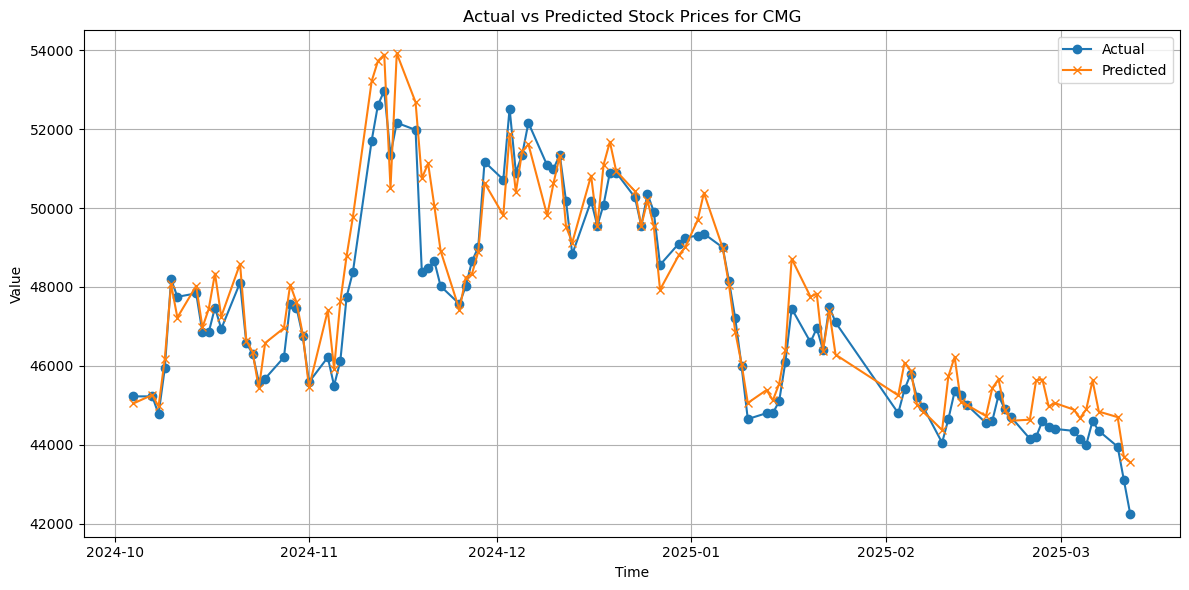

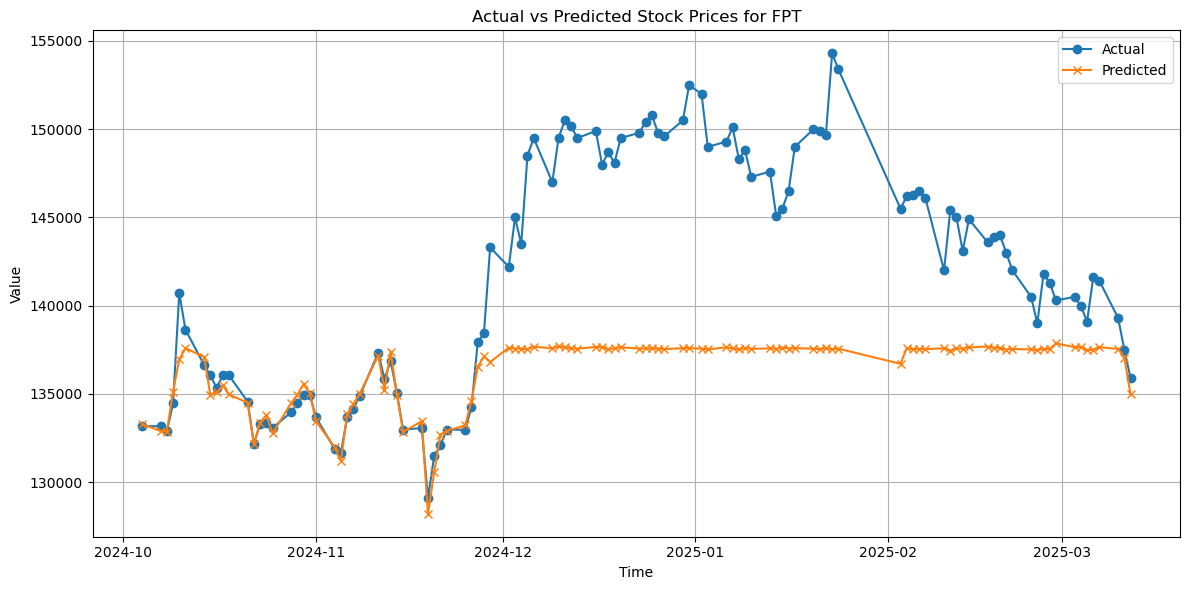

In [44]:
def compare(df, predict, ticker, ratio):
    split_idx = int(ratio * df.shape[0])
    actual_df = df.iloc[split_idx:][['Target']]
    predicted_df = pd.DataFrame(predict, columns=['Predicted'], index=actual_df.index)
    result = pd.concat([actual_df, predicted_df], axis=1)
    plot_actual_vs_predicted(result['Target'], result['Predicted'], ticker)
    return None
compare(regressor_cmg, prob_pred_re_cmg,'CMG',0.8)
compare(regressor_fpt, prob_pred_re_fpt,'FPT',0.8)

In [45]:
def predict_and_save(model, X_input_raw, x_scaler, y_scaler, ticker):
    # 1. Scale X
    X_scaled = x_scaler.transform(X_input_raw)
    # 2. Dự đoán
    if isinstance(model, Sequential):
        X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
        pred_scaled = model.predict(X_scaled)
    else:
        pred_scaled = model.predict(X_scaled).reshape(-1, 1)
    # 3. Scale ngược dự đoán trở lại giá trị đúng
    pred = y_scaler.inverse_transform(pred_scaled).flatten()
    # 4. Tạo DataFrame
    result_df = pd.DataFrame({f'Prediction value': pred}, index=X_input_raw.index)
    os.makedirs(f"{folder}/Total prediction value", exist_ok=True)
    save_path = f"{folder}/Total prediction value/prediction_{ticker}.csv"
    result_df.to_csv(save_path)
    return result_df

In [46]:
for k1, v1 in model.items():
    print(k1)
    for k2, v2 in v1.items():
        print(k2)
        if type(v2) == 'dict':
            for k3, v3 in v2.items():
                print(k3)
                print(v3)
        else:
            print(v2)

CMG
model
LGBMRegressor(n_estimators=180, num_leaves=41, random_state=42)
X_scaler
MinMaxScaler()
y_scaler
MinMaxScaler()
metrics
{'mse': 0.025072608459032225, 'mae': 1.1950729765882497, 'rmse': 0.15834332464310652, 'r2_score': 91.2762927977699}
feature importance
                               feature  importance
10                       predict_value         178
1                             Change %         174
11                     Close_ma_3_days         157
31                Change %_lags_1_days         134
29                  Change %_ma_3_days         130
22                  Volume_lags_1_days         119
0                               Volume         102
23                  Volume_lags_2_days          98
30                  Change %_ma_7_days          93
21                    Volume_ma_7_days          91
32                Change %_lags_2_days          88
33                Change %_lags_3_days          85
34                Change %_lags_4_days          84
119                  

In [47]:
prediction_cmg = predict_and_save(
    model = model['CMG']['model'],
    X_input_raw = regressor_cmg[model['CMG']['feature importance']['feature'].to_list()],
    x_scaler = model['CMG']['X_scaler'],
    y_scaler = model['CMG']['y_scaler'],
    ticker = 'CMG'
)
prediction_fpt = predict_and_save(
    model = model['FPT']['model'],
    X_input_raw = regressor_fpt[model['FPT']['feature importance']['feature'].to_list()],
    x_scaler = model['FPT']['X_scaler'],
    y_scaler = model['FPT']['y_scaler'],
    ticker = 'FPT'
)

Sử dụng LSTM để dự đoán cho giá trị tương lai 3 ngày tới

In [48]:
def lstm_train_finetune_predict(
    pred_df,
    actual_df,
    scaler,
    lookback=360,
    epochs_pretrain=1000,
    epochs_finetune=1000,
    batch_size=32,
    predict_days=7,
):
    def create_sequences(data, lookback):
        X, y = [], []
        for i in range(lookback, len(data)):
            X.append(data[i - lookback:i, 0])
            y.append(data[i, 0])
        X = np.array(X)
        y = np.array(y)
        return X.reshape(X.shape[0], X.shape[1], 1), y

    pred_series = pred_df['Prediction value'].values.reshape(-1, 1)
    scaled_pred = scaler.fit_transform(pred_series)
    X_pred, y_pred = create_sequences(scaled_pred, lookback)
    split = int(len(X_pred) * 0.8)
    X_train_pred, X_val_pred = X_pred[:split], X_pred[split:]
    y_train_pred, y_val_pred = y_pred[:split], y_pred[split:]

    model_base = Sequential()
    model_base.add(LSTM(50, return_sequences=True, input_shape=(lookback, 1)))
    model_base.add(LSTM(30))
    model_base.add(Dropout(0.2))
    model_base.add(Dense(1))
    model_base.compile(optimizer='adam', loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.0001, patience=7)

    model_base.fit(
        X_train_pred, y_train_pred,
        validation_data=(X_val_pred, y_val_pred),
        epochs=epochs_pretrain,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    actual_series = actual_df['Target'].values.reshape(-1, 1)
    scaled_actual = scaler.fit_transform(actual_series)
    X_actual, y_actual = create_sequences(scaled_actual, lookback)
    split_act = int(len(X_actual) * 0.8)
    X_train_act, X_val_act = X_actual[:split_act], X_actual[split_act:]
    y_train_act, y_val_act = y_actual[:split_act], y_actual[split_act:]

    def fine_tune(model, X_train, y_train, X_val, y_val, epochs, batch_size):
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )
        y_val_pred_scaled = model.predict(X_val).ravel()
        y_val_pred_inv = scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
        y_val_true_inv = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
        return evaluate_model(y_val_true_inv, y_val_pred_inv), model

    metrics_base, model_base = fine_tune(
        model_base, X_train_act, y_train_act, X_val_act, y_val_act,
        epochs_finetune, batch_size
    )

    input_layer = Input(shape=(lookback, 1))
    x = LSTM(50, return_sequences=True)(input_layer)
    x = LSTM(30)(x)
    x = Dropout(0.2)(x)
    x = Dense(20, activation='relu')(x)
    output_layer = Dense(1)(x)
    model_new = Model(inputs=input_layer, outputs=output_layer)

    for i, layer in enumerate(model_base.layers):
        if i == 0:
            model_new.layers[1].set_weights(layer.get_weights())
        elif i == 1:
            model_new.layers[2].set_weights(layer.get_weights())

    model_new.compile(optimizer='adam', loss='mean_squared_error')

    metrics_new, model_new = fine_tune(
        model_new, X_train_act, y_train_act, X_val_act, y_val_act,
        epochs_finetune, batch_size
    )

    # Tự động so sánh theo MSE trước
    if (metrics_new['mse']*1000) < (metrics_base['mse']*1000):
        model = model_new
        finetune_metrics = metrics_new
    elif (abs(metrics_new['mse'])*1000) == (abs(metrics_base['mse'])*1000): # MSE gần như bằng nhau thì chọn R2 cao hơn
        if metrics_new['r2'] > metrics_base['r2']:
            model = model_new
            finetune_metrics = metrics_new
        else:
            model = model_base
            finetune_metrics = metrics_base
    else:
        model = model_base
        finetune_metrics = metrics_base

    last_seq = scaled_actual[-lookback:].reshape(1, lookback, 1)
    future_scaled_preds = []

    for _ in range(predict_days):
        next_scaled = model.predict(last_seq, verbose=0)[0][0]
        future_scaled_preds.append(next_scaled)
        last_seq = np.append(last_seq[:, 1:, :], [[[next_scaled]]], axis=1)

    future_preds = scaler.inverse_transform(np.array(future_scaled_preds).reshape(-1, 1)).flatten()
    future_dates = pd.bdate_range(start=actual_df.index[-1] + pd.Timedelta(days=1), periods=predict_days)

    future_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted Closing Price': future_preds
    })

    return model, future_df, finetune_metrics

In [49]:
days = 3
model_predict_cmg, predict_cmg_price_further, cmg_metrics = lstm_train_finetune_predict(
    pred_df = prediction_cmg, 
    actual_df = regressor_cmg[['Target']], 
    scaler = model['CMG']['X_scaler'], 
    predict_days=days)
print(f"Dự đoán giá cổ  phiếu CMG thời gian {days} ngày tới")
display(predict_cmg_price_further)

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 494ms/step - loss: 0.1353 - val_loss: 0.0300 - learning_rate: 0.0010
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - loss: 0.0420 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - loss: 0.0426 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - loss: 0.0318 - val_loss: 0.0177 - learning_rate: 0.0010
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.0302 - val_loss: 0.0175 - learning_rate: 0.0010
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - loss: 0.0336 - val_loss: 0.0170 - learning_rate: 0.0010
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - loss: 0.0325 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - loss: 0.0289 - val_loss: 0.0176 - learning_rate: 0.0010
Epoch 9/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - loss: 0.0236 - val_loss: 0.0173 - learning_rate: 0.0010
Epoch 10/1

Date  Predicted Closing Price
0 2025-03-13                44,075.98
1 2025-03-14                44,020.09
2 2025-03-17                43,975.02

Giá cổ phiếu CMG thực tế 3 ngày đó:
- `2025-02-26`: 44600 VNĐ
- `2025-02-27`: 44450 VNĐ
- `2025-02-28`: 44400 VNĐ

In [50]:
model_predict_fpt, predict_fpt_price_further, fpt_metrics = lstm_train_finetune_predict(prediction_fpt, regressor_fpt[['Target']], model['FPT']['X_scaler'], predict_days=days)
print(f"Dự đoán giá cổ  phiếu FPT thời gian {days} ngày tới")
display(predict_fpt_price_further)

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 484ms/step - loss: 0.6917 - val_loss: 0.1715 - learning_rate: 0.0010
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - loss: 0.1006 - val_loss: 0.0557 - learning_rate: 0.0010
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.1038 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - loss: 0.0339 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - loss: 0.0222 - val_loss: 0.0202 - learning_rate: 0.0010
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - loss: 0.0341 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 0.0186 - val_loss: 6.6558e-04 - learning_rate: 0.0010
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.0172 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 9/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - loss: 0.0163 - val_loss: 6.7877e-04 - learning_rate: 0.0010
E

Date  Predicted Closing Price
0 2025-03-13               140,371.94
1 2025-03-14               140,321.44
2 2025-03-17               140,279.02

Giá cổ phiếu FPT 3 ngày đó:
- `2025-03-13`: 136500 VNĐ
- `2025-03-14`: 131400 VNĐ
- `2025-03-17`: 130000 VNĐ

In [51]:
os.makedirs("predict_future_model/CMG/lstm_train_finetune_predict", exist_ok=True)
os.makedirs("predict_future_model/FPT/lstm_train_finetune_predict", exist_ok=True)
model_predict_cmg.save("predict_future_model/CMG/lstm_train_finetune_predict/model.keras")
model_predict_fpt.save("predict_future_model/FPT/lstm_train_finetune_predict/model.keras")